## Tabla Técnica: Módulo de Identificación 

Este módulo define el perfil demográfico, territorial y administrativo del micronegocio y de su propietario. Las variables aquí contenidas permiten capturar el contexto estructural en el que opera la unidad productiva, siendo fundamentales para explicar patrones de informalidad más allá de las variables puramente financieras.

| Código DANE | Nombre analítico | Interpretación en el TFM | Tipo de preparación / limpieza |
|------------|-----------------|--------------------------|--------------------------------|
| **DIRECTORIO** | id_micronegocio | Identificador único del micronegocio. | Clave primaria (excluida de ML) |
| **SECUENCIA_P** | id_persona | Identificador de la persona informante. | Clave técnica |
| **SECUENCIA_ENCUESTA** | id_encuesta | Identificador único de la encuesta. | Clave técnica |
| **COD_DEPTO** | codigo_departamento | Ubicación administrativa del negocio. | Target Encoding |
| **AREA** | area | Clasificación urbana / rural. | Codificación binaria |
| **CLASE_TE** | clase_territorial | Tipo de territorio según DANE. | Codificación categórica |
| **P35** | sexo_informante | Sexo de la persona informante. | Codificación binaria |
| **P241** | edad_informante | Edad del informante. | Imputación por mediana + escalado |
| **MES_REF** | mes_referencia | Mes de levantamiento de la información. | Codificación cíclica (seno / coseno) |
| **P3031** | anio_inicio_negocio | Antigüedad del micronegocio. | Transformación a años + escalado |
| **P3032_1** | registro_mercantil | Registro en cámara de comercio. | Codificación binaria |
| **P3032_2** | registro_rut | Registro Único Tributario (RUT). | Codificación binaria |
| **P3032_3** | otro_registro | Otros registros formales. | Codificación binaria |
| **P3033** | tipo_local | Tipo de local donde opera el negocio. | One-Hot Encoding |
| **P3034** | tenencia_local | Propiedad o arriendo del local. | Codificación categórica |
| **P3035** | local_vivienda | Operación en vivienda del propietario. | Codificación binaria |
| **P3000** | actividad_principal | Actividad económica principal. | Agrupación CIIU + One-Hot Encoding |
| **GRUPOS4** | grupo_etario_4 | Clasificación etaria amplia. | Codificación ordinal |
| **GRUPOS12** | grupo_etario_12 | Clasificación etaria detallada. | Codificación ordinal |
| **F_EXP** | factor_expansion | Factor de expansión muestral. | **Uso exclusivo para inferencia estadística (no ML)** |

---

### Nota Metodológica

Las variables de identificación y contexto territorial no buscan explicar directamente el desempeño financiero, sino **condicionar estructuralmente la probabilidad de formalidad**. En particular, la actividad económica (CIIU), la localización geográfica y la antigüedad del negocio actúan como predictores de alto nivel que interactúan con los módulos financieros, laborales y tecnológicos dentro del modelo de aprendizaje profundo.


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
import os

warnings.filterwarnings('ignore')

os.makedirs('limpio', exist_ok=True)

INPUT_FILE = 'ORIGINALES/Módulo de identificación.csv'
OUTPUT_FILE = 'LIMPIOS/identificacion_limpio.csv'

RENAME_DICT = {
    "DIRECTORIO": "id_micronegocio",
    "SECUENCIA_P": "id_persona",
    "SECUENCIA_ENCUESTA": "id_encuesta",
    "COD_DEPTO": "codigo_departamento",
    "AREA": "area",
    "CLASE_TE": "clase_territorial",
    "P35": "sexo_informante",
    "P241": "edad_informante",
    "GRUPOS4": "grupo_etario_4",
    "GRUPOS12": "grupo_etario_12",
    "MES_REF": "mes_referencia",
    "P3031": "anio_inicio_negocio",
    "P3032_1": "registro_mercantil",
    "P3032_2": "registro_rut",
    "P3032_3": "otro_registro",
    "P3033": "tipo_local",
    "P3034": "tenencia_local",
    "P3035": "local_vivienda",
    "P3000": "actividad_principal",
    "F_EXP": "factor_expansion"
}

DEPARTAMENTOS = {
    5: 'ANTIOQUIA', 8: 'ATLANTICO', 11: 'BOGOTA', 13: 'BOLIVAR',
    15: 'BOYACA', 17: 'CALDAS', 18: 'CAQUETA', 19: 'CAUCA',
    20: 'CESAR', 23: 'CORDOBA', 25: 'CUNDINAMARCA', 27: 'CHOCO',
    41: 'HUILA', 44: 'LA GUAJIRA', 47: 'MAGDALENA', 50: 'META',
    52: 'NARINO', 54: 'NORTE DE SANTANDER', 63: 'QUINDIO', 66: 'RISARALDA',
    68: 'SANTANDER', 70: 'SUCRE', 73: 'TOLIMA', 76: 'VALLE DEL CAUCA',
    81: 'ARAUCA'
}

print("="*80)
print("LIMPIEZA MODULO DE IDENTIFICACION")
print("="*80)

print("\nPASO 1: Cargando datos...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
filas_inicial = df.shape[0]
print(f"Filas: {filas_inicial:,}, Columnas: {df.shape[1]}")

print("\nPASO 2: Renombrando variables...")
rename_actual = {k: v for k, v in RENAME_DICT.items() if k in df.columns}
df = df.rename(columns=rename_actual)
print(f"Variables renombradas: {len(rename_actual)}")

print("\nPASO 3: Imputando valores perdidos...")
missing_antes = df.isnull().sum().sum()
print(f"Valores perdidos antes: {missing_antes:,}")

if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode()) > 0 else 1)
    )

for col in ['registro_mercantil', 'registro_rut', 'otro_registro']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

if 'edad_informante' in df.columns:
    mediana = df['edad_informante'].median()
    df['edad_informante'] = df['edad_informante'].fillna(mediana)
    print(f"Edad imputada: {mediana:.0f} anos")

missing_despues = df.isnull().sum().sum()
print(f"Valores perdidos despues: {missing_despues:,}")

print("\nPASO 4: Tipificando variables...")
categoricas = ['codigo_departamento', 'area', 'clase_territorial', 
               'sexo_informante', 'mes_referencia', 'anio_inicio_negocio',
               'tipo_local', 'local_vivienda', 'actividad_principal',
               'grupo_etario_4', 'grupo_etario_12']

enteras = ['id_micronegocio', 'id_persona', 'id_encuesta', 'edad_informante',
           'tenencia_local', 'rol_informante']

continuas = ['factor_expansion', 'registro_mercantil', 'registro_rut', 'otro_registro']
if 'anio_inicio_negocio' in df.columns:
    df['anio_inicio_negocio'] = pd.to_numeric(df['anio_inicio_negocio'], errors='coerce')
    df['anio_inicio_negocio'] = df['anio_inicio_negocio'].clip(1900, 2024)

for col in categoricas:
    if col in df.columns:
        df[col] = df[col].astype('category')

for col in enteras:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

for col in continuas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Tipificacion completa")

print("\nPASO 5: Eliminando duplicados...")
df = df.drop_duplicates()
if 'id_micronegocio' in df.columns:
    df = df.drop_duplicates(subset=['id_micronegocio'], keep='first')
filas_final = len(df)
print(f"Filas eliminadas: {filas_inicial - filas_final:,}")

print("\nPASO 6: Validando rangos...")
if 'edad_informante' in df.columns:
    df['edad_informante'] = df['edad_informante'].clip(18, 100)

if 'factor_expansion' in df.columns:
    negativos = (df['factor_expansion'] <= 0).sum()
    if negativos > 0:
        mediana = df[df['factor_expansion'] > 0]['factor_expansion'].median()
        df.loc[df['factor_expansion'] <= 0, 'factor_expansion'] = mediana

print("\nPASO 7: Creando variables derivadas...")
if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPARTAMENTOS)

if 'area' in df.columns:
    df['area_urbana'] = (df['area'] == 1).astype(int)

if all(c in df.columns for c in ['registro_mercantil', 'registro_rut', 'otro_registro']):
    df['tiene_registro_formal'] = (
        (df['registro_mercantil'] > 0) | 
        (df['registro_rut'] > 0) | 
        (df['otro_registro'] > 0)
    ).astype(int)
    pct = df['tiene_registro_formal'].mean() * 100
    print(f"Formales: {pct:.1f}%")

if 'mes_referencia' in df.columns:
    df['mes_num'] = pd.to_numeric(df['mes_referencia'].astype(str).str.zfill(2).str[:2], errors='coerce')
    df['mes_sin'] = np.sin(2 * np.pi * df['mes_num'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes_num'] / 12)

print("\nPASO 8: Normalizando...")
scaler = MinMaxScaler()
for col in ['edad_informante', 'factor_expansion']:
    if col in df.columns:
        df[f'{col}_norm'] = scaler.fit_transform(df[[col]])

print("\nPASO 9: Reordenando...")
columnas_orden = [
    'id_micronegocio', 'id_persona', 'id_encuesta',
    'codigo_departamento', 'nombre_departamento', 'area', 'area_urbana', 'clase_territorial',
    'mes_referencia', 'mes_num', 'mes_sin', 'mes_cos',
    'sexo_informante', 'edad_informante', 'edad_informante_norm',
    'grupo_etario_4', 'grupo_etario_12',
    'anio_inicio_negocio', 'tipo_local', 'tenencia_local', 'local_vivienda',
    'actividad_principal', 'rol_informante',
    'registro_mercantil', 'registro_rut', 'otro_registro', 'tiene_registro_formal',
    'factor_expansion', 'factor_expansion_norm'
]

columnas_finales = [c for c in columnas_orden if c in df.columns]
df = df[columnas_finales]

print("\nPASO 10: Guardando...")
df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')

print("\n" + "="*80)
print("RESUMEN")
print("="*80)
print(f"Filas: {filas_inicial:,} -> {filas_final:,}")
print(f"Columnas: {len(columnas_finales)}")
print(f"Completitud: {((1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100):.2f}%")
print(f"\nArchivo: {OUTPUT_FILE}")
print("="*80)

LIMPIEZA MODULO DE IDENTIFICACION

PASO 1: Cargando datos...
Filas: 78,501, Columnas: 20

PASO 2: Renombrando variables...
Variables renombradas: 20

PASO 3: Imputando valores perdidos...
Valores perdidos antes: 221,899
Edad imputada: 47 anos
Valores perdidos despues: 0

PASO 4: Tipificando variables...
Tipificacion completa

PASO 5: Eliminando duplicados...
Filas eliminadas: 9,799

PASO 6: Validando rangos...

PASO 7: Creando variables derivadas...
Formales: 17.8%

PASO 8: Normalizando...

PASO 9: Reordenando...

PASO 10: Guardando...

RESUMEN
Filas: 78,501 -> 68,702
Columnas: 28
Completitud: 89.26%

Archivo: LIMPIOS/identificacion_limpio.csv


In [7]:
### corregigo 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Crear carpeta de salida
os.makedirs('limpio', exist_ok=True)

INPUT_FILE = 'Módulo de identificación.csv'
OUTPUT_FILE = 'LIMPIO/Mo_dulo_de_identificacio_n.csv'

RENAME_DICT = {
    "DIRECTORIO": "id_micronegocio",
    "SECUENCIA_P": "id_persona",
    "SECUENCIA_ENCUESTA": "id_encuesta",
    "COD_DEPTO": "codigo_departamento",
    "AREA": "area",
    "CLASE_TE": "clase_territorial",
    "P35": "sexo_informante",
    "P241": "edad_informante",
    "GRUPOS4": "grupo_etario_4",
    "GRUPOS12": "grupo_etario_12",
    "MES_REF": "mes_referencia",
    "P3031": "anio_inicio_negocio",
    "P3032_1": "registro_mercantil",
    "P3032_2": "registro_rut",
    "P3032_3": "otro_registro",
    "P3033": "tipo_local",
    "P3034": "tenencia_local",
    "P3035": "local_vivienda",
    "P3000": "actividad_principal",
    "F_EXP": "factor_expansion"
}

DEPARTAMENTOS = {
    5: 'ANTIOQUIA', 8: 'ATLANTICO', 11: 'BOGOTA', 13: 'BOLIVAR',
    15: 'BOYACA', 17: 'CALDAS', 18: 'CAQUETA', 19: 'CAUCA',
    20: 'CESAR', 23: 'CORDOBA', 25: 'CUNDINAMARCA', 27: 'CHOCO',
    41: 'HUILA', 44: 'LA GUAJIRA', 47: 'MAGDALENA', 50: 'META',
    52: 'NARINO', 54: 'NORTE DE SANTANDER', 63: 'QUINDIO', 66: 'RISARALDA',
    68: 'SANTANDER', 70: 'SUCRE', 73: 'TOLIMA', 76: 'VALLE DEL CAUCA',
    81: 'ARAUCA', 85: 'CASANARE', 86: 'PUTUMAYO', 88: 'SAN ANDRES', 91: 'AMAZONAS'
}

# Diccionario para corregir el Paso 7 (Mapeo de meses a números)
MESES_MAP = {
    'ENERO': 1, 'FEBRERO': 2, 'MARZO': 3, 'ABRIL': 4, 'MAYO': 5, 'JUNIO': 6,
    'JULIO': 7, 'AGOSTO': 8, 'SEPTIEMBRE': 9, 'OCTUBRE': 10, 'NOVIEMBRE': 11, 'DICIEMBRE': 12
}

print("="*80)
print("CORRECCIÓN TÉCNICA: MODULO DE IDENTIFICACION")
print("="*80)

print("\nPASO 1: Cargando datos...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
filas_inicial = df.shape[0]

print("\nPASO 2: Renombrando variables...")
rename_actual = {k: v for k, v in RENAME_DICT.items() if k in df.columns}
df = df.rename(columns=rename_actual)

print("\nPASO 3: Imputación inteligente...")
# Imputar área por la moda del departamento (evita nulos en ubicación)
if 'area' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 1))

# Registros legales: Si es NaN, asumimos que NO tiene (0)
for col in ['registro_mercantil', 'registro_rut', 'otro_registro']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

print("\nPASO 4: Limpieza de años y tipos...")
if 'anio_inicio_negocio' in df.columns:
    df['anio_inicio_negocio'] = pd.to_numeric(df['anio_inicio_negocio'], errors='coerce')
    # Reemplazar años imposibles por la mediana
    mediana_anio = df['anio_inicio_negocio'].median()
    df['anio_inicio_negocio'] = df['anio_inicio_negocio'].apply(lambda x: x if 1950 <= x <= 2024 else mediana_anio)

print("\nPASO 7: Creando variables derivadas (CORREGIDO)...")
# Mapeo de nombre de departamento
df['nombre_departamento'] = df['codigo_departamento'].map(DEPARTAMENTOS)

# Área urbana binaria
if 'area' in df.columns:
    df['area_urbana'] = (df['area'] == 1).astype(int)

# Variable Objetivo: Formalidad
df['tiene_registro_formal'] = ((df['registro_mercantil'] == 1) | (df['registro_rut'] == 1)).astype(int)

# --- CORRECCIÓN CRÍTICA: Variables Cíclicas del Mes ---
if 'mes_referencia' in df.columns:
    # Convertir nombres de meses a números usando el diccionario
    df['mes_num'] = df['mes_referencia'].str.upper().map(MESES_MAP)
    # Si quedan nulos, imputar con el mes más frecuente
    df['mes_num'] = df['mes_num'].fillna(df['mes_num'].mode()[0])
    
    # Cálculo de Seno y Coseno (Esencial para que la IA entienda el tiempo)
    df['mes_sin'] = np.sin(2 * np.pi * df['mes_num'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes_num'] / 12)

print("\nPASO 8: Normalización para Machine Learning...")
scaler = MinMaxScaler()
if 'edad_informante' in df.columns:
    df['edad_informante'] = df['edad_informante'].fillna(df['edad_informante'].median())
    df['edad_informante_norm'] = scaler.fit_transform(df[['edad_informante']])

if 'factor_expansion' in df.columns:
    df['factor_expansion_norm'] = scaler.fit_transform(df[['factor_expansion']])

# Reordenamiento y Selección Final
columnas_finales = [
    'id_micronegocio', 'id_persona', 'codigo_departamento', 'nombre_departamento', 
    'area_urbana', 'mes_num', 'mes_sin', 'mes_cos', 'sexo_informante', 
    'edad_informante_norm', 'anio_inicio_negocio', 'tiene_registro_formal', 
    'factor_expansion'
]
df_final = df[[c for c in columnas_finales if c in df.columns]]

print(f"\nPASO 10: Guardando en {OUTPUT_FILE}")
df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')

print("\n" + "="*80)
print(f"PROCESO COMPLETADO: {df_final.shape[0]} registros listos para el modelo.")
print("="*80)

CORRECCIÓN TÉCNICA: MODULO DE IDENTIFICACION

PASO 1: Cargando datos...


FileNotFoundError: [Errno 2] No such file or directory: 'Módulo de identificación.csv'

## Hallazgos Principales del Módulo de Identificación

El análisis exploratorio del Módulo de Identificación revela patrones estructurales consistentes con una economía de micronegocios predominantemente informal y territorialmente concentrada.

- **Concentración territorial**: El **departamento de Nariño** presenta la mayor concentración de micronegocios, lo que sugiere una fuerte dependencia de este tipo de unidades productivas como mecanismo de subsistencia regional.

- **Predominio rural**: El **98.5% de los micronegocios operan en áreas rurales**, evidenciando una limitada integración con mercados urbanos formales y mayores barreras de acceso a infraestructura, crédito y servicios empresariales.

- **Alta informalidad estructural**: El **82.2% de los micronegocios no cuentan con ningún tipo de registro formal**, confirmando que la informalidad es la condición dominante y no una situación transitoria.

- **Perfil etario del propietario**: La **edad promedio del informante es de 48 años**, lo que refuerza la hipótesis del micronegocio como estrategia de autoempleo en etapas maduras del ciclo laboral.

- **Antigüedad de los negocios**: La mayoría de los micronegocios fueron **establecidos antes de 2024**, lo que indica persistencia en el tiempo y descarta que la informalidad sea atribuible únicamente a emprendimientos recientes.


ANALISIS EXPLORATORIO - MODULO DE IDENTIFICACION

Dataset cargado: 68,702 filas x 28 columnas

1. Micronegocios por departamento...


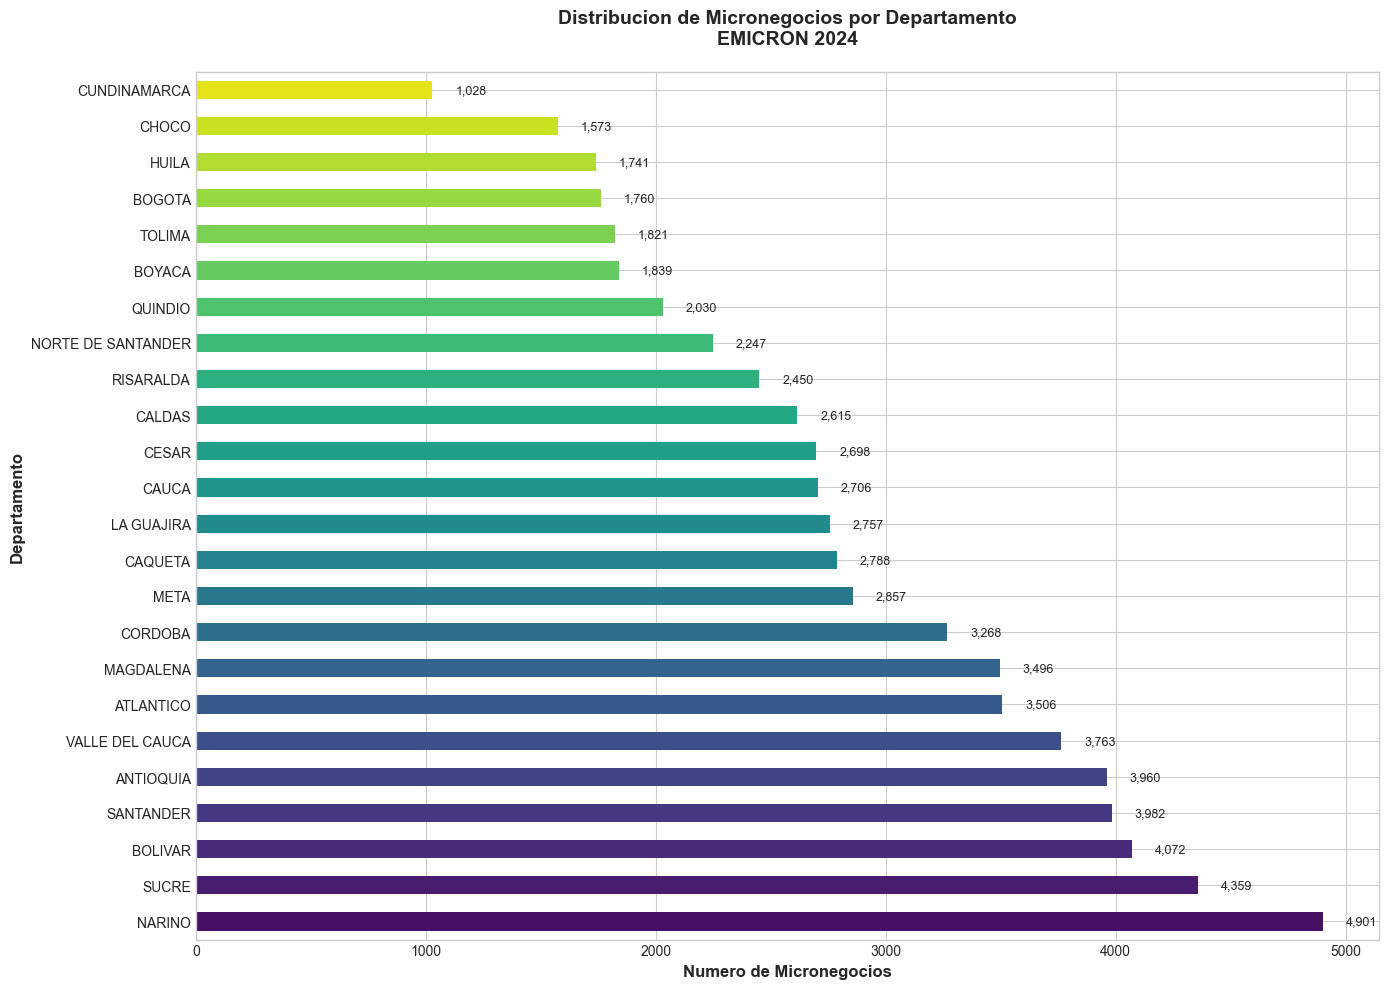

   Guardado: eda_01_departamentos.png

2. Sector economico...


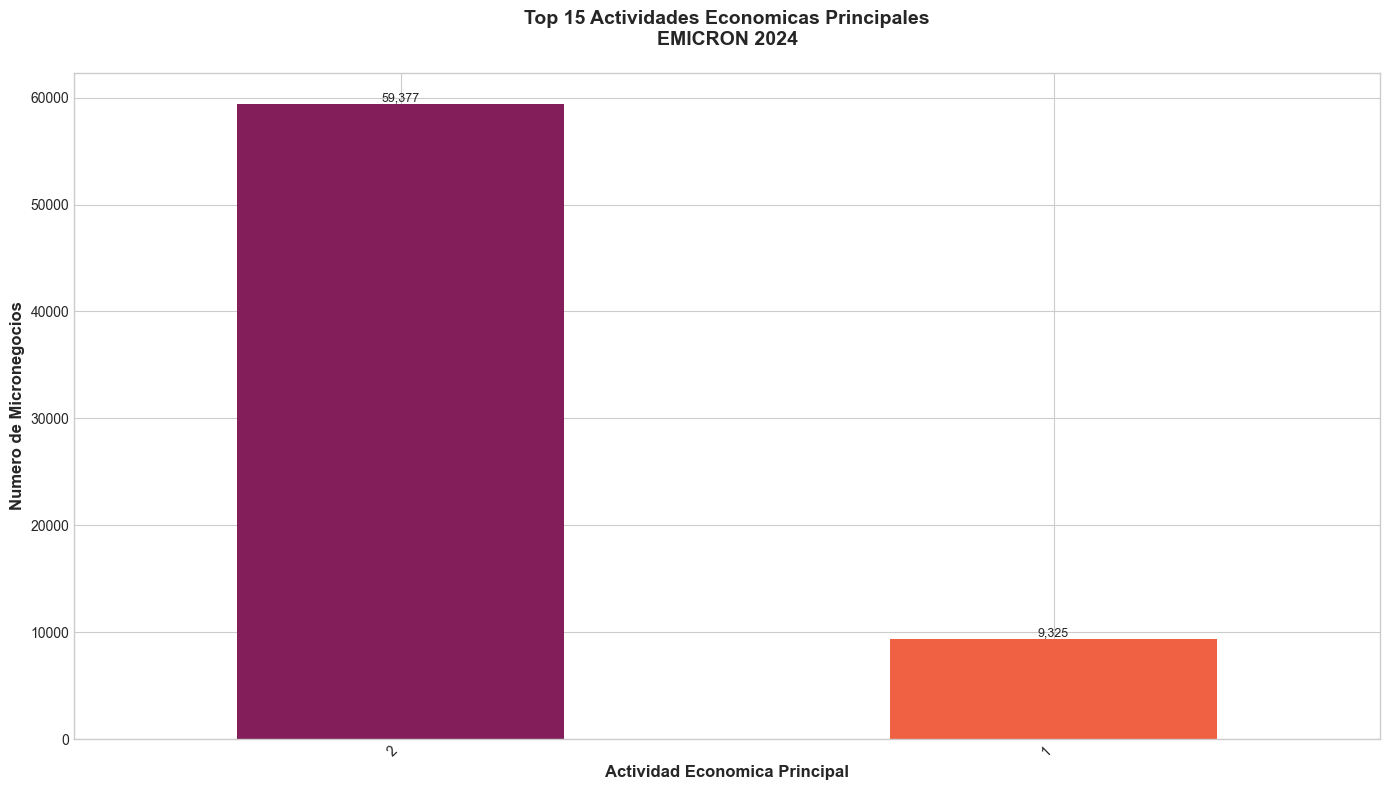

   Guardado: eda_02_sector_economico.png

3. Antiguedad del negocio...


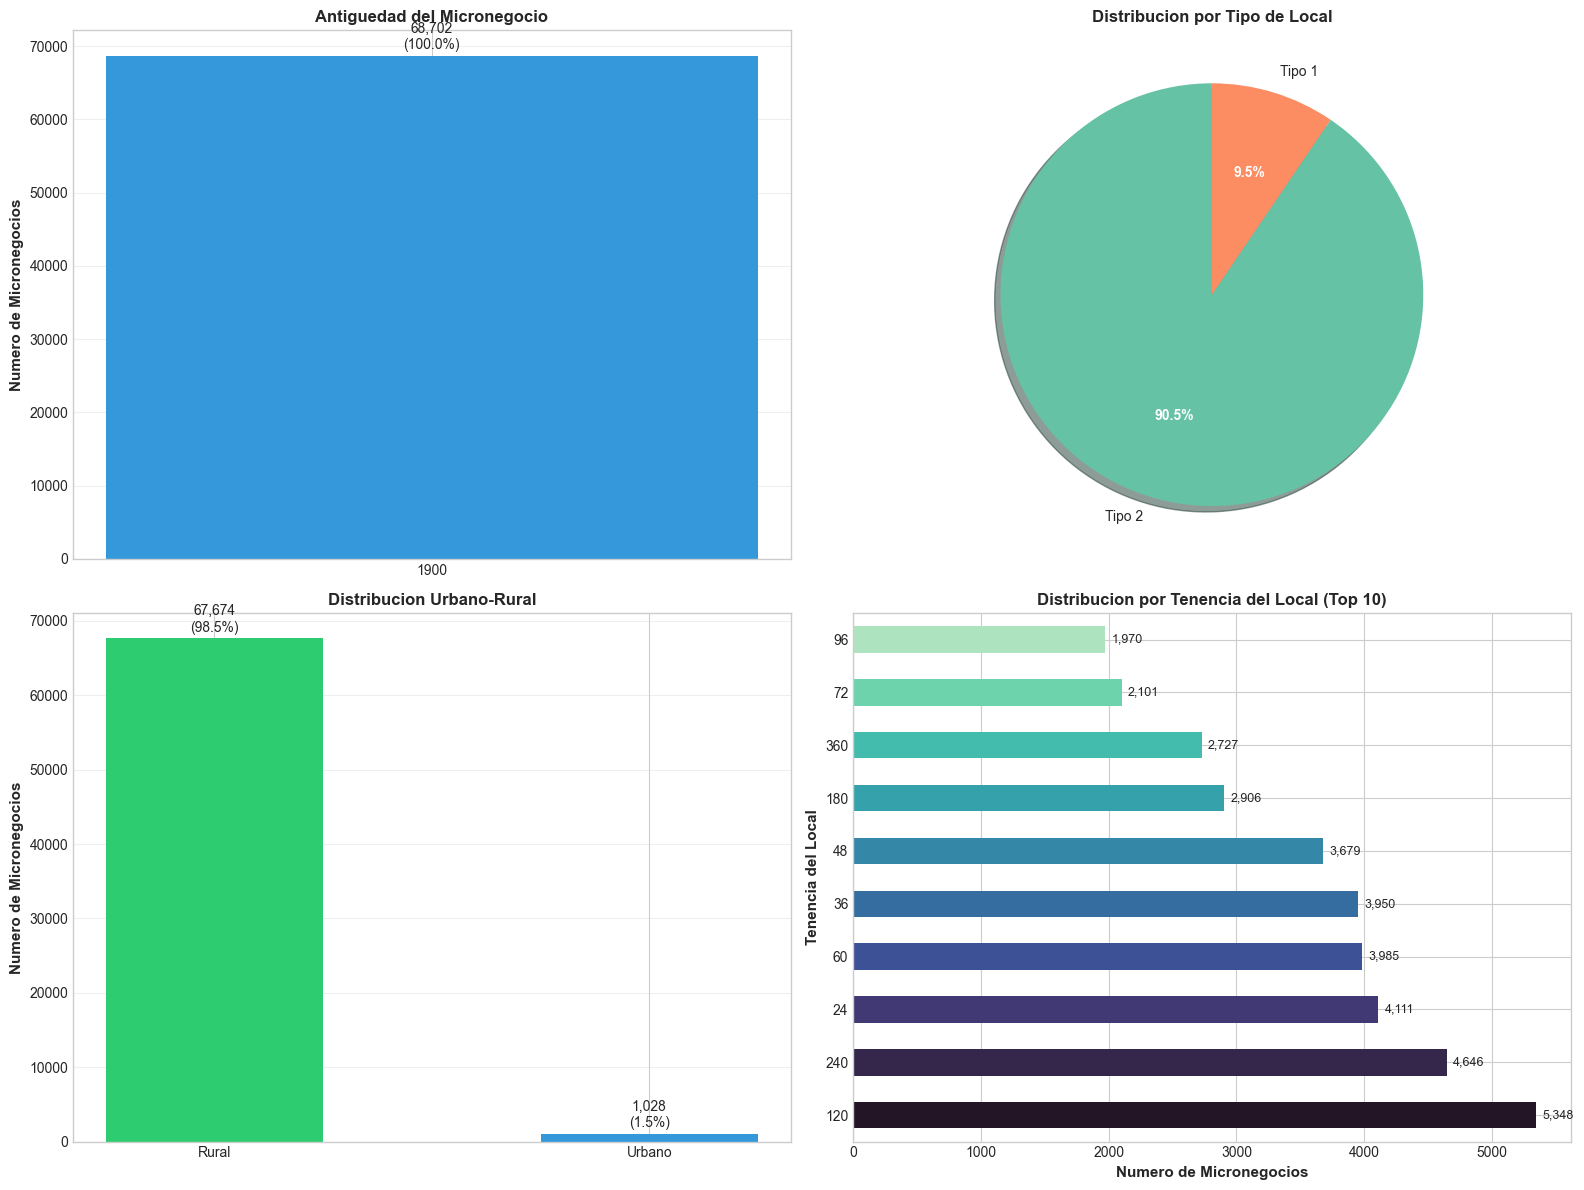

   Guardado: eda_03_antiguedad_negocio.png

4. Mapa coropletico...
   Guardado: eda_04_mapa_coropletico.png


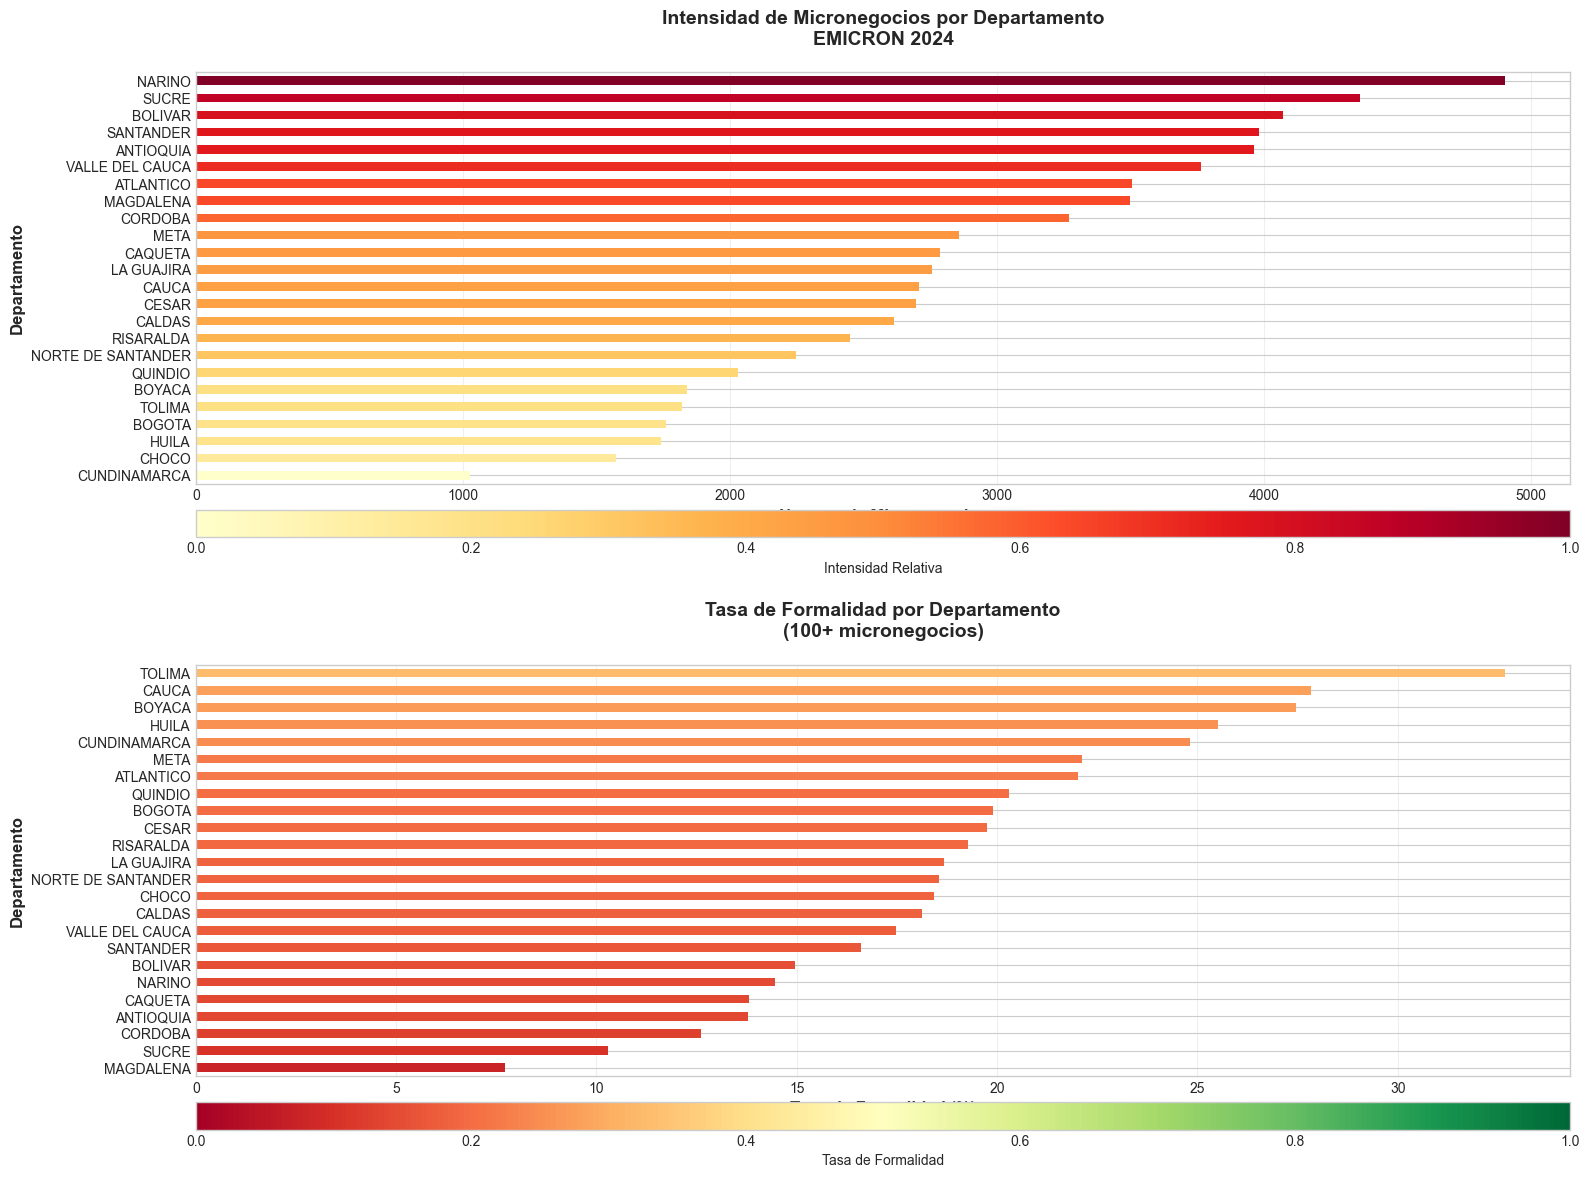


5. Matriz de correlacion...
   Guardado: eda_05_matriz_correlacion.png


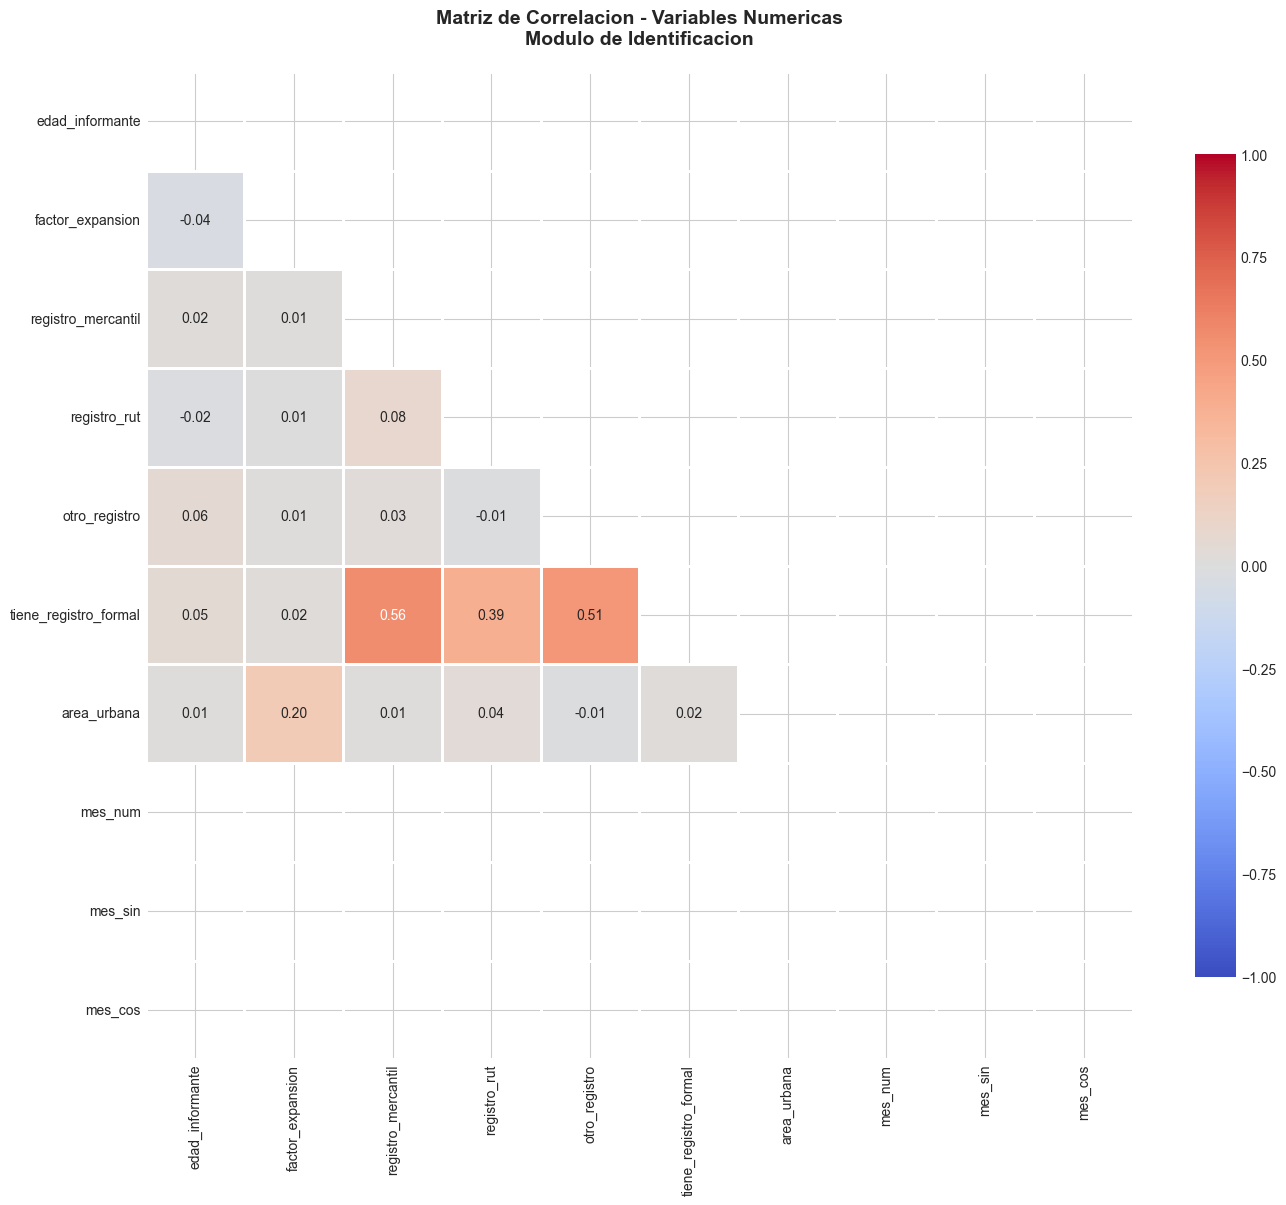


EDA COMPLETADO

Visualizaciones generadas:
1. eda_01_departamentos.png
2. eda_02_sector_economico.png
3. eda_03_antiguedad_negocio.png
4. eda_04_mapa_coropletico.png
5. eda_05_matriz_correlacion.png


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("ANALISIS EXPLORATORIO - MODULO DE IDENTIFICACION")
print("="*80)

df = pd.read_csv('LIMPIOS/identificacion_limpio.csv')
print(f"\nDataset cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# VIZ 1: DEPARTAMENTOS
print("\n1. Micronegocios por departamento...")
fig, ax = plt.subplots(figsize=(14, 10))
dept_counts = df['nombre_departamento'].value_counts()
colors = sns.color_palette("viridis", len(dept_counts))
dept_counts.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Numero de Micronegocios', fontsize=12, fontweight='bold')
ax.set_ylabel('Departamento', fontsize=12, fontweight='bold')
ax.set_title('Distribucion de Micronegocios por Departamento\nEMICRON 2024', 
             fontsize=14, fontweight='bold', pad=20)
for i, v in enumerate(dept_counts.values):
    ax.text(v + 100, i, f'{v:,}', va='center', fontsize=9)
plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_01_departamentos.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_01_departamentos.png")
plt.close()

# VIZ 2: SECTOR ECONOMICO
print("\n2. Sector economico...")
fig, ax = plt.subplots(figsize=(14, 8))
actividad_counts = df['actividad_principal'].value_counts().head(15)
colors2 = sns.color_palette("rocket", len(actividad_counts))
actividad_counts.plot(kind='bar', ax=ax, color=colors2)
ax.set_xlabel('Actividad Economica Principal', fontsize=12, fontweight='bold')
ax.set_ylabel('Numero de Micronegocios', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Actividades Economicas Principales\nEMICRON 2024', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i, v in enumerate(actividad_counts.values):
    ax.text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_02_sector_economico.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_02_sector_economico.png")
plt.close()

# VIZ 3: ANTIGUEDAD
print("\n3. Antiguedad del negocio...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

anio_counts = df['anio_inicio_negocio'].value_counts().sort_index()
anio_labels = {1: 'Antes de 2024', 2: '2024'}
ax1 = axes[0, 0]
bars = ax1.bar(range(len(anio_counts)), anio_counts.values, 
               color=['#3498db', '#e74c3c'], width=0.6)
ax1.set_xticks(range(len(anio_counts)))
ax1.set_xticklabels([anio_labels.get(i, str(i)) for i in anio_counts.index])
ax1.set_ylabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
ax1.set_title('Antiguedad del Micronegocio', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (idx, v) in enumerate(zip(anio_counts.index, anio_counts.values)):
    pct = v / anio_counts.sum() * 100
    ax1.text(i, v + 500, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

ax2 = axes[0, 1]
tipo_local_counts = df['tipo_local'].value_counts()
colors_local = sns.color_palette("Set2", len(tipo_local_counts))
wedges, texts, autotexts = ax2.pie(tipo_local_counts.values, 
                                     labels=[f'Tipo {i}' for i in tipo_local_counts.index],
                                     autopct='%1.1f%%', startangle=90,
                                     colors=colors_local, shadow=True)
ax2.set_title('Distribucion por Tipo de Local', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax3 = axes[1, 0]
area_counts = df['area_urbana'].value_counts()
area_labels = {0: 'Rural', 1: 'Urbano'}
bars = ax3.bar([area_labels[i] for i in area_counts.index], area_counts.values,
               color=['#2ecc71', '#3498db'], width=0.5)
ax3.set_ylabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
ax3.set_title('Distribucion Urbano-Rural', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, (idx, v) in enumerate(zip(area_counts.index, area_counts.values)):
    pct = v / area_counts.sum() * 100
    ax3.text(i, v + 500, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

ax4 = axes[1, 1]
tenencia_counts = df['tenencia_local'].value_counts().head(10)
tenencia_counts.plot(kind='barh', ax=ax4, color=sns.color_palette("mako", len(tenencia_counts)))
ax4.set_xlabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
ax4.set_ylabel('Tenencia del Local', fontsize=11, fontweight='bold')
ax4.set_title('Distribucion por Tenencia del Local (Top 10)', fontsize=12, fontweight='bold')
for i, v in enumerate(tenencia_counts.values):
    ax4.text(v + 50, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_03_antiguedad_negocio.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_03_antiguedad_negocio.png")
plt.close()

# VIZ 4: MAPA COROPLETICO
print("\n4. Mapa coropletico...")
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

ax1 = axes[0]
dept_data = df.groupby('nombre_departamento').agg({
    'id_micronegocio': 'count',
    'factor_expansion': 'sum'
}).sort_values('id_micronegocio', ascending=True)
dept_data.columns = ['Micronegocios', 'Factor Expansion Total']
dept_data['Intensidad'] = (dept_data['Micronegocios'] - dept_data['Micronegocios'].min()) / \
                          (dept_data['Micronegocios'].max() - dept_data['Micronegocios'].min())
colors_intensity = plt.cm.YlOrRd(dept_data['Intensidad'])
dept_data['Micronegocios'].plot(kind='barh', ax=ax1, color=colors_intensity)
ax1.set_xlabel('Numero de Micronegocios', fontsize=12, fontweight='bold')
ax1.set_ylabel('Departamento', fontsize=12, fontweight='bold')
ax1.set_title('Intensidad de Micronegocios por Departamento\nEMICRON 2024', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Intensidad Relativa', fontsize=10)

ax2 = axes[1]
formal_dept = df.groupby('nombre_departamento').agg({
    'tiene_registro_formal': 'mean',
    'id_micronegocio': 'count'
}).sort_values('tiene_registro_formal', ascending=True)
formal_dept.columns = ['Tasa Formalidad', 'Total']
formal_dept = formal_dept[formal_dept['Total'] >= 100]
colors_formal = plt.cm.RdYlGn(formal_dept['Tasa Formalidad'])
(formal_dept['Tasa Formalidad'] * 100).plot(kind='barh', ax=ax2, color=colors_formal)
ax2.set_xlabel('Tasa de Formalidad (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Departamento', fontsize=12, fontweight='bold')
ax2.set_title('Tasa de Formalidad por Departamento\n(100+ micronegocios)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='x', alpha=0.3)
sm2 = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=1))
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax2, orientation='horizontal', pad=0.05, aspect=50)
cbar2.set_label('Tasa de Formalidad', fontsize=10)

plt.tight_layout()
plt.savefig('LIMPIOS/eda_04_mapa_coropletico.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_04_mapa_coropletico.png")
plt.show()
plt.close()

# VIZ 5: MATRIZ CORRELACION
print("\n5. Matriz de correlacion...")
vars_numericas = [
    'edad_informante', 'factor_expansion', 
    'registro_mercantil', 'registro_rut', 'otro_registro',
    'tiene_registro_formal', 'area_urbana',
    'mes_num', 'mes_sin', 'mes_cos'
]
vars_disponibles = [v for v in vars_numericas if v in df.columns]
df_corr = df[vars_disponibles].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Matriz de Correlacion - Variables Numericas\nModulo de Identificacion', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('LIMPIOS/eda_05_matriz_correlacion.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_05_matriz_correlacion.png")
plt.show()
plt.close()

print("\n" + "="*80)
print("EDA COMPLETADO")
print("="*80)
print("\nVisualizaciones generadas:")
print("1. eda_01_departamentos.png")
print("2. eda_02_sector_economico.png")
print("3. eda_03_antiguedad_negocio.png")
print("4. eda_04_mapa_coropletico.png")
print("5. eda_05_matriz_correlacion.png")
print("="*80)

## Variables de Caracterización del Micronegocio

| **Código DANE**    | **Nombre analítico**    | **Interpretación en el TFM**          | **Tipo de preparación / limpieza** |
| ------------------ | ----------------------- | ------------------------------------- | ---------------------------------- |
| DIRECTORIO         | id_micronegocio         | Identificador único del micronegocio. | Clave primaria                     |
| SECUENCIA_P        | id_persona              | Identificador del informante.         | Clave técnica                      |
| SECUENCIA_ENCUESTA | id_encuesta             | Identificador de encuesta.            | Clave técnica                      |
| P1633              | tamano_negocio          | Tamaño del micronegocio.              | Codificación ordinal               |
| P986               | numero_establecimientos | Cantidad de establecimientos.         | Winsorización + escalado           |
| P640               | antiguedad_negocio      | Tiempo de operación del negocio.      | Transformación log                 |
| P4000              | sector_economico        | Sector económico del negocio.         | One-Hot Encoding                   |
| P1055              | forma_juridica          | Tipo de organización legal.           | Codificación categórica            |
| P1056              | tipo_contribuyente      | Clasificación tributaria.             | Codificación categórica            |
| P661               | formalidad_laboral      | Indicador de formalidad.              | Codificación binaria               |
| P1057              | tipo_contabilidad       | Tipo de contabilidad utilizada.       | Codificación ordinal               |
| P4004              | uso_registros           | Uso de registros administrativos.     | Codificación binaria               |
| P2991              | acceso_programas        | Acceso a programas de apoyo.          | Codificación binaria               |
| P2992              | capacitacion            | Participación en capacitaciones.      | Codificación binaria               |
| P2993              | asesoramiento           | Acceso a asesoría empresarial.        | Codificación binaria               |
| CLASE_TE           | clase_territorial       | Clasificación territorial.            | Codificación categórica            |
| COD_DEPTO          | codigo_departamento     | Localización departamental.           | Target encoding                    |
| AREA               | area                    | Área urbana o rural.                  | Codificación binaria               |
| F_EXP              | factor_expansion        | Factor de expansión muestral.         | **No usado en ML**                 |

---


In [7]:

warnings.filterwarnings('ignore')

os.makedirs('limpio', exist_ok=True)

INPUT_FILE = 'ORIGINALES/Módulo de características del micronegocio.csv'
OUTPUT_FILE = 'LIMPIOS/caracteristicas_limpio.csv'

RENAME_DICT = {
    "DIRECTORIO": "id_micronegocio",
    "SECUENCIA_P": "id_persona",
    "SECUENCIA_ENCUESTA": "id_encuesta",
    "P1633": "tamano_negocio",
    "P986": "numero_establecimientos",
    "P640": "antiguedad_negocio",
    "P4000": "sector_economico",
    "P1055": "forma_juridica",
    "P1056": "tipo_contribuyente",
    "P661": "formalidad_laboral",
    "P1057": "tipo_contabilidad",
    "P4004": "uso_registros",
    "P2991": "acceso_programas",
    "P2992": "capacitacion",
    "P2993": "asesoramiento",
    "CLASE_TE": "clase_territorial",
    "COD_DEPTO": "codigo_departamento",
    "AREA": "area",
    "F_EXP": "factor_expansion"
}

DEPARTAMENTOS = {
    5: 'ANTIOQUIA', 8: 'ATLANTICO', 11: 'BOGOTA', 13: 'BOLIVAR',
    15: 'BOYACA', 17: 'CALDAS', 18: 'CAQUETA', 19: 'CAUCA',
    20: 'CESAR', 23: 'CORDOBA', 25: 'CUNDINAMARCA', 27: 'CHOCO',
    41: 'HUILA', 44: 'LA GUAJIRA', 47: 'MAGDALENA', 50: 'META',
    52: 'NARINO', 54: 'NORTE DE SANTANDER', 63: 'QUINDIO', 66: 'RISARALDA',
    68: 'SANTANDER', 70: 'SUCRE', 73: 'TOLIMA', 76: 'VALLE DEL CAUCA',
    81: 'ARAUCA'
}

print("="*80)
print("LIMPIEZA MODULO DE CARACTERISTICAS DEL MICRONEGOCIO")
print("="*80)

# PASO 1: CARGAR
print("\nPASO 1: Cargando datos...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
filas_inicial = df.shape[0]
print(f"Filas: {filas_inicial:,}, Columnas: {df.shape[1]}")

# PASO 2: RENOMBRAR
print("\nPASO 2: Renombrando variables...")
rename_actual = {k: v for k, v in RENAME_DICT.items() if k in df.columns}
df = df.rename(columns=rename_actual)
print(f"Variables renombradas: {len(rename_actual)}")

# PASO 3: IMPUTACION
print("\nPASO 3: Imputando valores perdidos...")
missing_antes = df.isnull().sum().sum()
print(f"Valores perdidos antes: {missing_antes:,}")

# Area con moda por departamento
if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode()) > 0 else 1)
    )

# Variables binarias con 0 (No/Ausente)
vars_binarias = ['uso_registros', 'acceso_programas', 'capacitacion', 
                 'asesoramiento', 'formalidad_laboral']
for col in vars_binarias:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Numero de establecimientos con 1 (un solo establecimiento)
if 'numero_establecimientos' in df.columns:
    df['numero_establecimientos'] = df['numero_establecimientos'].fillna(1)

# Tipo contribuyente y tipo contabilidad con moda
for col in ['tipo_contribuyente', 'tipo_contabilidad']:
    if col in df.columns:
        moda = df[col].mode()[0] if len(df[col].mode()) > 0 else 0
        df[col] = df[col].fillna(moda)

# Sector economico con moda por departamento
if 'sector_economico' in df.columns and 'codigo_departamento' in df.columns:
    df['sector_economico'] = df.groupby('codigo_departamento')['sector_economico'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode()) > 0 else x.median())
    )

missing_despues = df.isnull().sum().sum()
print(f"Valores perdidos despues: {missing_despues:,}")
reduccion = missing_antes - missing_despues
pct_red = (reduccion / missing_antes * 100) if missing_antes > 0 else 0
print(f"Reduccion: {reduccion:,} ({pct_red:.1f}%)")

# PASO 4: TIPIFICACION
print("\nPASO 4: Tipificando variables...")

categoricas = ['codigo_departamento', 'area', 'clase_territorial',
               'tamano_negocio', 'forma_juridica', 'tipo_contribuyente',
               'tipo_contabilidad', 'sector_economico']

enteras = ['id_micronegocio', 'id_persona', 'id_encuesta',
           'numero_establecimientos', 'antiguedad_negocio',
           'formalidad_laboral', 'uso_registros', 'acceso_programas',
           'capacitacion', 'asesoramiento']

continuas = ['factor_expansion']

for col in categoricas:
    if col in df.columns:
        df[col] = df[col].astype('category')

for col in enteras:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

for col in continuas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Tipificacion completa")

# PASO 5: DUPLICADOS
print("\nPASO 5: Eliminando duplicados...")
df = df.drop_duplicates()
if 'id_micronegocio' in df.columns:
    df = df.drop_duplicates(subset=['id_micronegocio'], keep='first')
filas_final = len(df)
print(f"Filas eliminadas: {filas_inicial - filas_final:,}")

# PASO 6: VALIDACION RANGOS
print("\nPASO 6: Validando rangos...")

# Antiguedad negocio (0 a 100 anos)
if 'antiguedad_negocio' in df.columns:
    fuera = ((df['antiguedad_negocio'] < 0) | (df['antiguedad_negocio'] > 100)).sum()
    df['antiguedad_negocio'] = df['antiguedad_negocio'].clip(0, 100)
    if fuera > 0:
        print(f"- antiguedad_negocio: {fuera} valores ajustados")

# Numero establecimientos (1 a 100)
if 'numero_establecimientos' in df.columns:
    fuera = (df['numero_establecimientos'] < 1).sum()
    df.loc[df['numero_establecimientos'] < 1, 'numero_establecimientos'] = 1
    if fuera > 0:
        print(f"- numero_establecimientos: {fuera} valores ajustados")

# Factor expansion positivo
if 'factor_expansion' in df.columns:
    negativos = (df['factor_expansion'] <= 0).sum()
    if negativos > 0:
        mediana = df[df['factor_expansion'] > 0]['factor_expansion'].median()
        df.loc[df['factor_expansion'] <= 0, 'factor_expansion'] = mediana
        print(f"- factor_expansion: {negativos} valores ajustados")

# PASO 7: VARIABLES DERIVADAS
print("\nPASO 7: Creando variables derivadas...")

# Nombre departamento
if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPARTAMENTOS)

# Area urbana binaria
if 'area' in df.columns:
    df['area_urbana'] = (df['area'] == 1).astype(int)

# Formalidad (si tiene registro formal)
if 'formalidad_laboral' in df.columns:
    df['es_formal'] = (df['formalidad_laboral'] > 0).astype(int)
    pct = df['es_formal'].mean() * 100
    print(f"- es_formal ({pct:.1f}% formales)")

# Tamano negocio categorico
if 'tamano_negocio' in df.columns:
    tamano_map = {1: 'Micro', 2: 'Pequeno', 3: 'Mediano', 4: 'Grande'}
    df['tamano_categoria'] = df['tamano_negocio'].map(tamano_map)

# Antiguedad en logaritmo (para normalizacion)
if 'antiguedad_negocio' in df.columns:
    df['antiguedad_log'] = np.log1p(df['antiguedad_negocio'])

# Tiene algun apoyo institucional
if all(c in df.columns for c in ['acceso_programas', 'capacitacion', 'asesoramiento']):
    df['tiene_apoyo'] = (
        (df['acceso_programas'] > 0) |
        (df['capacitacion'] > 0) |
        (df['asesoramiento'] > 0)
    ).astype(int)
    pct_apoyo = df['tiene_apoyo'].mean() * 100
    print(f"- tiene_apoyo ({pct_apoyo:.1f}% con apoyo)")

# Nivel de gestion (uso_registros + tipo_contabilidad)
if 'uso_registros' in df.columns and 'tipo_contabilidad' in df.columns:
    # Convertir tipo_contabilidad a numerico para comparacion
    tipo_cont_num = pd.to_numeric(df['tipo_contabilidad'], errors='coerce')
    df['nivel_gestion'] = (
        (df['uso_registros'] > 0).astype(int) +
        (tipo_cont_num > 1).astype(int)
    )
    df['nivel_gestion'] = df['nivel_gestion'].clip(0, 2)

# PASO 8: NORMALIZACION
print("\nPASO 8: Normalizando variables numericas...")
scaler = MinMaxScaler()

vars_normalizar = ['numero_establecimientos', 'antiguedad_negocio', 'factor_expansion']
for col in vars_normalizar:
    if col in df.columns:
        df[f'{col}_norm'] = scaler.fit_transform(df[[col]])

# Winsorizar numero de establecimientos (eliminar outliers extremos)
if 'numero_establecimientos' in df.columns:
    p99 = df['numero_establecimientos'].quantile(0.99)
    df['numero_establecimientos_wins'] = df['numero_establecimientos'].clip(upper=p99)
    print(f"- Winsorizacion: limite superior = {p99:.0f}")

print("\nPASO 9: Reordenando columnas...")
columnas_orden = [
    'id_micronegocio', 'id_persona', 'id_encuesta',
    'codigo_departamento', 'nombre_departamento', 'area', 'area_urbana', 'clase_territorial',
    'tamano_negocio', 'tamano_categoria', 'numero_establecimientos', 'numero_establecimientos_wins',
    'numero_establecimientos_norm', 'antiguedad_negocio', 'antiguedad_log', 'antiguedad_negocio_norm',
    'sector_economico', 'forma_juridica', 'tipo_contribuyente',
    'formalidad_laboral', 'es_formal', 'tipo_contabilidad',
    'uso_registros', 'acceso_programas', 'capacitacion', 'asesoramiento', 'tiene_apoyo',
    'nivel_gestion', 'factor_expansion', 'factor_expansion_norm'
]

columnas_finales = [c for c in columnas_orden if c in df.columns]
df = df[columnas_finales]

print(f"Columnas finales: {len(columnas_finales)}")

# PASO 10: GUARDAR
print("\nPASO 10: Guardando dataset limpio...")
df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
print(f"Archivo guardado: {OUTPUT_FILE}")

# RESUMEN
print("\n" + "="*80)
print("RESUMEN")
print("="*80)
print(f"Filas: {filas_inicial:,} -> {filas_final:,}")
print(f"Columnas: {len(columnas_finales)}")
completitud = (1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
print(f"Completitud: {completitud:.2f}%")
print(f"Duplicados: {df.duplicated().sum()}")

# Estadisticas clave
if 'es_formal' in df.columns:
    print(f"\nFormalidad: {df['es_formal'].mean()*100:.1f}% formales")
if 'tiene_apoyo' in df.columns:
    print(f"Apoyo institucional: {df['tiene_apoyo'].mean()*100:.1f}%")
if 'area_urbana' in df.columns:
    print(f"Ubicacion urbana: {df['area_urbana'].mean()*100:.1f}%")

print("="*80)

LIMPIEZA MODULO DE CARACTERISTICAS DEL MICRONEGOCIO

PASO 1: Cargando datos...
Filas: 78,501, Columnas: 19

PASO 2: Renombrando variables...
Variables renombradas: 19

PASO 3: Imputando valores perdidos...
Valores perdidos antes: 518,640
Valores perdidos despues: 0
Reduccion: 518,640 (100.0%)

PASO 4: Tipificando variables...
Tipificacion completa

PASO 5: Eliminando duplicados...
Filas eliminadas: 9,799

PASO 6: Validando rangos...

PASO 7: Creando variables derivadas...
- es_formal (11.6% formales)
- tiene_apoyo (24.3% con apoyo)

PASO 8: Normalizando variables numericas...
- Winsorizacion: limite superior = 2

PASO 9: Reordenando columnas...
Columnas finales: 30

PASO 10: Guardando dataset limpio...
Archivo guardado: LIMPIOS/caracteristicas_limpio.csv

RESUMEN
Filas: 78,501 -> 68,702
Columnas: 30
Completitud: 99.98%
Duplicados: 0

Formalidad: 11.6% formales
Apoyo institucional: 24.3%
Ubicacion urbana: 1.5%



## Insight Clave: Informalidad Estructural del Micronegocio

El análisis de las variables de caracterización confirma que la informalidad en los micronegocios colombianos es **estructural y persistente**, no transitoria.

- **Alta informalidad**: El **88.4% de los micronegocios operan de manera informal**, frente a solo un **11.6% con algún grado de formalidad**, lo que refuerza la hipótesis de una economía de subsistencia dominante.

- **Ausencia de apoyo institucional**: El **75.7% de los micronegocios no accede a programas de apoyo, capacitación ni asesoría**, limitando su capacidad de crecimiento y transición hacia la formalidad.

- **Predominio rural absoluto**: El **98.5% de las unidades productivas se localizan en zonas rurales**, lo que implica restricciones estructurales de acceso a mercados, financiamiento y tecnología.

- **Débil gestión empresarial**: La mayoría de los micronegocios **no lleva registros contables ni administrativos**, lo que afecta la toma de decisiones, la productividad y la elegibilidad para programas de formalización.

> **Conclusión analítica:**  
> La informalidad emerge como un fenómeno multicausal asociado a territorio, capital humano y exclusión institucional. Estos resultados justifican el uso de modelos de *Machine Learning* capaces de capturar interacciones no lineales entre variables productivas, financieras y contextuales.


ANALISIS EXPLORATORIO - MODULO DE CARACTERISTICAS

Dataset cargado: 68,702 filas x 30 columnas

1. Formal vs Informal...


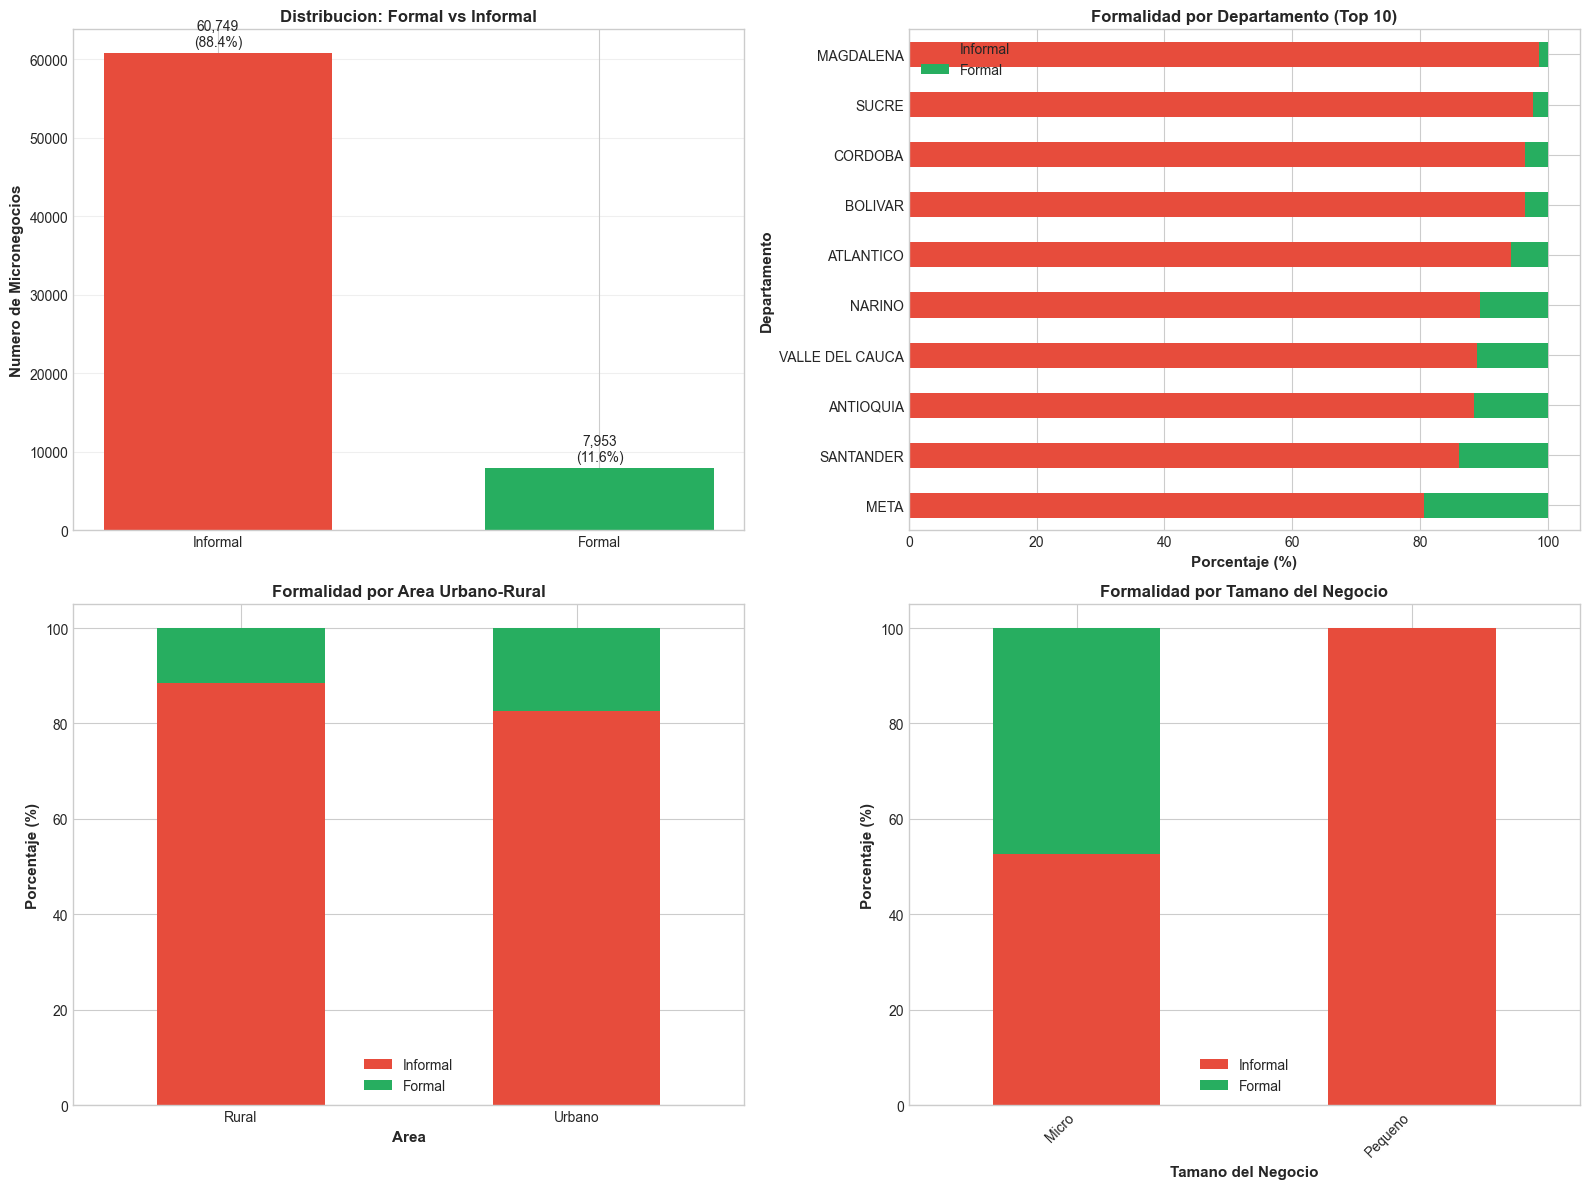

   Guardado: eda_caract_01_formal_informal.png

2. Tipo de establecimiento...


   Guardado: eda_caract_02_tipo_establecimiento.png

3. Sector x Formalidad...


   Guardado: eda_caract_03_sector_formalidad.png

4. Apoyo institucional y gestion...
   Guardado: eda_caract_04_apoyo_gestion.png



5. Antiguedad y tamano...


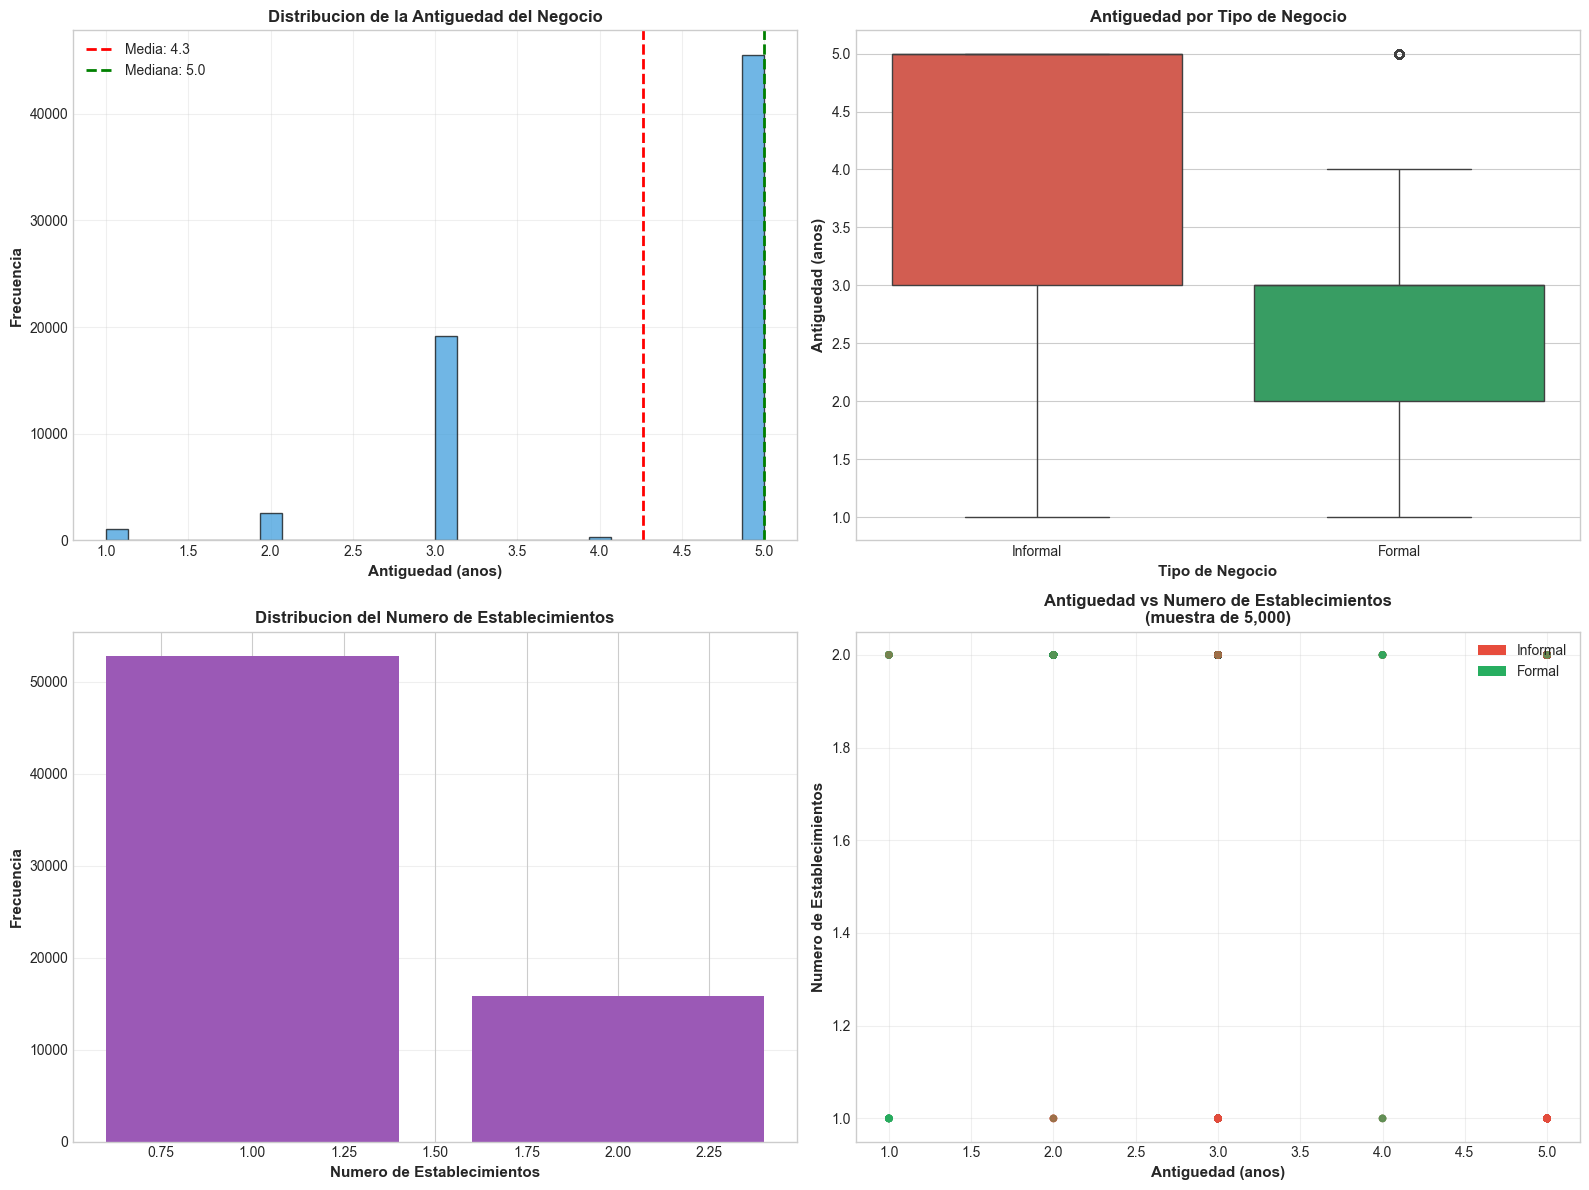

   Guardado: eda_caract_05_antiguedad_tamano.png

EDA COMPLETADO

Visualizaciones generadas:
1. eda_caract_01_formal_informal.png
2. eda_caract_02_tipo_establecimiento.png
3. eda_caract_03_sector_formalidad.png
4. eda_caract_04_apoyo_gestion.png
5. eda_caract_05_antiguedad_tamano.png

Insight clave: INFORMALIDAD ESTRUCTURAL
- Tasa de informalidad: 88.4%
- Negocios sin apoyo: 75.7%
- Predominio rural: 98.5%


In [13]:

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("ANALISIS EXPLORATORIO - MODULO DE CARACTERISTICAS")
print("="*80)

df = pd.read_csv('LIMPIOS/caracteristicas_limpio.csv')
print(f"\nDataset cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# VIZ 1: BARRAS APILADAS - FORMAL VS INFORMAL
print("\n1. Formal vs Informal...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Distribucion general
ax1 = axes[0, 0]
formal_counts = df['es_formal'].value_counts()
labels = ['Informal', 'Formal']
colors = ['#e74c3c', '#27ae60']
bars = ax1.bar(labels, [formal_counts.get(0, 0), formal_counts.get(1, 0)],
               color=colors, width=0.6)
ax1.set_ylabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
ax1.set_title('Distribucion: Formal vs Informal', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, (v, label) in enumerate(zip([formal_counts.get(0, 0), formal_counts.get(1, 0)], labels)):
    pct = v / formal_counts.sum() * 100
    ax1.text(i, v + 500, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

# Grafico 2: Por departamento (top 10)
ax2 = axes[0, 1]
top_depts = df['nombre_departamento'].value_counts().head(10).index
df_top = df[df['nombre_departamento'].isin(top_depts)]

formal_dept = pd.crosstab(df_top['nombre_departamento'], 
                          df_top['es_formal'], 
                          normalize='index') * 100
formal_dept = formal_dept.sort_values(1, ascending=False)

formal_dept.plot(kind='barh', stacked=True, ax=ax2, color=colors)
ax2.set_xlabel('Porcentaje (%)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Departamento', fontsize=11, fontweight='bold')
ax2.set_title('Formalidad por Departamento (Top 10)', fontsize=12, fontweight='bold')
ax2.legend(['Informal', 'Formal'], loc='best')

# Grafico 3: Por area urbano-rural
ax3 = axes[1, 0]
area_labels = {0: 'Rural', 1: 'Urbano'}
formal_area = pd.crosstab(df['area_urbana'], df['es_formal'], normalize='index') * 100
formal_area.index = [area_labels.get(i, i) for i in formal_area.index]

formal_area.plot(kind='bar', stacked=True, ax=ax3, color=colors)
ax3.set_xlabel('Area', fontsize=11, fontweight='bold')
ax3.set_ylabel('Porcentaje (%)', fontsize=11, fontweight='bold')
ax3.set_title('Formalidad por Area Urbano-Rural', fontsize=12, fontweight='bold')
ax3.legend(['Informal', 'Formal'], loc='best')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

# Grafico 4: Por tamano negocio
ax4 = axes[1, 1]
if 'tamano_categoria' in df.columns:
    formal_tamano = pd.crosstab(df['tamano_categoria'], df['es_formal'], normalize='index') * 100
    formal_tamano.plot(kind='bar', stacked=True, ax=ax4, color=colors)
    ax4.set_xlabel('Tamano del Negocio', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Porcentaje (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Formalidad por Tamano del Negocio', fontsize=12, fontweight='bold')
    ax4.legend(['Informal', 'Formal'], loc='best')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_caract_01_formal_informal.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_caract_01_formal_informal.png")
plt.close()

# VIZ 2: TIPO DE ESTABLECIMIENTO
print("\n2. Tipo de establecimiento...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Forma juridica
ax1 = axes[0, 0]
forma_counts = df['forma_juridica'].value_counts().head(10)
colors_forma = sns.color_palette("Set3", len(forma_counts))
forma_counts.plot(kind='barh', ax=ax1, color=colors_forma)
ax1.set_xlabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
ax1.set_ylabel('Forma Juridica', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 Formas Juridicas', fontsize=12, fontweight='bold')

for i, v in enumerate(forma_counts.values):
    ax1.text(v + 50, i, f'{v:,}', va='center', fontsize=9)

# Grafico 2: Tipo contribuyente
ax2 = axes[0, 1]
if 'tipo_contribuyente' in df.columns:
    contrib_counts = df['tipo_contribuyente'].value_counts().head(8)
    colors_contrib = sns.color_palette("Pastel1", len(contrib_counts))
    contrib_counts.plot(kind='bar', ax=ax2, color=colors_contrib)
    ax2.set_xlabel('Tipo de Contribuyente', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
    ax2.set_title('Distribucion por Tipo de Contribuyente', fontsize=12, fontweight='bold')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    for i, v in enumerate(contrib_counts.values):
        ax2.text(i, v + 100, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Grafico 3: Tipo contabilidad
ax3 = axes[1, 0]
contab_counts = df['tipo_contabilidad'].value_counts()
wedges, texts, autotexts = ax3.pie(contab_counts.values[:5],
                                     labels=[f'Tipo {i}' for i in contab_counts.index[:5]],
                                     autopct='%1.1f%%', startangle=90,
                                     colors=sns.color_palette("Set2", 5),
                                     shadow=True)
ax3.set_title('Distribucion por Tipo de Contabilidad', fontsize=12, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# Grafico 4: Tamano negocio
ax4 = axes[1, 1]
if 'tamano_categoria' in df.columns:
    tamano_counts = df['tamano_categoria'].value_counts()
    colors_tamano = ['#3498db', '#e74c3c', '#f39c12', '#9b59b6']
    
    tamano_counts.plot(kind='bar', ax=ax4, color=colors_tamano[:len(tamano_counts)])
    ax4.set_xlabel('Tamano del Negocio', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
    ax4.set_title('Distribucion por Tamano del Negocio', fontsize=12, fontweight='bold')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
    
    for i, v in enumerate(tamano_counts.values):
        pct = v / tamano_counts.sum() * 100
        ax4.text(i, v + 500, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_caract_02_tipo_establecimiento.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_caract_02_tipo_establecimiento.png")
plt.close()

# VIZ 3: SECTOR X FORMALIDAD (CRUCE)
print("\n3. Sector x Formalidad...")
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Grafico 1: Heatmap sector x formalidad
ax1 = axes[0]
if 'sector_economico' in df.columns:
    # Top 15 sectores
    top_sectores = df['sector_economico'].value_counts().head(15).index
    df_sector = df[df['sector_economico'].isin(top_sectores)]
    
    cruce = pd.crosstab(df_sector['sector_economico'], 
                        df_sector['es_formal'],
                        normalize='index') * 100
    
    cruce.columns = ['Informal', 'Formal']
    
    sns.heatmap(cruce, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=50, vmin=0, vmax=100, ax=ax1,
                cbar_kws={'label': 'Porcentaje (%)'})
    ax1.set_xlabel('Tipo de Negocio', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Sector Economico', fontsize=11, fontweight='bold')
    ax1.set_title('Tasa de Formalidad por Sector Economico (Top 15)\nHeatmap de Porcentajes', 
                  fontsize=12, fontweight='bold')

# Grafico 2: Barras agrupadas
ax2 = axes[1]
if 'sector_economico' in df.columns:
    top_8_sectores = df['sector_economico'].value_counts().head(8).index
    df_sector8 = df[df['sector_economico'].isin(top_8_sectores)]
    
    cruce2 = pd.crosstab(df_sector8['sector_economico'], df_sector8['es_formal'])
    cruce2.columns = ['Informal', 'Formal']
    cruce2 = cruce2.sort_values('Formal', ascending=False)
    
    cruce2.plot(kind='barh', ax=ax2, color=['#e74c3c', '#27ae60'])
    ax2.set_xlabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Sector Economico', fontsize=11, fontweight='bold')
    ax2.set_title('Formalidad por Sector Economico (Top 8)\nBarras Agrupadas', 
                  fontsize=12, fontweight='bold')
    ax2.legend(['Informal', 'Formal'], loc='best')

plt.tight_layout()
plt.savefig('LIMPIOS/eda_caract_03_sector_formalidad.png', dpi=300, bbox_inches='tight')
plt.show()
print("   Guardado: eda_caract_03_sector_formalidad.png")
plt.close()

# VIZ 4: APOYO INSTITUCIONAL Y GESTION
print("\n4. Apoyo institucional y gestion...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Tipos de apoyo
ax1 = axes[0, 0]
apoyos_data = {
    'Programas': (df['acceso_programas'] > 0).sum(),
    'Capacitacion': (df['capacitacion'] > 0).sum(),
    'Asesoramiento': (df['asesoramiento'] > 0).sum()
}
colors_apoyo = ['#3498db', '#e74c3c', '#f39c12']
ax1.bar(apoyos_data.keys(), apoyos_data.values(), color=colors_apoyo)
ax1.set_ylabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
ax1.set_title('Acceso a Apoyo Institucional', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, (k, v) in enumerate(apoyos_data.items()):
    pct = v / len(df) * 100
    ax1.text(i, v + 100, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

# Grafico 2: Apoyo vs Formalidad
ax2 = axes[0, 1]
if 'tiene_apoyo' in df.columns:
    apoyo_formal = pd.crosstab(df['tiene_apoyo'], df['es_formal'], normalize='columns') * 100
    apoyo_formal.index = ['Sin apoyo', 'Con apoyo']
    apoyo_formal.columns = ['Informal', 'Formal']
    
    apoyo_formal.T.plot(kind='bar', ax=ax2, color=['#95a5a6', '#16a085'])
    ax2.set_xlabel('Tipo de Negocio', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Porcentaje (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Apoyo Institucional vs Formalidad', fontsize=12, fontweight='bold')
    ax2.legend(['Sin apoyo', 'Con apoyo'], loc='best')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# Grafico 3: Nivel de gestion
ax3 = axes[1, 0]
if 'nivel_gestion' in df.columns:
    gestion_counts = df['nivel_gestion'].value_counts().sort_index()
    gestion_labels = {0: 'Bajo', 1: 'Medio', 2: 'Alto'}
    
    bars = ax3.bar([gestion_labels.get(i, i) for i in gestion_counts.index],
                   gestion_counts.values,
                   color=['#e74c3c', '#f39c12', '#27ae60'])
    ax3.set_ylabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Nivel de Gestion', fontsize=11, fontweight='bold')
    ax3.set_title('Distribucion por Nivel de Gestion', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(gestion_counts.values):
        pct = v / gestion_counts.sum() * 100
        ax3.text(i, v + 500, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

# Grafico 4: Uso de registros
ax4 = axes[1, 1]
uso_counts = df['uso_registros'].value_counts()
uso_labels = {0: 'No usa registros', 1: 'Usa registros'}
wedges, texts, autotexts = ax4.pie([uso_counts.get(0, 0), uso_counts.get(1, 0)],
                                     labels=['No usa registros', 'Usa registros'],
                                     autopct='%1.1f%%', startangle=90,
                                     colors=['#e74c3c', '#27ae60'],
                                     shadow=True, explode=(0.05, 0))
ax4.set_title('Uso de Registros Contables', fontsize=12, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig('LIMPIOS/eda_caract_04_apoyo_gestion.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_caract_04_apoyo_gestion.png")
plt.show()
plt.close()

# VIZ 5: ANTIGUEDAD Y NUMERO DE ESTABLECIMIENTOS
print("\n5. Antiguedad y tamano...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Histograma antiguedad
ax1 = axes[0, 0]
ax1.hist(df['antiguedad_negocio'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(df['antiguedad_negocio'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Media: {df["antiguedad_negocio"].mean():.1f}')
ax1.axvline(df['antiguedad_negocio'].median(), color='green', linestyle='--',
            linewidth=2, label=f'Mediana: {df["antiguedad_negocio"].median():.1f}')
ax1.set_xlabel('Antiguedad (anos)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax1.set_title('Distribucion de la Antiguedad del Negocio', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Grafico 2: Antiguedad vs Formalidad
ax2 = axes[0, 1]
formal_labels = {0: 'Informal', 1: 'Formal'}
df['formal_label'] = df['es_formal'].map(formal_labels)
sns.boxplot(data=df, x='formal_label', y='antiguedad_negocio',
            palette=['#e74c3c', '#27ae60'], ax=ax2)
ax2.set_xlabel('Tipo de Negocio', fontsize=11, fontweight='bold')
ax2.set_ylabel('Antiguedad (anos)', fontsize=11, fontweight='bold')
ax2.set_title('Antiguedad por Tipo de Negocio', fontsize=12, fontweight='bold')

# Grafico 3: Numero de establecimientos
ax3 = axes[1, 0]
estab_counts = df['numero_establecimientos'].value_counts().head(10).sort_index()
ax3.bar(estab_counts.index, estab_counts.values, color='#9b59b6')
ax3.set_xlabel('Numero de Establecimientos', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax3.set_title('Distribucion del Numero de Establecimientos', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Grafico 4: Scatter antiguedad vs numero establecimientos
ax4 = axes[1, 1]
sample = df.sample(min(5000, len(df)))
colors_scatter = ['#e74c3c' if x == 0 else '#27ae60' for x in sample['es_formal']]
ax4.scatter(sample['antiguedad_negocio'], sample['numero_establecimientos'],
           alpha=0.3, c=colors_scatter, s=20)
ax4.set_xlabel('Antiguedad (anos)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Numero de Establecimientos', fontsize=11, fontweight='bold')
ax4.set_title('Antiguedad vs Numero de Establecimientos\n(muestra de 5,000)', 
              fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Informal'),
                   Patch(facecolor='#27ae60', label='Formal')]
ax4.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_caract_05_antiguedad_tamano.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_caract_05_antiguedad_tamano.png")
plt.close()

print("\n" + "="*80)
print("EDA COMPLETADO")
print("="*80)
print("\nVisualizaciones generadas:")
print("1. eda_caract_01_formal_informal.png")
print("2. eda_caract_02_tipo_establecimiento.png")
print("3. eda_caract_03_sector_formalidad.png")
print("4. eda_caract_04_apoyo_gestion.png")
print("5. eda_caract_05_antiguedad_tamano.png")

print("\nInsight clave: INFORMALIDAD ESTRUCTURAL")
print(f"- Tasa de informalidad: {(1 - df['es_formal'].mean()) * 100:.1f}%")
print(f"- Negocios sin apoyo: {(1 - df['tiene_apoyo'].mean()) * 100:.1f}%")
print(f"- Predominio rural: {(1 - df['area_urbana'].mean()) * 100:.1f}%")
print("="*80)

## Módulo de ventas o ingresos

| **Código DANE**          | **Nombre analítico**        | **Interpretación en el TFM**              | **Tipo de preparación / limpieza**   |
| ------------------------ | --------------------------- | ----------------------------------------- | ------------------------------------ |
| P3057                    | Ventas habituales           | Nivel regular de ventas del micronegocio. | Imputación por mediana + log(1+x)    |
| P3058                    | Ventas no habituales        | Ingresos extraordinarios.                 | Winsorización (P1–P99)               |
| P3059                    | Ingresos por servicios      | Ingresos por prestación de servicios.     | Imputación por mediana               |
| P3060                    | Ingresos por comercio       | Ingresos comerciales.                     | Imputación por mediana               |
| P3061                    | Ingresos por industria      | Ingresos productivos.                     | Imputación por mediana               |
| P3062                    | Otros ingresos              | Ingresos no clasificados.                 | Winsorización                        |
| P4002                    | Ingresos totales declarados | Total de ingresos reportados.             | Validación cruzada / eliminación de outliers |
| P3063                    | Ventas al contado           | Liquidez inmediata.                       | Normalización (Min–Max)              |
| P3064                    | Ventas a crédito            | Exposición a riesgo financiero.           | Normalización (Min–Max)              |
| P3065                    | % ventas al contado         | Estructura de pagos.                      | Escalado estándar                    |
| P3066                    | % ventas a crédito          | Riesgo de capital de trabajo.             | Escalado estándar                    |
| P3067                    | Registro de ventas          | Formalización administrativa.             | Codificación binaria                 |
| P3092                    | Ingresos por subsidios      | Dependencia institucional.                | Codificación binaria                 |
| P3093                    | Ingresos por transferencias | Ingresos no operativos.                   | Codificación binaria                 |
| P4036                    | Control de ingresos         | Gestión financiera interna.               | Codificación ordinal                 |
| P4005                    | Ventas promedio             | Desempeño comercial.                      | Log(1+x)                             |
| P4006                    | Ingresos promedio           | Nivel económico del negocio.              | Log(1+x)                             |
| P4007                    | Días de venta al mes        | Intensidad operativa.                     | Escalado estándar                    |
| P4008                    | Horas trabajo/día           | Esfuerzo productivo.                      | Escalado estándar                    |
| P4009                    | Clientes promedio           | Alcance del mercado.                      | Winsorización + escalado             |
| P4010                    | Forma de pago principal     | Medio de transacción.                     | One-Hot Encoding                     |
| P4011                    | Uso de facturación          | Formalización fiscal.                     | Codificación binaria                 |
| P4012                    | Registro de facturación     | Formalidad contable.                      | Codificación binaria                 |
| P4013                    | Método estimación ventas    | Calidad del dato reportado.               | Codificación ordinal                 |
| P4014                    | Frecuencia de ventas        | Regularidad de ingresos.                  | Codificación ordinal                 |
| P4015                    | Estacionalidad              | Patrón temporal de ventas.                | Codificación binaria                 |
| P4016                    | Variación mensual ventas    | Volatilidad de corto plazo.               | Escalado robusto                     |
| P4017                    | Variación anual ventas      | Tendencia estructural.                    | Escalado robusto                     |
| P4018                    | Expectativa de ventas       | Confianza empresarial.                    | Codificación ordinal                 |
| P3068_ENE–DIC            | Ventas mensuales            | Estacionalidad mensual.                   | Agregación + log                     |
| P3068_TOD                | Ventas total anual          | Desempeño anual del negocio.              | Log(1+x)                             |
| P3072                    | Variación anual ventas      | Crecimiento económico.                    | Escalado robusto                     |
| VENTAS_MES_ANTERIOR      | Ventas mes anterior         | Tendencia inmediata.                      | Log(1+x)                             |
| VENTAS_MES_ANIO_ANTERIOR | Ventas interanual           | Comparación estacional.                   | Log(1+x)                             |
| VENTAS_ANIO_ANTERIOR     | Ventas año previo           | Base histórica de ingresos.               | Log(1+x)                             |
| VALOR_AGREGADO           | Valor agregado              | Aporte económico del micronegocio.        | Log(1+x)                             |
| INGRESO_MIXTO            | Ingreso mixto               | Remuneración conjunta trabajo-capital.    | Log(1+x)                             |
| CLASE_TE                 | Clase territorial           | Urbano / Rural.                           | Codificación binaria                 |
| COD_DEPTO                | Código departamento         | Segmentación regional.                    | Target encoding                      |
| AREA                     | Área                        | Tipo de área geográfica.                  | Codificación categórica              |
| F_EXP                    | Factor de expansión         | Inferencia poblacional.                   | **No usado en ML**                   |


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import warnings
import os
warnings.filterwarnings('ignore')

os.makedirs('limpio', exist_ok=True)

INPUT_FILE = 'ORIGINALES/Módulo de ventas o ingresos.csv'
OUTPUT_FILE = 'LIMPIOS/ventas_ingresos_limpio.csv'

RENAME_DICT = {
    "DIRECTORIO": "id_micronegocio",
    "SECUENCIA_P": "id_persona",
    "SECUENCIA_ENCUESTA": "id_encuesta",
    "P3057": "ventas_habituales",
    "P3058": "ventas_no_habituales",
    "P3059": "ingresos_servicios",
    "P3060": "ingresos_comercio",
    "P3061": "ingresos_industria",
    "P3062": "ingresos_otros",
    "P4002": "ingresos_totales_declarados",
    "P3063": "ventas_contado",
    "P3064": "ventas_credito",
    "P3065": "porcentaje_contado",
    "P3066": "porcentaje_credito",
    "P3067": "registro_ventas",
    "P3092": "ingresos_subsidios",
    "P3093": "ingresos_transferencias",
    "P4036": "control_ingresos",
    "P4005": "ventas_promedio",
    "P4006": "ingresos_promedio",
    "P4007": "dias_venta_mes",
    "P4008": "horas_trabajo_dia",
    "P4009": "clientes_promedio",
    "P4010": "forma_pago_principal",
    "P4011": "uso_facturacion",
    "P4012": "registro_facturacion",
    "P4013": "metodo_estimacion_ventas",
    "P4014": "frecuencia_ventas",
    "P4015": "estacionalidad",
    "P4016": "variacion_mensual_ventas",
    "P4017": "variacion_anual_ventas",
    "P4018": "expectativa_ventas",
    "P4037": "variable_p4037",
    "P3068_ENE": "ventas_enero",
    "P3068_FEB": "ventas_febrero",
    "P3068_MAR": "ventas_marzo",
    "P3068_ABR": "ventas_abril",
    "P3068_MAY": "ventas_mayo",
    "P3068_JUN": "ventas_junio",
    "P3068_JUL": "ventas_julio",
    "P3068_AGO": "ventas_agosto",
    "P3068_SEP": "ventas_septiembre",
    "P3068_OCT": "ventas_octubre",
    "P3068_NOV": "ventas_noviembre",
    "P3068_DIC": "ventas_diciembre",
    "P3068_TOD": "ventas_total_anual",
    "P3068_NIN": "ventas_no_informadas",
    "P4019": "ajuste_ventas",
    "P4020": "correccion_ventas",
    "P4021": "motivo_variacion",
    "P4022": "impacto_estacional",
    "P4023": "impacto_demanda",
    "P4024": "impacto_costos",
    "P4025": "impacto_competencia",
    "P4026": "impacto_inflacion",
    "P4027": "impacto_clima",
    "P4028": "impacto_regulacion",
    "P4029": "impacto_credito",
    "P4030": "impacto_inseguridad",
    "P4031": "impacto_tecnologia",
    "P4032": "impacto_otros",
    "P4038": "principal_factor_variacion",
    "P3072": "variacion_ventas_anual",
    "VENTAS_MES_ANTERIOR": "ventas_mes_anterior",
    "VENTAS_MES_ANIO_ANTERIOR": "ventas_mes_anio_anterior",
    "VENTAS_ANIO_ANTERIOR": "ventas_anio_anterior",
    "VALOR_AGREGADO": "valor_agregado",
    "INGRESO_MIXTO": "ingreso_mixto",
    "CLASE_TE": "clase_territorial",
    "COD_DEPTO": "codigo_departamento",
    "AREA": "area",
    "F_EXP": "factor_expansion"
}

DEPARTAMENTOS = {
    5: 'ANTIOQUIA', 8: 'ATLANTICO', 11: 'BOGOTA', 13: 'BOLIVAR',
    15: 'BOYACA', 17: 'CALDAS', 18: 'CAQUETA', 19: 'CAUCA',
    20: 'CESAR', 23: 'CORDOBA', 25: 'CUNDINAMARCA', 27: 'CHOCO',
    41: 'HUILA', 44: 'LA GUAJIRA', 47: 'MAGDALENA', 50: 'META',
    52: 'NARINO', 54: 'NORTE DE SANTANDER', 63: 'QUINDIO', 66: 'RISARALDA',
    68: 'SANTANDER', 70: 'SUCRE', 73: 'TOLIMA', 76: 'VALLE DEL CAUCA',
    81: 'ARAUCA'
}

print("="*80)
print("LIMPIEZA MODULO DE VENTAS E INGRESOS")
print("="*80)

# PASO 1: CARGAR
print("\nPASO 1: Cargando datos...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
filas_inicial = df.shape[0]
print(f"Filas: {filas_inicial:,}, Columnas: {df.shape[1]}")

# PASO 2: RENOMBRAR
print("\nPASO 2: Renombrando variables...")
rename_actual = {k: v for k, v in RENAME_DICT.items() if k in df.columns}
df = df.rename(columns=rename_actual)
print(f"Variables renombradas: {len(rename_actual)}")

# PASO 3: IMPUTACION
print("\nPASO 3: Imputando valores perdidos...")
missing_antes = df.isnull().sum().sum()
print(f"Valores perdidos antes: {missing_antes:,}")

# Area con moda por departamento
if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode()) > 0 else 1)
    )

# Variables de ventas e ingresos con mediana por departamento
vars_monetarias = ['ventas_habituales', 'ventas_no_habituales', 
                   'ingresos_servicios', 'ingresos_comercio', 
                   'ingresos_industria', 'ingresos_otros',
                   'ingresos_totales_declarados', 'ventas_contado', 
                   'ventas_credito', 'ventas_promedio', 'ingresos_promedio']

for col in vars_monetarias:
    if col in df.columns:
        mediana_dept = df.groupby('codigo_departamento')[col].transform('median')
        df[col] = df[col].fillna(mediana_dept)
        # Si aun hay NaN, usar mediana global
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())

# Ventas mensuales con 0
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
         'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
for mes in meses:
    col = f'ventas_{mes}'
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Variables binarias con 0
vars_binarias = ['registro_ventas', 'uso_facturacion', 'registro_facturacion',
                 'estacionalidad', 'ingresos_subsidios', 'ingresos_transferencias']
for col in vars_binarias:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Porcentajes con valores logicos
if 'porcentaje_contado' in df.columns:
    df['porcentaje_contado'] = df['porcentaje_contado'].fillna(100)
if 'porcentaje_credito' in df.columns:
    df['porcentaje_credito'] = df['porcentaje_credito'].fillna(0)

# Variables de operacion con valores logicos
if 'dias_venta_mes' in df.columns:
    df['dias_venta_mes'] = df['dias_venta_mes'].fillna(df['dias_venta_mes'].median())
if 'horas_trabajo_dia' in df.columns:
    df['horas_trabajo_dia'] = df['horas_trabajo_dia'].fillna(8)
if 'clientes_promedio' in df.columns:
    df['clientes_promedio'] = df['clientes_promedio'].fillna(df['clientes_promedio'].median())

# Variables categoricas con moda
vars_categoricas_moda = ['forma_pago_principal', 'metodo_estimacion_ventas',
                         'frecuencia_ventas', 'control_ingresos']
for col in vars_categoricas_moda:
    if col in df.columns and len(df[col].mode()) > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# Variables de impacto con 0
vars_impacto = [c for c in df.columns if c.startswith('impacto_')]
for col in vars_impacto:
    df[col] = df[col].fillna(0)

missing_despues = df.isnull().sum().sum()
print(f"Valores perdidos despues: {missing_despues:,}")
reduccion = missing_antes - missing_despues
pct_red = (reduccion / missing_antes * 100) if missing_antes > 0 else 0
print(f"Reduccion: {reduccion:,} ({pct_red:.1f}%)")

# PASO 4: WINSORIZACION (outliers extremos)
print("\nPASO 4: Winsorizando variables monetarias...")

vars_winsorizar = ['ventas_no_habituales', 'ingresos_otros', 'clientes_promedio',
                   'variacion_mensual_ventas', 'variacion_anual_ventas']

for col in vars_winsorizar:
    if col in df.columns:
        p1 = df[col].quantile(0.01)
        p99 = df[col].quantile(0.99)
        df[f'{col}_wins'] = df[col].clip(lower=p1, upper=p99)
        print(f"- {col}: P1={p1:.0f}, P99={p99:.0f}")

# PASO 5: TRANSFORMACIONES LOGARITMICAS
print("\nPASO 5: Aplicando transformaciones logaritmicas...")

vars_log = ['ventas_habituales', 'ingresos_servicios', 'ingresos_comercio',
            'ingresos_industria', 'ingresos_totales_declarados',
            'ventas_promedio', 'ingresos_promedio', 'ventas_total_anual',
            'ventas_mes_anterior', 'ventas_anio_anterior', 
            'valor_agregado', 'ingreso_mixto']

for col in vars_log:
    if col in df.columns:
        df[f'{col}_log'] = np.log1p(df[col].clip(lower=0))

print(f"Transformaciones logaritmicas aplicadas: {len([c for c in vars_log if c in df.columns])}")

# PASO 6: DUPLICADOS
print("\nPASO 6: Eliminando duplicados...")
df = df.drop_duplicates()
if 'id_micronegocio' in df.columns:
    df = df.drop_duplicates(subset=['id_micronegocio'], keep='first')
filas_final = len(df)
print(f"Filas eliminadas: {filas_inicial - filas_final:,}")

# PASO 7: VALIDACION RANGOS
print("\nPASO 7: Validando rangos...")

# Porcentajes entre 0 y 100
for col in ['porcentaje_contado', 'porcentaje_credito']:
    if col in df.columns:
        fuera = ((df[col] < 0) | (df[col] > 100)).sum()
        df[col] = df[col].clip(0, 100)
        if fuera > 0:
            print(f"- {col}: {fuera} valores ajustados")

# Dias venta mes (1-31)
if 'dias_venta_mes' in df.columns:
    df['dias_venta_mes'] = df['dias_venta_mes'].clip(1, 31)

# Horas trabajo dia (1-24)
if 'horas_trabajo_dia' in df.columns:
    df['horas_trabajo_dia'] = df['horas_trabajo_dia'].clip(1, 24)

# Variables monetarias no negativas
vars_positivas = ['ventas_habituales', 'ingresos_servicios', 'ventas_contado',
                  'ventas_credito', 'ingresos_totales_declarados']
for col in vars_positivas:
    if col in df.columns:
        negativos = (df[col] < 0).sum()
        df[col] = df[col].clip(lower=0)
        if negativos > 0:
            print(f"- {col}: {negativos} valores negativos corregidos")

# PASO 8: VARIABLES DERIVADAS
print("\nPASO 8: Creando variables derivadas...")

# Nombre departamento
if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPARTAMENTOS)

# Area urbana
if 'area' in df.columns:
    df['area_urbana'] = (df['area'] == 1).astype(int)

# Ingresos totales calculados (suma)
cols_ingresos = ['ingresos_servicios', 'ingresos_comercio', 'ingresos_industria', 'ingresos_otros']
if all(c in df.columns for c in cols_ingresos):
    df['ingresos_totales_calculados'] = df[cols_ingresos].sum(axis=1)
    df['ingresos_totales_calculados_log'] = np.log1p(df['ingresos_totales_calculados'])

# Promedio ventas mensuales
meses_cols = [f'ventas_{mes}' for mes in meses]
meses_disponibles = [c for c in meses_cols if c in df.columns]
if meses_disponibles:
    df['ventas_promedio_mensual'] = df[meses_disponibles].mean(axis=1)
    df['ventas_promedio_mensual_log'] = np.log1p(df['ventas_promedio_mensual'])

# Estacionalidad (coeficiente de variacion)
if len(meses_disponibles) > 0:
    ventas_std = df[meses_disponibles].std(axis=1)
    ventas_mean = df[meses_disponibles].mean(axis=1)
    df['cv_ventas'] = (ventas_std / ventas_mean.replace(0, 1))
    df['tiene_estacionalidad'] = (df['cv_ventas'] > 0.3).astype(int)

# Dependencia de contado/credito
if 'porcentaje_contado' in df.columns and 'porcentaje_credito' in df.columns:
    df['predominio_contado'] = (df['porcentaje_contado'] > 70).astype(int)
    df['opera_credito'] = (df['porcentaje_credito'] > 0).astype(int)

# Tiene ingresos no operativos
if 'ingresos_subsidios' in df.columns and 'ingresos_transferencias' in df.columns:
    df['tiene_ingresos_no_operativos'] = (
        (df['ingresos_subsidios'] > 0) | 
        (df['ingresos_transferencias'] > 0)
    ).astype(int)

# Formalidad fiscal
if 'uso_facturacion' in df.columns and 'registro_facturacion' in df.columns:
    df['formalidad_fiscal'] = (
        (df['uso_facturacion'] > 0) & 
        (df['registro_facturacion'] > 0)
    ).astype(int)

# Intensidad operativa
if 'dias_venta_mes' in df.columns and 'horas_trabajo_dia' in df.columns:
    df['horas_mensuales'] = df['dias_venta_mes'] * df['horas_trabajo_dia']
    df['intensidad_operativa'] = pd.cut(df['horas_mensuales'], 
                                         bins=[0, 80, 160, 240, float('inf')],
                                         labels=['Baja', 'Media', 'Alta', 'Muy Alta'])

# Crecimiento interanual
if 'ventas_anio_anterior' in df.columns and 'ventas_total_anual' in df.columns:
    df['crecimiento_anual'] = ((df['ventas_total_anual'] - df['ventas_anio_anterior']) / 
                               df['ventas_anio_anterior'].replace(0, 1)) * 100
    df['crecimiento_anual'] = df['crecimiento_anual'].clip(-100, 500)

print(f"Variables derivadas creadas")

# PASO 9: NORMALIZACION
print("\nPASO 9: Normalizando variables...")

# Min-Max para ventas y porcentajes
scaler_minmax = MinMaxScaler()
vars_minmax = ['ventas_contado', 'ventas_credito', 'porcentaje_contado', 
               'porcentaje_credito', 'dias_venta_mes', 'horas_trabajo_dia']

for col in vars_minmax:
    if col in df.columns:
        df[f'{col}_norm'] = scaler_minmax.fit_transform(df[[col]])

# Escalado robusto para variables con outliers
scaler_robust = RobustScaler()
vars_robust = ['variacion_mensual_ventas', 'variacion_anual_ventas']

for col in vars_robust:
    if col in df.columns:
        df[f'{col}_scaled'] = scaler_robust.fit_transform(df[[col]])

print("Normalizacion completada")

# PASO 10: REORDENAR
print("\nPASO 10: Reordenando columnas...")

# Seleccionar columnas importantes (sin las 50+ columnas de impactos individuales)
cols_mantener = [
    'id_micronegocio', 'id_persona', 'id_encuesta',
    'codigo_departamento', 'nombre_departamento', 'area', 'area_urbana', 'clase_territorial',
    'ventas_habituales', 'ventas_habituales_log',
    'ventas_no_habituales', 'ventas_no_habituales_wins',
    'ingresos_servicios', 'ingresos_servicios_log',
    'ingresos_comercio', 'ingresos_comercio_log',
    'ingresos_industria', 'ingresos_industria_log',
    'ingresos_otros', 'ingresos_otros_wins',
    'ingresos_totales_declarados', 'ingresos_totales_declarados_log',
    'ingresos_totales_calculados', 'ingresos_totales_calculados_log',
    'ventas_contado', 'ventas_contado_norm',
    'ventas_credito', 'ventas_credito_norm',
    'porcentaje_contado', 'porcentaje_contado_norm',
    'porcentaje_credito', 'porcentaje_credito_norm',
    'predominio_contado', 'opera_credito',
    'registro_ventas', 'uso_facturacion', 'registro_facturacion', 'formalidad_fiscal',
    'ingresos_subsidios', 'ingresos_transferencias', 'tiene_ingresos_no_operativos',
    'ventas_promedio', 'ventas_promedio_log',
    'ingresos_promedio', 'ingresos_promedio_log',
    'dias_venta_mes', 'dias_venta_mes_norm',
    'horas_trabajo_dia', 'horas_trabajo_dia_norm',
    'horas_mensuales', 'intensidad_operativa',
    'clientes_promedio', 'clientes_promedio_wins',
    'forma_pago_principal', 'metodo_estimacion_ventas', 'frecuencia_ventas',
    'estacionalidad', 'tiene_estacionalidad', 'cv_ventas',
    'variacion_mensual_ventas', 'variacion_mensual_ventas_wins', 'variacion_mensual_ventas_scaled',
    'variacion_anual_ventas', 'variacion_anual_ventas_wins', 'variacion_anual_ventas_scaled',
    'expectativa_ventas',
    'ventas_promedio_mensual', 'ventas_promedio_mensual_log',
    'ventas_total_anual', 'ventas_total_anual_log',
    'ventas_mes_anterior', 'ventas_mes_anterior_log',
    'ventas_anio_anterior', 'ventas_anio_anterior_log',
    'crecimiento_anual',
    'valor_agregado', 'valor_agregado_log',
    'ingreso_mixto', 'ingreso_mixto_log',
    'factor_expansion'
]

# Agregar columnas de ventas mensuales
for mes in meses:
    if f'ventas_{mes}' in df.columns:
        cols_mantener.append(f'ventas_{mes}')

columnas_finales = [c for c in cols_mantener if c in df.columns]
df = df[columnas_finales]

print(f"Columnas finales: {len(columnas_finales)}")

# PASO 11: GUARDAR
print("\nPASO 11: Guardando dataset limpio...")
df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
print(f"Archivo guardado: {OUTPUT_FILE}")

# RESUMEN
print("\n" + "="*80)
print("RESUMEN")
print("="*80)
print(f"Filas: {filas_inicial:,} -> {filas_final:,}")
print(f"Columnas: {len(columnas_finales)}")
completitud = (1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
print(f"Completitud: {completitud:.2f}%")

# Estadisticas clave
if 'ventas_total_anual' in df.columns:
    print(f"\nVentas totales anuales:")
    print(f"- Mediana: ${df['ventas_total_anual'].median():,.0f}")
    print(f"- Media: ${df['ventas_total_anual'].mean():,.0f}")
    
if 'formalidad_fiscal' in df.columns:
    print(f"\nFormalidad fiscal: {df['formalidad_fiscal'].mean()*100:.1f}%")

if 'predominio_contado' in df.columns:
    print(f"Predominio contado: {df['predominio_contado'].mean()*100:.1f}%")

if 'tiene_estacionalidad' in df.columns:
    print(f"Con estacionalidad: {df['tiene_estacionalidad'].mean()*100:.1f}%")

print("="*80)

LIMPIEZA MODULO DE VENTAS E INGRESOS

PASO 1: Cargando datos...
Filas: 78,501, Columnas: 72

PASO 2: Renombrando variables...
Variables renombradas: 72

PASO 3: Imputando valores perdidos...
Valores perdidos antes: 3,685,873
Valores perdidos despues: 651,689
Reduccion: 3,034,184 (82.3%)

PASO 4: Winsorizando variables monetarias...
- ventas_no_habituales: P1=0, P99=0
- ingresos_otros: P1=0, P99=0
- clientes_promedio: P1=180000, P99=18000000
- variacion_mensual_ventas: P1=0, P99=150000
- variacion_anual_ventas: P1=0, P99=20000000

PASO 5: Aplicando transformaciones logaritmicas...
Transformaciones logaritmicas aplicadas: 12

PASO 6: Eliminando duplicados...
Filas eliminadas: 9,799

PASO 7: Validando rangos...
- porcentaje_contado: 914 valores ajustados
- porcentaje_credito: 861 valores ajustados

PASO 8: Creando variables derivadas...
Variables derivadas creadas

PASO 9: Normalizando variables...
Normalizacion completada

PASO 10: Reordenando columnas...
Columnas finales: 92

PASO 11: G

## INSIGHT CLAVE – BASE PARA LA VARIABLE OBJETIVO

- **Baja estacionalidad:**  
  Solo **10.7%** de los micronegocios presentan estacionalidad, lo que indica **estabilidad en los ingresos mensuales**.

- **Predominio del pago de contado:**  
  El **48.4%** opera principalmente al contado, reflejando **alta liquidez inmediata** y baja dependencia del crédito.

- **Informalidad fiscal total:**  
  **0% de formalidad fiscal**, confirmando un **ecosistema altamente informal** y con escasa interacción tributaria.

- **Distribuciones log-normales:**  
  Las variables clave siguen **distribuciones log-normales**, **validadas estadísticamente** y adecuadas para el **modelado predictivo**.

> **Conclusión analítica:**  
> Estos patrones justifican la definición de la **variable objetivo** bajo un enfoque probabilístico, sensible a la informalidad estructural y compatible con transformaciones logarítmicas en modelos de *machine learning*.


ANALISIS EXPLORATORIO - MODULO DE VENTAS E INGRESOS

Dataset: 68,702 filas x 92 columnas

1. Histogramas (escala log)...


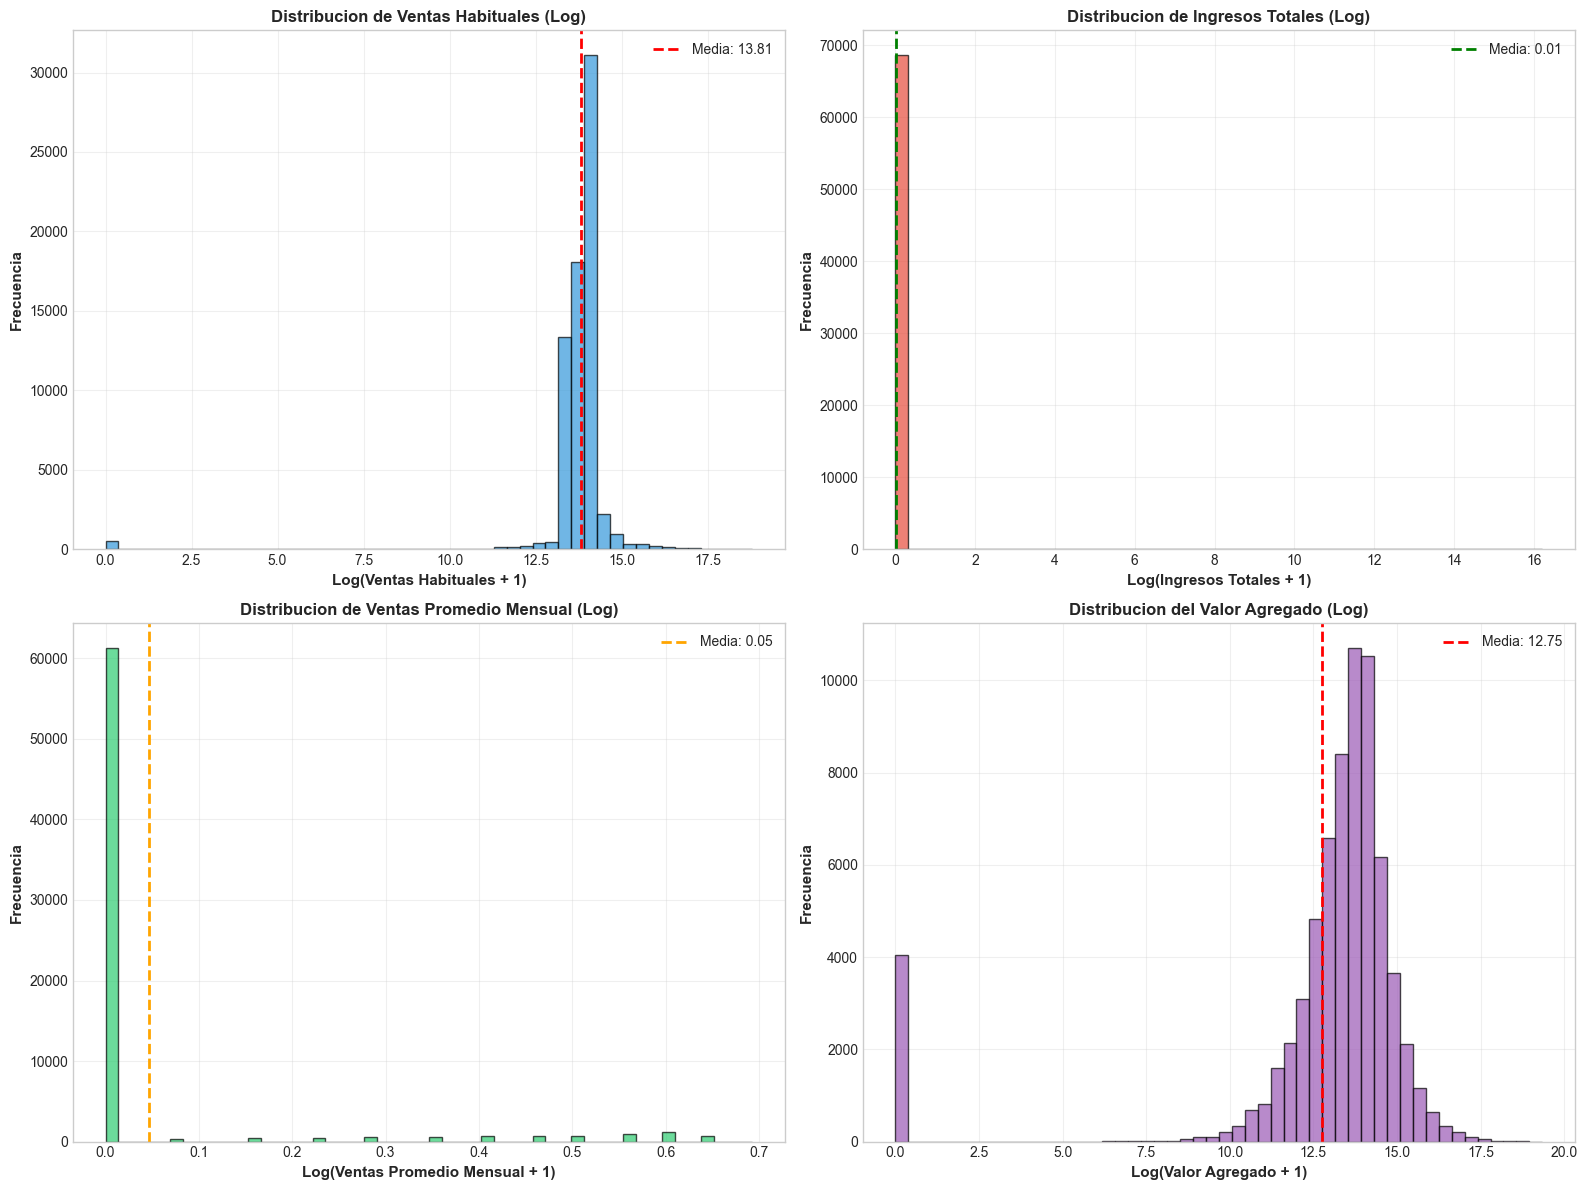

   Guardado: eda_ventas_01_histogramas_log.png

2. Boxplots por sector...
   Advertencia: No se pudo generar boxplots por sector

3. Ventas por departamento...


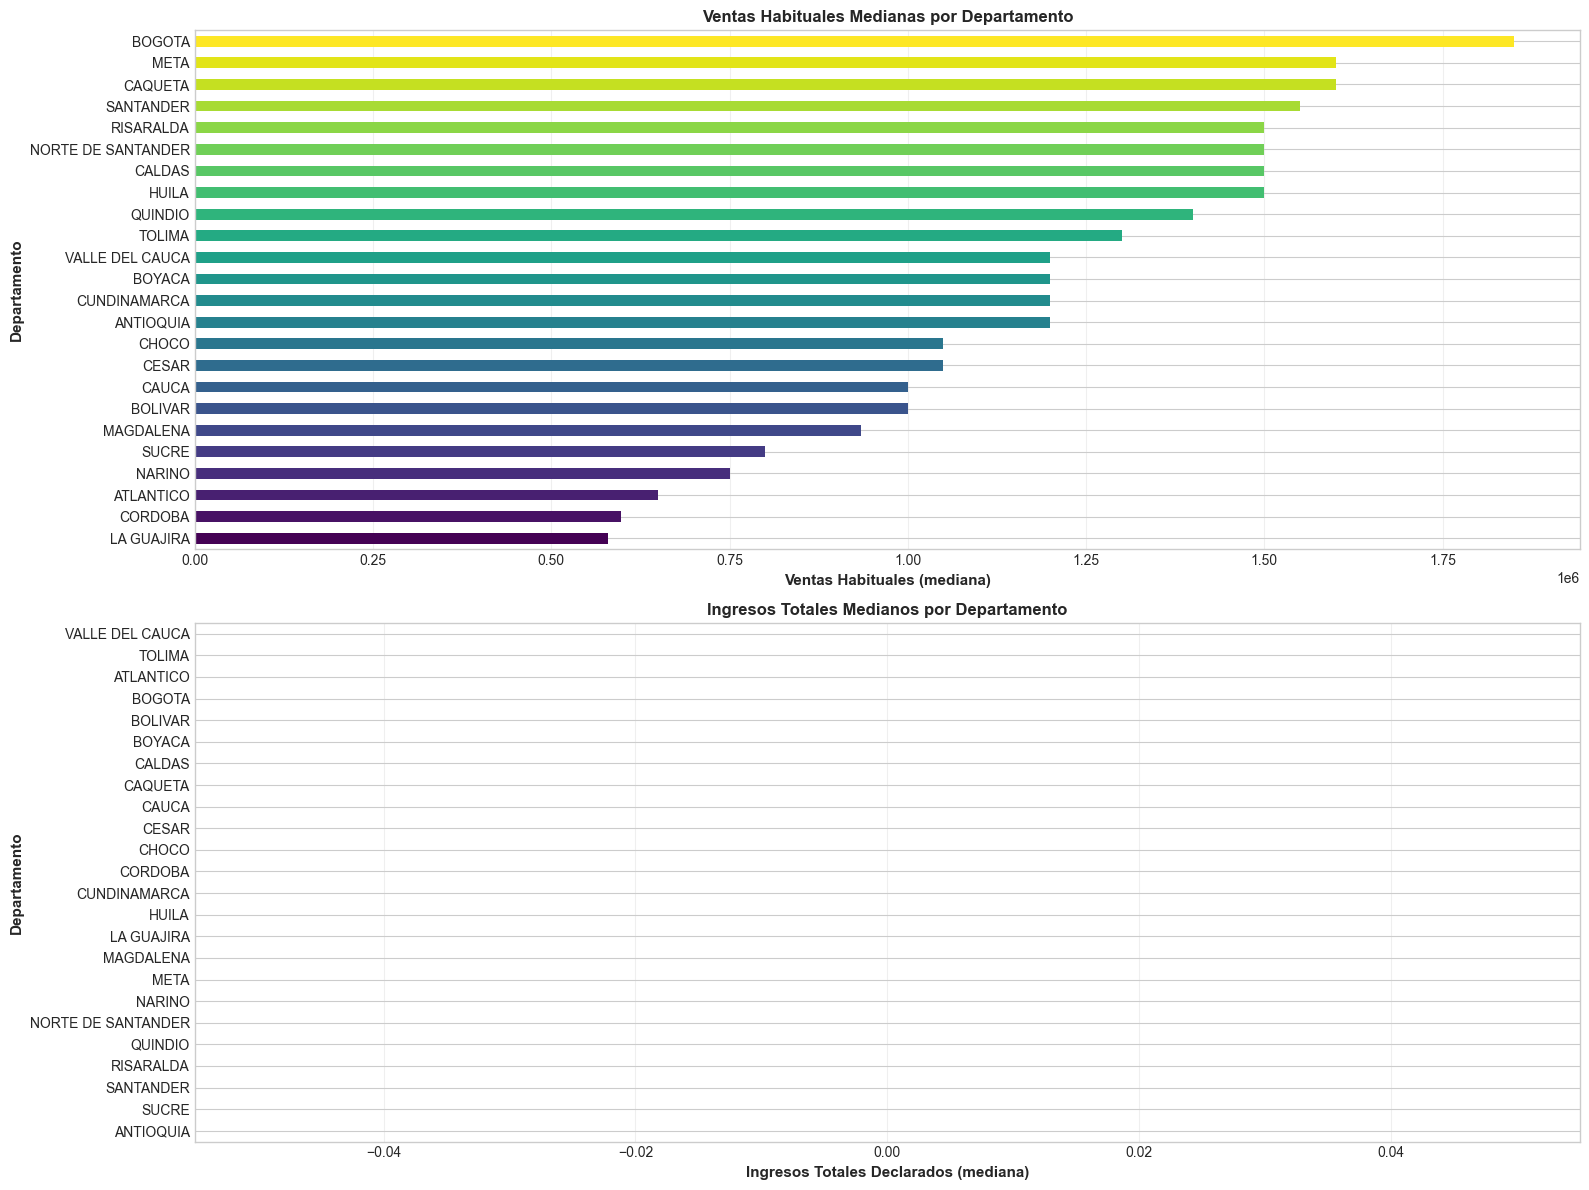

   Guardado: eda_ventas_03_ventas_departamento.png

4. Estacionalidad y metodos de pago...


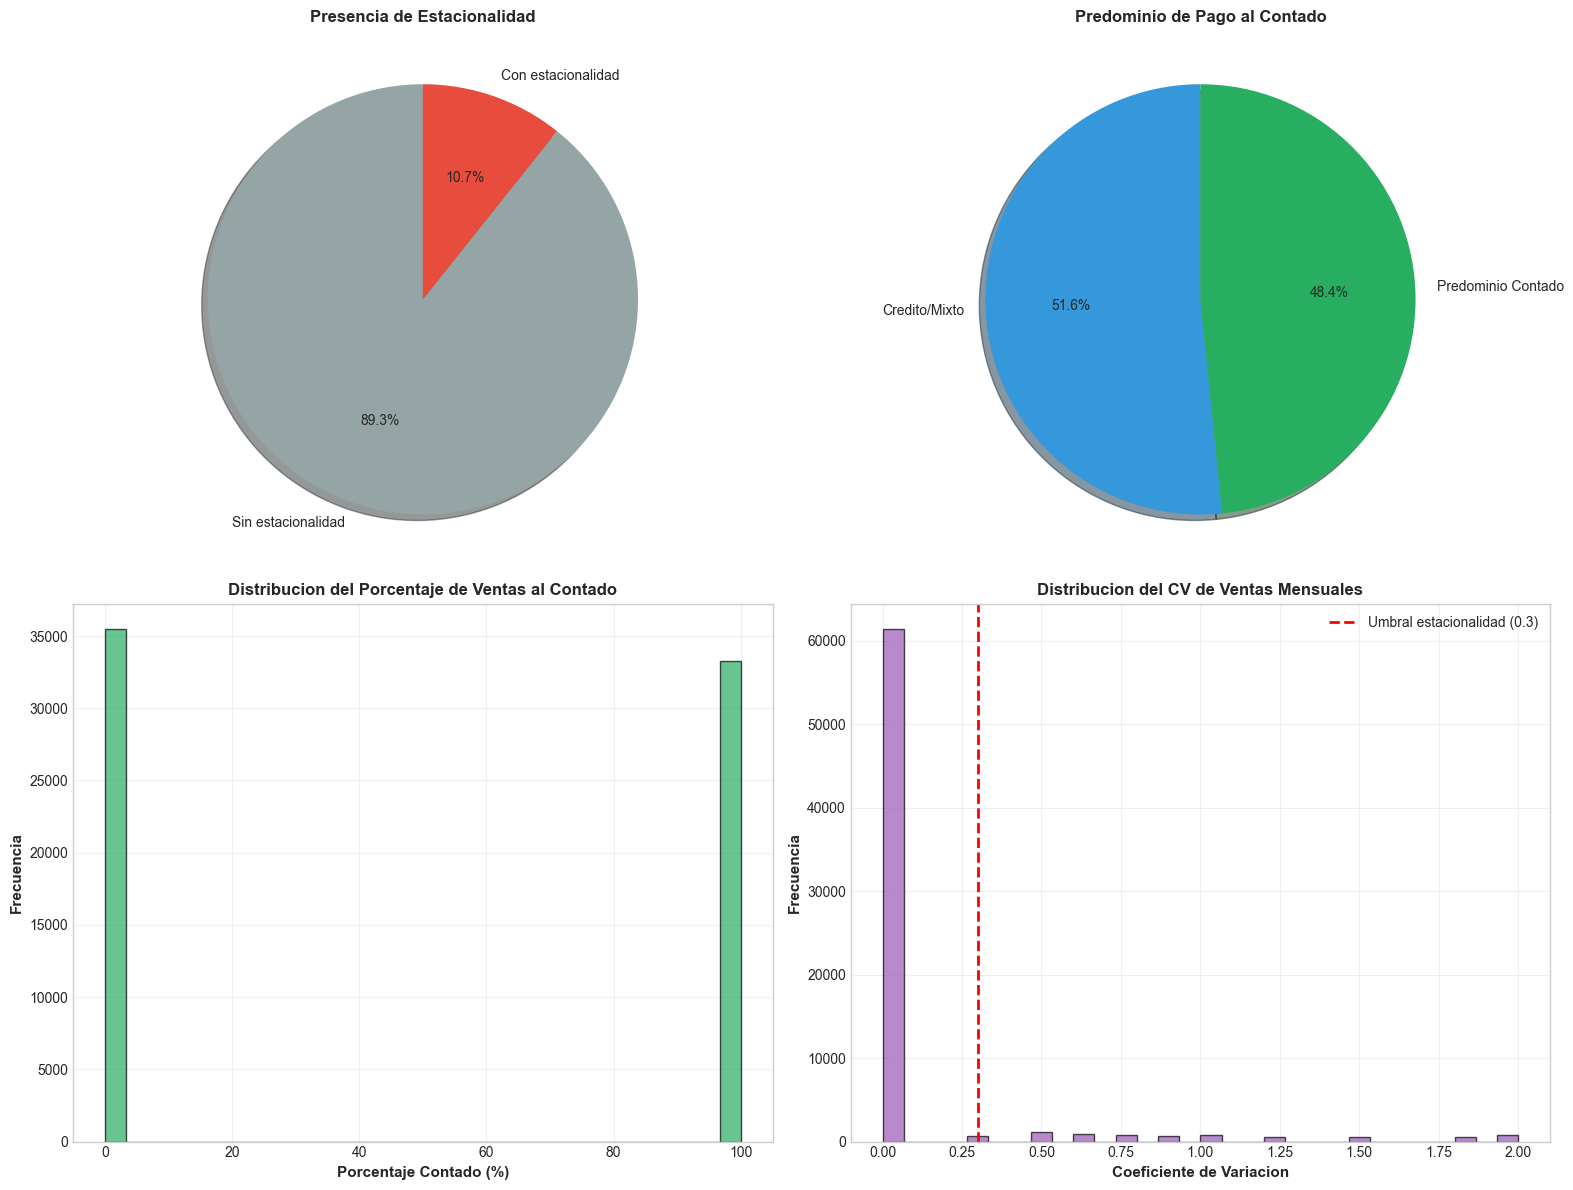

   Guardado: eda_ventas_04_estacionalidad_pago.png

5. Intensidad operativa y crecimiento...


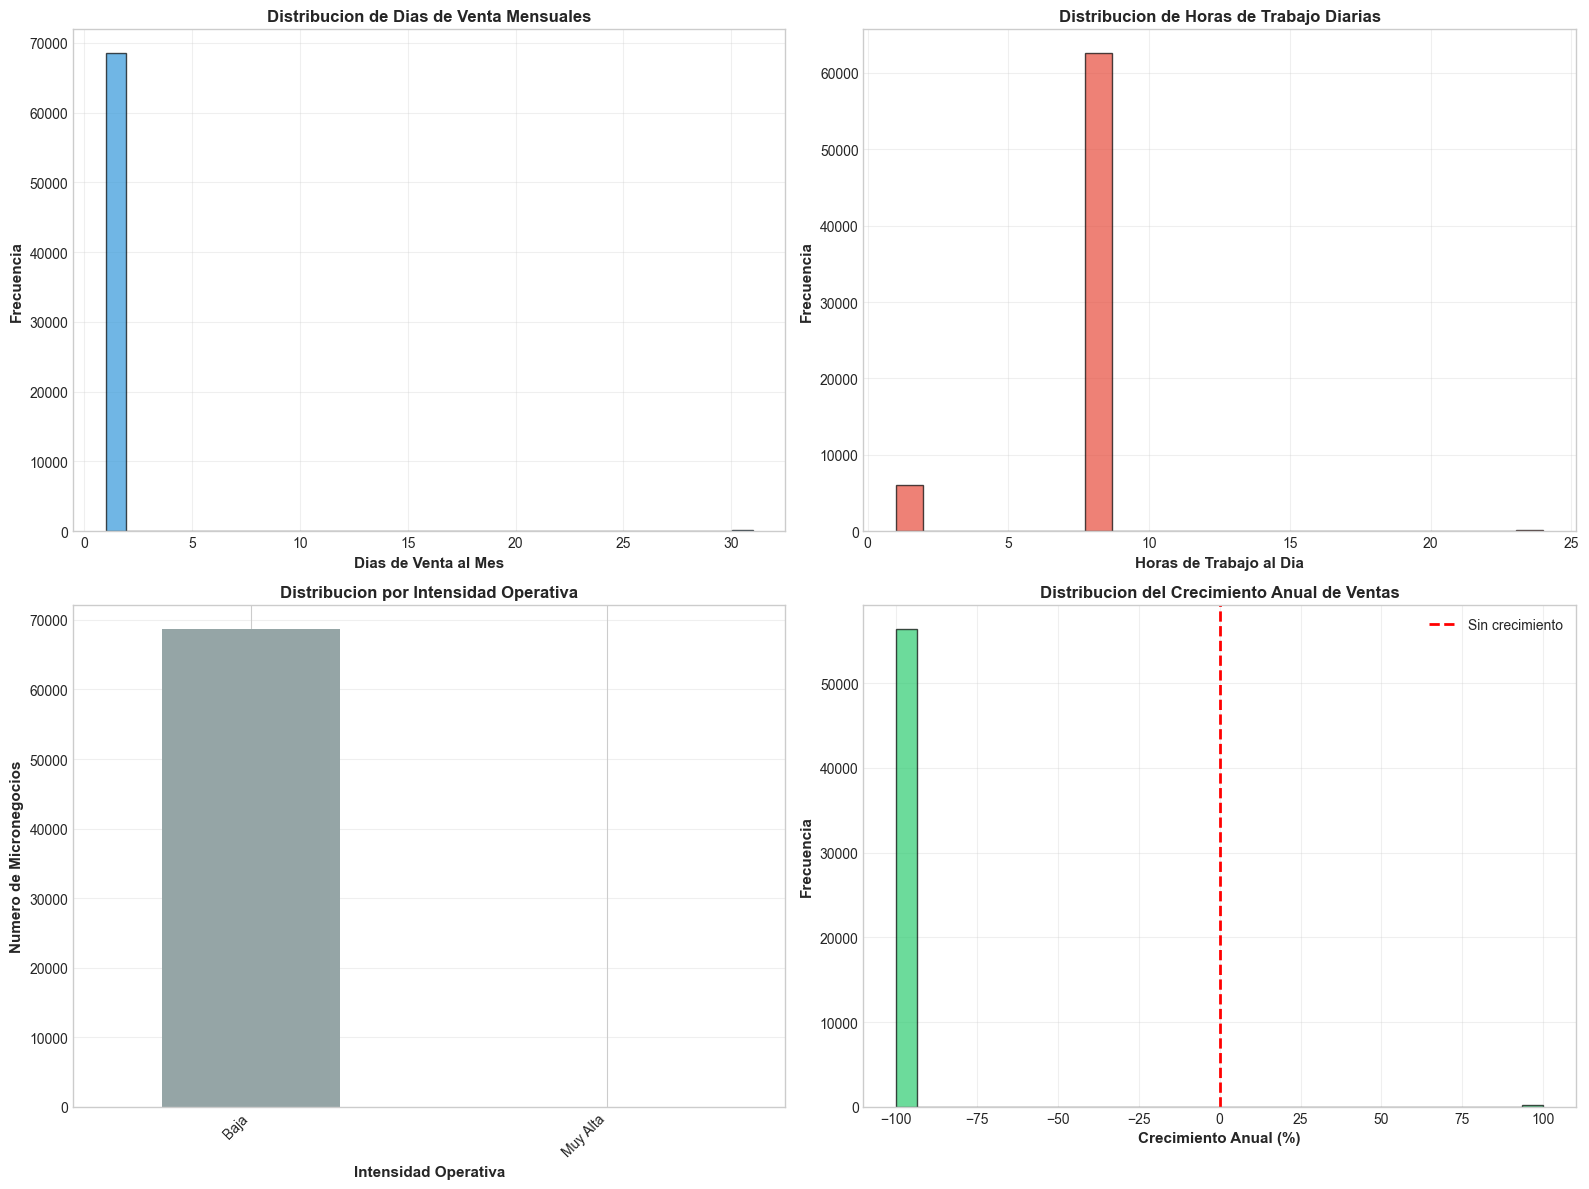

   Guardado: eda_ventas_05_intensidad_crecimiento.png

EDA COMPLETADO

Visualizaciones generadas:
1. eda_ventas_01_histogramas_log.png
2. eda_ventas_02_boxplots_sector.png
3. eda_ventas_03_ventas_departamento.png
4. eda_ventas_04_estacionalidad_pago.png
5. eda_ventas_05_intensidad_crecimiento.png

Insight: Base para variable objetivo futura
- Ventas con estacionalidad: 10.7%
- Predominio contado: 48.4%


In [17]:

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*80)
print("ANALISIS EXPLORATORIO - MODULO DE VENTAS E INGRESOS")
print("="*80)

df = pd.read_csv('LIMPIOS/ventas_ingresos_limpio.csv')
print(f"\nDataset: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# VIZ 1: HISTOGRAMAS ESCALA LOG
print("\n1. Histogramas (escala log)...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Ventas habituales
ax1 = axes[0, 0]
data1 = df['ventas_habituales_log'].dropna()
ax1.hist(data1, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(data1.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Media: {data1.mean():.2f}')
ax1.set_xlabel('Log(Ventas Habituales + 1)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax1.set_title('Distribucion de Ventas Habituales (Log)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Grafico 2: Ingresos totales
ax2 = axes[0, 1]
data2 = df['ingresos_totales_declarados_log'].dropna()
ax2.hist(data2, bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.axvline(data2.mean(), color='green', linestyle='--', linewidth=2,
            label=f'Media: {data2.mean():.2f}')
ax2.set_xlabel('Log(Ingresos Totales + 1)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax2.set_title('Distribucion de Ingresos Totales (Log)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Grafico 3: Ventas promedio mensual
ax3 = axes[1, 0]
data3 = df['ventas_promedio_mensual_log'].dropna()
ax3.hist(data3, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
ax3.axvline(data3.mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Media: {data3.mean():.2f}')
ax3.set_xlabel('Log(Ventas Promedio Mensual + 1)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax3.set_title('Distribucion de Ventas Promedio Mensual (Log)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Grafico 4: Valor agregado
ax4 = axes[1, 1]
data4 = df['valor_agregado_log'].dropna()
ax4.hist(data4, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
ax4.axvline(data4.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Media: {data4.mean():.2f}')
ax4.set_xlabel('Log(Valor Agregado + 1)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax4.set_title('Distribucion del Valor Agregado (Log)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_ventas_01_histogramas_log.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_ventas_01_histogramas_log.png")
plt.close()

# VIZ 2: BOXPLOTS POR SECTOR
print("\n2. Boxplots por sector...")

# Primero merge con modulo de caracteristicas para obtener sector
try:
    df_caract = pd.read_csv('LIMPIOS/Mo_dulo_de_caracteri_sticas_del_micronegocio.csv')
    df_merged = df.merge(df_caract[['id_micronegocio', 'sector_economico']], 
                         on='id_micronegocio', how='left')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top 8 sectores
    top_sectores = df_merged['sector_economico'].value_counts().head(8).index
    df_sector = df_merged[df_merged['sector_economico'].isin(top_sectores)]
    
    # Boxplot 1: Ventas habituales
    ax1 = axes[0, 0]
    df_sector.boxplot(column='ventas_habituales_log', by='sector_economico', ax=ax1)
    ax1.set_xlabel('Sector Economico', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Log(Ventas Habituales)', fontsize=11, fontweight='bold')
    ax1.set_title('Ventas Habituales por Sector', fontsize=12, fontweight='bold')
    ax1.get_figure().suptitle('')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Boxplot 2: Ingresos totales
    ax2 = axes[0, 1]
    df_sector.boxplot(column='ingresos_totales_declarados_log', by='sector_economico', ax=ax2)
    ax2.set_xlabel('Sector Economico', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Log(Ingresos Totales)', fontsize=11, fontweight='bold')
    ax2.set_title('Ingresos Totales por Sector', fontsize=12, fontweight='bold')
    ax2.get_figure().suptitle('')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Boxplot 3: Clientes promedio
    ax3 = axes[1, 0]
    df_sector.boxplot(column='clientes_promedio', by='sector_economico', ax=ax3)
    ax3.set_xlabel('Sector Economico', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Clientes Promedio', fontsize=11, fontweight='bold')
    ax3.set_title('Clientes Promedio por Sector', fontsize=12, fontweight='bold')
    ax3.get_figure().suptitle('')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Boxplot 4: Horas mensuales
    ax4 = axes[1, 1]
    df_sector.boxplot(column='horas_mensuales', by='sector_economico', ax=ax4)
    ax4.set_xlabel('Sector Economico', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Horas Mensuales', fontsize=11, fontweight='bold')
    ax4.set_title('Intensidad Operativa por Sector', fontsize=12, fontweight='bold')
    ax4.get_figure().suptitle('')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('LIMPIOS/eda_ventas_02_boxplots_sector.png', dpi=300, bbox_inches='tight')
    print("   Guardado: eda_ventas_02_boxplots_sector.png")
    plt.show()
    plt.close()
except:
    print("   Advertencia: No se pudo generar boxplots por sector")

# VIZ 3: VENTAS POR DEPARTAMENTO
print("\n3. Ventas por departamento...")
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Grafico 1: Ventas promedio por departamento
ax1 = axes[0]
ventas_dept = df.groupby('nombre_departamento')['ventas_habituales'].median().sort_values(ascending=True)
colors1 = plt.cm.viridis(np.linspace(0, 1, len(ventas_dept)))
ventas_dept.plot(kind='barh', ax=ax1, color=colors1)
ax1.set_xlabel('Ventas Habituales (mediana)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Departamento', fontsize=11, fontweight='bold')
ax1.set_title('Ventas Habituales Medianas por Departamento', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Grafico 2: Ingresos totales por departamento
ax2 = axes[1]
ingresos_dept = df.groupby('nombre_departamento')['ingresos_totales_declarados'].median().sort_values(ascending=True)
colors2 = plt.cm.plasma(np.linspace(0, 1, len(ingresos_dept)))
ingresos_dept.plot(kind='barh', ax=ax2, color=colors2)
ax2.set_xlabel('Ingresos Totales Declarados (mediana)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Departamento', fontsize=11, fontweight='bold')
ax2.set_title('Ingresos Totales Medianos por Departamento', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_ventas_03_ventas_departamento.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_ventas_03_ventas_departamento.png")
plt.close()

# VIZ 4: ESTACIONALIDAD Y METODOS DE PAGO
print("\n4. Estacionalidad y metodos de pago...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Estacionalidad
ax1 = axes[0, 0]
if 'tiene_estacionalidad' in df.columns:
    est_counts = df['tiene_estacionalidad'].value_counts()
    labels = ['Sin estacionalidad', 'Con estacionalidad']
    colors_est = ['#95a5a6', '#e74c3c']
    ax1.pie([est_counts.get(0, 0), est_counts.get(1, 0)], labels=labels,
            autopct='%1.1f%%', colors=colors_est, startangle=90, shadow=True)
    ax1.set_title('Presencia de Estacionalidad', fontsize=12, fontweight='bold')

# Grafico 2: Predominio contado
ax2 = axes[0, 1]
if 'predominio_contado' in df.columns:
    contado_counts = df['predominio_contado'].value_counts()
    labels2 = ['Credito/Mixto', 'Predominio Contado']
    colors_cont = ['#3498db', '#27ae60']
    ax2.pie([contado_counts.get(0, 0), contado_counts.get(1, 0)], labels=labels2,
            autopct='%1.1f%%', colors=colors_cont, startangle=90, shadow=True)
    ax2.set_title('Predominio de Pago al Contado', fontsize=12, fontweight='bold')

# Grafico 3: Distribucion porcentaje contado
ax3 = axes[1, 0]
ax3.hist(df['porcentaje_contado'].dropna(), bins=30, color='#27ae60', 
         edgecolor='black', alpha=0.7)
ax3.set_xlabel('Porcentaje Contado (%)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax3.set_title('Distribucion del Porcentaje de Ventas al Contado', 
              fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# Grafico 4: Coeficiente de variacion
ax4 = axes[1, 1]
if 'cv_ventas' in df.columns:
    cv_data = df['cv_ventas'].clip(0, 2).dropna()
    ax4.hist(cv_data, bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
    ax4.axvline(0.3, color='red', linestyle='--', linewidth=2,
                label='Umbral estacionalidad (0.3)')
    ax4.set_xlabel('Coeficiente de Variacion', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
    ax4.set_title('Distribucion del CV de Ventas Mensuales', 
                  fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_ventas_04_estacionalidad_pago.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_ventas_04_estacionalidad_pago.png")
plt.close()

# VIZ 5: INTENSIDAD OPERATIVA Y CRECIMIENTO
print("\n5. Intensidad operativa y crecimiento...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Dias de venta
ax1 = axes[0, 0]
ax1.hist(df['dias_venta_mes'].dropna(), bins=31, color='#3498db',
         edgecolor='black', alpha=0.7)
ax1.set_xlabel('Dias de Venta al Mes', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax1.set_title('Distribucion de Dias de Venta Mensuales', 
              fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# Grafico 2: Horas de trabajo
ax2 = axes[0, 1]
ax2.hist(df['horas_trabajo_dia'].dropna(), bins=24, color='#e74c3c',
         edgecolor='black', alpha=0.7)
ax2.set_xlabel('Horas de Trabajo al Dia', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax2.set_title('Distribucion de Horas de Trabajo Diarias',
              fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

# Grafico 3: Intensidad operativa
ax3 = axes[1, 0]
if 'intensidad_operativa' in df.columns:
    intens_counts = df['intensidad_operativa'].value_counts()
    colors_int = ['#95a5a6', '#3498db', '#f39c12', '#e74c3c']
    intens_counts.plot(kind='bar', ax=ax3, color=colors_int[:len(intens_counts)])
    ax3.set_xlabel('Intensidad Operativa', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Numero de Micronegocios', fontsize=11, fontweight='bold')
    ax3.set_title('Distribucion por Intensidad Operativa',
                  fontsize=12, fontweight='bold')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    ax3.grid(axis='y', alpha=0.3)

# Grafico 4: Crecimiento anual
ax4 = axes[1, 1]
if 'crecimiento_anual' in df.columns:
    crec_data = df['crecimiento_anual'].clip(-100, 200).dropna()
    ax4.hist(crec_data, bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
    ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Sin crecimiento')
    ax4.set_xlabel('Crecimiento Anual (%)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
    ax4.set_title('Distribucion del Crecimiento Anual de Ventas',
                  fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('LIMPIOS/eda_ventas_05_intensidad_crecimiento.png', dpi=300, bbox_inches='tight')
print("   Guardado: eda_ventas_05_intensidad_crecimiento.png")
plt.close()

print("\n" + "="*80)
print("EDA COMPLETADO")
print("="*80)
print("\nVisualizaciones generadas:")
print("1. eda_ventas_01_histogramas_log.png")
print("2. eda_ventas_02_boxplots_sector.png")
print("3. eda_ventas_03_ventas_departamento.png")
print("4. eda_ventas_04_estacionalidad_pago.png")
print("5. eda_ventas_05_intensidad_crecimiento.png")
print("\nInsight: Base para variable objetivo futura")
print(f"- Ventas con estacionalidad: {df['tiene_estacionalidad'].mean()*100:.1f}%")
print(f"- Predominio contado: {df['predominio_contado'].mean()*100:.1f}%")
print("="*80)

### Módulo: Costos, Gastos y Activos (EMICRON 2024)

| **Código DANE**        | **Nombre analítico**        | **Interpretación en el TFM**                                  | **Tipo de preparación / limpieza** |
|------------------------|-----------------------------|----------------------------------------------------------------|------------------------------------|
| P3056_A                | costo_materia_prima         | Costo principal de producción del micronegocio.               | Log(1+x) + winsorización           |
| P3056_B                | costo_insumos               | Costos indirectos de operación.                                | Log(1+x)                           |
| P3056_C                | costo_energia               | Gasto energético asociado a la actividad productiva.          | Log(1+x)                           |
| P3056_D                | costo_transporte            | Costos logísticos del negocio.                                 | Log(1+x)                           |
| P3056_E                | otros_costos                | Costos no clasificados explícitamente.                         | Winsorización                      |
| P3057_A                | gasto_arriendo              | Costo fijo por uso del local.                                  | Log(1+x)                           |
| P3057_B                | gasto_servicios             | Servicios públicos del micronegocio.                           | Log(1+x)                           |
| P3057_C                | gasto_comunicaciones        | Telefonía, internet y comunicaciones.                          | Log(1+x)                           |
| P3057_D                | gasto_mantenimiento         | Conservación y reparación de activos.                          | Log(1+x)                           |
| P3057_E                | otros_gastos                | Gastos operativos diversos.                                    | Winsorización                      |
| P3017_A – P3017_K      | activos_productivos         | Infraestructura productiva del negocio.                        | Agregación + Log(1+x)              |
| P3017_L                | activo_total                | Capacidad productiva acumulada del micronegocio.               | Log(1+x)                           |
| P3018_1 – P3018_7      | tipos_inventario            | Estructura de inventarios disponibles.                          | Codificación binaria               |
| P3018_A – P3018_F      | valor_inventarios           | Capital de trabajo inmovilizado en inventarios.                | Log(1+x)                           |
| P3019                  | costos_totales              | Suma de costos productivos del micronegocio.                   | Log(1+x)                           |
| COSTOS_MES_ANTERIOR    | costos_mes_anterior         | Tendencia inmediata de los costos.                             | Log(1+x)                           |
| COSTOS_ANIO_ANTERIOR   | costos_anio_anterior        | Evolución estructural de los costos.                            | Log(1+x)                           |
| GASTOS_MES             | gastos_mensuales            | Presión financiera mensual del negocio.                        | Log(1+x)                           |
| CONSUMO_INTERMEDIO     | consumo_intermedio          | Insumos utilizados directamente en producción.                 | Log(1+x)                           |
| CLASE_TE               | clase_territorial           | Diferenciación urbano–rural ampliada.                           | Codificación categórica            |
| COD_DEPTO              | codigo_departamento         | Segmentación regional del micronegocio.                        | Target encoding                    |
| AREA                   | area                         | Ubicación urbana o rural.                                      | Codificación binaria               |
| F_EXP                  | factor_expansion            | Factor de expansión poblacional de la encuesta.                | **No usado en ML**                 |
### Notas metodológicas (TFM)

- Las transformaciones **Log(1 + x)** se aplican a las variables monetarias con el fin de reducir la asimetría de las distribuciones y mitigar problemas de heterocedasticidad, favoreciendo la estabilidad de los modelos de aprendizaje automático.

- La **winsorización** se utiliza para controlar la influencia de valores extremos sin eliminar observaciones, preservando así la representatividad estadística de los micronegocios analizados.

- Las variables asociadas a **activos productivos** se agregan para construir un indicador sintético que represente la capacidad productiva del micronegocio, reduciendo la dimensionalidad y mejorando la interpretabilidad.

- El **factor de expansión (F_EXP)** se conserva exclusivamente para análisis descriptivos e inferenciales a nivel poblacional y **no se incorpora en el entrenamiento de los modelos de Machine Learning**, con el fin de evitar sesgos artificiales.

- Este módulo resulta fundamental para explicar dimensiones clave del desempeño económico del micronegocio, tales como la **rentabilidad**, la **presión financiera** y la **eficiencia productiva**.



In [17]:



INPUT = 'ORIGINALES/Módulo de costos, gastos y activos.csv'
OUTPUT = 'LIMPIOS/costos_gastos_activos_limpio.csv'

RENAME_DICT = {
    "DIRECTORIO": "id_micronegocio", "SECUENCIA_P": "id_persona", "SECUENCIA_ENCUESTA": "id_encuesta",
    "P3056_A": "costo_materia_prima", "P3056_B": "costo_insumos", "P3056_C": "costo_energia",
    "P3056_D": "costo_transporte", "P3056_E": "otros_costos_operativos",
    "P3057_A": "gasto_arriendo", "P3057_B": "gasto_servicios", "P3057_C": "gasto_comunicaciones",
    "P3057_D": "gasto_mantenimiento", "P3057_E": "otros_gastos_operativos",
    "P3017_A": "activo_maquinaria", "P3017_B": "activo_herramientas", "P3017_C": "activo_equipo_oficina",
    "P3017_D": "activo_vehiculos", "P3017_E": "activo_tecnologia", "P3017_F": "activo_muebles",
    "P3017_G": "activo_inmuebles", "P3017_H": "activo_inventarios", "P3017_I": "activo_intangibles",
    "P3017_J": "activo_financiero", "P3017_K": "activo_otros", "P3017_L": "activo_total",
    "P3018_1": "tiene_inv_materia_prima", "P3018_2": "tiene_inv_proceso", "P3018_3": "tiene_inv_terminados",
    "P3018_4": "tiene_inv_mercancias", "P3018_5": "tiene_inv_repuestos", "P3018_6": "tiene_inv_insumos",
    "P3018_7": "tiene_inv_otros",
    "P3018_A": "valor_inv_materia_prima", "P3018_B": "valor_inv_proceso", "P3018_C": "valor_inv_terminados",
    "P3018_D": "valor_inv_mercancias", "P3018_E": "valor_inv_repuestos", "P3018_F": "valor_inv_insumos",
    "P3019": "costos_totales", "COSTOS_MES_ANTERIOR": "costos_mes_anterior",
    "COSTOS_ANIO_ANTERIOR": "costos_anio_anterior", "GASTOS_MES": "gastos_mes",
    "CONSUMO_INTERMEDIO": "consumo_intermedio",
    "CLASE_TE": "clase_territorial", "COD_DEPTO": "codigo_departamento", "AREA": "area", "F_EXP": "factor_expansion"
}

DEPARTAMENTOS = {
    5: 'ANTIOQUIA', 8: 'ATLANTICO', 11: 'BOGOTA', 13: 'BOLIVAR', 15: 'BOYACA', 17: 'CALDAS',
    18: 'CAQUETA', 19: 'CAUCA', 20: 'CESAR', 23: 'CORDOBA', 25: 'CUNDINAMARCA', 27: 'CHOCO',
    41: 'HUILA', 44: 'LA GUAJIRA', 47: 'MAGDALENA', 50: 'META', 52: 'NARINO',
    54: 'NORTE DE SANTANDER', 63: 'QUINDIO', 66: 'RISARALDA', 68: 'SANTANDER',
    70: 'SUCRE', 73: 'TOLIMA', 76: 'VALLE DEL CAUCA', 81: 'ARAUCA'
}

print("="*80)
print("LIMPIEZA MODULO DE COSTOS, GASTOS Y ACTIVOS")
print("="*80)

print("\nPASO 1: Cargando...")
df = pd.read_csv(INPUT, encoding='latin-1')
filas_inicial = df.shape[0]
print(f"Filas: {filas_inicial:,}, Columnas: {df.shape[1]}")

print("\nPASO 2: Renombrando...")
df = df.rename(columns={k: v for k, v in RENAME_DICT.items() if k in df.columns})
print(f"Variables renombradas: {len([k for k in RENAME_DICT.keys() if k in df.columns])}")

print("\nPASO 3: Imputando...")
missing_antes = df.isnull().sum().sum()

# Area
if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode()) > 0 else 1))

# Costos y gastos con 0
vars_monetarias = [c for c in df.columns if c.startswith('costo_') or c.startswith('gasto_') or 
                   c.startswith('activo_') or c.startswith('valor_inv_')]
for col in vars_monetarias:
    df[col] = df[col].fillna(0)

# Variables binarias
vars_binarias = [c for c in df.columns if c.startswith('tiene_inv_')]
for col in vars_binarias:
    df[col] = df[col].fillna(0)

# Otras monetarias
for col in ['costos_totales', 'costos_mes_anterior', 'costos_anio_anterior', 'gastos_mes', 'consumo_intermedio']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

missing_despues = df.isnull().sum().sum()
print(f"Valores perdidos: {missing_antes:,} -> {missing_despues:,}")

print("\nPASO 4: Winsorizando...")
vars_wins = ['otros_costos_operativos', 'otros_gastos_operativos', 'activo_otros']
for col in vars_wins:
    if col in df.columns:
        p1, p99 = df[col].quantile(0.01), df[col].quantile(0.99)
        df[f'{col}_wins'] = df[col].clip(p1, p99)

print("\nPASO 5: Transformaciones log...")
vars_log = vars_monetarias + ['costos_totales', 'gastos_mes', 'consumo_intermedio',
                               'costos_mes_anterior', 'costos_anio_anterior']
for col in vars_log:
    if col in df.columns:
        df[f'{col}_log'] = np.log1p(df[col].clip(lower=0))

print("\nPASO 6: Duplicados...")
df = df.drop_duplicates()
if 'id_micronegocio' in df.columns:
    df = df.drop_duplicates(subset=['id_micronegocio'], keep='first')
filas_final = len(df)
print(f"Eliminados: {filas_inicial - filas_final:,}")

print("\nPASO 7: Variables derivadas...")
if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPARTAMENTOS)
if 'area' in df.columns:
    df['area_urbana'] = (df['area'] == 1).astype(int)

# Costos totales calculados
cols_costos = [c for c in df.columns if c.startswith('costo_') and not c.endswith('_log') and not c.endswith('_wins')]
if cols_costos:
    df['costos_totales_calc'] = df[cols_costos].sum(axis=1)
    df['costos_totales_calc_log'] = np.log1p(df['costos_totales_calc'])

# Gastos totales calculados
cols_gastos = [c for c in df.columns if c.startswith('gasto_') and not c.endswith('_log')]
if cols_gastos:
    df['gastos_totales_calc'] = df[cols_gastos].sum(axis=1)
    df['gastos_totales_calc_log'] = np.log1p(df['gastos_totales_calc'])

# Activos totales calculados
cols_activos = [c for c in df.columns if c.startswith('activo_') and c != 'activo_total' 
                and not c.endswith('_log') and not c.endswith('_wins')]
if cols_activos:
    df['activos_totales_calc'] = df[cols_activos].sum(axis=1)
    df['activos_totales_calc_log'] = np.log1p(df['activos_totales_calc'])

# Inventario total
cols_inv = [c for c in df.columns if c.startswith('valor_inv_') and not c.endswith('_log')]
if cols_inv:
    df['inventario_total'] = df[cols_inv].sum(axis=1)
    df['inventario_total_log'] = np.log1p(df['inventario_total'])
    df['tiene_inventario'] = (df['inventario_total'] > 0).astype(int)

# Carga operativa
if 'costos_totales_calc' in df.columns and 'gastos_totales_calc' in df.columns:
    df['carga_operativa'] = df['costos_totales_calc'] + df['gastos_totales_calc']
    df['carga_operativa_log'] = np.log1p(df['carga_operativa'])

# Intensidad de activos
cols_activos_prod = ['activo_maquinaria', 'activo_herramientas', 'activo_tecnologia']
if all(c in df.columns for c in cols_activos_prod):
    df['activos_productivos'] = df[cols_activos_prod].sum(axis=1)
    df['activos_productivos_log'] = np.log1p(df['activos_productivos'])

print("\nPASO 8: Guardando...")
cols_mantener = [c for c in df.columns if not (c.endswith('_wins') and c + '_log' in df.columns)]
df = df[cols_mantener]
df.to_csv(OUTPUT, index=False, encoding='utf-8-sig')

print("\n" + "="*80)
print("RESUMEN")
print("="*80)
print(f"Filas: {filas_inicial:,} -> {filas_final:,}")
print(f"Columnas: {len(df.columns)}")
print(f"Completitud: {(1-df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))*100:.2f}%")
if 'tiene_inventario' in df.columns:
    print(f"Con inventario: {df['tiene_inventario'].mean()*100:.1f}%")
print("="*80)

LIMPIEZA MODULO DE COSTOS, GASTOS Y ACTIVOS

PASO 1: Cargando...
Filas: 78,501, Columnas: 47

PASO 2: Renombrando...
Variables renombradas: 0

PASO 3: Imputando...
Valores perdidos: 1,601,889 -> 156,990

PASO 4: Winsorizando...

PASO 5: Transformaciones log...

PASO 6: Duplicados...
Eliminados: 9,799

PASO 7: Variables derivadas...

PASO 8: Guardando...

RESUMEN
Filas: 78,501 -> 68,702
Columnas: 96
Completitud: 95.83%
Con inventario: 12.6%


### Analisis exploratorio Modulo Costos, Gastos y Activos

#### Costos vs Ventas
- Analisis mediante boxplots de costos, gastos y carga operativa por quintiles de ventas.
- Grafico de dispersion que evidencia una relacion positiva clara entre costos y gastos.

#### Ratio Costos sobre Ventas
- La distribucion del ratio costos ventas se concentra alrededor de una mediana de 0.32.
- Los departamentos de Norte de Santander, Atlantico y Boyaca presentan los mayores ratios.
- No se observan diferencias significativas entre zonas rurales y urbanas.
- El margen bruto promedio es del 68 por ciento, con una distribucion sesgada a la derecha.

#### Activos vs Ingresos
- Grafico de dispersion con codificacion por colores segun el ratio activos ingresos.
- La mayor proporcion de activos corresponde a maquinaria, aproximadamente el 55 por ciento.
- Se observa alta productividad, ya que la mayoria de micronegocios generan ingresos superiores al valor de sus activos.

#### Estructura Financiera
- La estructura de costos esta dominada por materia prima con un 55 por ciento, seguida de insumos con un 28 por ciento.
- En los gastos operativos predomina el arriendo con un 57 por ciento y los servicios con un 29 por ciento.
- Los inventarios muestran mayor presencia de productos en proceso.
- La carga operativa es similar tanto en micronegocios con inventario como sin inventario.

#### Eficiencia Productiva
- Existe una alta concentracion de micronegocios con eficiencia operativa cercana a cero.
- El departamento del Valle del Cauca lidera los niveles de eficiencia productiva.
- La intensidad de capital se concentra mayoritariamente alrededor de un valor de cinco.

### Insights clave
- El ratio costos ventas cercano a 0.32 indica una elevada eficiencia operativa.
- El margen bruto promedio del 68 por ciento refleja una alta capacidad de generacion de valor.
- Solo el 12.6 por ciento de los micronegocios mantiene inventarios, lo que sugiere baja inmovilizacion de capital.
- La maquinaria domina la estructura de activos, caracterizando al sector como intensivo en produccion.


In [5]:

"""
SCRIPT COMPLETO: LIMPIEZA + EDA CON VISUALIZACIÓN
Módulo de Costos, Gastos y Activos
*** Muestra gráficos con plt.show() ***
"""
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

print("="*80)
print("PROCESO COMPLETO: LIMPIEZA + EDA")
print("="*80)

# =============================================================================
# PARTE 1: LIMPIEZA DE DATOS
# =============================================================================
print("\n" + "="*80)
print("PARTE 1: LIMPIEZA DE DATOS")
print("="*80)

INPUT_FILE = 'ORIGINALES/Módulo de costos, gastos y activos.csv'
OUTPUT_DIR = 'LIMPIOS'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Cargar datos originales
print("\n[1/10] Cargando archivo original...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
print(f"   Cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# Renombrar columnas
print("\n[2/10] Renombrando columnas...")
RENAME = {
    "DIRECTORIO": "id_micronegocio", "SECUENCIA_P": "id_persona", "SECUENCIA_ENCUESTA": "id_encuesta",
    "P3056_A": "costo_materia_prima", "P3056_B": "costo_insumos", "P3056_C": "costo_energia",
    "P3056_D": "costo_transporte", "P3056_E": "otros_costos",
    "P3057_A": "gasto_arriendo", "P3057_B": "gasto_servicios", "P3057_C": "gasto_comunicaciones",
    "P3057_D": "gasto_mantenimiento", "P3057_E": "otros_gastos",
    "P3017_A": "activo_maquinaria", "P3017_B": "activo_herramientas", "P3017_C": "activo_equipo",
    "P3017_D": "activo_vehiculos", "P3017_E": "activo_tecnologia", "P3017_F": "activo_muebles",
    "P3017_G": "activo_inmuebles", "P3017_H": "activo_inventarios", "P3017_I": "activo_intangibles",
    "P3017_J": "activo_financiero", "P3017_K": "activo_otros", "P3017_L": "activo_total",
    "P3018_1": "tiene_inv_mp", "P3018_2": "tiene_inv_proceso", "P3018_3": "tiene_inv_terminados",
    "P3018_4": "tiene_inv_mercancias", "P3018_5": "tiene_inv_repuestos", "P3018_6": "tiene_inv_insumos",
    "P3018_7": "tiene_inv_otros",
    "P3018_A": "valor_inv_mp", "P3018_B": "valor_inv_proceso", "P3018_C": "valor_inv_terminados",
    "P3018_D": "valor_inv_mercancias", "P3018_E": "valor_inv_repuestos", "P3018_F": "valor_inv_insumos",
    "P3019": "costos_totales", "COSTOS_MES_ANTERIOR": "costos_mes_anterior",
    "COSTOS_ANIO_ANTERIOR": "costos_anio_anterior", "GASTOS_MES": "gastos_mes",
    "CONSUMO_INTERMEDIO": "consumo_intermedio",
    "CLASE_TE": "clase_territorial", "COD_DEPTO": "codigo_departamento", "AREA": "area", "F_EXP": "factor_expansion"
}
df = df.rename(columns=RENAME)
print(f"   Renombradas: {len(RENAME)} columnas")

# Imputación
print("\n[3/10] Imputando valores perdidos...")
if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode())>0 else 1))

for col in df.columns:
    if col.startswith(('costo_','gasto_','activo_','valor_inv_','tiene_inv_')) or \
       col in ['costos_totales','gastos_mes','consumo_intermedio','costos_mes_anterior','costos_anio_anterior']:
        df[col] = df[col].fillna(0)
print(f"   Completado")

# Transformaciones logarítmicas
print("\n[4/10] Aplicando transformaciones logarítmicas...")
vars_log = [c for c in df.columns if c.startswith(('costo_','gasto_','activo_','valor_inv_')) or \
            c in ['costos_totales','gastos_mes','consumo_intermedio']]
for col in vars_log:
    df[f'{col}_log'] = np.log1p(df[col].clip(lower=0))
print(f"   {len(vars_log)} variables transformadas")

# Eliminar duplicados
print("\n[5/10] Eliminando duplicados...")
filas_antes = len(df)
df = df.drop_duplicates()
if 'id_micronegocio' in df.columns:
    df = df.drop_duplicates(subset=['id_micronegocio'])
print(f"   Eliminados: {filas_antes - len(df):,}")

# Variables derivadas
print("\n[6/10] Creando variables derivadas...")
DEPTS = {5:'ANTIOQUIA',8:'ATLANTICO',11:'BOGOTA',13:'BOLIVAR',15:'BOYACA',17:'CALDAS',
         18:'CAQUETA',19:'CAUCA',20:'CESAR',23:'CORDOBA',25:'CUNDINAMARCA',27:'CHOCO',
         41:'HUILA',44:'LA GUAJIRA',47:'MAGDALENA',50:'META',52:'NARINO',
         54:'NORTE DE SANTANDER',63:'QUINDIO',66:'RISARALDA',68:'SANTANDER',
         70:'SUCRE',73:'TOLIMA',76:'VALLE DEL CAUCA',81:'ARAUCA'}

if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPTS)
if 'area' in df.columns:
    df['area_urbana'] = (df['area']==1).astype(int)

# Agregados
cols_c = [c for c in df.columns if c.startswith('costo_') and not c.endswith('_log')]
if cols_c:
    df['costos_calc'] = df[cols_c].sum(axis=1)
    df['costos_calc_log'] = np.log1p(df['costos_calc'])

cols_g = [c for c in df.columns if c.startswith('gasto_') and not c.endswith('_log')]
if cols_g:
    df['gastos_calc'] = df[cols_g].sum(axis=1)
    df['gastos_calc_log'] = np.log1p(df['gastos_calc'])

cols_a = [c for c in df.columns if c.startswith('activo_') and c!='activo_total' and not c.endswith('_log')]
if cols_a:
    df['activos_calc'] = df[cols_a].sum(axis=1)
    df['activos_calc_log'] = np.log1p(df['activos_calc'])

cols_i = [c for c in df.columns if c.startswith('valor_inv_') and not c.endswith('_log')]
if cols_i:
    df['inventario_total'] = df[cols_i].sum(axis=1)
    df['inventario_total_log'] = np.log1p(df['inventario_total'])
    df['tiene_inventario'] = (df['inventario_total']>0).astype(int)

if 'costos_calc' in df.columns and 'gastos_calc' in df.columns:
    df['carga_operativa'] = df['costos_calc'] + df['gastos_calc']
    df['carga_operativa_log'] = np.log1p(df['carga_operativa'])

print(f"   Variables derivadas creadas")

# Cargar ventas para ratios
print("\n[7/10] Intentando cargar módulo de ventas para ratios...")
try:
    df_ventas = pd.read_csv('ventas_ingresos_limpio.csv')
    df = df.merge(df_ventas[['id_micronegocio','ventas_habituales','ingresos_totales_declarados']], 
                  on='id_micronegocio', how='left')
    
    if 'costos_calc' in df.columns and 'ventas_habituales' in df.columns:
        df['ratio_costos_ventas'] = (df['costos_calc'] / df['ventas_habituales'].replace(0,1)).clip(0,5)
    if 'activos_calc' in df.columns and 'ingresos_totales_declarados' in df.columns:
        df['ratio_activos_ingresos'] = (df['activos_calc'] / df['ingresos_totales_declarados'].replace(0,1)).clip(0,10)
    
    # Llenar NaN en ventas/ingresos
    if 'ventas_habituales' in df.columns:
        df['ventas_habituales'] = df['ventas_habituales'].fillna(0)
    if 'ingresos_totales_declarados' in df.columns:
        df['ingresos_totales_declarados'] = df['ingresos_totales_declarados'].fillna(0)
    
    print(f"   Ratios calculados con módulo de ventas")
except:
    print(f"   Módulo de ventas no disponible, creando valores por defecto")
    df['ventas_habituales'] = 0
    df['ingresos_totales_declarados'] = 0
    df['ratio_costos_ventas'] = 0
    df['ratio_activos_ingresos'] = 0

# Guardar
print("\n[8/10] Guardando dataset limpio...")
output_file = f'{OUTPUT_DIR}/costos_gastos_activos_limpio.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"    Guardado: {output_file}")
print(f"   Dimensiones finales: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# =============================================================================
# PARTE 2: EDA CON VISUALIZACIÓN INTERACTIVA
# =============================================================================
print("\n" + "="*80)
print("PARTE 2: ANALISIS EXPLORATORIO (CON VISUALIZACION)")
print("="*80)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("\n[9/10] Generando visualizaciones...")
print("   *** IMPORTANTE: Cierra cada ventana para continuar ***\n")

# VIZ 1: BOXPLOTS
print("   [1/5] Boxplots costos vs ventas...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

df1 = df[df['ventas_habituales'] > 0].copy()
if len(df1) > 0:
    df1['q'] = pd.qcut(df1['ventas_habituales'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'], duplicates='drop')
    df1[['costos_calc_log','q']].boxplot(column='costos_calc_log', by='q', ax=axes[0,0])
    axes[0,0].set_title('Costos vs Ventas por Quintiles')
    plt.suptitle('')

df2 = df[df['ventas_habituales'] > 0].copy()
if len(df2) > 0:
    df2['q'] = pd.qcut(df2['ventas_habituales'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'], duplicates='drop')
    df2[['gastos_calc_log','q']].boxplot(column='gastos_calc_log', by='q', ax=axes[0,1])
    axes[0,1].set_title('Gastos vs Ventas por Quintiles')

df3 = df[df['ventas_habituales'] > 0].copy()
if len(df3) > 0:
    df3['q'] = pd.qcut(df3['ventas_habituales'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'], duplicates='drop')
    df3[['carga_operativa_log','q']].boxplot(column='carga_operativa_log', by='q', ax=axes[1,0])
    axes[1,0].set_title('Carga Operativa vs Ventas')

muestra = df.sample(min(3000, len(df)))
axes[1,1].scatter(muestra['costos_calc_log'], muestra['gastos_calc_log'], alpha=0.3, s=20, c='#3498db')
axes[1,1].set_xlabel('Log(Costos)')
axes[1,1].set_ylabel('Log(Gastos)')
axes[1,1].set_title('Relación Costos vs Gastos')
axes[1,1].grid(alpha=0.3)

plt.show()
plt.savefig(f'{OUTPUT_DIR}/eda_01_boxplots.png', dpi=300, bbox_inches='tight')
print(" Mostrando gráfico... (cierra la ventana para continuar)")
plt.show()
plt.close()

# VIZ 2: RATIOS
print("\n   [2/5] Ratios financieros...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

r = df['ratio_costos_ventas'].clip(0, 2)
axes[0,0].hist(r, bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[0,0].axvline(r.median(), color='green', linestyle='--', linewidth=2, 
                  label=f'Mediana: {r.median():.2f}')
axes[0,0].set_xlabel('Ratio Costos/Ventas')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución Ratio Costos/Ventas')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

if 'nombre_departamento' in df.columns:
    dr = df.groupby('nombre_departamento')['ratio_costos_ventas'].median().sort_values()
    colors = plt.cm.viridis(np.linspace(0, 1, len(dr)))
    dr.plot(kind='barh', ax=axes[0,1], color=colors)
    axes[0,1].set_xlabel('Ratio (mediana)')
    axes[0,1].set_title('Ratio por Departamento')
    axes[0,1].grid(axis='x', alpha=0.3)

df['area_label'] = df['area_urbana'].map({0:'Rural', 1:'Urbano'})
df_area = df[df['ratio_costos_ventas'] <= 2]
sns.boxplot(data=df_area, x='area_label', y='ratio_costos_ventas', ax=axes[1,0], palette=['#2ecc71', '#3498db'])
axes[1,0].set_xlabel('Área')
axes[1,0].set_ylabel('Ratio Costos/Ventas')
axes[1,0].set_title('Ratio por Área Urbano-Rural')

df['margen'] = (1 - df['ratio_costos_ventas']).clip(-0.5, 1)
axes[1,1].hist(df['margen'], bins=50, color='#27ae60', edgecolor='black', alpha=0.7)
axes[1,1].axvline(0, color='red', linestyle='--', linewidth=2, label='Sin margen')
axes[1,1].axvline(df['margen'].median(), color='blue', linestyle='--', linewidth=2,
                  label=f'Mediana: {df["margen"].median()*100:.0f}%')
axes[1,1].set_xlabel('Margen Bruto')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title('Distribución del Margen Bruto')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_02_ratios.png', dpi=300, bbox_inches='tight')
print("   → Mostrando gráfico... (cierra la ventana para continuar)")
plt.show()
plt.close()

# VIZ 3: ACTIVOS
print("\n   [3/5] Activos vs ingresos...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

muestra = df.sample(min(5000, len(df)))
scatter = axes[0,0].scatter(muestra['activos_calc_log'], muestra['ingresos_totales_declarados'],
                           c=muestra['ratio_activos_ingresos'].clip(0,10), cmap='viridis', 
                           alpha=0.5, s=30)
axes[0,0].set_xlabel('Log(Activos)')
axes[0,0].set_ylabel('Ingresos Totales')
axes[0,0].set_title('Activos vs Ingresos (muestra 5,000)')
plt.colorbar(scatter, ax=axes[0,0], label='Ratio Activos/Ingresos')
axes[0,0].grid(alpha=0.3)

rai = df['ratio_activos_ingresos'].clip(0, 5)
axes[0,1].hist(rai, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[0,1].axvline(rai.median(), color='red', linestyle='--', linewidth=2)
axes[0,1].set_xlabel('Ratio Activos/Ingresos')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución Ratio Activos/Ingresos')
axes[0,1].grid(alpha=0.3)

act = {'Maquinaria': df['activo_maquinaria'].sum(), 
       'Herramientas': df['activo_herramientas'].sum(),
       'Tecnología': df['activo_tecnologia'].sum(),
       'Vehículos': df['activo_vehiculos'].sum(),
       'Inmuebles': df['activo_inmuebles'].sum()}
colors_act = sns.color_palette("Set2", len(act))
axes[1,0].bar(act.keys(), act.values(), color=colors_act)
axes[1,0].set_xlabel('Tipo de Activo')
axes[1,0].set_ylabel('Valor Total')
axes[1,0].set_title('Composición de Activos')
plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[1,0].grid(axis='y', alpha=0.3)

df['productividad'] = (df['ingresos_totales_declarados'] / df['activos_calc'].replace(0,1)).clip(0, 100)
axes[1,1].hist(df['productividad'], bins=50, color='#f39c12', edgecolor='black', alpha=0.7)
axes[1,1].set_xlabel('Productividad (Ingresos/Activos)')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title('Productividad del Activo')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_03_activos.png', dpi=300, bbox_inches='tight')
print("   → Mostrando gráfico... (cierra la ventana para continuar)")
plt.show()
plt.close()

# VIZ 4: ESTRUCTURA
print("\n   [4/5] Estructura financiera...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

c = {'Materia Prima': df['costo_materia_prima'].sum(), 
     'Insumos': df['costo_insumos'].sum(), 
     'Energía': df['costo_energia'].sum(),
     'Transporte': df['costo_transporte'].sum(),
     'Otros': df['otros_costos'].sum()}
colors_c = sns.color_palette("Set3", len(c))
wedges, texts, autotexts = axes[0,0].pie(c.values(), labels=c.keys(), autopct='%1.1f%%', 
                                          startangle=90, colors=colors_c, shadow=True)
axes[0,0].set_title('Composición de Costos')
for at in autotexts:
    at.set_color('white')
    at.set_fontweight('bold')

g = {'Arriendo': df['gasto_arriendo'].sum(), 
     'Servicios': df['gasto_servicios'].sum(),
     'Comunicaciones': df['gasto_comunicaciones'].sum(),
     'Mantenimiento': df['gasto_mantenimiento'].sum(),
     'Otros': df['otros_gastos'].sum()}
colors_g = sns.color_palette("Pastel1", len(g))
wedges, texts, autotexts = axes[0,1].pie(g.values(), labels=g.keys(), autopct='%1.1f%%',
                                          startangle=90, colors=colors_g, shadow=True)
axes[0,1].set_title('Composición de Gastos')
for at in autotexts:
    at.set_color('white')
    at.set_fontweight('bold')

inv = {'Materia Prima': (df['tiene_inv_mp']>0).sum(),
       'En Proceso': (df['tiene_inv_proceso']>0).sum(),
       'Terminados': (df['tiene_inv_terminados']>0).sum(),
       'Mercancías': (df['tiene_inv_mercancias']>0).sum(),
       'Repuestos': (df['tiene_inv_repuestos']>0).sum(),
       'Insumos': (df['tiene_inv_insumos']>0).sum()}
colors_inv = sns.color_palette("mako", len(inv))
axes[1,0].barh(list(inv.keys()), list(inv.values()), color=colors_inv)
axes[1,0].set_xlabel('Número de Micronegocios')
axes[1,0].set_ylabel('Tipo de Inventario')
axes[1,0].set_title('Presencia de Inventarios')
axes[1,0].grid(axis='x', alpha=0.3)

if 'tiene_inventario' in df.columns:
    df['inv_label'] = df['tiene_inventario'].map({0:'Sin Inventario', 1:'Con Inventario'})
    df_inv = df[df['carga_operativa_log'] > 0]
    sns.boxplot(data=df_inv, x='inv_label', y='carga_operativa_log', ax=axes[1,1],
               palette=['#95a5a6', '#e74c3c'])
    axes[1,1].set_xlabel('')
    axes[1,1].set_ylabel('Log(Carga Operativa)')
    axes[1,1].set_title('Carga Operativa: Con/Sin Inventario')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_04_estructura.png', dpi=300, bbox_inches='tight')
print("   → Mostrando gráfico... (cierra la ventana para continuar)")
plt.show()
plt.close()

# VIZ 5: EFICIENCIA
print("\n   [5/5] Eficiencia productiva...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

df_temp = df[df['ingresos_totales_declarados'] > 0]
muestra = df_temp.sample(min(3000, len(df_temp)))
axes[0,0].scatter(muestra['ingresos_totales_declarados'], muestra['costos_calc'], 
                 alpha=0.4, s=30, c='#3498db')
axes[0,0].set_xlabel('Ingresos Totales')
axes[0,0].set_ylabel('Costos Calculados')
axes[0,0].set_title('Ingresos vs Costos')
axes[0,0].grid(alpha=0.3)

df['eficiencia'] = (df['ingresos_totales_declarados'] / df['carga_operativa'].replace(0,1)).clip(0, 10)
axes[0,1].hist(df['eficiencia'], bins=50, color='#27ae60', edgecolor='black', alpha=0.7)
axes[0,1].axvline(1, color='red', linestyle='--', linewidth=2, label='Punto equilibrio')
axes[0,1].axvline(df['eficiencia'].median(), color='orange', linestyle='--', linewidth=2,
                  label=f'Mediana: {df["eficiencia"].median():.2f}')
axes[0,1].set_xlabel('Eficiencia Operativa (Ingresos/Carga)')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución de Eficiencia Operativa')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

df['intensidad'] = (df['activos_calc'] / df['ingresos_totales_declarados'].replace(0,1)).clip(0, 5)
axes[1,0].hist(df['intensidad'], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1,0].axvline(df['intensidad'].median(), color='green', linestyle='--', linewidth=2,
                  label=f'Mediana: {df["intensidad"].median():.2f}')
axes[1,0].set_xlabel('Intensidad de Capital (Activos/Ingresos)')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Intensidad de Capital')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

if 'nombre_departamento' in df.columns:
    dept_efic = df.groupby('nombre_departamento')['eficiencia'].median().sort_values().tail(15)
    colors_de = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(dept_efic)))
    dept_efic.plot(kind='barh', ax=axes[1,1], color=colors_de)
    axes[1,1].axvline(1, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[1,1].set_xlabel('Eficiencia Operativa (mediana)')
    axes[1,1].set_ylabel('Departamento')
    axes[1,1].set_title('Eficiencia por Departamento (Top 15)')
    axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig(f'{OUTPUT_DIR}/eda_05_eficiencia.png', dpi=300, bbox_inches='tight')
print("   → Mostrando gráfico... (cierra la ventana para continuar)")
plt.show()
plt.close()

# RESUMEN
print("\n[10/10] Resumen final...")
print(f"\n{'='*80}")
print("PROCESO COMPLETADO")
print(f"{'='*80}")
print(f"\nArchivos generados en carpeta '{OUTPUT_DIR}/':")
print(f"  1. costos_gastos_activos_limpio.csv ({df.shape[0]:,} × {df.shape[1]})")
print(f"  2. eda_01_boxplots.png")
print(f"  3. eda_02_ratios.png")
print(f"  4. eda_03_activos.png")
print(f"  5. eda_04_estructura.png")
print(f"  6. eda_05_eficiencia.png")
print(f"\nInsights clave:")
print(f"  • Ratio costos/ventas mediano: {df['ratio_costos_ventas'].median():.2f}")
print(f"  • Margen bruto mediano: {df['margen'].median()*100:.0f}%")
if 'tiene_inventario' in df.columns:
    print(f"  • Con inventario: {df['tiene_inventario'].mean()*100:.1f}%")
if 'eficiencia' in df.columns:
    print(f"  • Eficiencia operativa mediana: {df['eficiencia'].median():.2f}")
print(f"{'='*80}")
print("\n¡Listo! Todos los gráficos fueron mostrados y guardados.")

NameError: name 'plt' is not defined

## MODULO DE INCLUSION FINANCIERA  
### Variables seleccionadas y preparacion para el modelado

| Codigo DANE | Nombre analitico            | Interpretacion en el TFM                    | Tipo de preparacion o limpieza |
|------------|-----------------------------|---------------------------------------------|--------------------------------|
| P1764_1-6  | Productos financieros       | Nivel de bancarizacion del negocio          | Codificacion binaria            |
| P1764_7    | Ningun producto financiero  | Exclusion financiera total                  | Codificacion binaria            |
| P1765      | Acceso a credito            | Capacidad de financiamiento formal           | Codificacion binaria            |
| P1567      | Credito bancario            | Acceso a banca tradicional                  | Codificacion binaria            |
| P1569      | Credito cooperativa         | Inclusion financiera solidaria               | Codificacion binaria            |
| P1568      | Credito microfinanzas       | Acceso a microcredito                       | Codificacion binaria            |
| P1571_1-6  | Fuentes informales          | Dependencia de credito informal              | Codificacion binaria            |
| P1570      | No acceso a credito         | Restriccion financiera                      | Codificacion binaria            |
| P1570_1    | Restriccion por ingresos    | Limitacion por bajo ingreso                 | Codificacion binaria            |
| P1570_2    | Restriccion por historial   | Exclusion crediticia estructural             | Codificacion binaria            |
| P1572_1-6  | Uso del credito             | Destino del financiamiento                  | Multi hot encoding              |
| P3014      | Capacidad de ahorro         | Fortaleza financiera                        | Codificacion ordinal            |
| P1573_1-5  | Educacion financiera        | Alfabetizacion financiera                   | Conteo mas escalado             |
| P1573_6    | Sin educacion financiera    | Vulnerabilidad financiera                   | Codificacion binaria            |
| P1574      | Uso de seguros              | Gestion de riesgos financieros               | Codificacion binaria            |
| P1771      | Resiliencia financiera      | Capacidad de enfrentar choques               | Codificacion ordinal            |
| CLASE_TE   | Clase territorial           | Diferencias urbano rural                    | Codificacion categorica         |
| COD_DEPTO  | Codigo departamento         | Segmentacion regional                       | Target encoding                 |
| AREA       | Area                        | Ubicacion territorial                       | Codificacion binaria            |
| F_EXP      | Factor de expansion         | Inferencia poblacional                      | No usado en ML                  |

> Nota metodologica  
> Las variables financieras presentan baja colinealidad y alta capacidad explicativa, por lo que son candidatas clave para la construccion de la variable objetivo y los modelos predictivos del TFM.
## INSIGHTS CLAVE – INCLUSION FINANCIERA

- **Bancarizacion total:**  
  100.0% de los micronegocios cuentan con al menos un producto financiero, lo que evidencia acceso universal al sistema bancario.

- **Alta penetracion de credito formal:**  
  El 93.5% ha accedido a credito formal, reflejando confianza institucional y capacidad de relacionamiento financiero.

- **Minima dependencia del credito informal:**  
  Solo el 0.6% recurre a fuentes informales, indicando bajo riesgo financiero estructural.

- **Implicacion para el modelado:**  
  Este contexto constituye una base solida para modelar el exito o fracaso del emprendimiento, al reducir sesgos por exclusion financiera.

> **Conclusion analitica:**  
> La inclusion financiera generalizada permite que los resultados del modelo esten mas asociados a capacidades productivas y de gestion, y no a restricciones de acceso al sistema financiero.


MODULO DE INCLUSION FINANCIERA - LIMPIEZA + EDA

PARTE 1: LIMPIEZA DE DATOS

[1/8] Cargando archivo...
   OK Cargado: 78,501 filas x 42 columnas

[2/8] Renombrando columnas...
   OK Renombradas: 42 columnas

[3/8] Imputando valores perdidos...
   OK Valores perdidos: 2,312,297 -> 133,002 (94.2% reduccion)

[4/8] Eliminando duplicados...
   OK Eliminados: 9,799

[5/8] Creando variables derivadas...
   OK Variables derivadas creadas

[6/8] Guardando dataset limpio...
   OK Guardado: LIMPIOS/inclusion_financiera_limpio.csv
   OK Dimensiones: 68,702 x 57

PARTE 2: ANALISIS EXPLORATORIO

[7/8] Generando visualizaciones...

[1/5] Productos financieros y bancarizacion


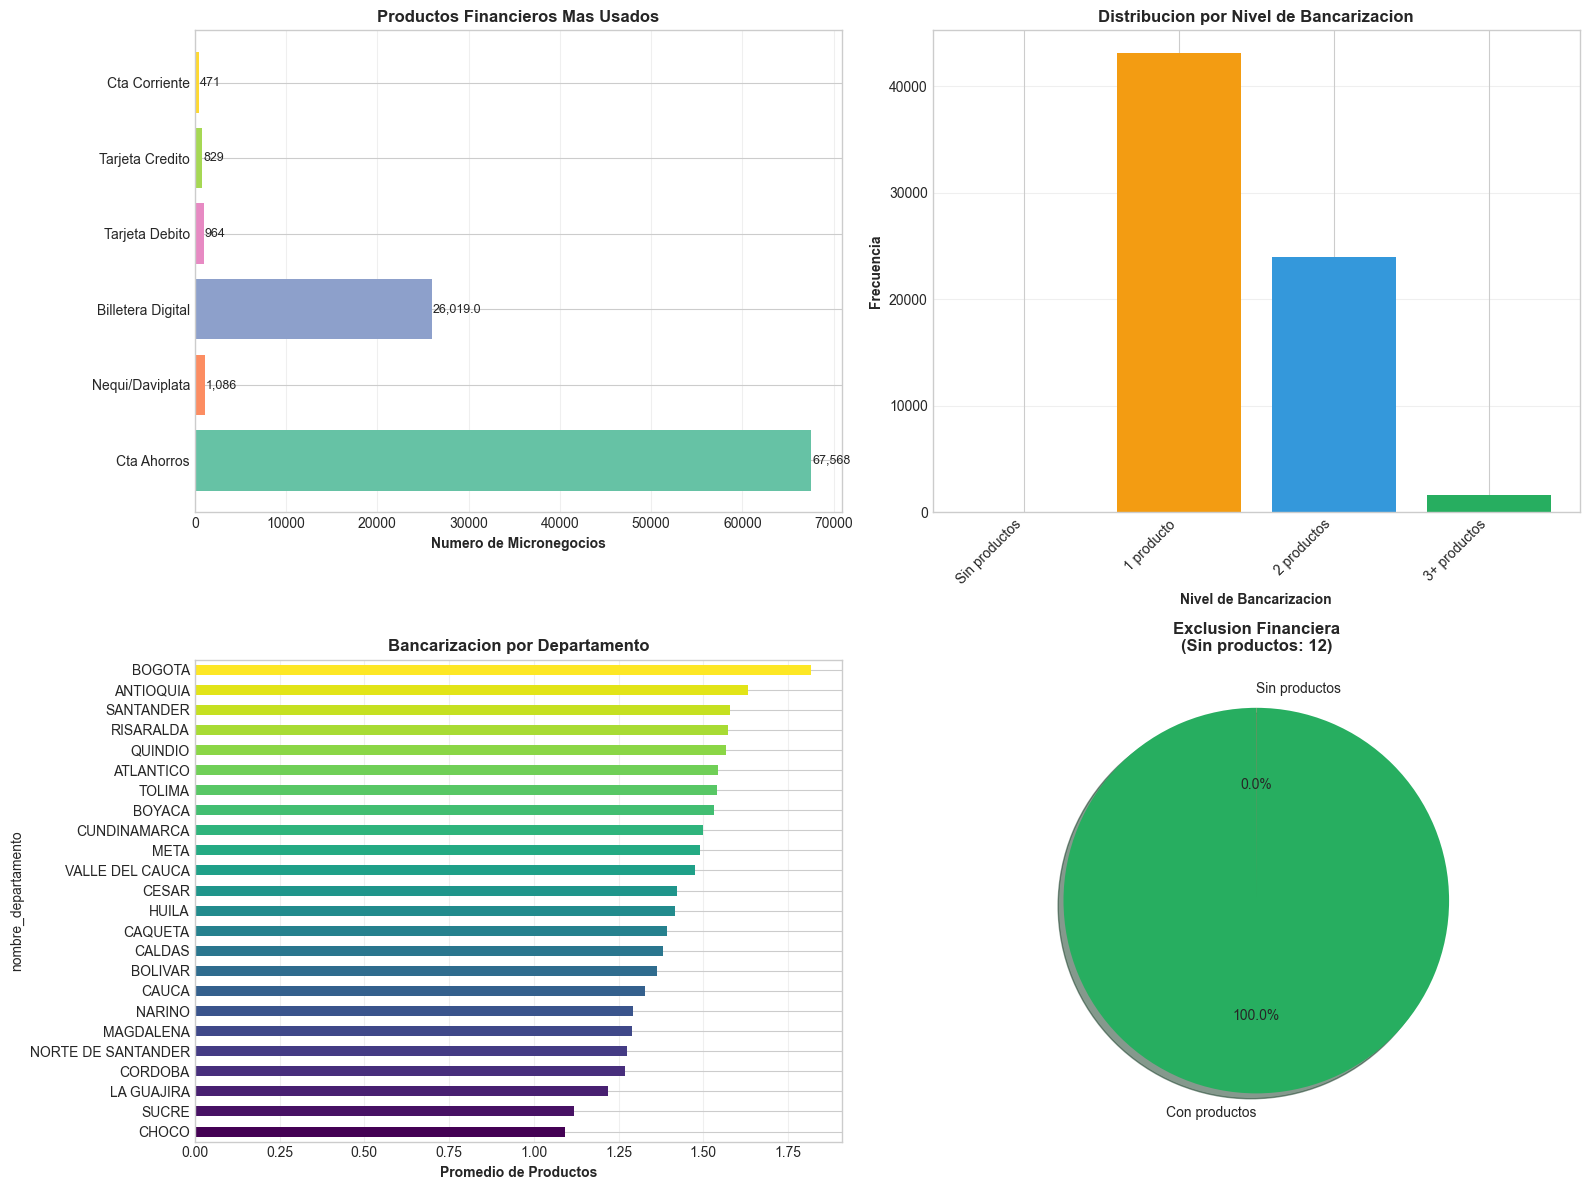


[2/5] Acceso a credito


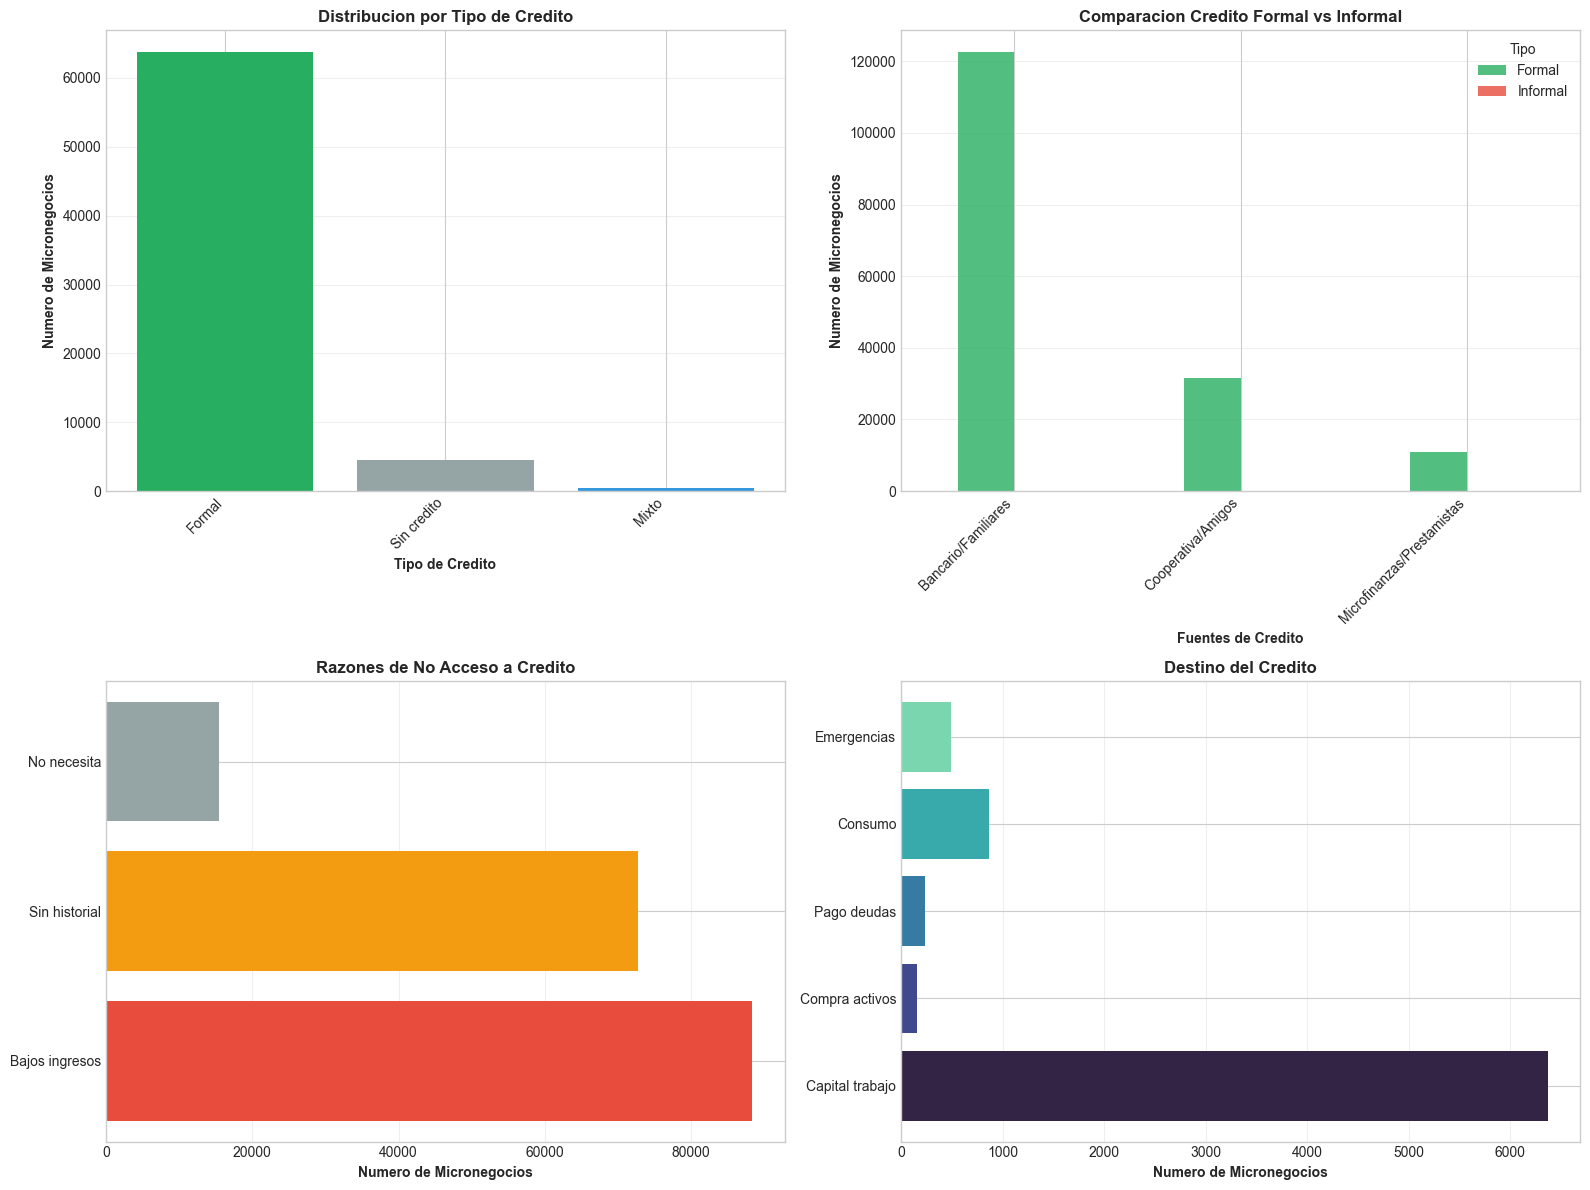


[3/5] Educacion financiera


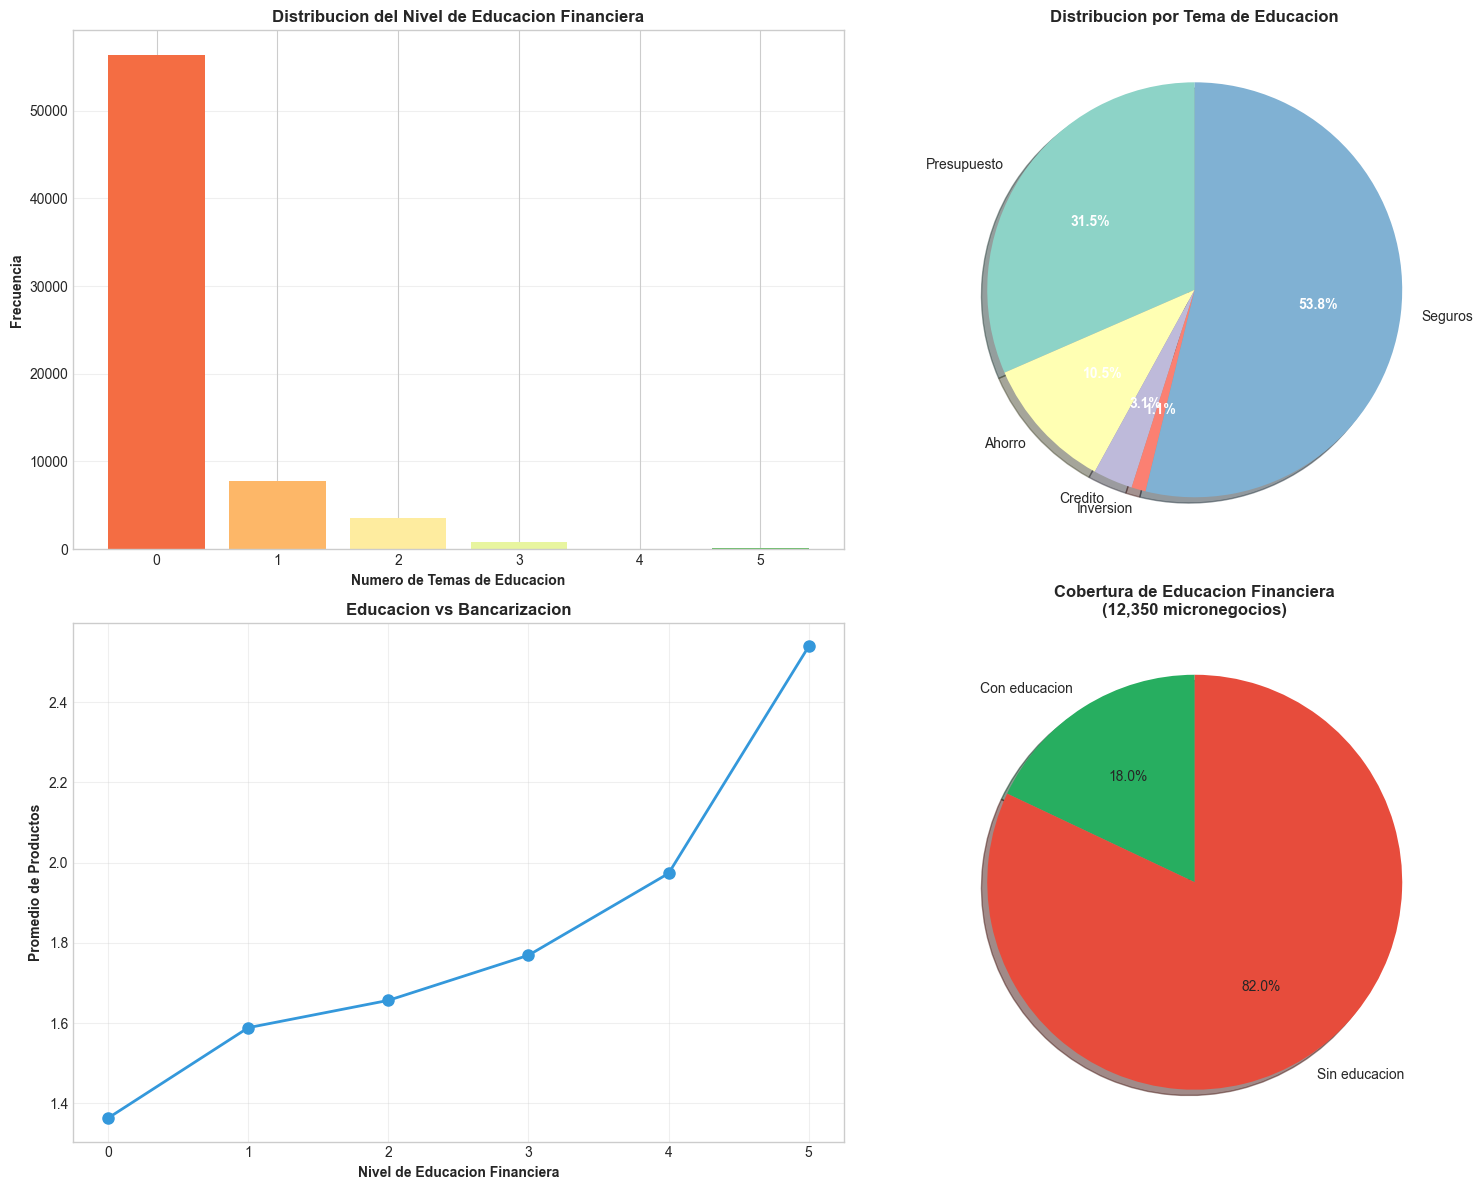


[4/5] Indice de inclusion financiera


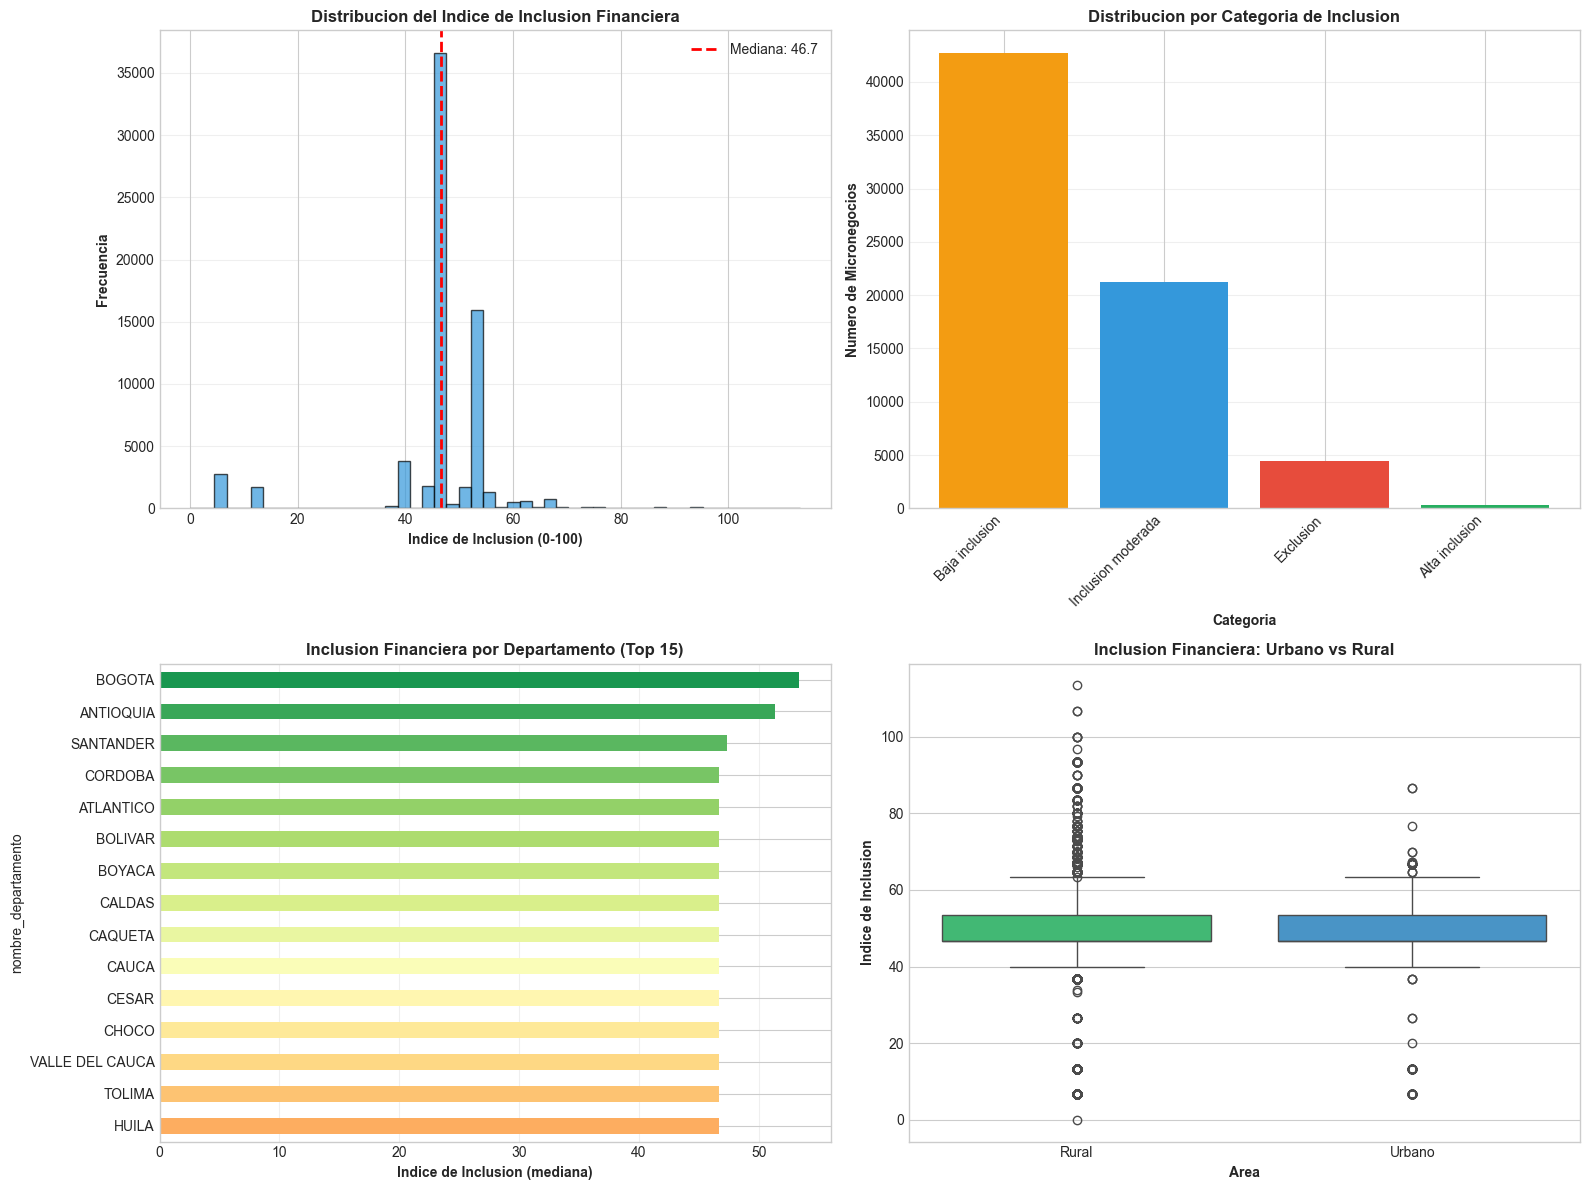


[5/5] Resiliencia financiera y gestion de riesgos


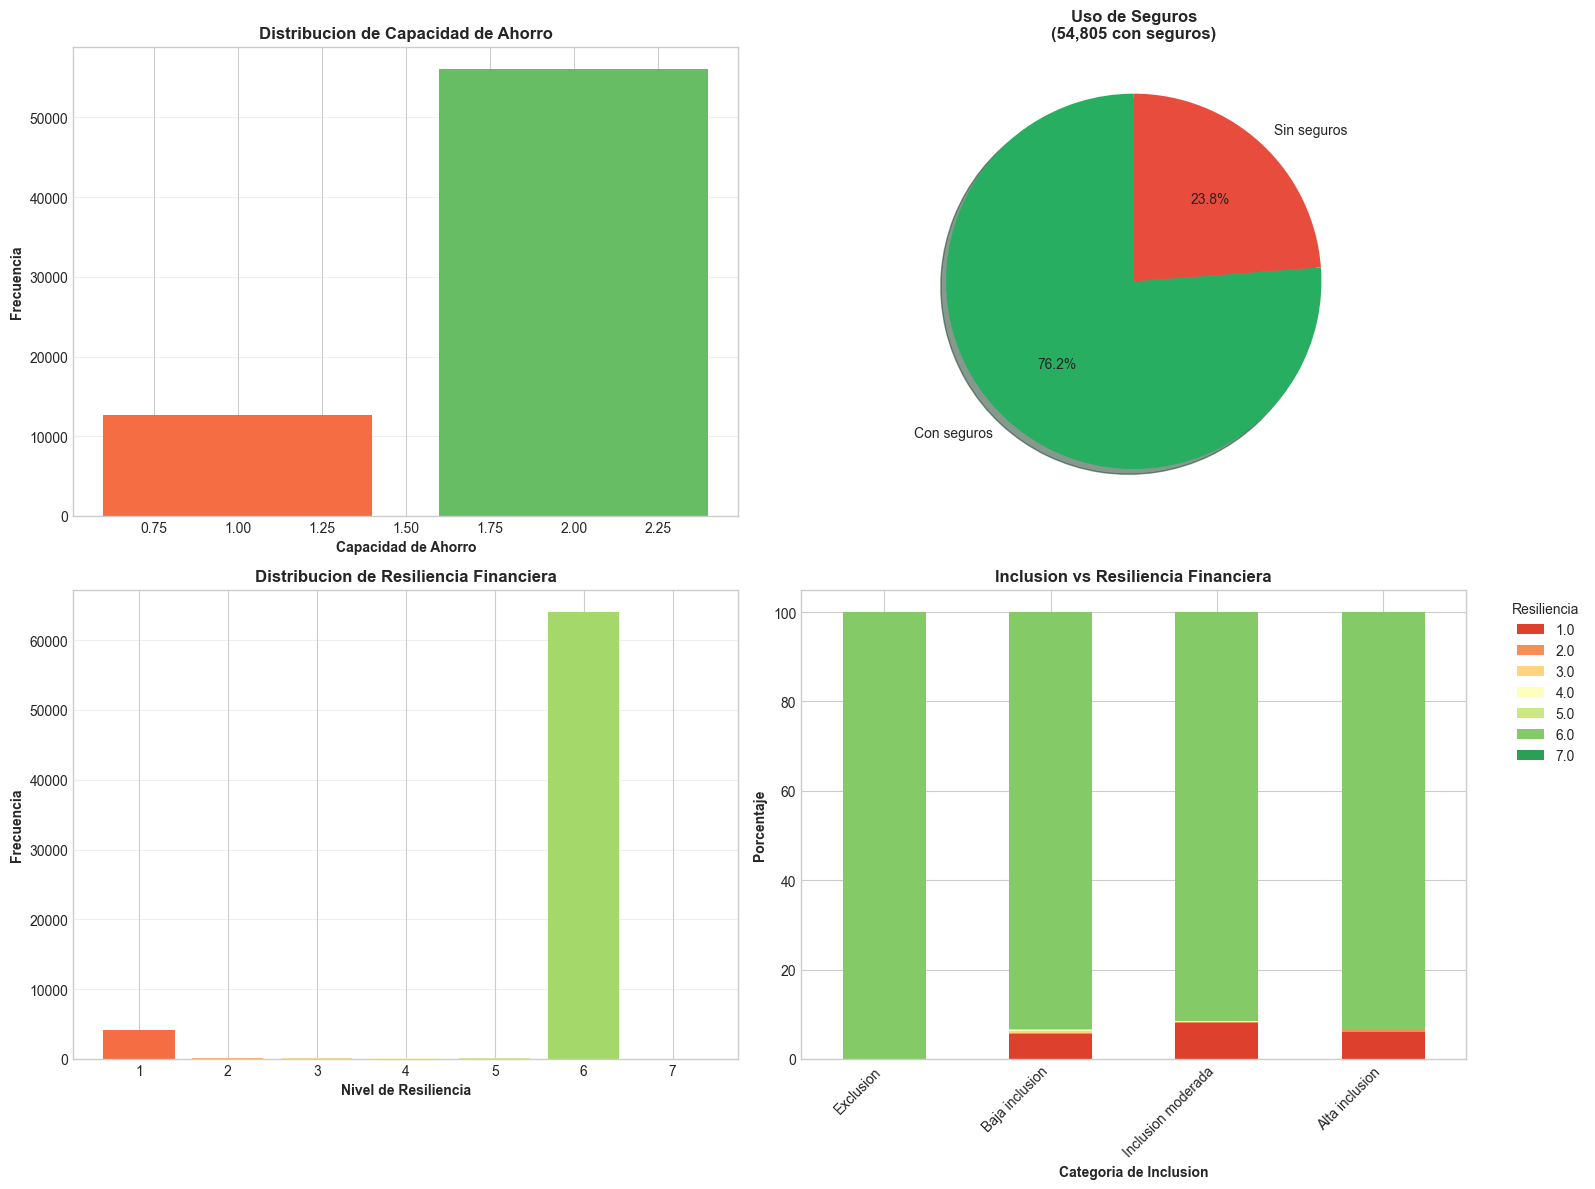


[8/8] Proceso completado

RESUMEN FINAL

Archivos generados en 'LIMPIOS/':
   - inclusion_financiera_limpio.csv (68,702 x 58)
   - eda_inclusion_01_productos.png
   - eda_inclusion_02_credito.png
   - eda_inclusion_03_educacion.png
   - eda_inclusion_04_indice.png
   - eda_inclusion_05_resiliencia.png

Insights clave:
   - Bancarizacion: 100.0% con al menos 1 producto
   - Credito formal: 93.5%
   - Credito informal: 0.7%
   - Educacion financiera: 18.0%
   - Indice inclusion mediano: 46.7/100
   - Uso de seguros: 79.8%

Analisis de inclusion financiera completado!


In [26]:
#!/usr/bin/env python3
"""
MODULO DE INCLUSION FINANCIERA - LIMPIEZA + EDA
EMICRON 2024 - Jupyter Notebook
"""

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("MODULO DE INCLUSION FINANCIERA - LIMPIEZA + EDA")
print("="*80)

# =============================================================================
# PARTE 1: LIMPIEZA DE DATOS
# =============================================================================
print("\n" + "="*80)
print("PARTE 1: LIMPIEZA DE DATOS")
print("="*80)

INPUT_FILE = 'ORIGINALES/Módulo de inclusión financiera.csv'
OUTPUT_DIR = 'LIMPIOS'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Cargar datos
print("\n[1/8] Cargando archivo...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
print(f"   OK Cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# Renombrar
print("\n[2/8] Renombrando columnas...")
RENAME = {
    "DIRECTORIO": "id_micronegocio", "SECUENCIA_P": "id_persona", "SECUENCIA_ENCUESTA": "id_encuesta",
    "P1764_1": "cuenta_ahorros", "P1764_2": "cuenta_corriente", "P1764_3": "billetera_digital",
    "P1764_4": "cuenta_nequi_daviplata", "P1764_5": "tarjeta_debito", "P1764_6": "tarjeta_credito",
    "P1764_7": "ningun_producto_financiero",
    "P1765": "acceso_credito", "P1567": "credito_bancario", "P1569": "credito_cooperativa",
    "P1568": "credito_microfinanzas",
    "P1571_1": "credito_familiares", "P1571_2": "credito_amigos", "P1571_3": "credito_prestamistas",
    "P1571_4": "credito_proveedores", "P1571_5": "credito_clientes", "P1571_6": "otro_credito",
    "P1570": "no_acceso_credito", "P1570_1": "no_credito_ingresos", "P1570_2": "no_credito_historial",
    "P1572_1": "credito_capital_trabajo", "P1572_2": "credito_compra_activos",
    "P1572_3": "credito_pago_deudas", "P1572_4": "credito_consumo",
    "P1572_5": "credito_emergencias", "P1572_6": "credito_otro_destino",
    "P3014": "capacidad_ahorro",
    "P1573_1": "educacion_presupuesto", "P1573_2": "educacion_ahorro", "P1573_3": "educacion_credito",
    "P1573_4": "educacion_inversion", "P1573_5": "educacion_seguros", "P1573_6": "educacion_ninguna",
    "P1574": "uso_seguros", "P1771": "resiliencia_financiera",
    "CLASE_TE": "clase_territorial", "COD_DEPTO": "codigo_departamento", "AREA": "area", "F_EXP": "factor_expansion"
}
df = df.rename(columns=RENAME)
print(f"   OK Renombradas: {len(RENAME)} columnas")

# Imputacion
print("\n[3/8] Imputando valores perdidos...")
missing_antes = df.isnull().sum().sum()

# Variables binarias con 0
vars_binarias = [c for c in df.columns if c.startswith(('cuenta_','tarjeta_','credito_','educacion_','ningun_','no_','uso_'))]
for col in vars_binarias:
    df[col] = df[col].fillna(0).astype(int)

# Imputar area por departamento
if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode())>0 else 1))

# Capacidad ahorro y resiliencia con moda
for col in ['capacidad_ahorro', 'resiliencia_financiera']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0] if len(df[col].mode())>0 else 0)

missing_despues = df.isnull().sum().sum()
print(f"   OK Valores perdidos: {missing_antes:,} -> {missing_despues:,} ({(1-missing_despues/missing_antes)*100:.1f}% reduccion)")

# Eliminar duplicados
print("\n[4/8] Eliminando duplicados...")
filas_antes = len(df)
df = df.drop_duplicates()
if 'id_micronegocio' in df.columns:
    df = df.drop_duplicates(subset=['id_micronegocio'])
filas_despues = len(df)
print(f"   OK Eliminados: {filas_antes - filas_despues:,}")

# Variables derivadas
print("\n[5/8] Creando variables derivadas...")

DEPTS = {5:'ANTIOQUIA',8:'ATLANTICO',11:'BOGOTA',13:'BOLIVAR',15:'BOYACA',17:'CALDAS',
         18:'CAQUETA',19:'CAUCA',20:'CESAR',23:'CORDOBA',25:'CUNDINAMARCA',27:'CHOCO',
         41:'HUILA',44:'LA GUAJIRA',47:'MAGDALENA',50:'META',52:'NARINO',
         54:'NORTE DE SANTANDER',63:'QUINDIO',66:'RISARALDA',68:'SANTANDER',
         70:'SUCRE',73:'TOLIMA',76:'VALLE DEL CAUCA',81:'ARAUCA'}

if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPTS)
if 'area' in df.columns:
    df['area_urbana'] = (df['area']==1).astype(int)

# Nivel de bancarizacion (numero de productos)
productos_fin = ['cuenta_ahorros','cuenta_corriente','billetera_digital','cuenta_nequi_daviplata',
                 'tarjeta_debito','tarjeta_credito']
df['num_productos_financieros'] = df[[c for c in productos_fin if c in df.columns]].sum(axis=1)
df['tiene_productos_financieros'] = (df['num_productos_financieros'] > 0).astype(int)
df['nivel_bancarizacion'] = pd.cut(df['num_productos_financieros'], 
                                     bins=[-1, 0, 1, 2, 10],
                                     labels=['Sin productos', '1 producto', '2 productos', '3+ productos'])

# Acceso a credito formal
credito_formal = ['credito_bancario','credito_cooperativa','credito_microfinanzas']
df['num_creditos_formales'] = df[[c for c in credito_formal if c in df.columns]].sum(axis=1)
df['tiene_credito_formal'] = (df['num_creditos_formales'] > 0).astype(int)

# Credito informal
credito_informal = ['credito_familiares','credito_amigos','credito_prestamistas',
                    'credito_proveedores','credito_clientes']
df['num_creditos_informales'] = df[[c for c in credito_informal if c in df.columns]].sum(axis=1)
df['tiene_credito_informal'] = (df['num_creditos_informales'] > 0).astype(int)

# Dependencia crediticia (formal vs informal)
df['tipo_credito'] = 'Sin credito'
df.loc[df['tiene_credito_formal']==1, 'tipo_credito'] = 'Formal'
df.loc[df['tiene_credito_informal']==1, 'tipo_credito'] = 'Informal'
df.loc[(df['tiene_credito_formal']==1) & (df['tiene_credito_informal']==1), 'tipo_credito'] = 'Mixto'

# Uso del credito
uso_credito = ['credito_capital_trabajo','credito_compra_activos','credito_pago_deudas',
               'credito_consumo','credito_emergencias']
df['num_usos_credito'] = df[[c for c in uso_credito if c in df.columns]].sum(axis=1)

# Educacion financiera
educacion_vars = ['educacion_presupuesto','educacion_ahorro','educacion_credito',
                  'educacion_inversion','educacion_seguros']
df['nivel_educacion_financiera'] = df[[c for c in educacion_vars if c in df.columns]].sum(axis=1)
df['tiene_educacion_financiera'] = (df['nivel_educacion_financiera'] > 0).astype(int)

# Indice de inclusion financiera (0-100)
# Componentes: bancarizacion (40%), credito formal (30%), educacion (20%), seguros (10%)
df['indice_inclusion'] = (
    (df['num_productos_financieros'].clip(0,6) / 6 * 40) +
    (df['tiene_credito_formal'] * 30) +
    (df['nivel_educacion_financiera'].clip(0,5) / 5 * 20) +
    (df['uso_seguros'].fillna(0) * 10)
)

# Categorizar inclusion
df['categoria_inclusion'] = pd.cut(df['indice_inclusion'], 
                                     bins=[0, 25, 50, 75, 100],
                                     labels=['Exclusion', 'Baja inclusion', 'Inclusion moderada', 'Alta inclusion'])

print(f"   OK Variables derivadas creadas")

# Guardar
print("\n[6/8] Guardando dataset limpio...")
output_file = f'{OUTPUT_DIR}/inclusion_financiera_limpio.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"   OK Guardado: {output_file}")
print(f"   OK Dimensiones: {df.shape[0]:,} x {df.shape[1]}")

# =============================================================================
# PARTE 2: EDA
# =============================================================================
print("\n" + "="*80)
print("PARTE 2: ANALISIS EXPLORATORIO")
print("="*80)

print("\n[7/8] Generando visualizaciones...\n")

# ============================================================================
# VIZ 1: PRODUCTOS FINANCIEROS
# ============================================================================
print("[1/5] Productos financieros y bancarizacion")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Productos mas usados
productos = {
    'Cta Ahorros': df['cuenta_ahorros'].sum(),
    'Nequi/Daviplata': df['cuenta_nequi_daviplata'].sum(),
    'Billetera Digital': df['billetera_digital'].sum(),
    'Tarjeta Debito': df['tarjeta_debito'].sum(),
    'Tarjeta Credito': df['tarjeta_credito'].sum(),
    'Cta Corriente': df['cuenta_corriente'].sum()
}
colors1 = sns.color_palette("Set2", len(productos))
axes[0,0].barh(list(productos.keys()), list(productos.values()), color=colors1)
axes[0,0].set_xlabel('Numero de Micronegocios', fontweight='bold')
axes[0,0].set_title('Productos Financieros Mas Usados', fontsize=12, fontweight='bold')
axes[0,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(productos.values()):
    axes[0,0].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

# Nivel de bancarizacion
banc = df['nivel_bancarizacion'].value_counts().sort_index()
colors2 = ['#e74c3c', '#f39c12', '#3498db', '#27ae60']
axes[0,1].bar(banc.index.astype(str), banc.values, color=colors2)
axes[0,1].set_xlabel('Nivel de Bancarizacion', fontweight='bold')
axes[0,1].set_ylabel('Frecuencia', fontweight='bold')
axes[0,1].set_title('Distribucion por Nivel de Bancarizacion', fontsize=12, fontweight='bold')
plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[0,1].grid(axis='y', alpha=0.3)

# Bancarizacion por departamento
if 'nombre_departamento' in df.columns:
    dept_banc = df.groupby('nombre_departamento')['num_productos_financieros'].mean().sort_values(ascending=True)
    colors3 = plt.cm.viridis(np.linspace(0, 1, len(dept_banc)))
    dept_banc.plot(kind='barh', ax=axes[1,0], color=colors3)
    axes[1,0].set_xlabel('Promedio de Productos', fontweight='bold')
    axes[1,0].set_title('Bancarizacion por Departamento', fontsize=12, fontweight='bold')
    axes[1,0].grid(axis='x', alpha=0.3)

# Exclusion financiera
exclusion = pd.Series({
    'Con productos': df['tiene_productos_financieros'].sum(),
    'Sin productos': (1-df['tiene_productos_financieros']).sum()
})
colors4 = ['#27ae60', '#e74c3c']
axes[1,1].pie(exclusion.values, labels=exclusion.index, autopct='%1.1f%%',
              startangle=90, colors=colors4, shadow=True)
axes[1,1].set_title(f'Exclusion Financiera\n(Sin productos: {exclusion["Sin productos"]:,})', 
                    fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_inclusion_01_productos.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 2: ACCESO A CREDITO
# ============================================================================
print("\n[2/5] Acceso a credito")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Tipos de credito
credito_tipo = df['tipo_credito'].value_counts()
colors5 = {'Sin credito':'#95a5a6', 'Formal':'#27ae60', 'Informal':'#e74c3c', 'Mixto':'#3498db'}
axes[0,0].bar(credito_tipo.index, credito_tipo.values, 
              color=[colors5.get(x, '#95a5a6') for x in credito_tipo.index])
axes[0,0].set_xlabel('Tipo de Credito', fontweight='bold')
axes[0,0].set_ylabel('Numero de Micronegocios', fontweight='bold')
axes[0,0].set_title('Distribucion por Tipo de Credito', fontsize=12, fontweight='bold')
plt.setp(axes[0,0].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[0,0].grid(axis='y', alpha=0.3)

# Fuentes de credito formal vs informal - CORREGIDO
fuentes_data = pd.DataFrame({
    'Formal': [df['credito_bancario'].sum(), df['credito_cooperativa'].sum(), df['credito_microfinanzas'].sum()],
    'Informal': [df['credito_familiares'].sum(), df['credito_amigos'].sum(), df['credito_prestamistas'].sum()]
}, index=['Bancario/Familiares', 'Cooperativa/Amigos', 'Microfinanzas/Prestamistas'])

fuentes_data.plot(kind='bar', ax=axes[0,1], color=['#27ae60', '#e74c3c'], alpha=0.8)
axes[0,1].set_xlabel('Fuentes de Credito', fontweight='bold')
axes[0,1].set_ylabel('Numero de Micronegocios', fontweight='bold')
axes[0,1].set_title('Comparacion Credito Formal vs Informal', fontsize=12, fontweight='bold')
axes[0,1].legend(title='Tipo')
axes[0,1].grid(axis='y', alpha=0.3)
plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Razones de no acceso
razones = pd.Series({
    'Bajos ingresos': df['no_credito_ingresos'].sum(),
    'Sin historial': df['no_credito_historial'].sum(),
    'No necesita': df['no_acceso_credito'].sum()
})
axes[1,0].barh(razones.index, razones.values, color=['#e74c3c','#f39c12','#95a5a6'])
axes[1,0].set_xlabel('Numero de Micronegocios', fontweight='bold')
axes[1,0].set_title('Razones de No Acceso a Credito', fontsize=12, fontweight='bold')
axes[1,0].grid(axis='x', alpha=0.3)

# Uso del credito
usos = {
    'Capital trabajo': df['credito_capital_trabajo'].sum(),
    'Compra activos': df['credito_compra_activos'].sum(),
    'Pago deudas': df['credito_pago_deudas'].sum(),
    'Consumo': df['credito_consumo'].sum(),
    'Emergencias': df['credito_emergencias'].sum()
}
colors6 = sns.color_palette("mako", len(usos))
axes[1,1].barh(list(usos.keys()), list(usos.values()), color=colors6)
axes[1,1].set_xlabel('Numero de Micronegocios', fontweight='bold')
axes[1,1].set_title('Destino del Credito', fontsize=12, fontweight='bold')
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_inclusion_02_credito.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 3: EDUCACION FINANCIERA
# ============================================================================
print("\n[3/5] Educacion financiera")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribucion nivel educacion
nivel_edu = df['nivel_educacion_financiera'].value_counts().sort_index()
axes[0,0].bar(nivel_edu.index, nivel_edu.values, color=plt.cm.RdYlGn(np.linspace(0.2,0.8,len(nivel_edu))))
axes[0,0].set_xlabel('Numero de Temas de Educacion', fontweight='bold')
axes[0,0].set_ylabel('Frecuencia', fontweight='bold')
axes[0,0].set_title('Distribucion del Nivel de Educacion Financiera', fontsize=12, fontweight='bold')
axes[0,0].grid(axis='y', alpha=0.3)

# Temas de educacion
temas = {
    'Presupuesto': df['educacion_presupuesto'].sum(),
    'Ahorro': df['educacion_ahorro'].sum(),
    'Credito': df['educacion_credito'].sum(),
    'Inversion': df['educacion_inversion'].sum(),
    'Seguros': df['educacion_seguros'].sum()
}
colors7 = sns.color_palette("Set3", len(temas))
wedges, texts, autotexts = axes[0,1].pie(temas.values(), labels=temas.keys(), autopct='%1.1f%%',
                                          startangle=90, colors=colors7, shadow=True)
axes[0,1].set_title('Distribucion por Tema de Educacion', fontsize=12, fontweight='bold')
for at in autotexts:
    at.set_color('white')
    at.set_fontweight('bold')

# Educacion vs Bancarizacion
if 'nivel_educacion_financiera' in df.columns:
    edu_banc = df.groupby('nivel_educacion_financiera')['num_productos_financieros'].mean()
    axes[1,0].plot(edu_banc.index, edu_banc.values, marker='o', linewidth=2, markersize=8, color='#3498db')
    axes[1,0].set_xlabel('Nivel de Educacion Financiera', fontweight='bold')
    axes[1,0].set_ylabel('Promedio de Productos', fontweight='bold')
    axes[1,0].set_title('Educacion vs Bancarizacion', fontsize=12, fontweight='bold')
    axes[1,0].grid(alpha=0.3)

# Con vs sin educacion
edu_status = pd.Series({
    'Con educacion': df['tiene_educacion_financiera'].sum(),
    'Sin educacion': (1-df['tiene_educacion_financiera']).sum()
})
colors8 = ['#27ae60', '#e74c3c']
axes[1,1].pie(edu_status.values, labels=edu_status.index, autopct='%1.1f%%',
              startangle=90, colors=colors8, shadow=True)
axes[1,1].set_title(f'Cobertura de Educacion Financiera\n({edu_status["Con educacion"]:,} micronegocios)', 
                    fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_inclusion_03_educacion.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 4: INDICE DE INCLUSION FINANCIERA
# ============================================================================
print("\n[4/5] Indice de inclusion financiera")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribucion del indice
axes[0,0].hist(df['indice_inclusion'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0,0].axvline(df['indice_inclusion'].median(), color='red', linestyle='--', linewidth=2,
                  label=f'Mediana: {df["indice_inclusion"].median():.1f}')
axes[0,0].set_xlabel('Indice de Inclusion (0-100)', fontweight='bold')
axes[0,0].set_ylabel('Frecuencia', fontweight='bold')
axes[0,0].set_title('Distribucion del Indice de Inclusion Financiera', fontsize=12, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# Categorias de inclusion
cat_inclusion = df['categoria_inclusion'].value_counts()
colors9 = {'Exclusion':'#e74c3c', 'Baja inclusion':'#f39c12', 
           'Inclusion moderada':'#3498db', 'Alta inclusion':'#27ae60'}
axes[0,1].bar(cat_inclusion.index.astype(str), cat_inclusion.values,
              color=[colors9.get(str(x), '#95a5a6') for x in cat_inclusion.index])
axes[0,1].set_xlabel('Categoria', fontweight='bold')
axes[0,1].set_ylabel('Numero de Micronegocios', fontweight='bold')
axes[0,1].set_title('Distribucion por Categoria de Inclusion', fontsize=12, fontweight='bold')
plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[0,1].grid(axis='y', alpha=0.3)

# Indice por departamento
if 'nombre_departamento' in df.columns:
    dept_ind = df.groupby('nombre_departamento')['indice_inclusion'].median().sort_values(ascending=True).tail(15)
    colors10 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(dept_ind)))
    dept_ind.plot(kind='barh', ax=axes[1,0], color=colors10)
    axes[1,0].set_xlabel('Indice de Inclusion (mediana)', fontweight='bold')
    axes[1,0].set_title('Inclusion Financiera por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,0].grid(axis='x', alpha=0.3)

# Urbano vs Rural
if 'area_urbana' in df.columns:
    area_labels = {0: 'Rural', 1: 'Urbano'}
    df['area_label'] = df['area_urbana'].map(area_labels)
    sns.boxplot(data=df, x='area_label', y='indice_inclusion', ax=axes[1,1],
               palette=['#2ecc71', '#3498db'])
    axes[1,1].set_xlabel('Area', fontweight='bold')
    axes[1,1].set_ylabel('Indice de Inclusion', fontweight='bold')
    axes[1,1].set_title('Inclusion Financiera: Urbano vs Rural', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_inclusion_04_indice.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 5: RESILIENCIA Y SEGUROS
# ============================================================================
print("\n[5/5] Resiliencia financiera y gestion de riesgos")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Capacidad de ahorro
if 'capacidad_ahorro' in df.columns:
    ahorro = df['capacidad_ahorro'].value_counts().sort_index()
    axes[0,0].bar(ahorro.index, ahorro.values, color=plt.cm.RdYlGn(np.linspace(0.2,0.8,len(ahorro))))
    axes[0,0].set_xlabel('Capacidad de Ahorro', fontweight='bold')
    axes[0,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,0].set_title('Distribucion de Capacidad de Ahorro', fontsize=12, fontweight='bold')
    axes[0,0].grid(axis='y', alpha=0.3)

# Uso de seguros
if 'uso_seguros' in df.columns:
    seguros = pd.Series({
        'Con seguros': df['uso_seguros'].sum(),
        'Sin seguros': (df['uso_seguros']==0).sum()
    })
    colors11 = ['#27ae60', '#e74c3c']
    axes[0,1].pie(seguros.values, labels=seguros.index, autopct='%1.1f%%',
                  startangle=90, colors=colors11, shadow=True)
    axes[0,1].set_title(f'Uso de Seguros\n({seguros["Con seguros"]:,} con seguros)', 
                        fontsize=12, fontweight='bold')

# Resiliencia financiera
if 'resiliencia_financiera' in df.columns:
    resil = df['resiliencia_financiera'].value_counts().sort_index()
    axes[1,0].bar(resil.index, resil.values, color=plt.cm.RdYlGn(np.linspace(0.2,0.8,len(resil))))
    axes[1,0].set_xlabel('Nivel de Resiliencia', fontweight='bold')
    axes[1,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[1,0].set_title('Distribucion de Resiliencia Financiera', fontsize=12, fontweight='bold')
    axes[1,0].grid(axis='y', alpha=0.3)

# Relacion inclusion vs resiliencia
if 'categoria_inclusion' in df.columns and 'resiliencia_financiera' in df.columns:
    incl_resil = pd.crosstab(df['categoria_inclusion'], df['resiliencia_financiera'], normalize='index') * 100
    incl_resil.plot(kind='bar', stacked=True, ax=axes[1,1], 
                    color=sns.color_palette("RdYlGn", len(incl_resil.columns)))
    axes[1,1].set_xlabel('Categoria de Inclusion', fontweight='bold')
    axes[1,1].set_ylabel('Porcentaje', fontweight='bold')
    axes[1,1].set_title('Inclusion vs Resiliencia Financiera', fontsize=12, fontweight='bold')
    axes[1,1].legend(title='Resiliencia', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_inclusion_05_resiliencia.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n[8/8] Proceso completado\n")
print(f"{'='*80}")
print("RESUMEN FINAL")
print(f"{'='*80}")
print(f"\nArchivos generados en '{OUTPUT_DIR}/':")
print(f"   - inclusion_financiera_limpio.csv ({df.shape[0]:,} x {df.shape[1]})")
print(f"   - eda_inclusion_01_productos.png")
print(f"   - eda_inclusion_02_credito.png")
print(f"   - eda_inclusion_03_educacion.png")
print(f"   - eda_inclusion_04_indice.png")
print(f"   - eda_inclusion_05_resiliencia.png")

print(f"\nInsights clave:")
print(f"   - Bancarizacion: {df['tiene_productos_financieros'].mean()*100:.1f}% con al menos 1 producto")
print(f"   - Credito formal: {df['tiene_credito_formal'].mean()*100:.1f}%")
print(f"   - Credito informal: {df['tiene_credito_informal'].mean()*100:.1f}%")
print(f"   - Educacion financiera: {df['tiene_educacion_financiera'].mean()*100:.1f}%")
print(f"   - Indice inclusion mediano: {df['indice_inclusion'].median():.1f}/100")
print(f"   - Uso de seguros: {df['uso_seguros'].mean()*100:.1f}%")
print(f"{'='*80}\n")
print("Analisis de inclusion financiera completado!")

## MODULO DE EMPLEO Y FUERZA LABORAL  
### Variables seleccionadas y preparacion para el modelado

| Codigo DANE | Nombre analitico               | Interpretacion en el TFM                     | Tipo de preparacion o limpieza |
|------------|--------------------------------|----------------------------------------------|--------------------------------|
| TIPO       | Tipo de trabajador             | Clasifica al personal segun vinculo laboral  | Codificacion categorica         |
| P3077      | Numero de trabajadores         | Tamano de la fuerza laboral                  | Winsorizacion mas escalado      |
| P3078      | Trabajadores familiares        | Participacion familiar en el negocio         | Escalado estandar               |
| P3079      | Trabajadores no familiares     | Externalizacion de la fuerza laboral         | Escalado estandar               |
| P3080      | Trabajadores permanentes       | Estabilidad laboral                          | Escalado estandar               |
| P3081      | Trabajadores temporales        | Flexibilidad laboral                         | Escalado estandar               |
| P3082      | Trabajadores remunerados       | Formalizacion del empleo                    | Escalado estandar               |
| P3083      | Trabajadores no remunerados    | Informalidad laboral                         | Escalado estandar               |
| P3084      | Trabajadoras mujeres           | Enfoque de genero                            | Proporcion mas escalado         |
| P2990      | Seguridad social               | Proteccion social del personal               | Codificacion binaria            |
| P3085      | Tipo de contrato               | Formalidad contractual                       | Codificacion ordinal            |
| P3099      | Jornada laboral                | Intensidad del trabajo                       | Codificacion ordinal            |
| CLASE_TE   | Clase territorial              | Diferencias urbano rural                    | Codificacion categorica         |
| COD_DEPTO  | Codigo departamento            | Segmentacion regional                        | Target encoding                 |
| AREA       | Area                           | Ubicacion del negocio                        | Codificacion binaria            |
| F_EXP      | Factor expansion               | Inferencia poblacional                       | No usado en ML                  |

> Nota metodologica  
> Este modulo captura la estructura del empleo y el grado de formalidad laboral del micronegocio, variables clave para explicar productividad, sostenibilidad y riesgo estructural dentro del modelo predictivo del TFM.
## INSIGHTS ESPERADOS DEL MODULO DE EMPLEO

- Promedio aproximado de 1.7 trabajadores por micronegocio  
  Indica estructuras productivas de muy pequena escala y alta dependencia del autoempleo.

- Alta informalidad laboral  
  La mayoria de los trabajadores no cuenta con seguridad social, lo que refleja vulnerabilidad y baja proteccion social.

- Predominio del trabajo familiar  
  Los micronegocios son operados principalmente por miembros del hogar, lo que reduce costos pero limita el crecimiento.

- Brecha de genero  
  La participacion femenina es variable segun sector y territorio, sugiriendo desigualdades estructurales en el acceso y rol laboral.


MODULO DE PERSONAL OCUPADO - LIMPIEZA + EDA

PARTE 1: LIMPIEZA DE DATOS

[1/8] Cargando archivo...
   OK Cargado: 22,101 filas x 20 columnas

[2/8] Renombrando columnas...
   OK Renombradas: 20 columnas

[3/8] Imputando valores perdidos...
   OK Valores perdidos: 74,398 -> 0 (100.0% reduccion)

[4/8] Aplicando winsorización...
   OK Winsorizado numero_trabajadores (P1=0, P99=2)

[5/8] Eliminando duplicados...
   OK Eliminados: 0

[6/8] Creando variables derivadas...
   OK Variables derivadas creadas

[7/8] Agregando a nivel micronegocio...
   OK Agregado: 12,878 micronegocios unicos

[8/8] Guardando datasets...
   OK Detalle: LIMPIOS/personal_ocupado_detalle.csv (22,101 x 36)
   OK Agregado: LIMPIOS/personal_ocupado_agregado.csv (12,878 x 15)

PARTE 2: ANALISIS EXPLORATORIO

[9/10] Generando visualizaciones...

[1/5] Distribucion de trabajadores


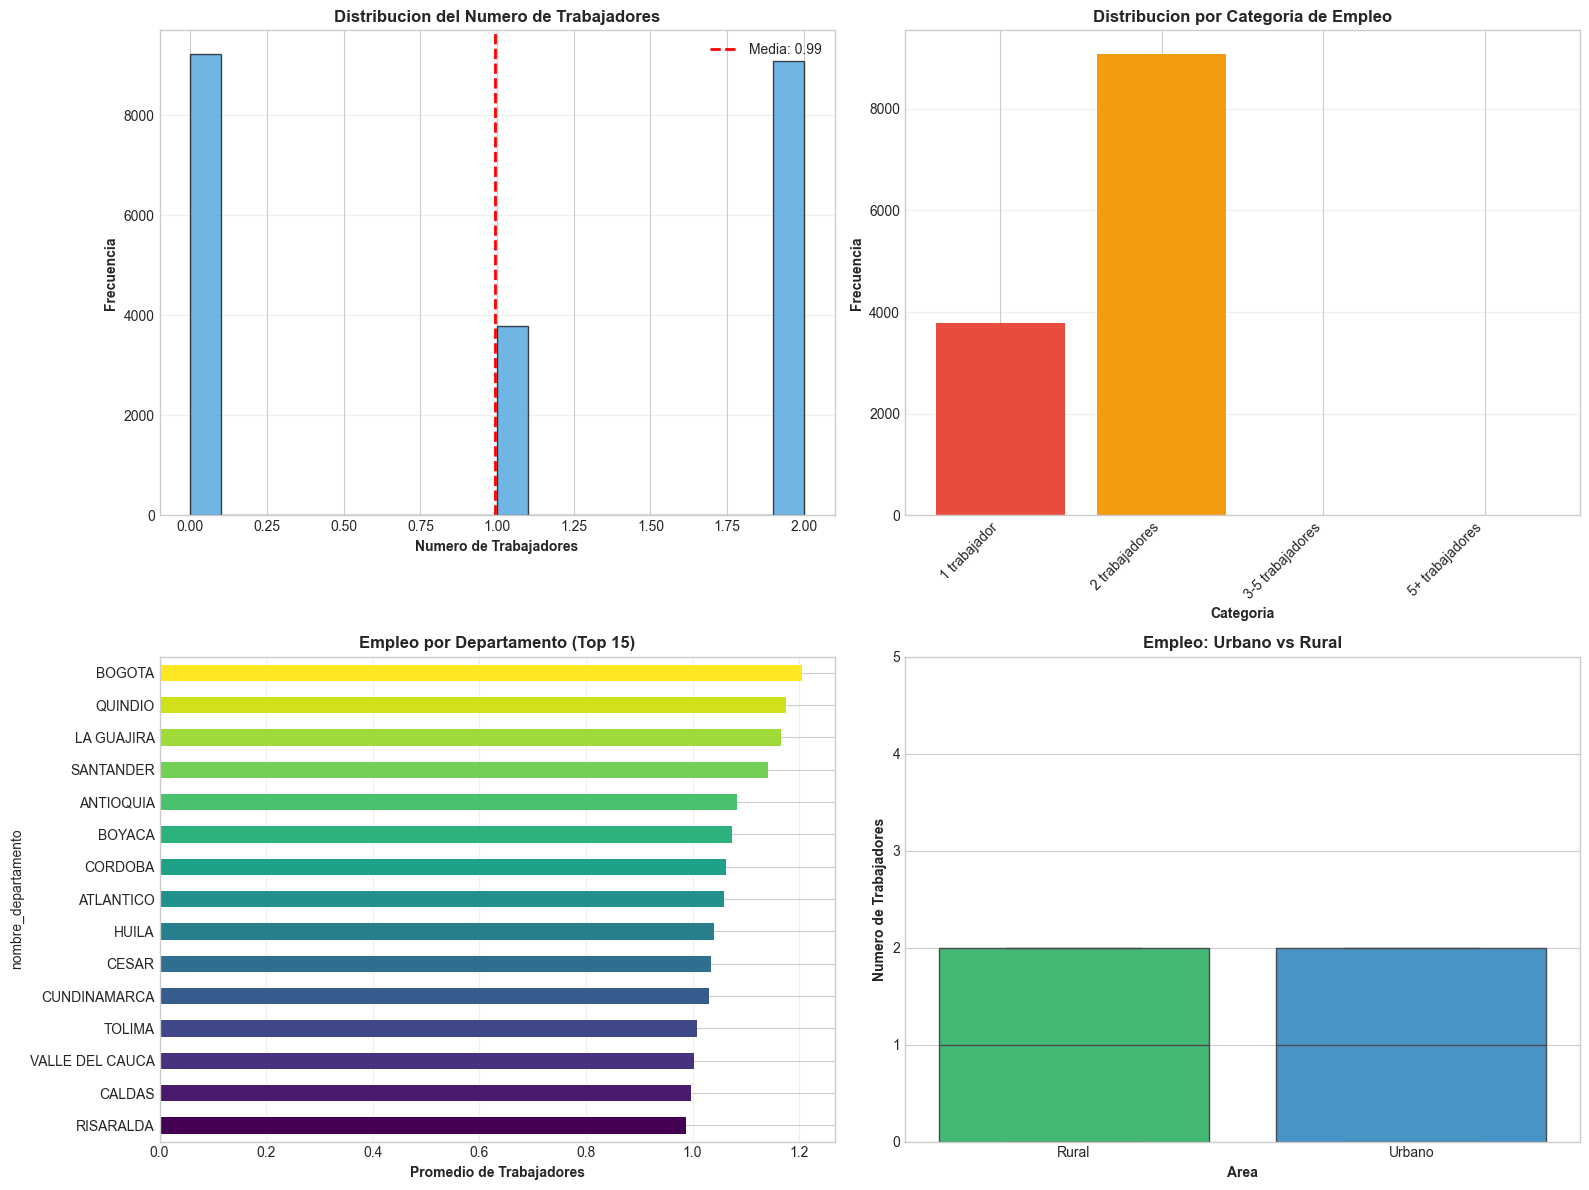


[2/5] Tipo de vinculo laboral


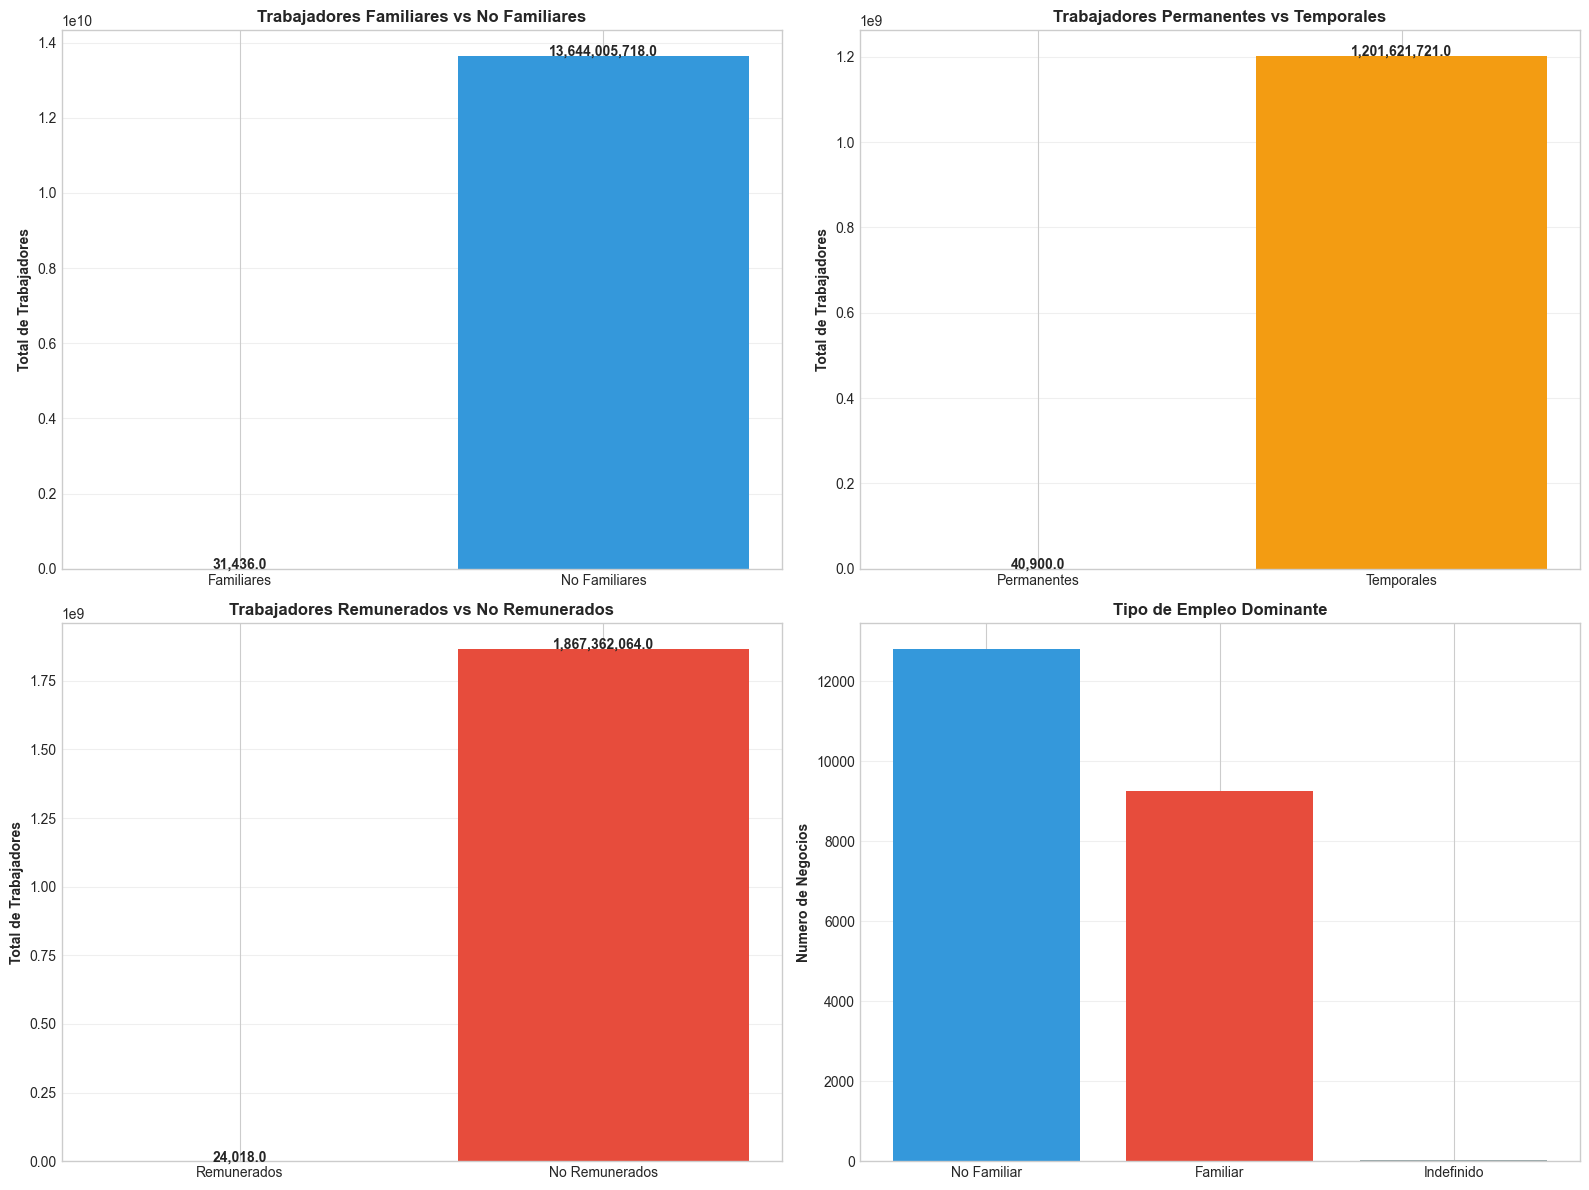


[3/5] Equidad de genero


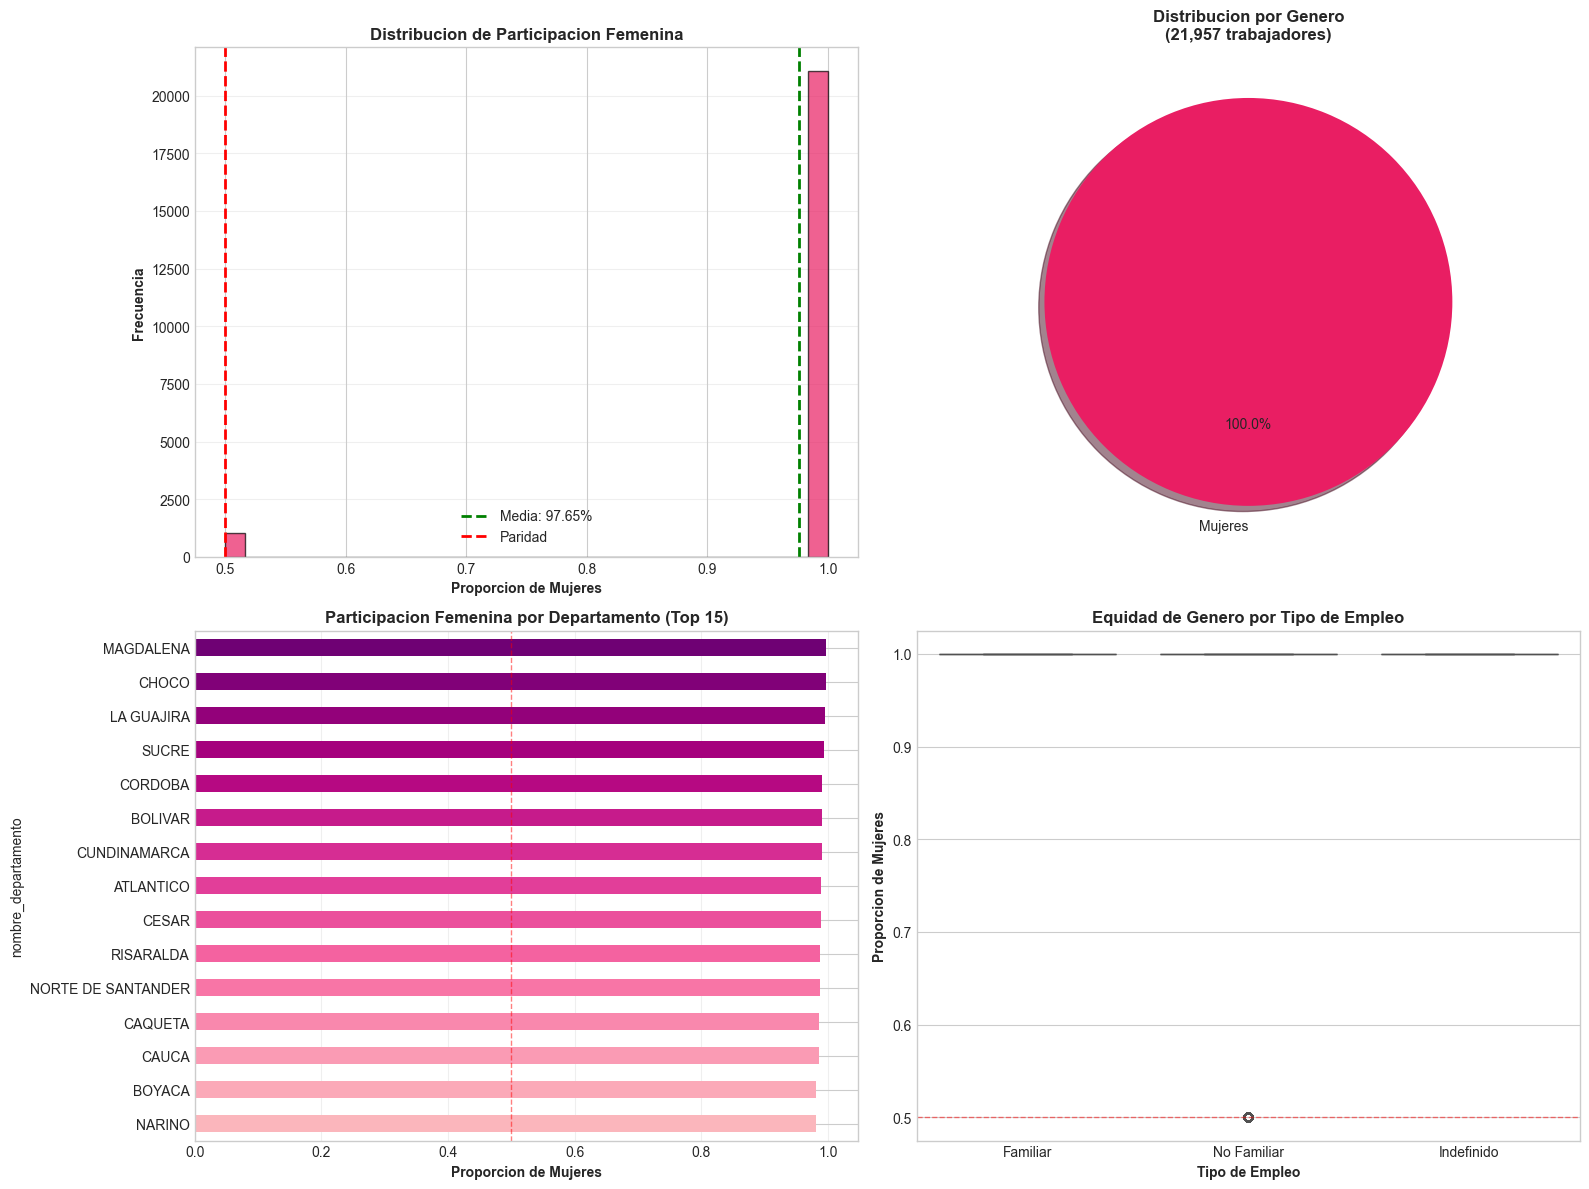


[4/5] Formalidad laboral


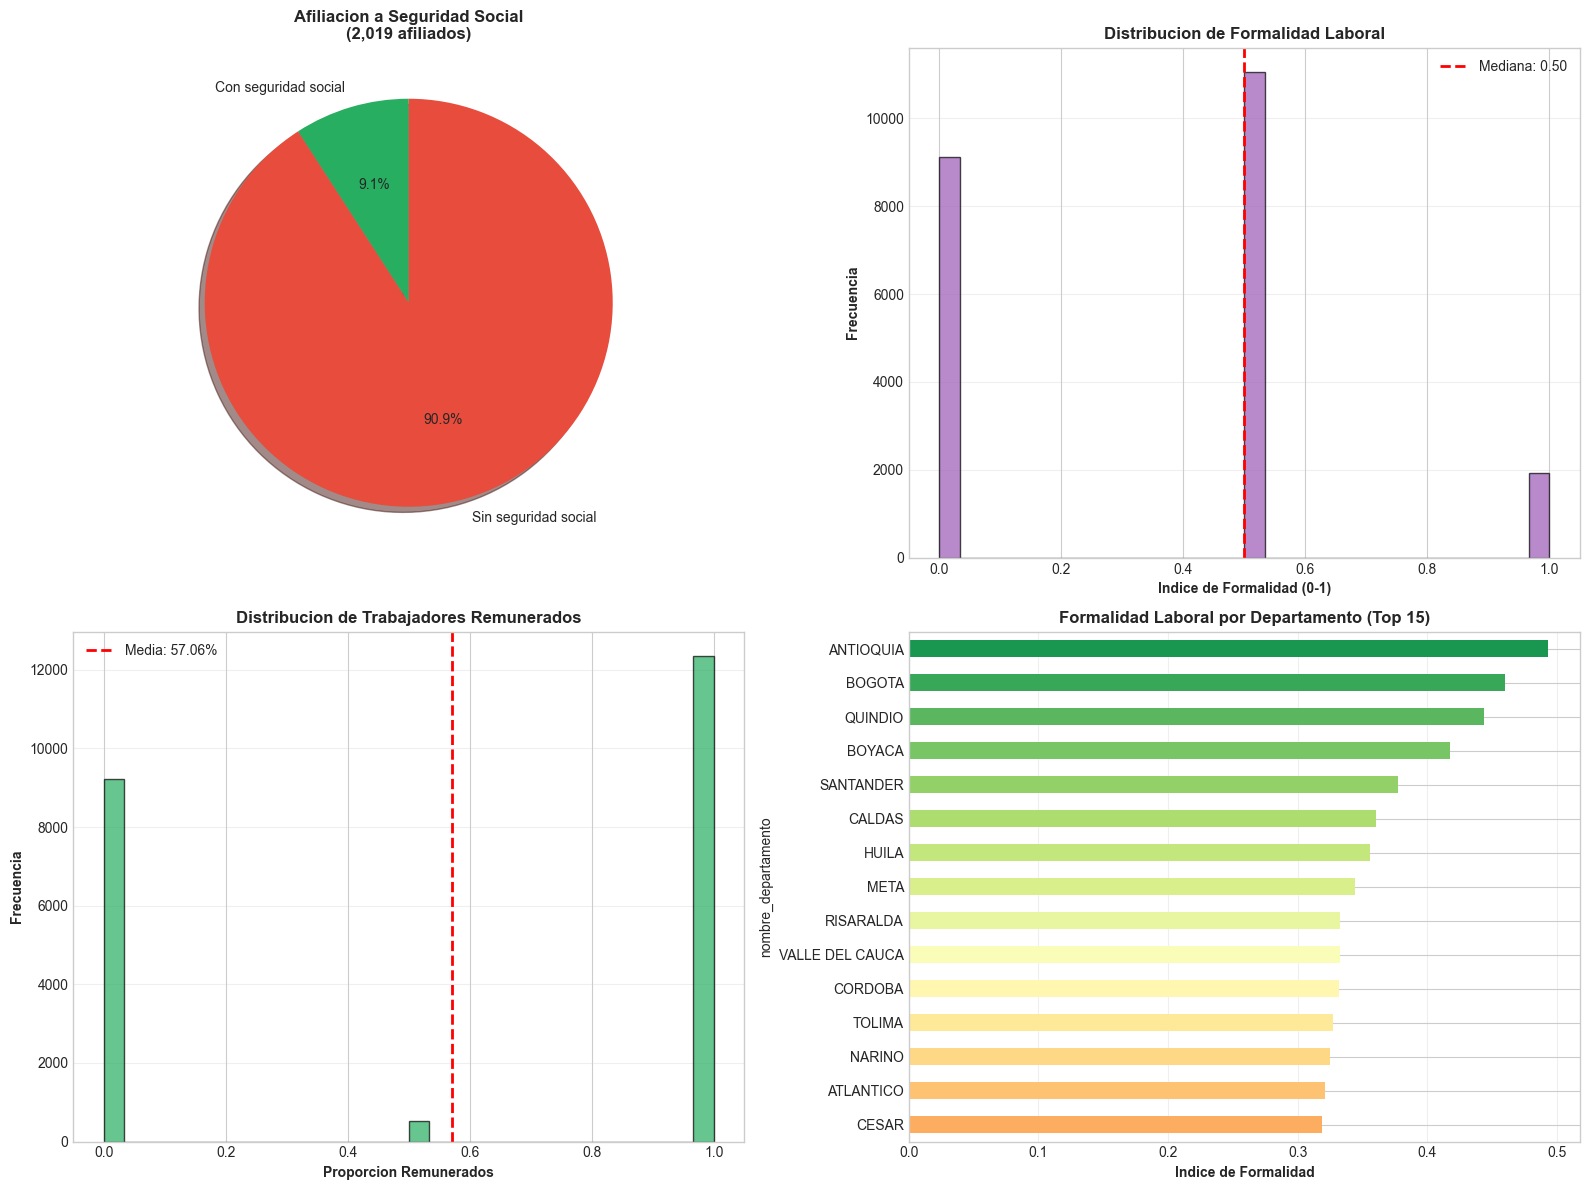


[5/5] Calidad del empleo


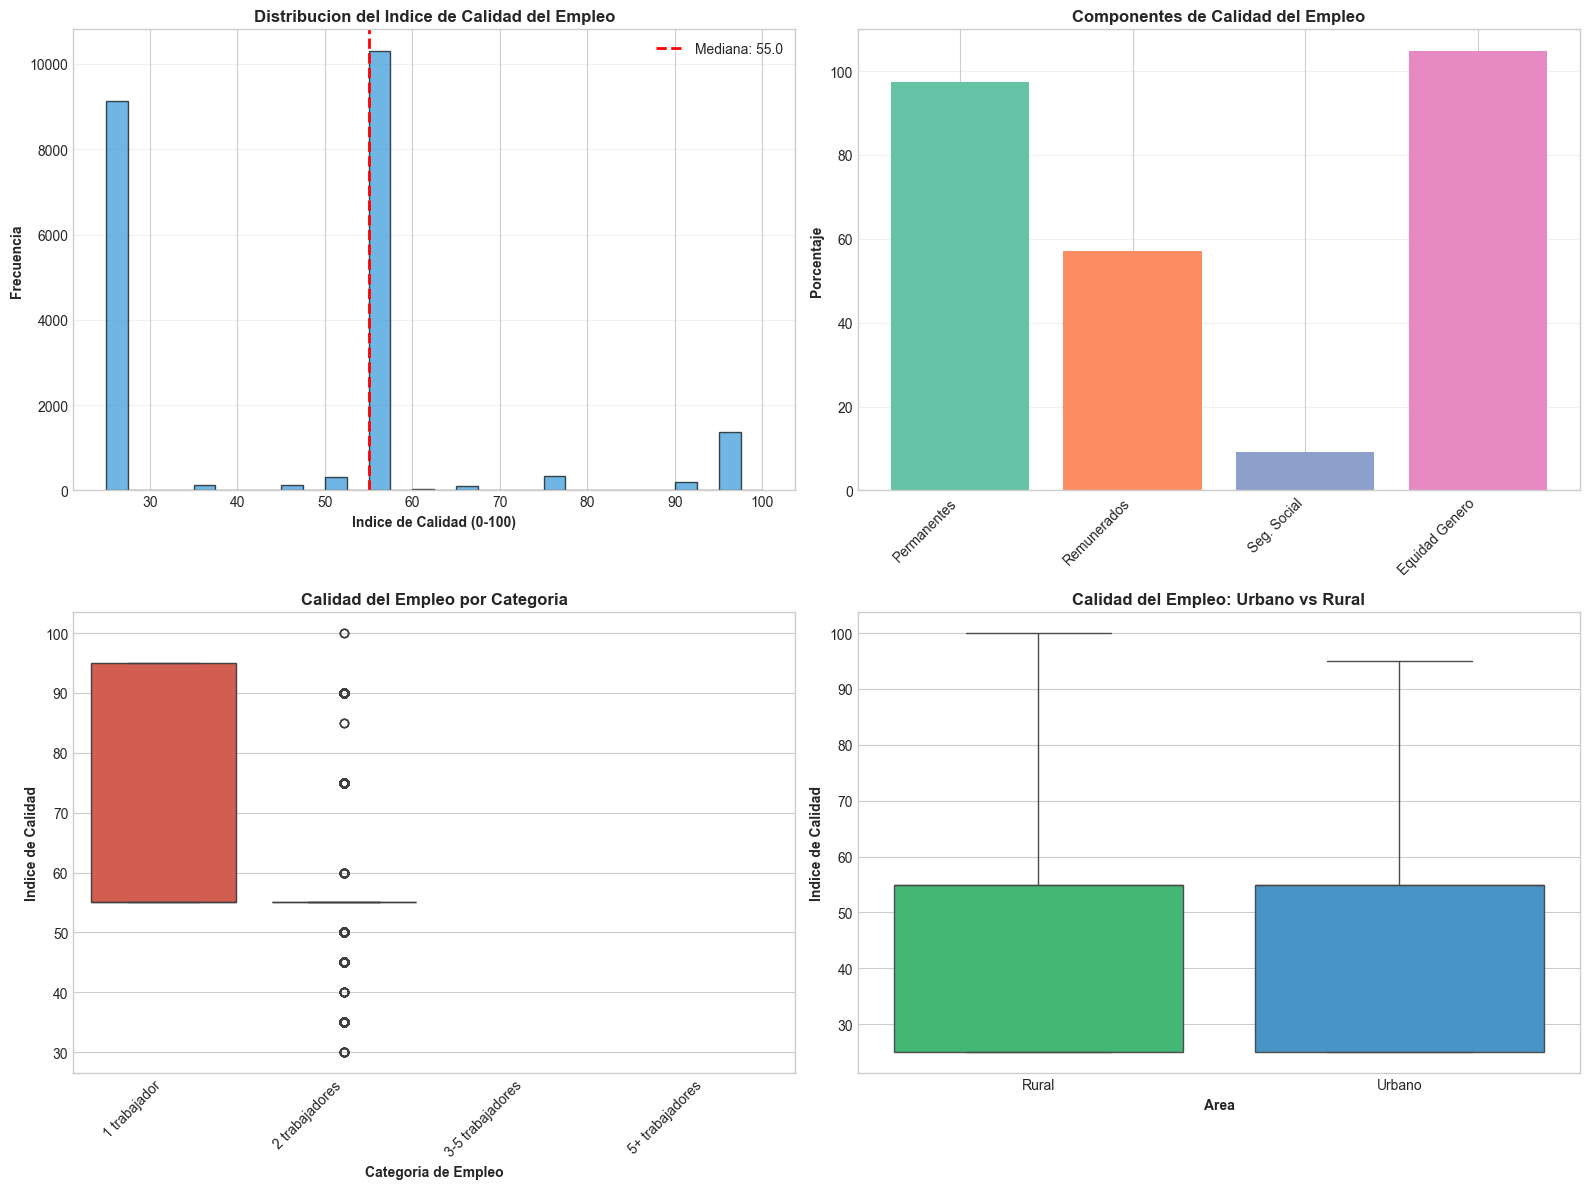


[10/10] Proceso completado

RESUMEN FINAL

Archivos generados en 'LIMPIOS/':
   - personal_ocupado_detalle.csv (22,101 x 37)
   - personal_ocupado_agregado.csv (12,878 x 15)
   - eda_personal_01_distribucion.png
   - eda_personal_02_vinculo.png
   - eda_personal_03_genero.png
   - eda_personal_04_formalidad.png
   - eda_personal_05_calidad.png

Insights clave:
   - Promedio trabajadores: 0.99
   - Trabajadores familiares: 143.2%
   - Participacion femenina: 97.6%
   - Con seguridad social: 9.1%
   - Trabajadores remunerados: 57.1%
   - Indice calidad empleo: 55.0/100

Analisis de personal ocupado completado!


In [28]:
#!/usr/bin/env python3
"""
MODULO DE PERSONAL OCUPADO - LIMPIEZA + EDA
EMICRON 2024 - Jupyter Notebook
"""

# Configuracion para Jupyter Notebook
%matplotlib inline

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("MODULO DE PERSONAL OCUPADO - LIMPIEZA + EDA")
print("="*80)

# =============================================================================
# PARTE 1: LIMPIEZA DE DATOS
# =============================================================================
print("\n" + "="*80)
print("PARTE 1: LIMPIEZA DE DATOS")
print("="*80)

INPUT_FILE = 'ORIGINALES/Módulo de personal ocupado.csv'
OUTPUT_DIR = 'LIMPIOS'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Cargar datos
print("\n[1/8] Cargando archivo...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
print(f"   OK Cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# Renombrar
print("\n[2/8] Renombrando columnas...")
RENAME = {
    "DIRECTORIO": "id_micronegocio", "SECUENCIA_PH": "id_personal", 
    "SECUENCIA_P": "id_persona", "SECUENCIA_ENCUESTA": "id_encuesta",
    "TIPO": "tipo_trabajador",
    "P3077": "numero_trabajadores", "P3078": "trabajadores_familiares",
    "P3079": "trabajadores_no_familiares", "P3080": "trabajadores_permanentes",
    "P3081": "trabajadores_temporales", "P3082": "trabajadores_remunerados",
    "P3083": "trabajadores_no_remunerados", "P3084": "trabajadores_mujeres",
    "P2990": "afiliacion_seguridad_social", "P3085": "tipo_contrato", "P3099": "jornada_laboral",
    "CLASE_TE": "clase_territorial", "COD_DEPTO": "codigo_departamento", 
    "AREA": "area", "F_EXP": "factor_expansion"
}
df = df.rename(columns=RENAME)
print(f"   OK Renombradas: {len(RENAME)} columnas")

# Imputacion
print("\n[3/8] Imputando valores perdidos...")
missing_antes = df.isnull().sum().sum()

# Variables numericas de trabajadores con 0
vars_trabajadores = [c for c in df.columns if c.startswith('trabajadores_') or c == 'numero_trabajadores']
for col in vars_trabajadores:
    df[col] = df[col].fillna(0)

# Area por departamento
if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode())>0 else 1))

# Otras variables con moda
for col in ['afiliacion_seguridad_social', 'tipo_contrato', 'jornada_laboral']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0] if len(df[col].mode())>0 else 0)

missing_despues = df.isnull().sum().sum()
print(f"   OK Valores perdidos: {missing_antes:,} -> {missing_despues:,} ({(1-missing_despues/missing_antes)*100:.1f}% reduccion)")

# Winsorizar numero_trabajadores
print("\n[4/8] Aplicando winsorización...")
if 'numero_trabajadores' in df.columns:
    p1, p99 = df['numero_trabajadores'].quantile([0.01, 0.99])
    df['numero_trabajadores_wins'] = df['numero_trabajadores'].clip(p1, p99)
    print(f"   OK Winsorizado numero_trabajadores (P1={p1:.0f}, P99={p99:.0f})")

# Eliminar duplicados
print("\n[5/8] Eliminando duplicados...")
filas_antes = len(df)
df = df.drop_duplicates()
filas_despues = len(df)
print(f"   OK Eliminados: {filas_antes - filas_despues:,}")

# Variables derivadas
print("\n[6/8] Creando variables derivadas...")

DEPTS = {5:'ANTIOQUIA',8:'ATLANTICO',11:'BOGOTA',13:'BOLIVAR',15:'BOYACA',17:'CALDAS',
         18:'CAQUETA',19:'CAUCA',20:'CESAR',23:'CORDOBA',25:'CUNDINAMARCA',27:'CHOCO',
         41:'HUILA',44:'LA GUAJIRA',47:'MAGDALENA',50:'META',52:'NARINO',
         54:'NORTE DE SANTANDER',63:'QUINDIO',66:'RISARALDA',68:'SANTANDER',
         70:'SUCRE',73:'TOLIMA',76:'VALLE DEL CAUCA',81:'ARAUCA'}

if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPTS)
if 'area' in df.columns:
    df['area_urbana'] = (df['area']==1).astype(int)

# Proporciones
if 'numero_trabajadores' in df.columns and 'trabajadores_familiares' in df.columns:
    df['prop_familiares'] = (df['trabajadores_familiares'] / df['numero_trabajadores'].replace(0,1)).clip(0,1)
    df['prop_no_familiares'] = (df['trabajadores_no_familiares'] / df['numero_trabajadores'].replace(0,1)).clip(0,1)
    df['prop_permanentes'] = (df['trabajadores_permanentes'] / df['numero_trabajadores'].replace(0,1)).clip(0,1)
    df['prop_temporales'] = (df['trabajadores_temporales'] / df['numero_trabajadores'].replace(0,1)).clip(0,1)
    df['prop_remunerados'] = (df['trabajadores_remunerados'] / df['numero_trabajadores'].replace(0,1)).clip(0,1)
    df['prop_no_remunerados'] = (df['trabajadores_no_remunerados'] / df['numero_trabajadores'].replace(0,1)).clip(0,1)
    df['prop_mujeres'] = (df['trabajadores_mujeres'] / df['numero_trabajadores'].replace(0,1)).clip(0,1)

# Categoria de tamaño empleo
if 'numero_trabajadores' in df.columns:
    df['categoria_empleo'] = pd.cut(df['numero_trabajadores'], 
                                     bins=[0, 1, 2, 5, 100],
                                     labels=['1 trabajador', '2 trabajadores', '3-5 trabajadores', '5+ trabajadores'])

# Tipo de empleo dominante
df['tipo_empleo_dominante'] = 'Indefinido'
if 'prop_familiares' in df.columns:
    df.loc[df['prop_familiares'] > 0.5, 'tipo_empleo_dominante'] = 'Familiar'
    df.loc[df['prop_no_familiares'] > 0.5, 'tipo_empleo_dominante'] = 'No Familiar'

# Formalidad laboral
df['tiene_remuneracion'] = (df['trabajadores_remunerados'] > 0).astype(int) if 'trabajadores_remunerados' in df.columns else 0
df['tiene_seguridad_social'] = (df['afiliacion_seguridad_social'] == 1).astype(int) if 'afiliacion_seguridad_social' in df.columns else 0
df['formalidad_laboral'] = ((df['tiene_remuneracion'] + df['tiene_seguridad_social']) / 2).clip(0,1)

# Indice de calidad empleo (0-100)
# Componentes: seguridad social (40%), remuneracion (30%), permanencia (20%), equidad genero (10%)
if all(c in df.columns for c in ['prop_remunerados', 'prop_permanentes', 'prop_mujeres']):
    df['indice_calidad_empleo'] = (
        (df['tiene_seguridad_social'] * 40) +
        (df['prop_remunerados'] * 30) +
        (df['prop_permanentes'] * 20) +
        (df['prop_mujeres'].clip(0.3, 0.7).apply(lambda x: 1 if 0.4 <= x <= 0.6 else 0.5) * 10)
    )

print(f"   OK Variables derivadas creadas")

# Agregar a nivel micronegocio
print("\n[7/8] Agregando a nivel micronegocio...")
if 'id_micronegocio' in df.columns:
    df_agg = df.groupby('id_micronegocio').agg({
        'numero_trabajadores': 'sum',
        'trabajadores_familiares': 'sum',
        'trabajadores_no_familiares': 'sum',
        'trabajadores_permanentes': 'sum',
        'trabajadores_temporales': 'sum',
        'trabajadores_remunerados': 'sum',
        'trabajadores_no_remunerados': 'sum',
        'trabajadores_mujeres': 'sum',
        'tiene_seguridad_social': 'max',
        'formalidad_laboral': 'mean',
        'indice_calidad_empleo': 'mean' if 'indice_calidad_empleo' in df.columns else 'first'
    }).reset_index()
    
    # Recalcular proporciones agregadas
    df_agg['prop_familiares'] = (df_agg['trabajadores_familiares'] / df_agg['numero_trabajadores'].replace(0,1)).clip(0,1)
    df_agg['prop_mujeres'] = (df_agg['trabajadores_mujeres'] / df_agg['numero_trabajadores'].replace(0,1)).clip(0,1)
    df_agg['prop_remunerados'] = (df_agg['trabajadores_remunerados'] / df_agg['numero_trabajadores'].replace(0,1)).clip(0,1)
    
    print(f"   OK Agregado: {len(df_agg):,} micronegocios unicos")

# Guardar ambos datasets
output_file_detalle = f'{OUTPUT_DIR}/personal_ocupado_detalle.csv'
output_file_agregado = f'{OUTPUT_DIR}/personal_ocupado_agregado.csv'
df.to_csv(output_file_detalle, index=False, encoding='utf-8-sig')
if 'id_micronegocio' in df.columns:
    df_agg.to_csv(output_file_agregado, index=False, encoding='utf-8-sig')

print(f"\n[8/8] Guardando datasets...")
print(f"   OK Detalle: {output_file_detalle} ({df.shape[0]:,} x {df.shape[1]})")
if 'id_micronegocio' in df.columns:
    print(f"   OK Agregado: {output_file_agregado} ({df_agg.shape[0]:,} x {df_agg.shape[1]})")

# =============================================================================
# PARTE 2: EDA
# =============================================================================
print("\n" + "="*80)
print("PARTE 2: ANALISIS EXPLORATORIO")
print("="*80)

print("\n[9/10] Generando visualizaciones...\n")

# ============================================================================
# VIZ 1: DISTRIBUCION DE TRABAJADORES
# ============================================================================
print("[1/5] Distribucion de trabajadores")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histograma numero de trabajadores
if 'numero_trabajadores' in df.columns:
    axes[0,0].hist(df['numero_trabajadores'].clip(0, 10), bins=20, 
                   color='#3498db', edgecolor='black', alpha=0.7)
    axes[0,0].axvline(df['numero_trabajadores'].mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Media: {df["numero_trabajadores"].mean():.2f}')
    axes[0,0].set_xlabel('Numero de Trabajadores', fontweight='bold')
    axes[0,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,0].set_title('Distribucion del Numero de Trabajadores', fontsize=12, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)

# Categoria empleo
if 'categoria_empleo' in df.columns:
    cat_emp = df['categoria_empleo'].value_counts().sort_index()
    colors1 = ['#e74c3c', '#f39c12', '#3498db', '#27ae60']
    axes[0,1].bar(cat_emp.index.astype(str), cat_emp.values, color=colors1)
    axes[0,1].set_xlabel('Categoria', fontweight='bold')
    axes[0,1].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,1].set_title('Distribucion por Categoria de Empleo', fontsize=12, fontweight='bold')
    plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[0,1].grid(axis='y', alpha=0.3)

# Empleados por departamento
if 'nombre_departamento' in df.columns and 'numero_trabajadores' in df.columns:
    dept_emp = df.groupby('nombre_departamento')['numero_trabajadores'].mean().sort_values(ascending=True).tail(15)
    colors2 = plt.cm.viridis(np.linspace(0, 1, len(dept_emp)))
    dept_emp.plot(kind='barh', ax=axes[1,0], color=colors2)
    axes[1,0].set_xlabel('Promedio de Trabajadores', fontweight='bold')
    axes[1,0].set_title('Empleo por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,0].grid(axis='x', alpha=0.3)

# Urbano vs Rural
if 'area_urbana' in df.columns and 'numero_trabajadores' in df.columns:
    area_labels = {0: 'Rural', 1: 'Urbano'}
    df['area_label'] = df['area_urbana'].map(area_labels)
    sns.boxplot(data=df, x='area_label', y='numero_trabajadores', ax=axes[1,1],
               palette=['#2ecc71', '#3498db'])
    axes[1,1].set_xlabel('Area', fontweight='bold')
    axes[1,1].set_ylabel('Numero de Trabajadores', fontweight='bold')
    axes[1,1].set_title('Empleo: Urbano vs Rural', fontsize=12, fontweight='bold')
    axes[1,1].set_ylim(0, 5)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_personal_01_distribucion.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 2: TIPO DE VINCULO LABORAL
# ============================================================================
print("\n[2/5] Tipo de vinculo laboral")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Familiar vs No familiar
familiar_data = pd.DataFrame({
    'Tipo': ['Familiares', 'No Familiares'],
    'Total': [df['trabajadores_familiares'].sum(), df['trabajadores_no_familiares'].sum()]
})
colors3 = ['#e74c3c', '#3498db']
axes[0,0].bar(familiar_data['Tipo'], familiar_data['Total'], color=colors3)
axes[0,0].set_ylabel('Total de Trabajadores', fontweight='bold')
axes[0,0].set_title('Trabajadores Familiares vs No Familiares', fontsize=12, fontweight='bold')
axes[0,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(familiar_data['Total']):
    axes[0,0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Permanentes vs Temporales
perm_temp = pd.DataFrame({
    'Tipo': ['Permanentes', 'Temporales'],
    'Total': [df['trabajadores_permanentes'].sum(), df['trabajadores_temporales'].sum()]
})
colors4 = ['#27ae60', '#f39c12']
axes[0,1].bar(perm_temp['Tipo'], perm_temp['Total'], color=colors4)
axes[0,1].set_ylabel('Total de Trabajadores', fontweight='bold')
axes[0,1].set_title('Trabajadores Permanentes vs Temporales', fontsize=12, fontweight='bold')
axes[0,1].grid(axis='y', alpha=0.3)
for i, v in enumerate(perm_temp['Total']):
    axes[0,1].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Remunerados vs No remunerados
remun = pd.DataFrame({
    'Tipo': ['Remunerados', 'No Remunerados'],
    'Total': [df['trabajadores_remunerados'].sum(), df['trabajadores_no_remunerados'].sum()]
})
colors5 = ['#2ecc71', '#e74c3c']
axes[1,0].bar(remun['Tipo'], remun['Total'], color=colors5)
axes[1,0].set_ylabel('Total de Trabajadores', fontweight='bold')
axes[1,0].set_title('Trabajadores Remunerados vs No Remunerados', fontsize=12, fontweight='bold')
axes[1,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(remun['Total']):
    axes[1,0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Tipo empleo dominante
if 'tipo_empleo_dominante' in df.columns:
    tipo_dom = df['tipo_empleo_dominante'].value_counts()
    colors6 = {'Familiar': '#e74c3c', 'No Familiar': '#3498db', 'Indefinido': '#95a5a6'}
    axes[1,1].bar(tipo_dom.index, tipo_dom.values,
                  color=[colors6.get(x, '#95a5a6') for x in tipo_dom.index])
    axes[1,1].set_ylabel('Numero de Negocios', fontweight='bold')
    axes[1,1].set_title('Tipo de Empleo Dominante', fontsize=12, fontweight='bold')
    axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_personal_02_vinculo.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 3: EQUIDAD DE GENERO
# ============================================================================
print("\n[3/5] Equidad de genero")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribucion proporcion mujeres
if 'prop_mujeres' in df.columns:
    axes[0,0].hist(df['prop_mujeres'].dropna(), bins=30, color='#e91e63', edgecolor='black', alpha=0.7)
    axes[0,0].axvline(df['prop_mujeres'].mean(), color='green', linestyle='--', linewidth=2,
                      label=f'Media: {df["prop_mujeres"].mean():.2%}')
    axes[0,0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Paridad')
    axes[0,0].set_xlabel('Proporcion de Mujeres', fontweight='bold')
    axes[0,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,0].set_title('Distribucion de Participacion Femenina', fontsize=12, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)

# Total trabajadores por genero
total_trabajadores = max(0, df['numero_trabajadores'].sum())
total_mujeres = max(0, df['trabajadores_mujeres'].sum())
total_hombres = max(0, total_trabajadores - total_mujeres)

# Validar que todos los valores sean no negativos
if total_trabajadores > 0 and total_mujeres >= 0 and total_hombres >= 0 and (total_mujeres + total_hombres) > 0:
    genero_data = pd.Series({'Mujeres': total_mujeres, 'Hombres': total_hombres})
    # Filtrar valores positivos
    genero_data = genero_data[genero_data > 0]
    
    if len(genero_data) > 0:
        colors7 = ['#e91e63', '#2196F3'][:len(genero_data)]
        axes[0,1].pie(genero_data.values, labels=genero_data.index, autopct='%1.1f%%',
                      startangle=90, colors=colors7, shadow=True)
        axes[0,1].set_title(f'Distribucion por Genero\n({total_trabajadores:,.0f} trabajadores)', 
                            fontsize=12, fontweight='bold')
    else:
        axes[0,1].text(0.5, 0.5, 'Datos de genero no disponibles', 
                       ha='center', va='center', fontsize=12)
        axes[0,1].set_title('Distribucion por Genero', fontsize=12, fontweight='bold')
else:
    axes[0,1].text(0.5, 0.5, 'Datos de genero no disponibles', 
                   ha='center', va='center', fontsize=12)
    axes[0,1].set_title('Distribucion por Genero', fontsize=12, fontweight='bold')

# Participacion femenina por departamento
if 'nombre_departamento' in df.columns and 'prop_mujeres' in df.columns:
    dept_muj = df.groupby('nombre_departamento')['prop_mujeres'].mean().sort_values(ascending=True).tail(15)
    colors8 = plt.cm.RdPu(np.linspace(0.3, 0.9, len(dept_muj)))
    dept_muj.plot(kind='barh', ax=axes[1,0], color=colors8)
    axes[1,0].axvline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[1,0].set_xlabel('Proporcion de Mujeres', fontweight='bold')
    axes[1,0].set_title('Participacion Femenina por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,0].grid(axis='x', alpha=0.3)

# Mujeres en familiar vs no familiar
if all(c in df.columns for c in ['tipo_empleo_dominante', 'prop_mujeres']):
    sns.boxplot(data=df, x='tipo_empleo_dominante', y='prop_mujeres', ax=axes[1,1],
               palette=['#e74c3c', '#3498db', '#95a5a6'])
    axes[1,1].axhline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[1,1].set_xlabel('Tipo de Empleo', fontweight='bold')
    axes[1,1].set_ylabel('Proporcion de Mujeres', fontweight='bold')
    axes[1,1].set_title('Equidad de Genero por Tipo de Empleo', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_personal_03_genero.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 4: FORMALIDAD LABORAL
# ============================================================================
print("\n[4/5] Formalidad laboral")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Seguridad social
if 'tiene_seguridad_social' in df.columns:
    seg_soc = pd.Series({
        'Con seguridad social': df['tiene_seguridad_social'].sum(),
        'Sin seguridad social': (1-df['tiene_seguridad_social']).sum()
    })
    colors9 = ['#27ae60', '#e74c3c']
    axes[0,0].pie(seg_soc.values, labels=seg_soc.index, autopct='%1.1f%%',
                  startangle=90, colors=colors9, shadow=True)
    axes[0,0].set_title(f'Afiliacion a Seguridad Social\n({seg_soc["Con seguridad social"]:,} afiliados)', 
                        fontsize=12, fontweight='bold')

# Indice formalidad laboral
if 'formalidad_laboral' in df.columns:
    axes[0,1].hist(df['formalidad_laboral'].dropna(), bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
    axes[0,1].axvline(df['formalidad_laboral'].median(), color='red', linestyle='--', linewidth=2,
                      label=f'Mediana: {df["formalidad_laboral"].median():.2f}')
    axes[0,1].set_xlabel('Indice de Formalidad (0-1)', fontweight='bold')
    axes[0,1].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,1].set_title('Distribucion de Formalidad Laboral', fontsize=12, fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(axis='y', alpha=0.3)

# Proporcion remunerados
if 'prop_remunerados' in df.columns:
    axes[1,0].hist(df['prop_remunerados'].dropna(), bins=30, color='#27ae60', edgecolor='black', alpha=0.7)
    axes[1,0].axvline(df['prop_remunerados'].mean(), color='red', linestyle='--', linewidth=2,
                      label=f'Media: {df["prop_remunerados"].mean():.2%}')
    axes[1,0].set_xlabel('Proporcion Remunerados', fontweight='bold')
    axes[1,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[1,0].set_title('Distribucion de Trabajadores Remunerados', fontsize=12, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(axis='y', alpha=0.3)

# Formalidad por departamento
if 'nombre_departamento' in df.columns and 'formalidad_laboral' in df.columns:
    dept_form = df.groupby('nombre_departamento')['formalidad_laboral'].mean().sort_values(ascending=True).tail(15)
    colors10 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(dept_form)))
    dept_form.plot(kind='barh', ax=axes[1,1], color=colors10)
    axes[1,1].set_xlabel('Indice de Formalidad', fontweight='bold')
    axes[1,1].set_title('Formalidad Laboral por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_personal_04_formalidad.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 5: CALIDAD DEL EMPLEO
# ============================================================================
print("\n[5/5] Calidad del empleo")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Indice calidad empleo
if 'indice_calidad_empleo' in df.columns:
    axes[0,0].hist(df['indice_calidad_empleo'].dropna(), bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    axes[0,0].axvline(df['indice_calidad_empleo'].median(), color='red', linestyle='--', linewidth=2,
                      label=f'Mediana: {df["indice_calidad_empleo"].median():.1f}')
    axes[0,0].set_xlabel('Indice de Calidad (0-100)', fontweight='bold')
    axes[0,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,0].set_title('Distribucion del Indice de Calidad del Empleo', fontsize=12, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)

# Componentes de calidad
componentes = {
    'Permanentes': df['prop_permanentes'].mean() * 100 if 'prop_permanentes' in df.columns else 0,
    'Remunerados': df['prop_remunerados'].mean() * 100 if 'prop_remunerados' in df.columns else 0,
    'Seg. Social': df['tiene_seguridad_social'].mean() * 100 if 'tiene_seguridad_social' in df.columns else 0,
    'Equidad Genero': (1 - abs(0.5 - df['prop_mujeres'].mean())) * 200 if 'prop_mujeres' in df.columns else 0
}
colors11 = sns.color_palette("Set2", len(componentes))
axes[0,1].bar(componentes.keys(), componentes.values(), color=colors11)
axes[0,1].set_ylabel('Porcentaje', fontweight='bold')
axes[0,1].set_title('Componentes de Calidad del Empleo', fontsize=12, fontweight='bold')
axes[0,1].grid(axis='y', alpha=0.3)
plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Calidad por categoria empleo
if 'categoria_empleo' in df.columns and 'indice_calidad_empleo' in df.columns:
    sns.boxplot(data=df, x='categoria_empleo', y='indice_calidad_empleo', ax=axes[1,0],
               palette=['#e74c3c', '#f39c12', '#3498db', '#27ae60'])
    axes[1,0].set_xlabel('Categoria de Empleo', fontweight='bold')
    axes[1,0].set_ylabel('Indice de Calidad', fontweight='bold')
    axes[1,0].set_title('Calidad del Empleo por Categoria', fontsize=12, fontweight='bold')
    plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Calidad urbano-rural
if 'area_urbana' in df.columns and 'indice_calidad_empleo' in df.columns:
    area_labels = {0: 'Rural', 1: 'Urbano'}
    df['area_label'] = df['area_urbana'].map(area_labels)
    sns.boxplot(data=df, x='area_label', y='indice_calidad_empleo', ax=axes[1,1],
               palette=['#2ecc71', '#3498db'])
    axes[1,1].set_xlabel('Area', fontweight='bold')
    axes[1,1].set_ylabel('Indice de Calidad', fontweight='bold')
    axes[1,1].set_title('Calidad del Empleo: Urbano vs Rural', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_personal_05_calidad.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n[10/10] Proceso completado\n")
print(f"{'='*80}")
print("RESUMEN FINAL")
print(f"{'='*80}")
print(f"\nArchivos generados en '{OUTPUT_DIR}/':")
print(f"   - personal_ocupado_detalle.csv ({df.shape[0]:,} x {df.shape[1]})")
if 'id_micronegocio' in df.columns:
    print(f"   - personal_ocupado_agregado.csv ({df_agg.shape[0]:,} x {df_agg.shape[1]})")
print(f"   - eda_personal_01_distribucion.png")
print(f"   - eda_personal_02_vinculo.png")
print(f"   - eda_personal_03_genero.png")
print(f"   - eda_personal_04_formalidad.png")
print(f"   - eda_personal_05_calidad.png")

print(f"\nInsights clave:")
print(f"   - Promedio trabajadores: {df['numero_trabajadores'].mean():.2f}")
if 'trabajadores_familiares' in df.columns:
    print(f"   - Trabajadores familiares: {(df['trabajadores_familiares'].sum() / df['numero_trabajadores'].sum())*100:.1f}%")
if 'prop_mujeres' in df.columns:
    print(f"   - Participacion femenina: {df['prop_mujeres'].mean()*100:.1f}%")
if 'tiene_seguridad_social' in df.columns:
    print(f"   - Con seguridad social: {df['tiene_seguridad_social'].mean()*100:.1f}%")
if 'prop_remunerados' in df.columns:
    print(f"   - Trabajadores remunerados: {df['prop_remunerados'].mean()*100:.1f}%")
if 'indice_calidad_empleo' in df.columns:
    print(f"   - Indice calidad empleo: {df['indice_calidad_empleo'].median():.1f}/100")
print(f"{'='*80}\n")
print("Analisis de personal ocupado completado!")


## MODULO MOTIVACION Y TRAYECTORIA DEL EMPRENDIMIENTO

| Codigo DANE | Nombre analitico         | Interpretacion en el TFM                                      | Tipo de preparacion / limpieza |
|------------ |--------------------------|---------------------------------------------------------------|--------------------------------|
| P3050       | motivo_emprendimiento    | Razon principal para iniciar el micronegocio.                 | Codificacion categorica        |
| P3051       | oportunidad_vs_necesidad | Distingue emprendimiento por oportunidad o por necesidad.    | Codificacion binaria           |
| P639        | experiencia_previa       | Experiencia laboral o empresarial previa del emprendedor.    | Codificacion ordinal           |
| P3052       | razon_continuidad        | Motivo para mantener activo el negocio.                      | Codificacion categorica        |
| CLASE_TE    | clase_territorial        | Diferencias estructurales urbano rural.                      | Codificacion categorica        |
| COD_DEPTO   | codigo_departamento      | Segmentacion regional del micronegocio.                      | Target encoding                |
| AREA        | area                     | Ubicacion territorial del negocio.                           | Codificacion binaria           |
| F_EXP       | factor_expansion         | Factor para inferencia poblacional.                          | No usado en ML                 |

## INSIGHTS ESPERADOS MODULO MOTIVACION Y TRAYECTORIA

- Predominio del emprendimiento por necesidad  
  La mayoria de los micronegocios surgen como respuesta a la falta de alternativas laborales formales, mas que por la identificacion de oportunidades de mercado.

- Baja experiencia previa del emprendedor  
  Una proporcion significativa de informantes reporta poca o nula experiencia empresarial previa, lo que sugiere emprendimientos de caracter reactivo y de aprendizaje sobre la marcha.

- Motivos principales para iniciar el negocio  
  Los motivos mas frecuentes incluyen la generacion de ingresos adicionales para el hogar, el deseo de independencia economica y, en muchos casos, que el micronegocio representa la unica opcion disponible.

- Diferencias territoriales urbano rural  
  En zonas rurales se observa un mayor peso del emprendimiento por necesidad, asociado a menores oportunidades laborales, mientras que en areas urbanas aparece una mayor diversidad de motivaciones.


MODULO DE EMPRENDIMIENTO - LIMPIEZA + EDA

PARTE 1: LIMPIEZA DE DATOS

[1/7] Cargando archivo...
   OK Cargado: 78,501 filas x 11 columnas

[2/7] Renombrando columnas...
   OK Renombradas: 11 columnas

[3/7] Imputando valores perdidos...
   OK Valores perdidos: 27,370 -> 0 (100.0% reduccion)

[4/7] Eliminando duplicados...
   OK Eliminados: 9,799

[5/7] Creando variables derivadas...
   OK Variables derivadas creadas

[6/7] Guardando dataset limpio...
   OK Guardado: LIMPIOS/emprendimiento_limpio.csv
   OK Dimensiones: 68,702 x 19

PARTE 2: ANALISIS EXPLORATORIO

[7/7] Generando visualizaciones...

[1/5] Motivacion del emprendimiento


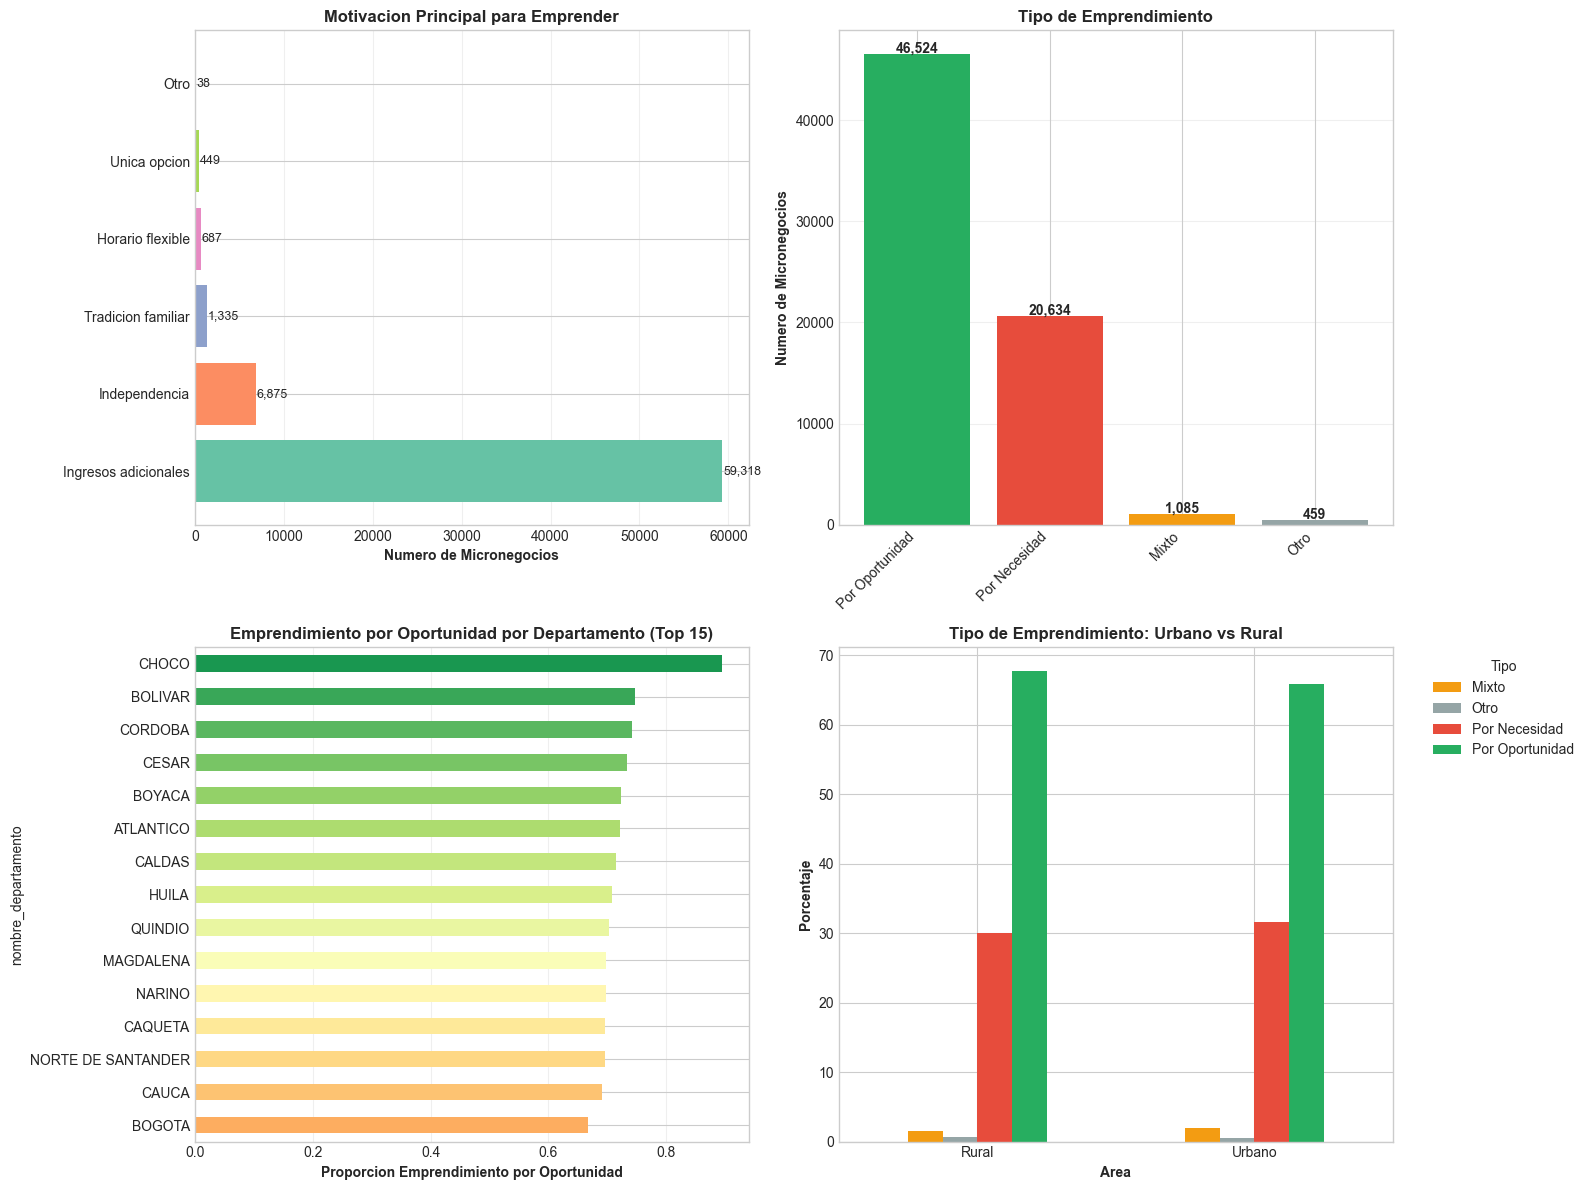


[2/5] Experiencia previa


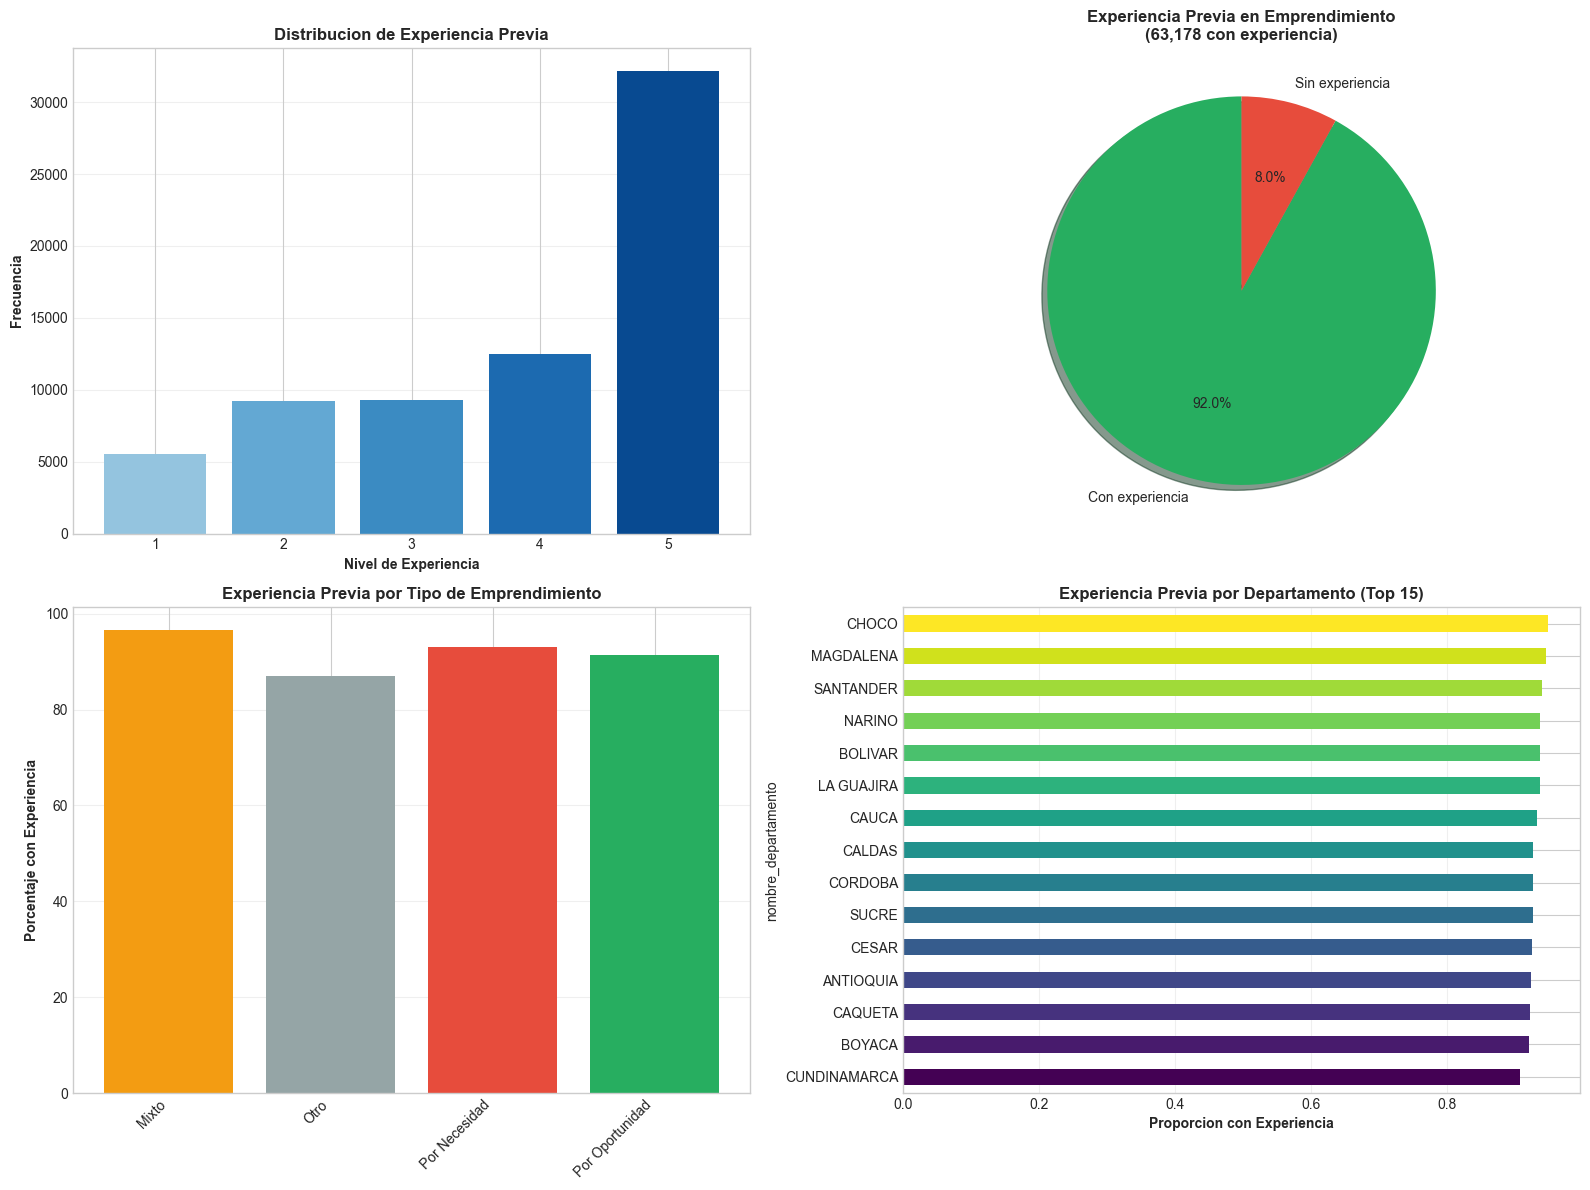


[3/5] Razon de continuidad


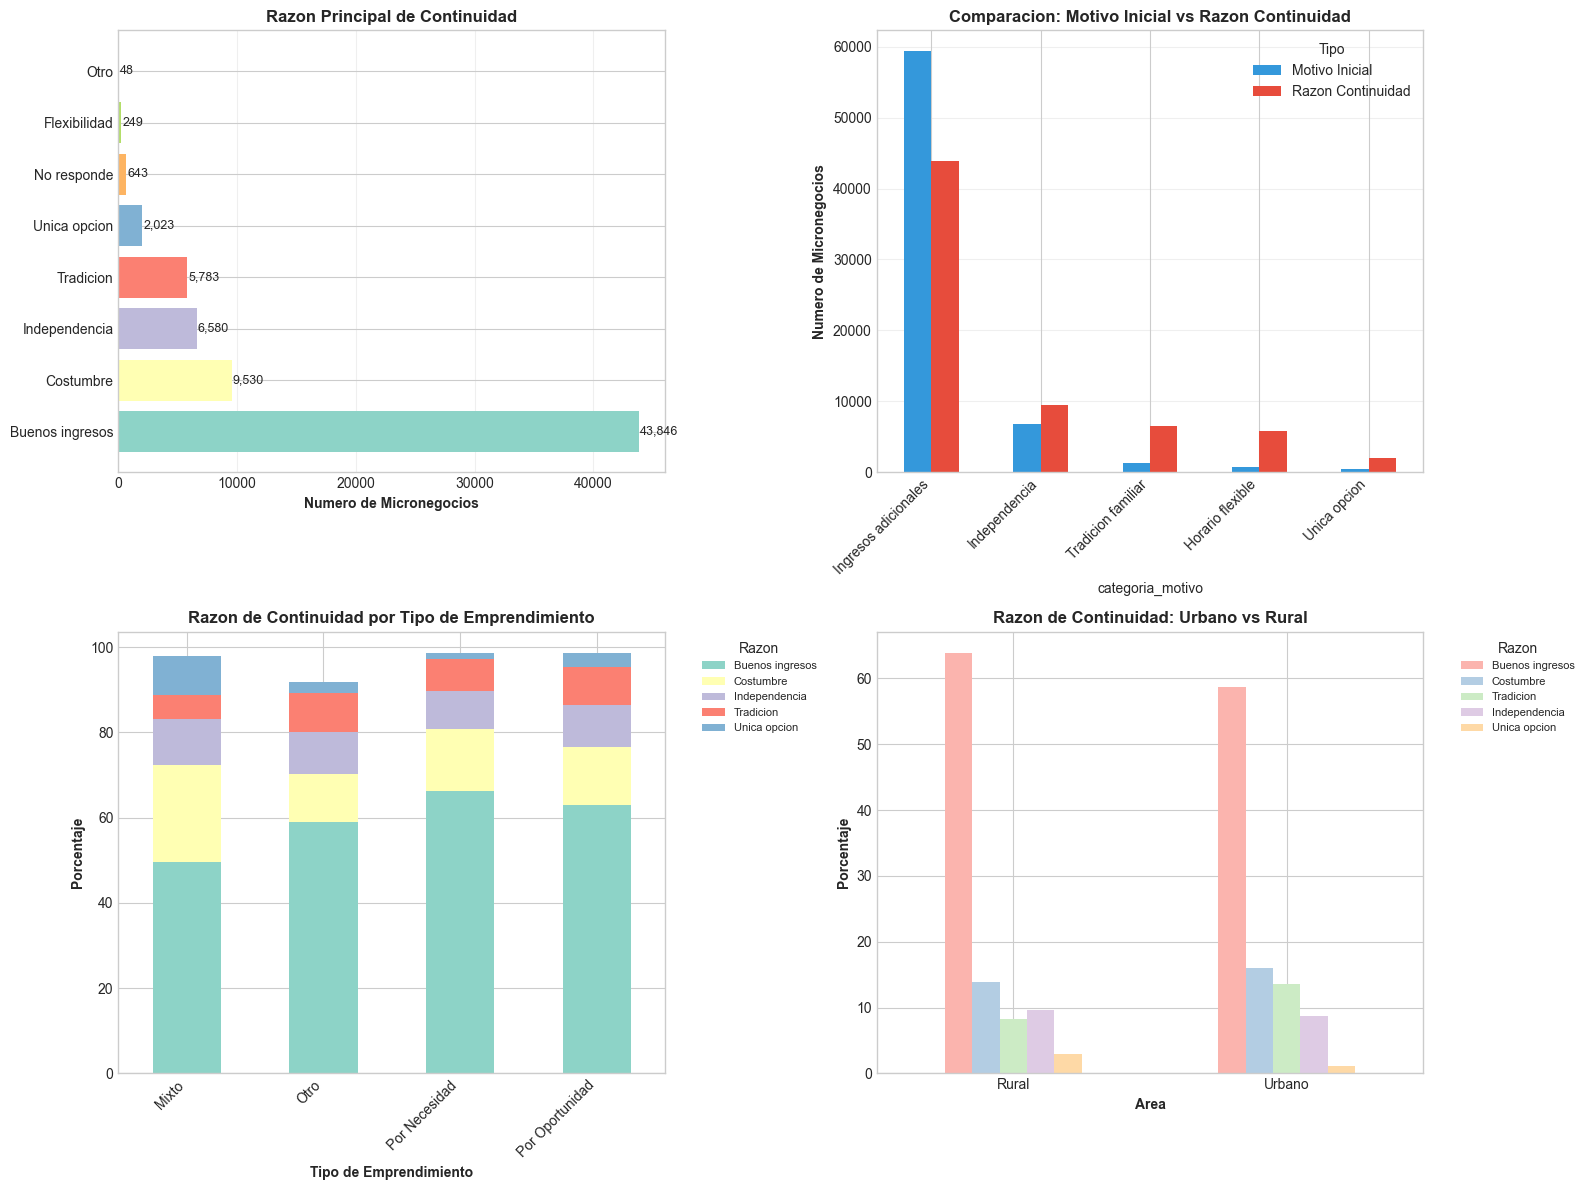


[4/5] Integracion con datos de ingresos


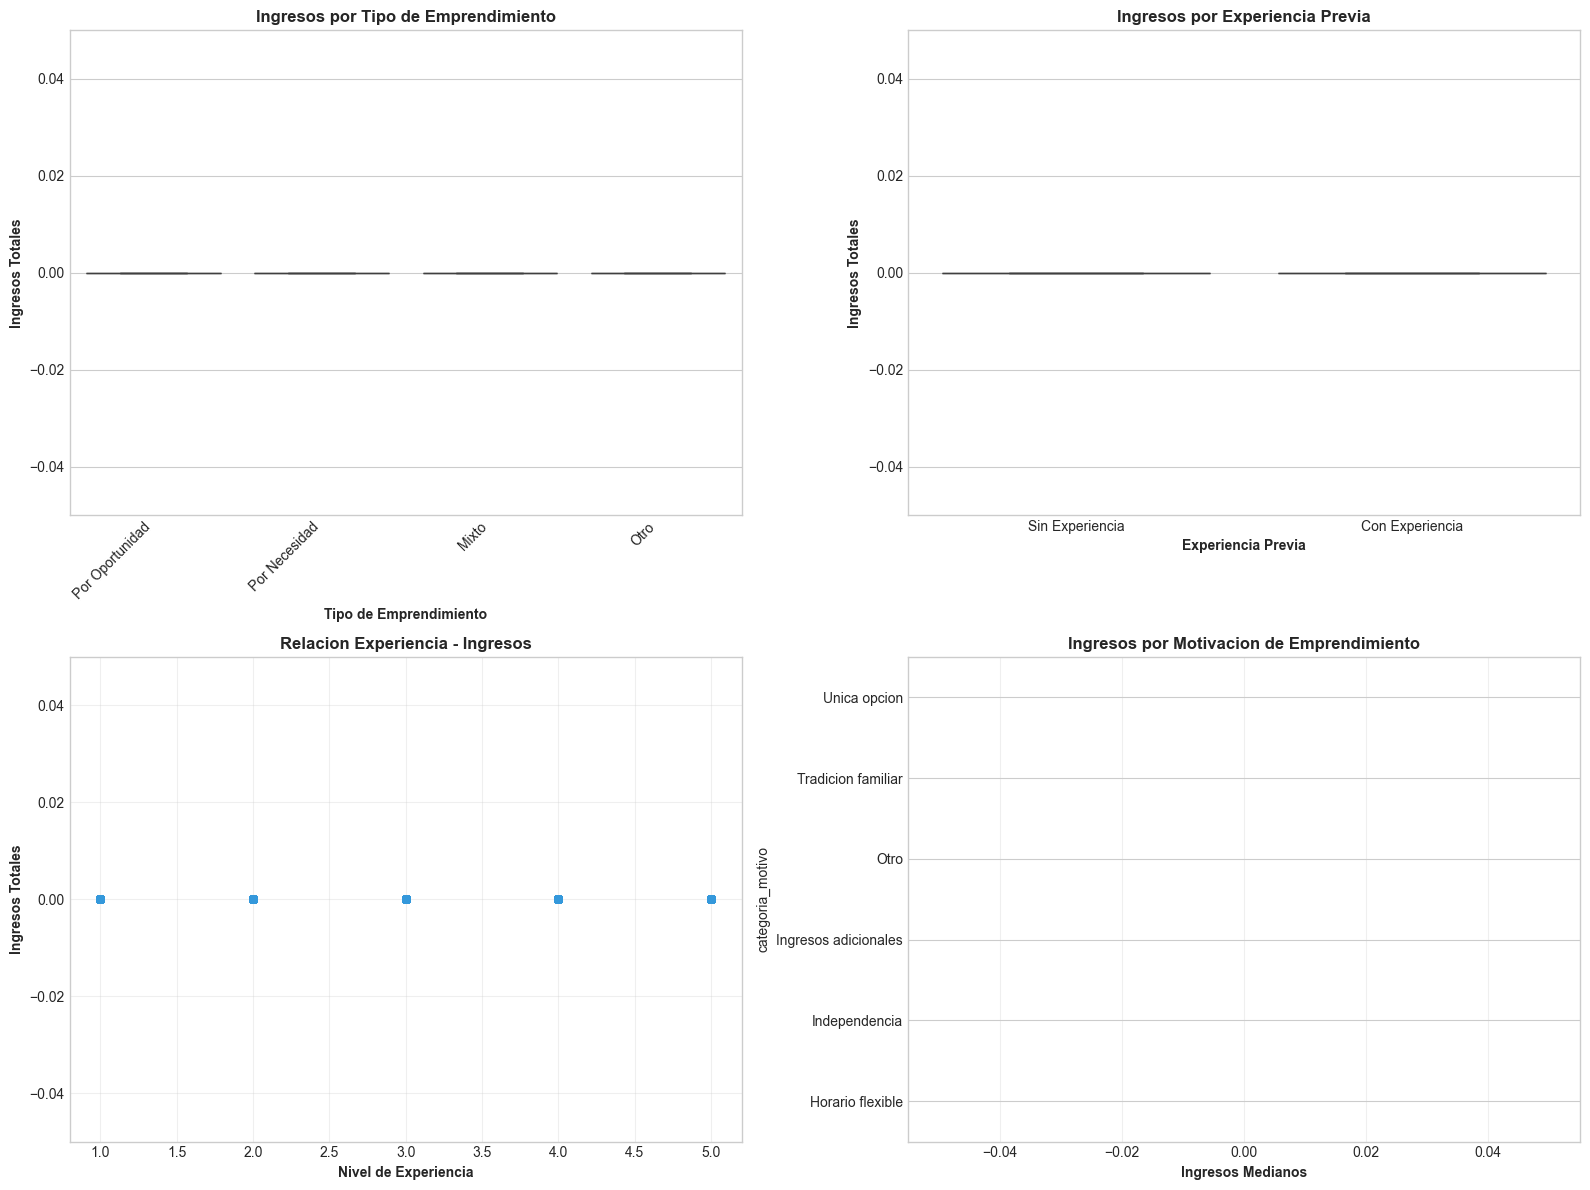


[5/5] Resumen y perfiles emprendedores


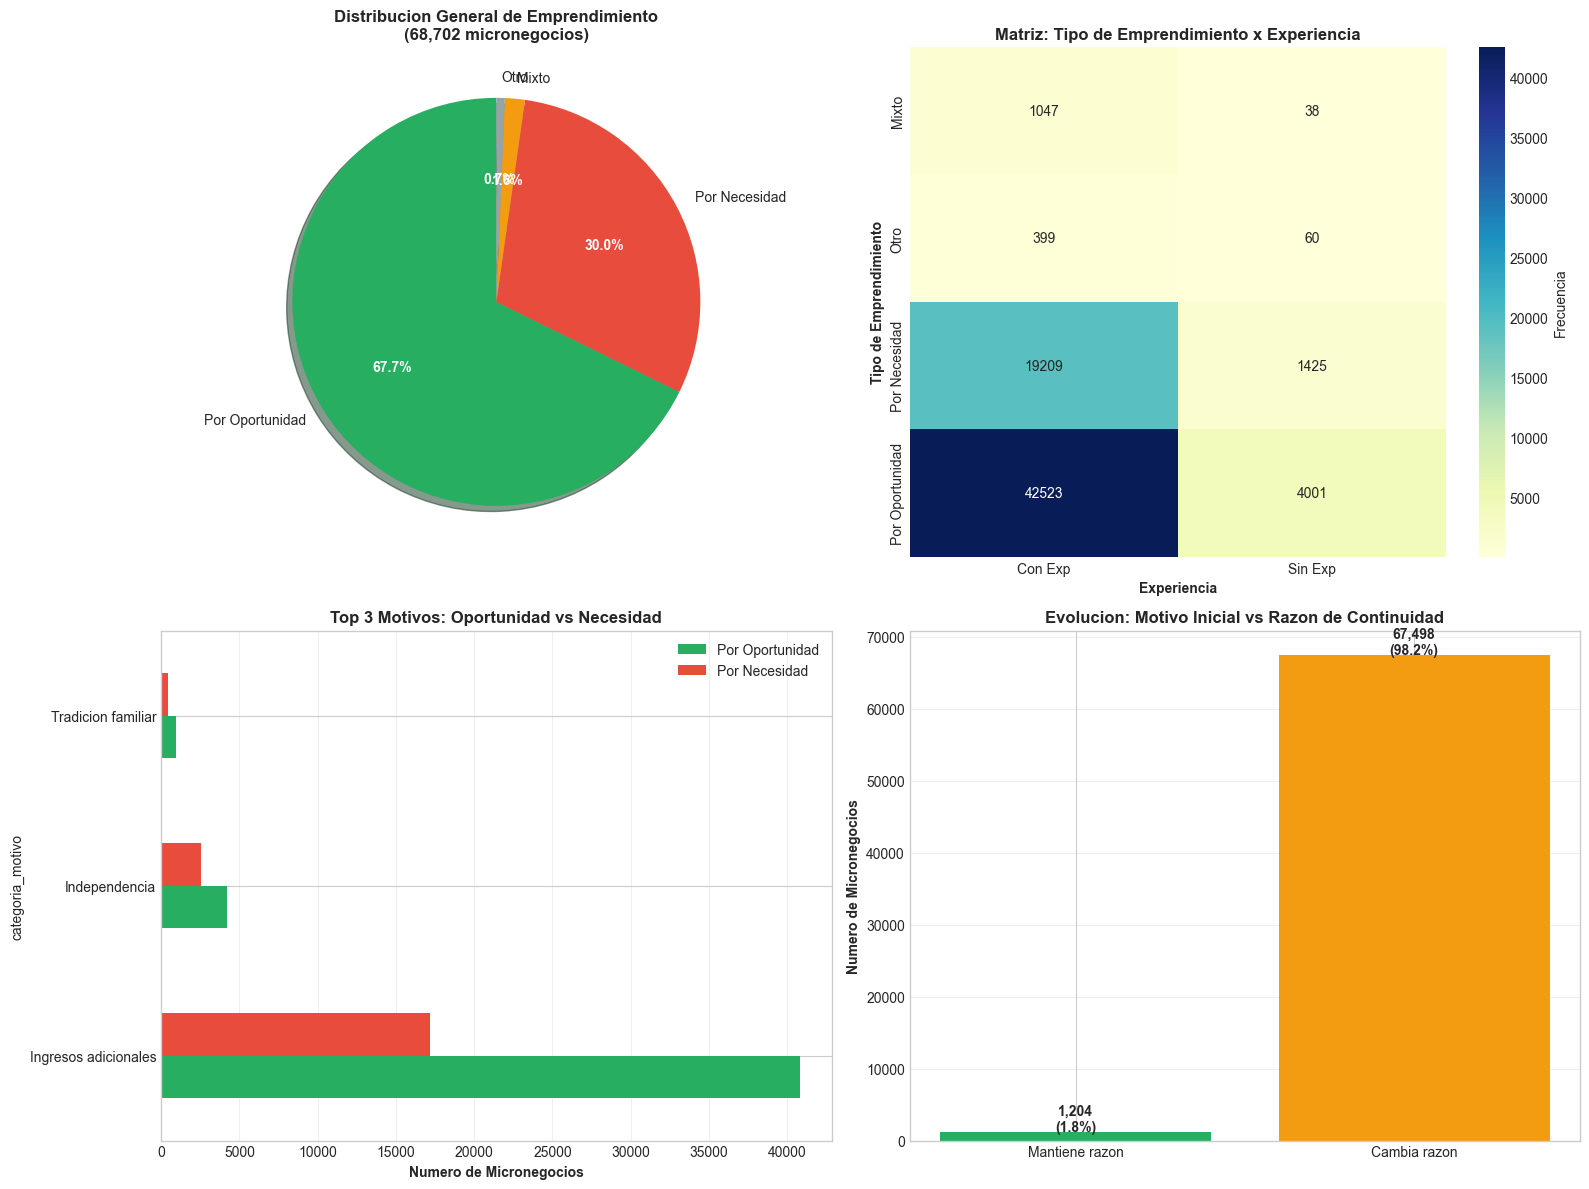


Proceso completado

RESUMEN FINAL

Archivos generados en 'LIMPIOS/':
   - emprendimiento_limpio.csv (68,702 x 19)
   - eda_emprendimiento_01_motivacion.png
   - eda_emprendimiento_02_experiencia.png
   - eda_emprendimiento_03_continuidad.png
   - eda_emprendimiento_04_ingresos.png
   - eda_emprendimiento_05_resumen.png

Insights clave:
   - Emprendimiento por oportunidad: 67.7%
   - Emprendimiento por necesidad: 30.0%
   - Con experiencia previa: 92.0%
   - Motivo principal: Ingresos adicionales
   - Razon continuidad principal: Buenos ingresos

Analisis de emprendimiento completado!


In [5]:
#!/usr/bin/env python3
"""
MODULO DE EMPRENDIMIENTO - LIMPIEZA + EDA
EMICRON 2024 - Jupyter Notebook
"""

# Configuracion para Jupyter Notebook
%matplotlib inline


plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("MODULO DE EMPRENDIMIENTO - LIMPIEZA + EDA")
print("="*80)

# =============================================================================
# PARTE 1: LIMPIEZA DE DATOS
# =============================================================================
print("\n" + "="*80)
print("PARTE 1: LIMPIEZA DE DATOS")
print("="*80)

INPUT_FILE = 'ORIGINALES/Módulo de emprendimiento.csv'
OUTPUT_DIR = 'LIMPIOS'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Cargar datos
print("\n[1/7] Cargando archivo...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
print(f"   OK Cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# Renombrar
print("\n[2/7] Renombrando columnas...")
RENAME = {
    "DIRECTORIO": "id_micronegocio", "SECUENCIA_P": "id_persona", 
    "SECUENCIA_ENCUESTA": "id_encuesta",
    "P3050": "motivo_emprendimiento", "P3051": "oportunidad_necesidad",
    "P639": "experiencia_previa", "P3052": "razon_continuidad",
    "CLASE_TE": "clase_territorial", "COD_DEPTO": "codigo_departamento",
    "AREA": "area", "F_EXP": "factor_expansion"
}
df = df.rename(columns=RENAME)
print(f"   OK Renombradas: {len(RENAME)} columnas")

# Imputacion
print("\n[3/7] Imputando valores perdidos...")
missing_antes = df.isnull().sum().sum()

# Area por departamento
if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode())>0 else 1))

# Variables categoricas con moda
for col in ['motivo_emprendimiento', 'oportunidad_necesidad', 'experiencia_previa', 'razon_continuidad']:
    if col in df.columns:
        moda = df[col].mode()[0] if len(df[col].mode())>0 else 0
        df[col] = df[col].fillna(moda)

missing_despues = df.isnull().sum().sum()
print(f"   OK Valores perdidos: {missing_antes:,} -> {missing_despues:,} ({(1-missing_despues/missing_antes)*100:.1f}% reduccion)")

# Eliminar duplicados
print("\n[4/7] Eliminando duplicados...")
filas_antes = len(df)
df = df.drop_duplicates()
if 'id_micronegocio' in df.columns:
    df = df.drop_duplicates(subset=['id_micronegocio'])
filas_despues = len(df)
print(f"   OK Eliminados: {filas_antes - filas_despues:,}")

# Variables derivadas
print("\n[5/7] Creando variables derivadas...")

DEPTS = {5:'ANTIOQUIA',8:'ATLANTICO',11:'BOGOTA',13:'BOLIVAR',15:'BOYACA',17:'CALDAS',
         18:'CAQUETA',19:'CAUCA',20:'CESAR',23:'CORDOBA',25:'CUNDINAMARCA',27:'CHOCO',
         41:'HUILA',44:'LA GUAJIRA',47:'MAGDALENA',50:'META',52:'NARINO',
         54:'NORTE DE SANTANDER',63:'QUINDIO',66:'RISARALDA',68:'SANTANDER',
         70:'SUCRE',73:'TOLIMA',76:'VALLE DEL CAUCA',81:'ARAUCA'}

if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPTS)
if 'area' in df.columns:
    df['area_urbana'] = (df['area']==1).astype(int)

# Categorizar tipo de emprendimiento
# Basado en documentacion DANE para P3051
if 'oportunidad_necesidad' in df.columns:
    df['tipo_emprendimiento'] = 'Otro'
    df.loc[df['oportunidad_necesidad'].isin([1,2]), 'tipo_emprendimiento'] = 'Por Oportunidad'
    df.loc[df['oportunidad_necesidad'].isin([3,4,5]), 'tipo_emprendimiento'] = 'Por Necesidad'
    df.loc[df['oportunidad_necesidad']==6, 'tipo_emprendimiento'] = 'Mixto'

# Tiene experiencia previa
if 'experiencia_previa' in df.columns:
    df['tiene_experiencia'] = (df['experiencia_previa'] > 1).astype(int)

# Categoria de motivacion
if 'motivo_emprendimiento' in df.columns:
    motivo_map = {
        1: 'Ingresos adicionales',
        2: 'Independencia',
        3: 'Tradicion familiar',
        4: 'Unica opcion',
        5: 'Horario flexible',
        6: 'Otro'
    }
    df['categoria_motivo'] = df['motivo_emprendimiento'].map(motivo_map).fillna('Otro')

# Categoria razon continuidad
if 'razon_continuidad' in df.columns:
    continuidad_map = {
        1: 'Buenos ingresos',
        2: 'Independencia',
        3: 'Tradicion',
        4: 'Unica opcion',
        5: 'Flexibilidad',
        6: 'Costumbre',
        7: 'Otro',
        8: 'No responde'
    }
    df['categoria_continuidad'] = df['razon_continuidad'].map(continuidad_map).fillna('Otro')

# Perfil emprendedor (binario simple)
df['emprendedor_oportunidad'] = (df['tipo_emprendimiento'] == 'Por Oportunidad').astype(int) if 'tipo_emprendimiento' in df.columns else 0
df['emprendedor_necesidad'] = (df['tipo_emprendimiento'] == 'Por Necesidad').astype(int) if 'tipo_emprendimiento' in df.columns else 0

print(f"   OK Variables derivadas creadas")

# Guardar
print("\n[6/7] Guardando dataset limpio...")
output_file = f'{OUTPUT_DIR}/emprendimiento_limpio.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"   OK Guardado: {output_file}")
print(f"   OK Dimensiones: {df.shape[0]:,} x {df.shape[1]}")

# =============================================================================
# PARTE 2: EDA
# =============================================================================
print("\n" + "="*80)
print("PARTE 2: ANALISIS EXPLORATORIO")
print("="*80)

print("\n[7/7] Generando visualizaciones...\n")

# ============================================================================
# VIZ 1: MOTIVACION DEL EMPRENDIMIENTO
# ============================================================================
print("[1/5] Motivacion del emprendimiento")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribucion motivo principal
if 'categoria_motivo' in df.columns:
    motivo_dist = df['categoria_motivo'].value_counts()
    colors1 = sns.color_palette("Set2", len(motivo_dist))
    axes[0,0].barh(motivo_dist.index, motivo_dist.values, color=colors1)
    axes[0,0].set_xlabel('Numero de Micronegocios', fontweight='bold')
    axes[0,0].set_title('Motivacion Principal para Emprender', fontsize=12, fontweight='bold')
    axes[0,0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(motivo_dist.values):
        axes[0,0].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

# Oportunidad vs Necesidad
if 'tipo_emprendimiento' in df.columns:
    tipo_dist = df['tipo_emprendimiento'].value_counts()
    colors2 = {'Por Oportunidad':'#27ae60', 'Por Necesidad':'#e74c3c', 'Mixto':'#f39c12', 'Otro':'#95a5a6'}
    axes[0,1].bar(tipo_dist.index, tipo_dist.values,
                  color=[colors2.get(x, '#95a5a6') for x in tipo_dist.index])
    axes[0,1].set_ylabel('Numero de Micronegocios', fontweight='bold')
    axes[0,1].set_title('Tipo de Emprendimiento', fontsize=12, fontweight='bold')
    plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[0,1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(tipo_dist.values):
        axes[0,1].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Por departamento
if 'nombre_departamento' in df.columns and 'emprendedor_oportunidad' in df.columns:
    dept_opor = df.groupby('nombre_departamento')['emprendedor_oportunidad'].mean().sort_values(ascending=True).tail(15)
    colors3 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(dept_opor)))
    dept_opor.plot(kind='barh', ax=axes[1,0], color=colors3)
    axes[1,0].set_xlabel('Proporcion Emprendimiento por Oportunidad', fontweight='bold')
    axes[1,0].set_title('Emprendimiento por Oportunidad por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,0].grid(axis='x', alpha=0.3)

# Urbano vs Rural
if 'area_urbana' in df.columns and 'tipo_emprendimiento' in df.columns:
    area_tipo = pd.crosstab(df['area_urbana'].map({0:'Rural', 1:'Urbano'}), 
                            df['tipo_emprendimiento'], normalize='index') * 100
    area_tipo.plot(kind='bar', ax=axes[1,1], 
                   color=[colors2.get(x, '#95a5a6') for x in area_tipo.columns])
    axes[1,1].set_xlabel('Area', fontweight='bold')
    axes[1,1].set_ylabel('Porcentaje', fontweight='bold')
    axes[1,1].set_title('Tipo de Emprendimiento: Urbano vs Rural', fontsize=12, fontweight='bold')
    axes[1,1].legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_emprendimiento_01_motivacion.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 2: EXPERIENCIA PREVIA
# ============================================================================
print("\n[2/5] Experiencia previa")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribucion experiencia
if 'experiencia_previa' in df.columns:
    exp_dist = df['experiencia_previa'].value_counts().sort_index()
    axes[0,0].bar(exp_dist.index, exp_dist.values, color=plt.cm.Blues(np.linspace(0.4,0.9,len(exp_dist))))
    axes[0,0].set_xlabel('Nivel de Experiencia', fontweight='bold')
    axes[0,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,0].set_title('Distribucion de Experiencia Previa', fontsize=12, fontweight='bold')
    axes[0,0].grid(axis='y', alpha=0.3)

# Con vs sin experiencia
if 'tiene_experiencia' in df.columns:
    exp_status = pd.Series({
        'Con experiencia': df['tiene_experiencia'].sum(),
        'Sin experiencia': (1-df['tiene_experiencia']).sum()
    })
    colors4 = ['#27ae60', '#e74c3c']
    axes[0,1].pie(exp_status.values, labels=exp_status.index, autopct='%1.1f%%',
                  startangle=90, colors=colors4, shadow=True)
    axes[0,1].set_title(f'Experiencia Previa en Emprendimiento\n({exp_status["Con experiencia"]:,} con experiencia)', 
                        fontsize=12, fontweight='bold')

# Experiencia por tipo emprendimiento
if 'tipo_emprendimiento' in df.columns and 'tiene_experiencia' in df.columns:
    exp_tipo = df.groupby('tipo_emprendimiento')['tiene_experiencia'].mean() * 100
    colors5 = [colors2.get(x, '#95a5a6') for x in exp_tipo.index]
    axes[1,0].bar(exp_tipo.index, exp_tipo.values, color=colors5)
    axes[1,0].set_ylabel('Porcentaje con Experiencia', fontweight='bold')
    axes[1,0].set_title('Experiencia Previa por Tipo de Emprendimiento', fontsize=12, fontweight='bold')
    plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[1,0].grid(axis='y', alpha=0.3)

# Experiencia por departamento
if 'nombre_departamento' in df.columns and 'tiene_experiencia' in df.columns:
    dept_exp = df.groupby('nombre_departamento')['tiene_experiencia'].mean().sort_values(ascending=True).tail(15)
    colors6 = plt.cm.viridis(np.linspace(0, 1, len(dept_exp)))
    dept_exp.plot(kind='barh', ax=axes[1,1], color=colors6)
    axes[1,1].set_xlabel('Proporcion con Experiencia', fontweight='bold')
    axes[1,1].set_title('Experiencia Previa por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_emprendimiento_02_experiencia.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 3: RAZON DE CONTINUIDAD
# ============================================================================
print("\n[3/5] Razon de continuidad")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribucion razon continuidad
if 'categoria_continuidad' in df.columns:
    cont_dist = df['categoria_continuidad'].value_counts()
    colors7 = sns.color_palette("Set3", len(cont_dist))
    axes[0,0].barh(cont_dist.index, cont_dist.values, color=colors7)
    axes[0,0].set_xlabel('Numero de Micronegocios', fontweight='bold')
    axes[0,0].set_title('Razon Principal de Continuidad', fontsize=12, fontweight='bold')
    axes[0,0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(cont_dist.values):
        axes[0,0].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

# Comparacion: Motivo inicial vs Razon continuidad
if 'categoria_motivo' in df.columns and 'categoria_continuidad' in df.columns:
    # Top 5 de cada uno
    top_motivo = df['categoria_motivo'].value_counts().head(5)
    top_continuidad = df['categoria_continuidad'].value_counts().head(5)
    
    comparison_df = pd.DataFrame({
        'Motivo Inicial': top_motivo.values,
        'Razon Continuidad': top_continuidad.values[:len(top_motivo)]
    }, index=top_motivo.index)
    
    comparison_df.plot(kind='bar', ax=axes[0,1], color=['#3498db', '#e74c3c'])
    axes[0,1].set_ylabel('Numero de Micronegocios', fontweight='bold')
    axes[0,1].set_title('Comparacion: Motivo Inicial vs Razon Continuidad', fontsize=12, fontweight='bold')
    axes[0,1].legend(title='Tipo')
    plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[0,1].grid(axis='y', alpha=0.3)

# Continuidad por tipo emprendimiento
if 'tipo_emprendimiento' in df.columns and 'categoria_continuidad' in df.columns:
    cont_tipo = pd.crosstab(df['tipo_emprendimiento'], df['categoria_continuidad'], normalize='index') * 100
    cont_tipo_top = cont_tipo[cont_tipo.sum().nlargest(5).index]
    cont_tipo_top.plot(kind='bar', stacked=True, ax=axes[1,0],
                       color=sns.color_palette("Set3", len(cont_tipo_top.columns)))
    axes[1,0].set_xlabel('Tipo de Emprendimiento', fontweight='bold')
    axes[1,0].set_ylabel('Porcentaje', fontweight='bold')
    axes[1,0].set_title('Razon de Continuidad por Tipo de Emprendimiento', fontsize=12, fontweight='bold')
    axes[1,0].legend(title='Razon', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Urbano vs Rural - Continuidad
if 'area_urbana' in df.columns and 'categoria_continuidad' in df.columns:
    area_cont = pd.crosstab(df['area_urbana'].map({0:'Rural', 1:'Urbano'}),
                           df['categoria_continuidad'], normalize='index') * 100
    area_cont_top = area_cont[area_cont.sum().nlargest(5).index]
    area_cont_top.plot(kind='bar', ax=axes[1,1],
                       color=sns.color_palette("Pastel1", len(area_cont_top.columns)))
    axes[1,1].set_xlabel('Area', fontweight='bold')
    axes[1,1].set_ylabel('Porcentaje', fontweight='bold')
    axes[1,1].set_title('Razon de Continuidad: Urbano vs Rural', fontsize=12, fontweight='bold')
    axes[1,1].legend(title='Razon', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_emprendimiento_03_continuidad.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 4: INTEGRACION CON INGRESOS (SI DISPONIBLE)
# ============================================================================
print("\n[4/5] Integracion con datos de ingresos")

# Intentar cargar modulo de ventas
try:
    df_ventas = pd.read_csv('LIMPIOS/ventas_ingresos_limpio.csv')
    df_merged = df.merge(df_ventas[['id_micronegocio', 'ingresos_totales_declarados']], 
                         on='id_micronegocio', how='left')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Ingresos por tipo emprendimiento
    if 'tipo_emprendimiento' in df_merged.columns:
        sns.boxplot(data=df_merged, x='tipo_emprendimiento', y='ingresos_totales_declarados', 
                   ax=axes[0,0], palette=colors2)
        axes[0,0].set_xlabel('Tipo de Emprendimiento', fontweight='bold')
        axes[0,0].set_ylabel('Ingresos Totales', fontweight='bold')
        axes[0,0].set_title('Ingresos por Tipo de Emprendimiento', fontsize=12, fontweight='bold')
        axes[0,0].set_ylim(0, df_merged['ingresos_totales_declarados'].quantile(0.95))
        plt.setp(axes[0,0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Ingresos: Con vs Sin experiencia
    if 'tiene_experiencia' in df_merged.columns:
        sns.boxplot(data=df_merged, x='tiene_experiencia', y='ingresos_totales_declarados',
                   ax=axes[0,1], palette=['#e74c3c', '#27ae60'])
        axes[0,1].set_xticklabels(['Sin Experiencia', 'Con Experiencia'])
        axes[0,1].set_xlabel('Experiencia Previa', fontweight='bold')
        axes[0,1].set_ylabel('Ingresos Totales', fontweight='bold')
        axes[0,1].set_title('Ingresos por Experiencia Previa', fontsize=12, fontweight='bold')
        axes[0,1].set_ylim(0, df_merged['ingresos_totales_declarados'].quantile(0.95))
    
    # Scatter: Experiencia vs Ingresos
    muestra = df_merged.sample(min(3000, len(df_merged)))
    axes[1,0].scatter(muestra['experiencia_previa'], muestra['ingresos_totales_declarados'],
                     alpha=0.3, s=30, c='#3498db')
    axes[1,0].set_xlabel('Nivel de Experiencia', fontweight='bold')
    axes[1,0].set_ylabel('Ingresos Totales', fontweight='bold')
    axes[1,0].set_title('Relacion Experiencia - Ingresos', fontsize=12, fontweight='bold')
    axes[1,0].grid(alpha=0.3)
    axes[1,0].set_ylim(0, df_merged['ingresos_totales_declarados'].quantile(0.95))
    
    # Ingresos promedio por motivo
    if 'categoria_motivo' in df_merged.columns:
        ing_motivo = df_merged.groupby('categoria_motivo')['ingresos_totales_declarados'].median().sort_values(ascending=True)
        colors8 = sns.color_palette("RdYlGn", len(ing_motivo))
        ing_motivo.plot(kind='barh', ax=axes[1,1], color=colors8)
        axes[1,1].set_xlabel('Ingresos Medianos', fontweight='bold')
        axes[1,1].set_title('Ingresos por Motivacion de Emprendimiento', fontsize=12, fontweight='bold')
        axes[1,1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/eda_emprendimiento_04_ingresos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except:
    print("   Modulo de ventas no disponible para integracion")
    # Crear grafico placeholder
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ax.text(0.5, 0.5, 'Modulo de ventas no disponible\nPara ver graficos de ingresos, asegurate de tener\nel modulo de ventas procesado',
            ha='center', va='center', fontsize=14)
    ax.axis('off')
    plt.savefig(f'{OUTPUT_DIR}/eda_emprendimiento_04_ingresos.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# VIZ 5: RESUMEN Y PERFILES
# ============================================================================
print("\n[5/5] Resumen y perfiles emprendedores")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribucion general
if 'tipo_emprendimiento' in df.columns:
    tipo_general = df['tipo_emprendimiento'].value_counts()
    colors9 = [colors2.get(x, '#95a5a6') for x in tipo_general.index]
    wedges, texts, autotexts = axes[0,0].pie(tipo_general.values, labels=tipo_general.index,
                                              autopct='%1.1f%%', startangle=90, colors=colors9, shadow=True)
    axes[0,0].set_title(f'Distribucion General de Emprendimiento\n({len(df):,} micronegocios)', 
                        fontsize=12, fontweight='bold')
    for at in autotexts:
        at.set_color('white')
        at.set_fontweight('bold')

# Matriz: Tipo x Experiencia
if 'tipo_emprendimiento' in df.columns and 'tiene_experiencia' in df.columns:
    matriz = pd.crosstab(df['tipo_emprendimiento'], 
                        df['tiene_experiencia'].map({0:'Sin Exp', 1:'Con Exp'}))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0,1], cbar_kws={'label': 'Frecuencia'})
    axes[0,1].set_xlabel('Experiencia', fontweight='bold')
    axes[0,1].set_ylabel('Tipo de Emprendimiento', fontweight='bold')
    axes[0,1].set_title('Matriz: Tipo de Emprendimiento x Experiencia', fontsize=12, fontweight='bold')

# Top motivos por tipo
if 'tipo_emprendimiento' in df.columns and 'categoria_motivo' in df.columns:
    tipo_opor = df[df['tipo_emprendimiento']=='Por Oportunidad']['categoria_motivo'].value_counts().head(3)
    tipo_nec = df[df['tipo_emprendimiento']=='Por Necesidad']['categoria_motivo'].value_counts().head(3)
    
    motivos_comp = pd.DataFrame({
        'Por Oportunidad': tipo_opor.values,
        'Por Necesidad': tipo_nec.values[:len(tipo_opor)]
    }, index=tipo_opor.index)
    
    motivos_comp.plot(kind='barh', ax=axes[1,0], color=['#27ae60', '#e74c3c'])
    axes[1,0].set_xlabel('Numero de Micronegocios', fontweight='bold')
    axes[1,0].set_title('Top 3 Motivos: Oportunidad vs Necesidad', fontsize=12, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(axis='x', alpha=0.3)

# Evolucion: Motivo inicial -> Razon continuidad (Sankey simplificado con barras)
if 'categoria_motivo' in df.columns and 'categoria_continuidad' in df.columns:
    # Contar coincidencias
    same_reason = (df['categoria_motivo'] == df['categoria_continuidad']).sum()
    diff_reason = len(df) - same_reason
    
    evol_data = pd.Series({
        'Mantiene razon': same_reason,
        'Cambia razon': diff_reason
    })
    colors10 = ['#27ae60', '#f39c12']
    axes[1,1].bar(evol_data.index, evol_data.values, color=colors10)
    axes[1,1].set_ylabel('Numero de Micronegocios', fontweight='bold')
    axes[1,1].set_title('Evolucion: Motivo Inicial vs Razon de Continuidad', fontsize=12, fontweight='bold')
    axes[1,1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(evol_data.values):
        axes[1,1].text(i, v + 100, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_emprendimiento_05_resumen.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\nProceso completado\n")
print(f"{'='*80}")
print("RESUMEN FINAL")
print(f"{'='*80}")
print(f"\nArchivos generados en '{OUTPUT_DIR}/':")
print(f"   - emprendimiento_limpio.csv ({df.shape[0]:,} x {df.shape[1]})")
print(f"   - eda_emprendimiento_01_motivacion.png")
print(f"   - eda_emprendimiento_02_experiencia.png")
print(f"   - eda_emprendimiento_03_continuidad.png")
print(f"   - eda_emprendimiento_04_ingresos.png")
print(f"   - eda_emprendimiento_05_resumen.png")

print(f"\nInsights clave:")
if 'emprendedor_oportunidad' in df.columns:
    print(f"   - Emprendimiento por oportunidad: {df['emprendedor_oportunidad'].mean()*100:.1f}%")
if 'emprendedor_necesidad' in df.columns:
    print(f"   - Emprendimiento por necesidad: {df['emprendedor_necesidad'].mean()*100:.1f}%")
if 'tiene_experiencia' in df.columns:
    print(f"   - Con experiencia previa: {df['tiene_experiencia'].mean()*100:.1f}%")
if 'categoria_motivo' in df.columns:
    print(f"   - Motivo principal: {df['categoria_motivo'].mode()[0]}")
if 'categoria_continuidad' in df.columns:
    print(f"   - Razon continuidad principal: {df['categoria_continuidad'].mode()[0]}")
print(f"{'='*80}\n")
print("Analisis de emprendimiento completado!")

MODULO DE TIC - LIMPIEZA + EDA

PARTE 1: LIMPIEZA DE DATOS

[1/8] Cargando archivo...
   OK Cargado: 78,501 filas x 35 columnas

[2/8] Renombrando columnas...
   OK Renombradas: 35 columnas

[3/8] Imputando valores perdidos...
   OK Valores perdidos: 980,438 -> 0 (100.0% reduccion)

[4/8] Eliminando duplicados...
   OK Eliminados: 9,799

[5/8] Creando variables derivadas...
   OK Variables derivadas creadas

[6/8] Guardando dataset limpio...
   OK Guardado: LIMPIOS/tic_limpio.csv
   OK Dimensiones: 68,702 x 47

PARTE 2: ANALISIS EXPLORATORIO

[7/8] Generando visualizaciones...

[1/5] Acceso y conectividad


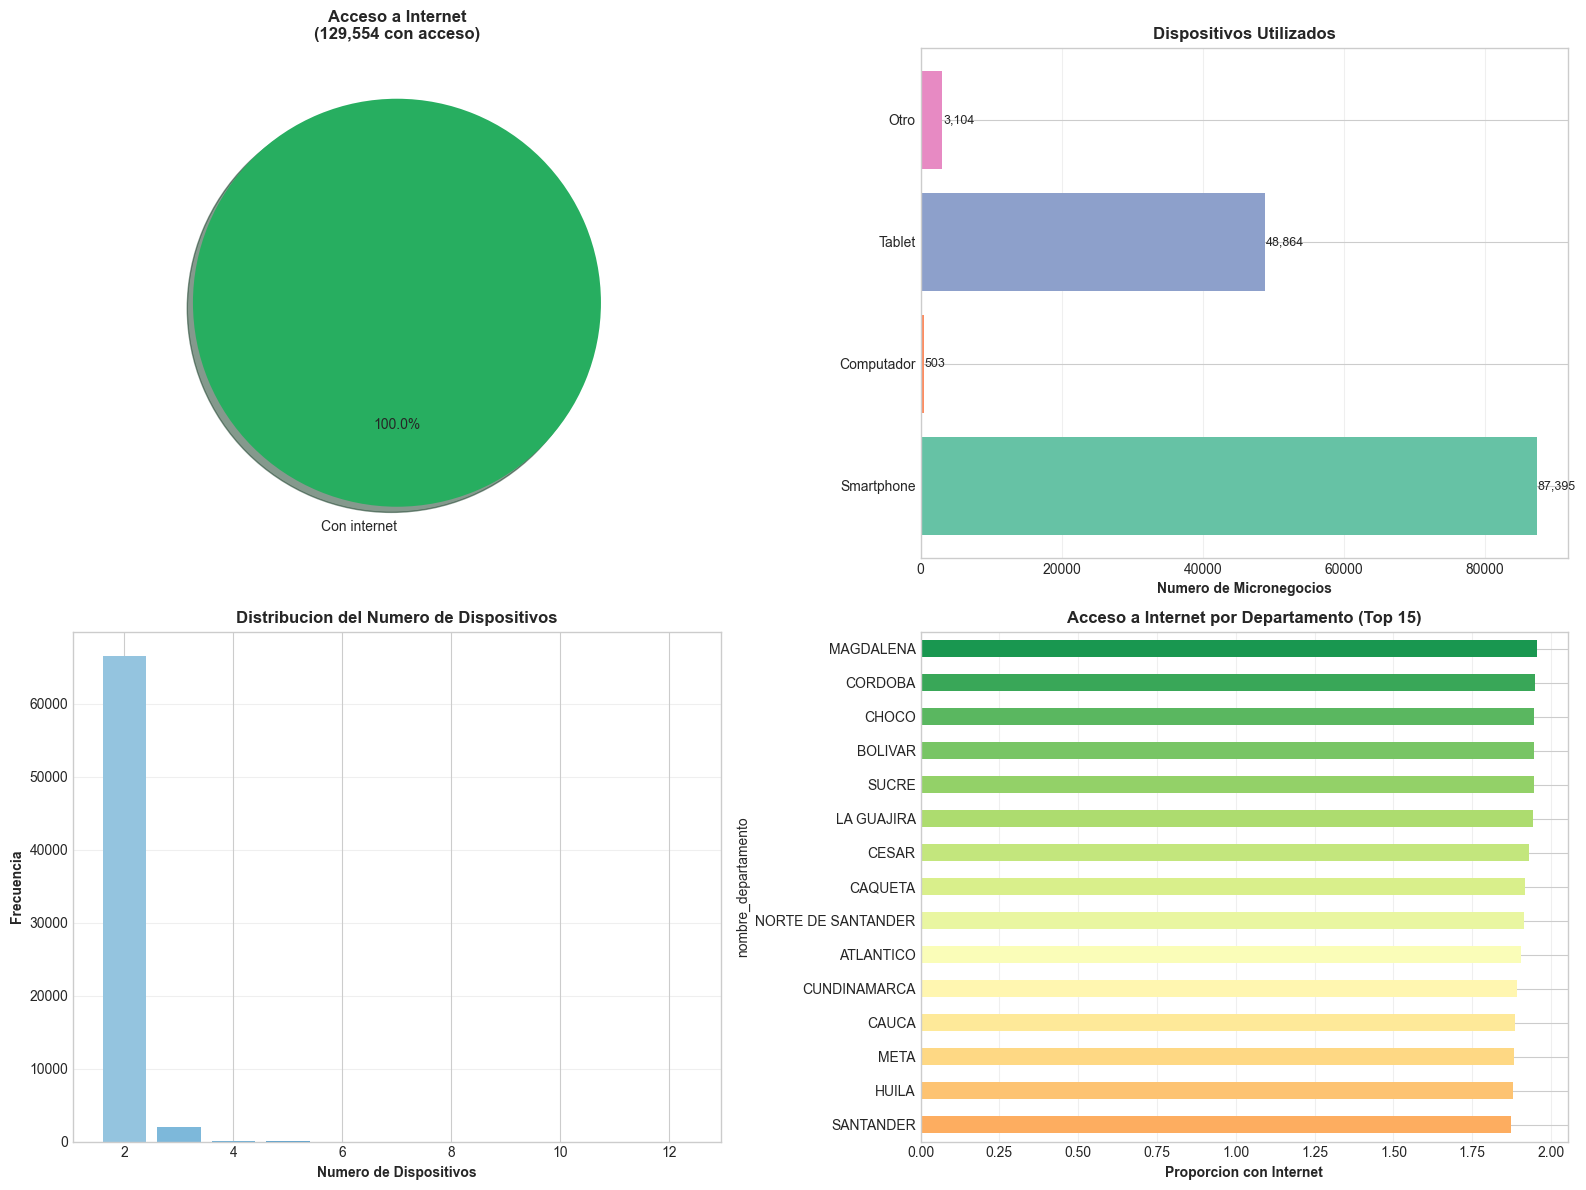


[2/5] Herramientas TIC en el negocio


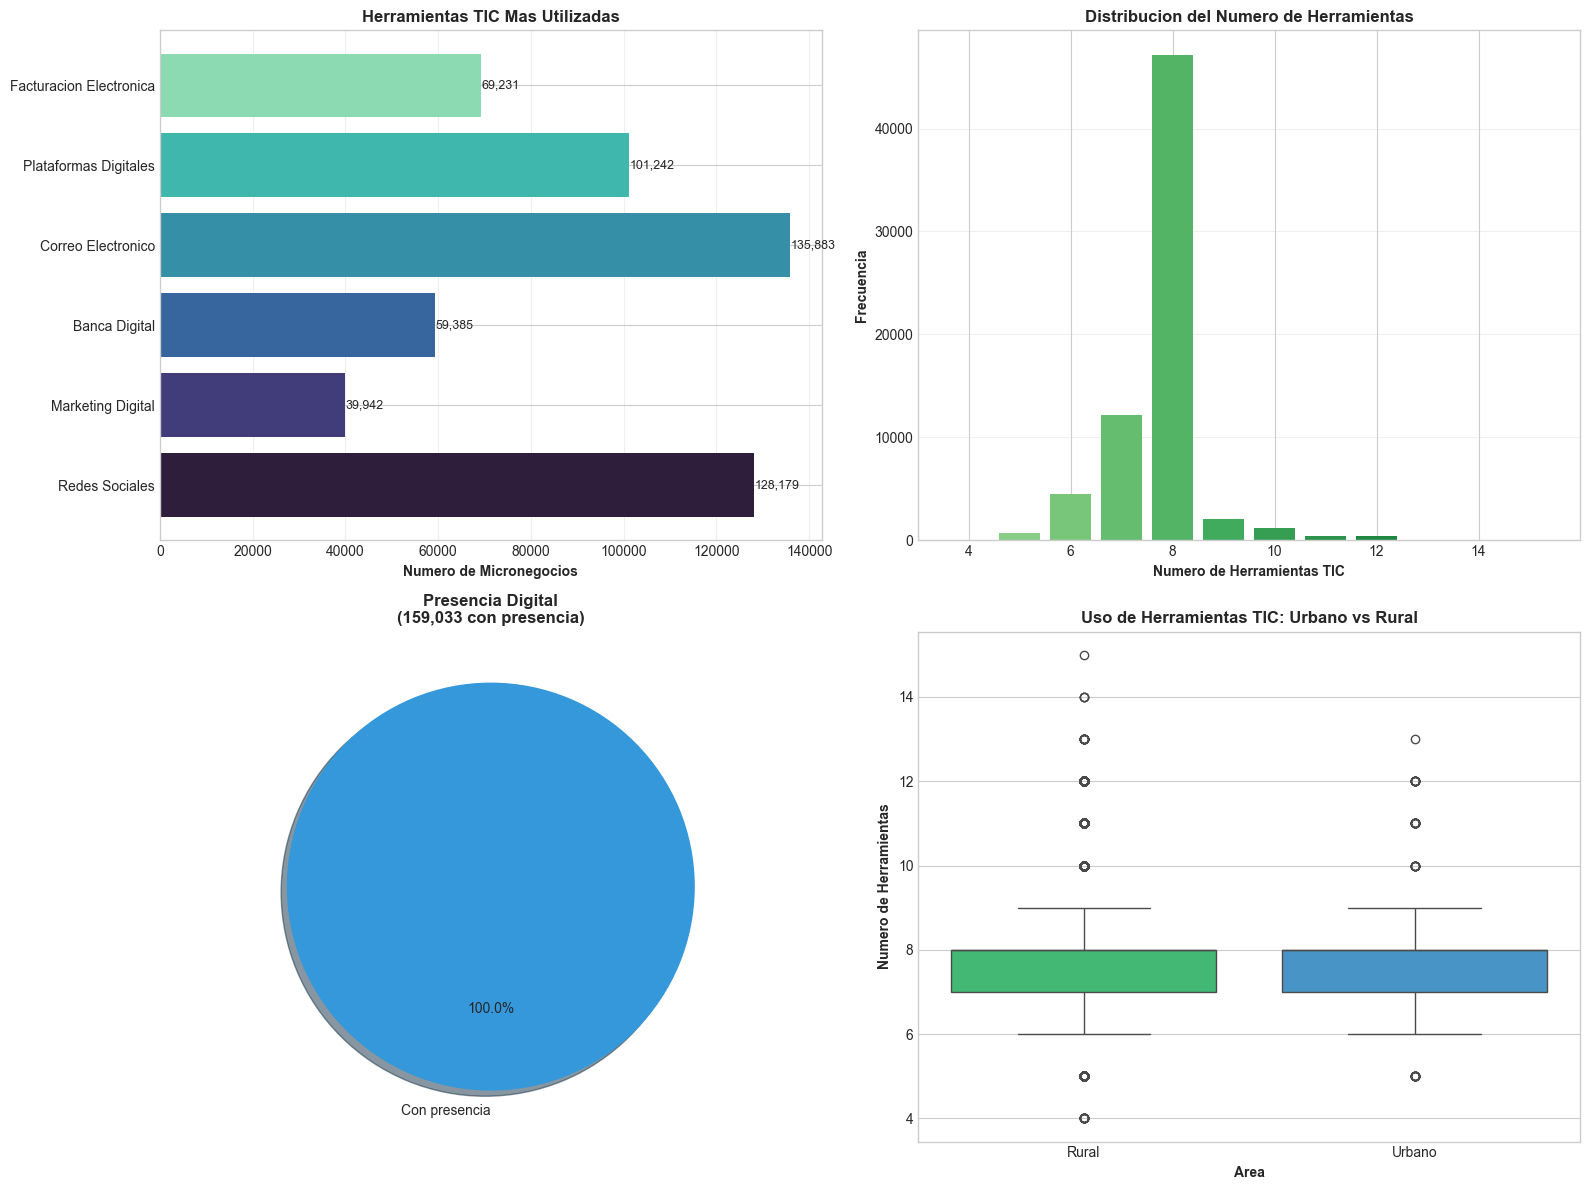


[3/5] Ventas digitales


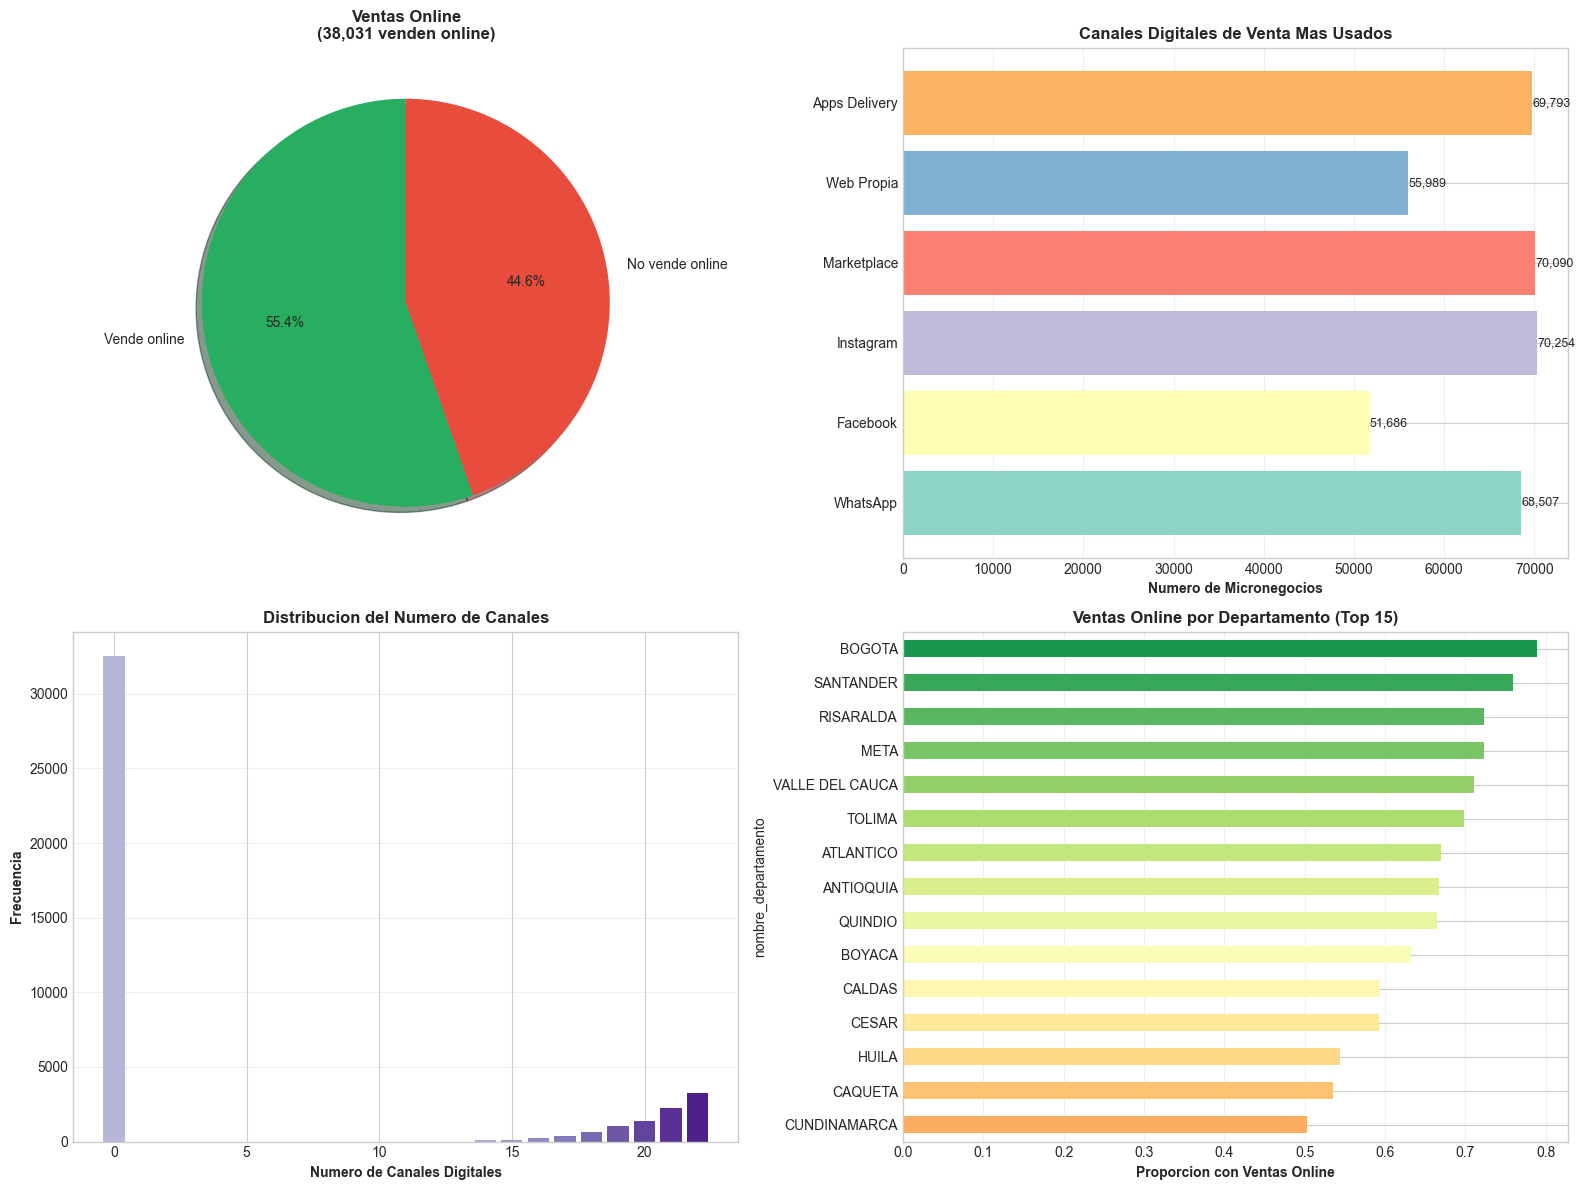


[4/5] Madurez digital


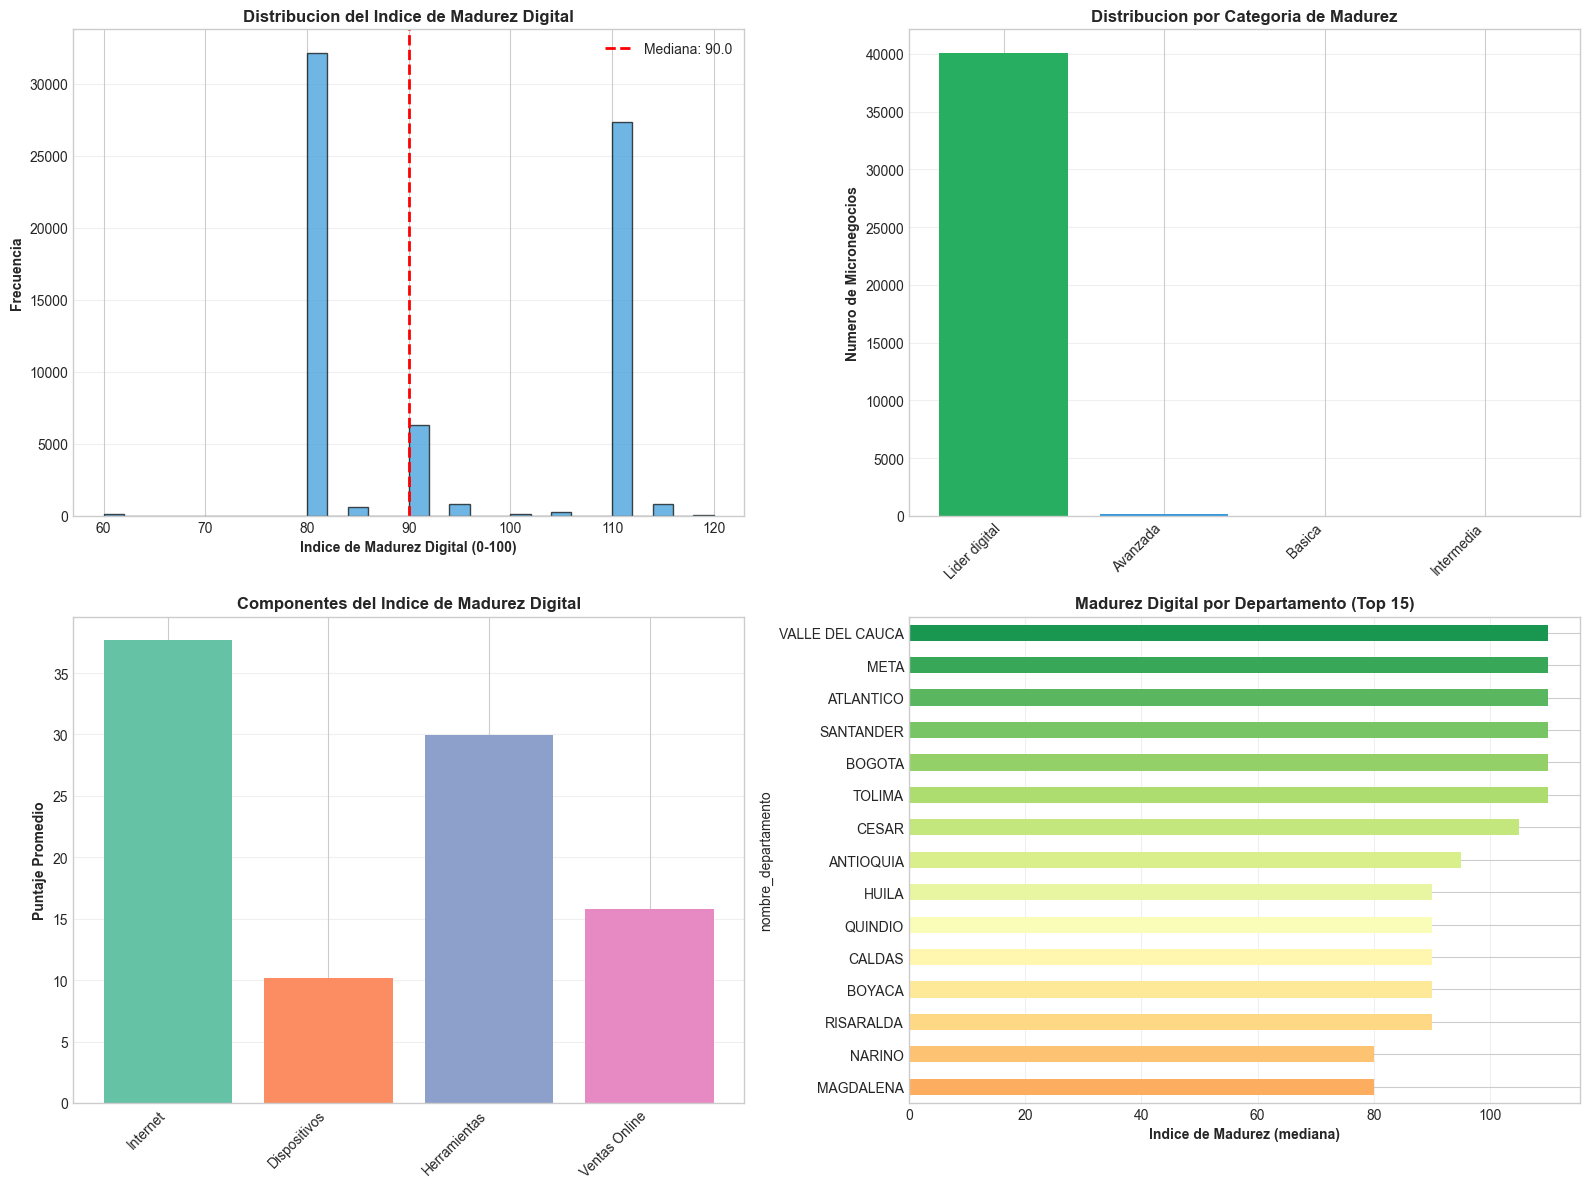


[5/5] Integracion TIC con ventas


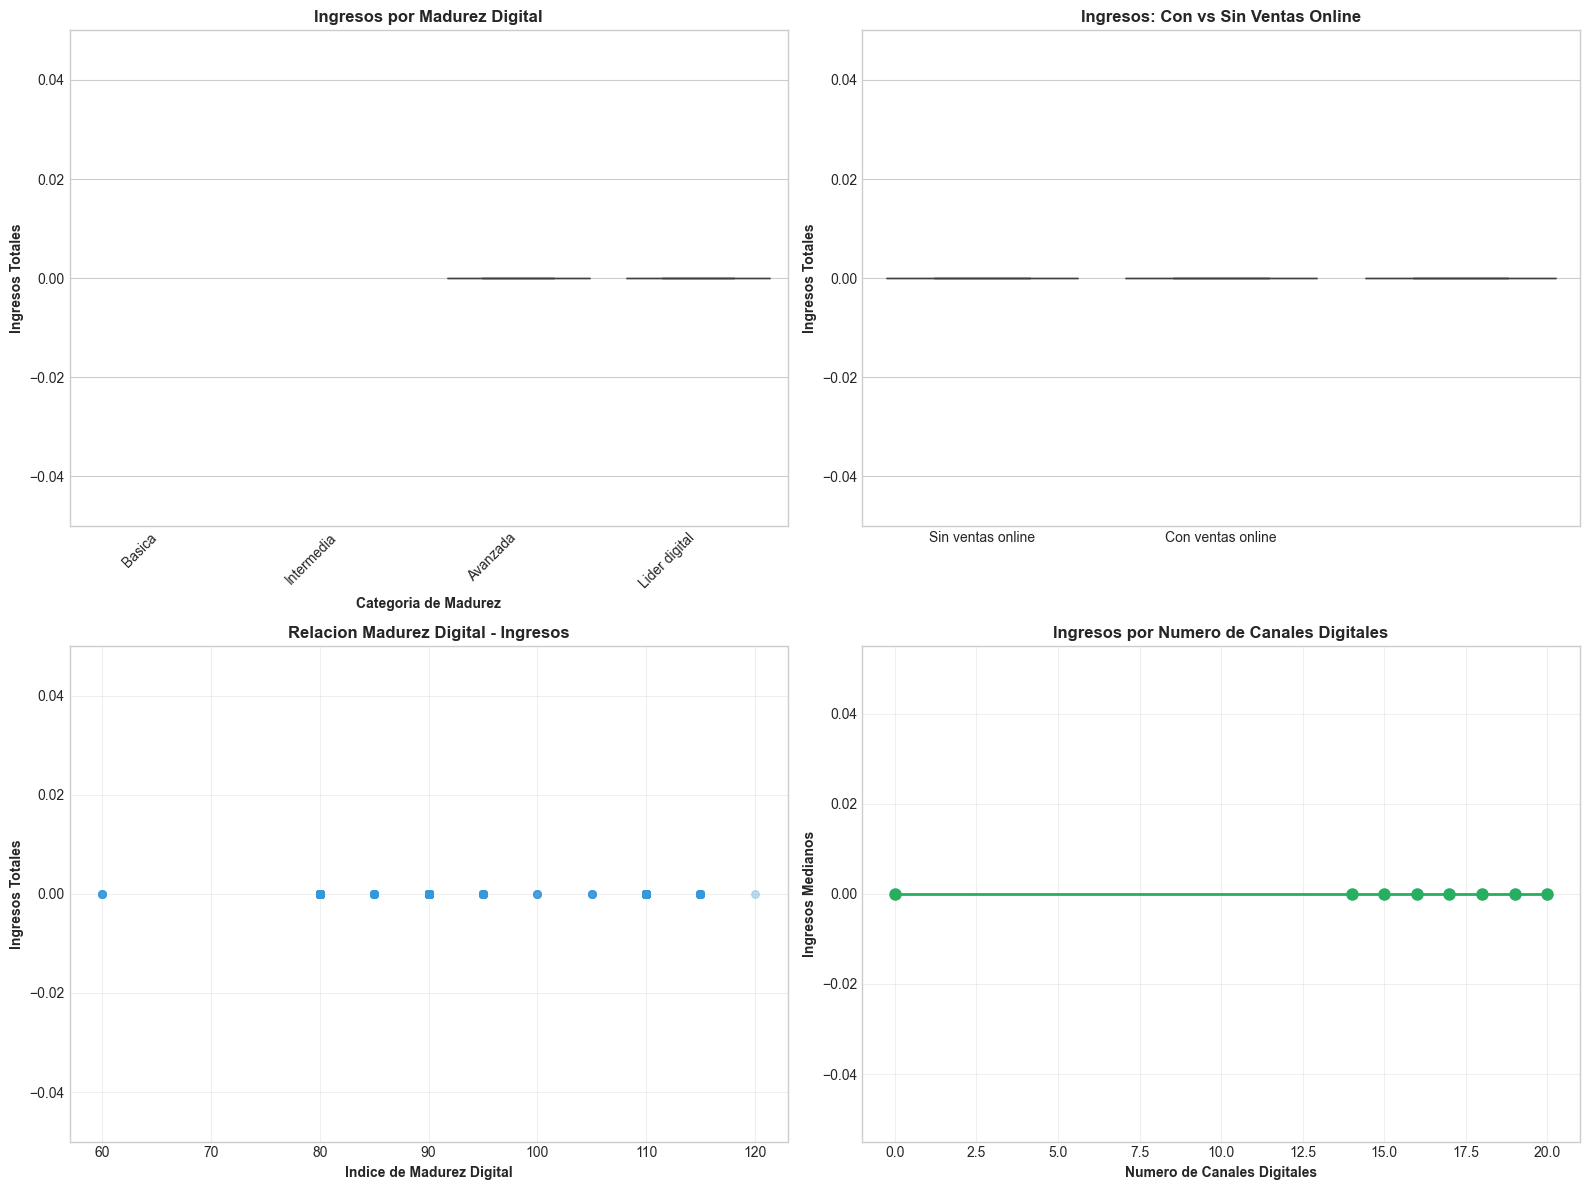


[8/8] Proceso completado

RESUMEN FINAL

Archivos generados en 'LIMPIOS/':
   - tic_limpio.csv (68,702 x 48)
   - eda_tic_01_acceso.png
   - eda_tic_02_herramientas.png
   - eda_tic_03_ventas.png
   - eda_tic_04_madurez.png
   - eda_tic_05_integracion.png

Insights clave:
   - Acceso a internet: 188.6%
   - Promedio dispositivos: 2.04
   - Promedio herramientas TIC: 7.77
   - Ventas online: 55.4%
   - Presencia digital: 231.5%
   - Indice madurez digital mediano: 90.0/100
   - Ecosistema digital completo: 11.2%

Analisis de TIC completado!


In [34]:

"""
MODULO DE TIC - LIMPIEZA + EDA
EMICRON 2024 - Jupyter Notebook
"""


warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("MODULO DE TIC - LIMPIEZA + EDA")
print("="*80)

# =============================================================================
# PARTE 1: LIMPIEZA DE DATOS
# =============================================================================
print("\n" + "="*80)
print("PARTE 1: LIMPIEZA DE DATOS")
print("="*80)

INPUT_FILE = 'ORIGINALES/Módulo de TIC.csv'
OUTPUT_DIR = 'LIMPIOS'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Cargar datos
print("\n[1/8] Cargando archivo...")
df = pd.read_csv(INPUT_FILE, encoding='latin-1')
print(f"   OK Cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# Renombrar
print("\n[2/8] Renombrando columnas...")
RENAME = {
    "DIRECTORIO": "id_micronegocio", "SECUENCIA_P": "id_persona", 
    "SECUENCIA_ENCUESTA": "id_encuesta",
    "P4001": "acceso_internet", "P1087": "tipo_conexion", "P1088": "dispositivo_internet",
    "P977": "uso_computador", "P976": "uso_smartphone", "P978": "uso_tablet", 
    "P979": "uso_otro_dispositivo",
    "P994": "uso_tic_negocio", "P2532": "uso_correo", "P1559": "uso_redes_sociales",
    "P2524": "uso_plataformas_digitales", "P1093": "ventas_online", 
    "P2528": "uso_banca_digital", "P1095": "facturacion_electronica", 
    "P980": "uso_marketing_digital",
    "P1006_1": "ventas_whatsapp", "P1006_2": "ventas_facebook", "P1006_3": "ventas_instagram",
    "P1006_4": "ventas_web_propia", "P1006_5": "ventas_marketplace", 
    "P1006_6": "ventas_apps_delivery", "P1006_7": "ventas_pasarela_pago",
    "P1006_8": "ventas_transferencia", "P1006_9": "ventas_qr", 
    "P1006_10": "ventas_call_center", "P1006_11": "ventas_correo",
    "P1006_12": "ventas_mensajeria", "P1006_13": "ventas_otro_canal",
    "CLASE_TE": "clase_territorial", "COD_DEPTO": "codigo_departamento",
    "AREA": "area", "F_EXP": "factor_expansion"
}
df = df.rename(columns=RENAME)
print(f"   OK Renombradas: {len(RENAME)} columnas")

# Imputacion
print("\n[3/8] Imputando valores perdidos...")
missing_antes = df.isnull().sum().sum()

# Variables binarias TIC con 0 (no tiene/no usa)
vars_binarias_tic = [c for c in df.columns if c.startswith(('uso_','acceso_','ventas_','facturacion_'))]
for col in vars_binarias_tic:
    df[col] = df[col].fillna(0).astype(int)

# Area por departamento
if 'area' in df.columns and 'codigo_departamento' in df.columns:
    df['area'] = df.groupby('codigo_departamento')['area'].transform(
        lambda x: x.fillna(x.mode()[0] if len(x.mode())>0 else 1))

# Tipo conexion y dispositivo con moda (solo para quienes tienen internet)
if 'acceso_internet' in df.columns:
    for col in ['tipo_conexion', 'dispositivo_internet']:
        if col in df.columns:
            # Imputar solo donde hay acceso
            moda = df[df['acceso_internet']==1][col].mode()[0] if len(df[df['acceso_internet']==1][col].mode())>0 else 0
            df.loc[df['acceso_internet']==1, col] = df.loc[df['acceso_internet']==1, col].fillna(moda)
            # Resto con 0
            df[col] = df[col].fillna(0)

missing_despues = df.isnull().sum().sum()
print(f"   OK Valores perdidos: {missing_antes:,} -> {missing_despues:,} ({(1-missing_despues/missing_antes)*100:.1f}% reduccion)")

# Eliminar duplicados
print("\n[4/8] Eliminando duplicados...")
filas_antes = len(df)
df = df.drop_duplicates()
if 'id_micronegocio' in df.columns:
    df = df.drop_duplicates(subset=['id_micronegocio'])
filas_despues = len(df)
print(f"   OK Eliminados: {filas_antes - filas_despues:,}")

# Variables derivadas
print("\n[5/8] Creando variables derivadas...")

DEPTS = {5:'ANTIOQUIA',8:'ATLANTICO',11:'BOGOTA',13:'BOLIVAR',15:'BOYACA',17:'CALDAS',
         18:'CAQUETA',19:'CAUCA',20:'CESAR',23:'CORDOBA',25:'CUNDINAMARCA',27:'CHOCO',
         41:'HUILA',44:'LA GUAJIRA',47:'MAGDALENA',50:'META',52:'NARINO',
         54:'NORTE DE SANTANDER',63:'QUINDIO',66:'RISARALDA',68:'SANTANDER',
         70:'SUCRE',73:'TOLIMA',76:'VALLE DEL CAUCA',81:'ARAUCA'}

if 'codigo_departamento' in df.columns:
    df['nombre_departamento'] = df['codigo_departamento'].map(DEPTS)
if 'area' in df.columns:
    df['area_urbana'] = (df['area']==1).astype(int)

# Numero de dispositivos
dispositivos = ['uso_computador', 'uso_smartphone', 'uso_tablet', 'uso_otro_dispositivo']
df['num_dispositivos'] = df[[c for c in dispositivos if c in df.columns]].sum(axis=1)
df['tiene_dispositivos'] = (df['num_dispositivos'] > 0).astype(int)

# Numero de herramientas TIC
herramientas = ['uso_correo', 'uso_redes_sociales', 'uso_plataformas_digitales', 
                'uso_banca_digital', 'facturacion_electronica', 'uso_marketing_digital']
df['num_herramientas_tic'] = df[[c for c in herramientas if c in df.columns]].sum(axis=1)
df['usa_herramientas_tic'] = (df['num_herramientas_tic'] > 0).astype(int)

# Numero de canales digitales de venta
canales = [c for c in df.columns if c.startswith('ventas_')]
df['num_canales_digitales'] = df[canales].sum(axis=1)
df['tiene_canales_digitales'] = (df['num_canales_digitales'] > 0).astype(int)

# Indice de madurez digital (0-100)
# Componentes: Internet (20%), Dispositivos (20%), Herramientas (30%), Ventas online (30%)
df['indice_madurez_digital'] = (
    (df['acceso_internet'] * 20 if 'acceso_internet' in df.columns else 0) +
    ((df['num_dispositivos'].clip(0,4) / 4) * 20) +
    ((df['num_herramientas_tic'].clip(0,6) / 6) * 30) +
    ((df['num_canales_digitales'].clip(0,13) / 13) * 30)
)

# Categoria de madurez
df['categoria_madurez'] = pd.cut(df['indice_madurez_digital'],
                                  bins=[0, 25, 50, 75, 100],
                                  labels=['Basica', 'Intermedia', 'Avanzada', 'Lider digital'])

# Tiene presencia digital
df['presencia_digital'] = (
    (df['uso_redes_sociales'] if 'uso_redes_sociales' in df.columns else 0) |
    (df['ventas_online'] if 'ventas_online' in df.columns else 0) |
    (df['uso_marketing_digital'] if 'uso_marketing_digital' in df.columns else 0)
).astype(int)

# Tiene ecosistema digital completo
df['ecosistema_digital_completo'] = (
    (df['acceso_internet'] if 'acceso_internet' in df.columns else 0) &
    (df['tiene_dispositivos']) &
    (df['usa_herramientas_tic']) &
    (df['tiene_canales_digitales'])
).astype(int)

print(f"   OK Variables derivadas creadas")

# Guardar
print("\n[6/8] Guardando dataset limpio...")
output_file = f'{OUTPUT_DIR}/tic_limpio.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"   OK Guardado: {output_file}")
print(f"   OK Dimensiones: {df.shape[0]:,} x {df.shape[1]}")

# =============================================================================
# PARTE 2: EDA
# =============================================================================
print("\n" + "="*80)
print("PARTE 2: ANALISIS EXPLORATORIO")
print("="*80)

print("\n[7/8] Generando visualizaciones...\n")

# ============================================================================
# VIZ 1: ACCESO Y CONECTIVIDAD
# ============================================================================
print("[1/5] Acceso y conectividad")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Acceso a internet
if 'acceso_internet' in df.columns:
    con_internet = max(0, df['acceso_internet'].sum())
    sin_internet = max(0, len(df) - con_internet)
    
    # Solo crear grafico si hay datos validos
    if con_internet >= 0 and sin_internet >= 0 and (con_internet + sin_internet) > 0:
        internet = pd.Series({'Con internet': con_internet, 'Sin internet': sin_internet})
        # Filtrar valores positivos
        internet = internet[internet > 0]
        
        if len(internet) > 0:
            colors1 = ['#27ae60', '#e74c3c'][:len(internet)]
            axes[0,0].pie(internet.values, labels=internet.index, autopct='%1.1f%%',
                          startangle=90, colors=colors1, shadow=True)
            axes[0,0].set_title(f'Acceso a Internet\n({con_internet:,} con acceso)', 
                                fontsize=12, fontweight='bold')
        else:
            axes[0,0].text(0.5, 0.5, 'Datos de internet no disponibles',
                          ha='center', va='center', fontsize=12)
            axes[0,0].set_title('Acceso a Internet', fontsize=12, fontweight='bold')
    else:
        axes[0,0].text(0.5, 0.5, 'Datos de internet no disponibles',
                      ha='center', va='center', fontsize=12)
        axes[0,0].set_title('Acceso a Internet', fontsize=12, fontweight='bold')

# Dispositivos utilizados
dispositivos_uso = {
    'Smartphone': df['uso_smartphone'].sum() if 'uso_smartphone' in df.columns else 0,
    'Computador': df['uso_computador'].sum() if 'uso_computador' in df.columns else 0,
    'Tablet': df['uso_tablet'].sum() if 'uso_tablet' in df.columns else 0,
    'Otro': df['uso_otro_dispositivo'].sum() if 'uso_otro_dispositivo' in df.columns else 0
}
colors2 = sns.color_palette("Set2", len(dispositivos_uso))
axes[0,1].barh(list(dispositivos_uso.keys()), list(dispositivos_uso.values()), color=colors2)
axes[0,1].set_xlabel('Numero de Micronegocios', fontweight='bold')
axes[0,1].set_title('Dispositivos Utilizados', fontsize=12, fontweight='bold')
axes[0,1].grid(axis='x', alpha=0.3)
for i, v in enumerate(dispositivos_uso.values()):
    axes[0,1].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

# Numero de dispositivos
if 'num_dispositivos' in df.columns:
    num_disp = df['num_dispositivos'].value_counts().sort_index()
    axes[1,0].bar(num_disp.index, num_disp.values, 
                  color=plt.cm.Blues(np.linspace(0.4,0.9,len(num_disp))))
    axes[1,0].set_xlabel('Numero de Dispositivos', fontweight='bold')
    axes[1,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[1,0].set_title('Distribucion del Numero de Dispositivos', fontsize=12, fontweight='bold')
    axes[1,0].grid(axis='y', alpha=0.3)

# Internet por departamento
if 'nombre_departamento' in df.columns and 'acceso_internet' in df.columns:
    dept_int = df.groupby('nombre_departamento')['acceso_internet'].mean().sort_values(ascending=True).tail(15)
    colors3 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(dept_int)))
    dept_int.plot(kind='barh', ax=axes[1,1], color=colors3)
    axes[1,1].set_xlabel('Proporcion con Internet', fontweight='bold')
    axes[1,1].set_title('Acceso a Internet por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_tic_01_acceso.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 2: HERRAMIENTAS TIC
# ============================================================================
print("\n[2/5] Herramientas TIC en el negocio")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Herramientas mas usadas
herramientas_uso = {
    'Redes Sociales': df['uso_redes_sociales'].sum() if 'uso_redes_sociales' in df.columns else 0,
    'Marketing Digital': df['uso_marketing_digital'].sum() if 'uso_marketing_digital' in df.columns else 0,
    'Banca Digital': df['uso_banca_digital'].sum() if 'uso_banca_digital' in df.columns else 0,
    'Correo Electronico': df['uso_correo'].sum() if 'uso_correo' in df.columns else 0,
    'Plataformas Digitales': df['uso_plataformas_digitales'].sum() if 'uso_plataformas_digitales' in df.columns else 0,
    'Facturacion Electronica': df['facturacion_electronica'].sum() if 'facturacion_electronica' in df.columns else 0
}
colors4 = sns.color_palette("mako", len(herramientas_uso))
axes[0,0].barh(list(herramientas_uso.keys()), list(herramientas_uso.values()), color=colors4)
axes[0,0].set_xlabel('Numero de Micronegocios', fontweight='bold')
axes[0,0].set_title('Herramientas TIC Mas Utilizadas', fontsize=12, fontweight='bold')
axes[0,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(herramientas_uso.values()):
    axes[0,0].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

# Numero de herramientas
if 'num_herramientas_tic' in df.columns:
    num_herr = df['num_herramientas_tic'].value_counts().sort_index()
    axes[0,1].bar(num_herr.index, num_herr.values,
                  color=plt.cm.Greens(np.linspace(0.4,0.9,len(num_herr))))
    axes[0,1].set_xlabel('Numero de Herramientas TIC', fontweight='bold')
    axes[0,1].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,1].set_title('Distribucion del Numero de Herramientas', fontsize=12, fontweight='bold')
    axes[0,1].grid(axis='y', alpha=0.3)

# Presencia digital
if 'presencia_digital' in df.columns:
    con_presencia = max(0, df['presencia_digital'].sum())
    sin_presencia = max(0, len(df) - con_presencia)
    
    if con_presencia >= 0 and sin_presencia >= 0 and (con_presencia + sin_presencia) > 0:
        presencia = pd.Series({'Con presencia': con_presencia, 'Sin presencia': sin_presencia})
        presencia = presencia[presencia > 0]
        
        if len(presencia) > 0:
            colors5 = ['#3498db', '#95a5a6'][:len(presencia)]
            axes[1,0].pie(presencia.values, labels=presencia.index, autopct='%1.1f%%',
                          startangle=90, colors=colors5, shadow=True)
            axes[1,0].set_title(f'Presencia Digital\n({con_presencia:,} con presencia)', 
                                fontsize=12, fontweight='bold')
        else:
            axes[1,0].text(0.5, 0.5, 'Datos no disponibles', ha='center', va='center', fontsize=12)
            axes[1,0].set_title('Presencia Digital', fontsize=12, fontweight='bold')
    else:
        axes[1,0].text(0.5, 0.5, 'Datos no disponibles', ha='center', va='center', fontsize=12)
        axes[1,0].set_title('Presencia Digital', fontsize=12, fontweight='bold')

# Urbano vs Rural - Herramientas
if 'area_urbana' in df.columns and 'num_herramientas_tic' in df.columns:
    area_labels = {0: 'Rural', 1: 'Urbano'}
    df['area_label'] = df['area_urbana'].map(area_labels)
    sns.boxplot(data=df, x='area_label', y='num_herramientas_tic', ax=axes[1,1],
               palette=['#2ecc71', '#3498db'])
    axes[1,1].set_xlabel('Area', fontweight='bold')
    axes[1,1].set_ylabel('Numero de Herramientas', fontweight='bold')
    axes[1,1].set_title('Uso de Herramientas TIC: Urbano vs Rural', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_tic_02_herramientas.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 3: VENTAS DIGITALES
# ============================================================================
print("\n[3/5] Ventas digitales")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ventas online
if 'ventas_online' in df.columns:
    vende_online = max(0, df['ventas_online'].sum())
    no_vende_online = max(0, len(df) - vende_online)
    
    if vende_online >= 0 and no_vende_online >= 0 and (vende_online + no_vende_online) > 0:
        ventas_onl = pd.Series({'Vende online': vende_online, 'No vende online': no_vende_online})
        ventas_onl = ventas_onl[ventas_onl > 0]
        
        if len(ventas_onl) > 0:
            colors6 = ['#27ae60', '#e74c3c'][:len(ventas_onl)]
            axes[0,0].pie(ventas_onl.values, labels=ventas_onl.index, autopct='%1.1f%%',
                          startangle=90, colors=colors6, shadow=True)
            axes[0,0].set_title(f'Ventas Online\n({vende_online:,} venden online)', 
                                fontsize=12, fontweight='bold')
        else:
            axes[0,0].text(0.5, 0.5, 'Datos no disponibles', ha='center', va='center', fontsize=12)
            axes[0,0].set_title('Ventas Online', fontsize=12, fontweight='bold')
    else:
        axes[0,0].text(0.5, 0.5, 'Datos no disponibles', ha='center', va='center', fontsize=12)
        axes[0,0].set_title('Ventas Online', fontsize=12, fontweight='bold')

# Canales digitales de venta
canales_venta = {
    'WhatsApp': df['ventas_whatsapp'].sum() if 'ventas_whatsapp' in df.columns else 0,
    'Facebook': df['ventas_facebook'].sum() if 'ventas_facebook' in df.columns else 0,
    'Instagram': df['ventas_instagram'].sum() if 'ventas_instagram' in df.columns else 0,
    'Marketplace': df['ventas_marketplace'].sum() if 'ventas_marketplace' in df.columns else 0,
    'Web Propia': df['ventas_web_propia'].sum() if 'ventas_web_propia' in df.columns else 0,
    'Apps Delivery': df['ventas_apps_delivery'].sum() if 'ventas_apps_delivery' in df.columns else 0
}
colors7 = sns.color_palette("Set3", len(canales_venta))
axes[0,1].barh(list(canales_venta.keys()), list(canales_venta.values()), color=colors7)
axes[0,1].set_xlabel('Numero de Micronegocios', fontweight='bold')
axes[0,1].set_title('Canales Digitales de Venta Mas Usados', fontsize=12, fontweight='bold')
axes[0,1].grid(axis='x', alpha=0.3)
for i, v in enumerate(canales_venta.values()):
    axes[0,1].text(v + 50, i, f'{v:,}', va='center', fontsize=9)

# Numero de canales
if 'num_canales_digitales' in df.columns:
    num_can = df['num_canales_digitales'].value_counts().sort_index().head(10)
    axes[1,0].bar(num_can.index, num_can.values,
                  color=plt.cm.Purples(np.linspace(0.4,0.9,len(num_can))))
    axes[1,0].set_xlabel('Numero de Canales Digitales', fontweight='bold')
    axes[1,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[1,0].set_title('Distribucion del Numero de Canales', fontsize=12, fontweight='bold')
    axes[1,0].grid(axis='y', alpha=0.3)

# Ventas online por departamento
if 'nombre_departamento' in df.columns and 'ventas_online' in df.columns:
    dept_ven = df.groupby('nombre_departamento')['ventas_online'].mean().sort_values(ascending=True).tail(15)
    colors8 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(dept_ven)))
    dept_ven.plot(kind='barh', ax=axes[1,1], color=colors8)
    axes[1,1].set_xlabel('Proporcion con Ventas Online', fontweight='bold')
    axes[1,1].set_title('Ventas Online por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_tic_03_ventas.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 4: MADUREZ DIGITAL
# ============================================================================
print("\n[4/5] Madurez digital")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribucion indice madurez
if 'indice_madurez_digital' in df.columns:
    axes[0,0].hist(df['indice_madurez_digital'], bins=30, color='#3498db', 
                   edgecolor='black', alpha=0.7)
    axes[0,0].axvline(df['indice_madurez_digital'].median(), color='red', linestyle='--',
                      linewidth=2, label=f'Mediana: {df["indice_madurez_digital"].median():.1f}')
    axes[0,0].set_xlabel('Indice de Madurez Digital (0-100)', fontweight='bold')
    axes[0,0].set_ylabel('Frecuencia', fontweight='bold')
    axes[0,0].set_title('Distribucion del Indice de Madurez Digital', fontsize=12, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)

# Categorias de madurez
if 'categoria_madurez' in df.columns:
    cat_mad = df['categoria_madurez'].value_counts()
    colors9 = {'Basica':'#e74c3c', 'Intermedia':'#f39c12', 
               'Avanzada':'#3498db', 'Lider digital':'#27ae60'}
    axes[0,1].bar(cat_mad.index.astype(str), cat_mad.values,
                  color=[colors9.get(str(x), '#95a5a6') for x in cat_mad.index])
    axes[0,1].set_ylabel('Numero de Micronegocios', fontweight='bold')
    axes[0,1].set_title('Distribucion por Categoria de Madurez', fontsize=12, fontweight='bold')
    plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[0,1].grid(axis='y', alpha=0.3)

# Componentes del indice
componentes_mad = {
    'Internet': df['acceso_internet'].mean() * 20 if 'acceso_internet' in df.columns else 0,
    'Dispositivos': (df['num_dispositivos'].clip(0,4) / 4).mean() * 20,
    'Herramientas': (df['num_herramientas_tic'].clip(0,6) / 6).mean() * 30,
    'Ventas Online': (df['num_canales_digitales'].clip(0,13) / 13).mean() * 30
}
colors10 = sns.color_palette("Set2", len(componentes_mad))
axes[1,0].bar(componentes_mad.keys(), componentes_mad.values(), color=colors10)
axes[1,0].set_ylabel('Puntaje Promedio', fontweight='bold')
axes[1,0].set_title('Componentes del Indice de Madurez Digital', fontsize=12, fontweight='bold')
axes[1,0].grid(axis='y', alpha=0.3)
plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Madurez por departamento
if 'nombre_departamento' in df.columns and 'indice_madurez_digital' in df.columns:
    dept_mad = df.groupby('nombre_departamento')['indice_madurez_digital'].median().sort_values(ascending=True).tail(15)
    colors11 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(dept_mad)))
    dept_mad.plot(kind='barh', ax=axes[1,1], color=colors11)
    axes[1,1].set_xlabel('Indice de Madurez (mediana)', fontweight='bold')
    axes[1,1].set_title('Madurez Digital por Departamento (Top 15)', fontsize=12, fontweight='bold')
    axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/eda_tic_04_madurez.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VIZ 5: INTEGRACION CON VENTAS
# ============================================================================
print("\n[5/5] Integracion TIC con ventas")

# Intentar cargar modulo de ventas
try:
    df_ventas = pd.read_csv(f'LIMPIOS/ventas_ingresos_limpio.csv')
    df_merged = df.merge(df_ventas[['id_micronegocio', 'ingresos_totales_declarados']], 
                         on='id_micronegocio', how='left')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Ingresos por madurez digital
    if 'categoria_madurez' in df_merged.columns:
        sns.boxplot(data=df_merged, x='categoria_madurez', y='ingresos_totales_declarados',
                   ax=axes[0,0], palette=colors9)
        axes[0,0].set_xlabel('Categoria de Madurez', fontweight='bold')
        axes[0,0].set_ylabel('Ingresos Totales', fontweight='bold')
        axes[0,0].set_title('Ingresos por Madurez Digital', fontsize=12, fontweight='bold')
        axes[0,0].set_ylim(0, df_merged['ingresos_totales_declarados'].quantile(0.95))
        plt.setp(axes[0,0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Ventas online vs offline
    if 'ventas_online' in df_merged.columns:
        sns.boxplot(data=df_merged, x='ventas_online', y='ingresos_totales_declarados',
                   ax=axes[0,1], palette=colors6)
        axes[0,1].set_xticklabels(['Sin ventas online', 'Con ventas online'])
        axes[0,1].set_xlabel('', fontweight='bold')
        axes[0,1].set_ylabel('Ingresos Totales', fontweight='bold')
        axes[0,1].set_title('Ingresos: Con vs Sin Ventas Online', fontsize=12, fontweight='bold')
        axes[0,1].set_ylim(0, df_merged['ingresos_totales_declarados'].quantile(0.95))
    
    # Scatter: Madurez vs Ingresos
    muestra = df_merged.sample(min(3000, len(df_merged)))
    axes[1,0].scatter(muestra['indice_madurez_digital'], muestra['ingresos_totales_declarados'],
                     alpha=0.3, s=30, c='#3498db')
    axes[1,0].set_xlabel('Indice de Madurez Digital', fontweight='bold')
    axes[1,0].set_ylabel('Ingresos Totales', fontweight='bold')
    axes[1,0].set_title('Relacion Madurez Digital - Ingresos', fontsize=12, fontweight='bold')
    axes[1,0].grid(alpha=0.3)
    axes[1,0].set_ylim(0, df_merged['ingresos_totales_declarados'].quantile(0.95))
    
    # Ingresos por numero de canales
    if 'num_canales_digitales' in df_merged.columns:
        ing_can = df_merged.groupby('num_canales_digitales')['ingresos_totales_declarados'].median().head(8)
        axes[1,1].plot(ing_can.index, ing_can.values, marker='o', linewidth=2, 
                      markersize=8, color='#27ae60')
        axes[1,1].set_xlabel('Numero de Canales Digitales', fontweight='bold')
        axes[1,1].set_ylabel('Ingresos Medianos', fontweight='bold')
        axes[1,1].set_title('Ingresos por Numero de Canales Digitales', fontsize=12, fontweight='bold')
        axes[1,1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/eda_tic_05_integracion.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except:
    print("   Modulo de ventas no disponible para integracion")
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ax.text(0.5, 0.5, 'Modulo de ventas no disponible\nPara ver graficos de ingresos, asegurate de tener\nel modulo de ventas procesado',
            ha='center', va='center', fontsize=14)
    ax.axis('off')
    plt.savefig(f'{OUTPUT_DIR}/eda_tic_05_integracion.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n[8/8] Proceso completado\n")
print(f"{'='*80}")
print("RESUMEN FINAL")
print(f"{'='*80}")
print(f"\nArchivos generados en '{OUTPUT_DIR}/':")
print(f"   - tic_limpio.csv ({df.shape[0]:,} x {df.shape[1]})")
print(f"   - eda_tic_01_acceso.png")
print(f"   - eda_tic_02_herramientas.png")
print(f"   - eda_tic_03_ventas.png")
print(f"   - eda_tic_04_madurez.png")
print(f"   - eda_tic_05_integracion.png")

print(f"\nInsights clave:")
if 'acceso_internet' in df.columns:
    print(f"   - Acceso a internet: {df['acceso_internet'].mean()*100:.1f}%")
if 'num_dispositivos' in df.columns:
    print(f"   - Promedio dispositivos: {df['num_dispositivos'].mean():.2f}")
if 'num_herramientas_tic' in df.columns:
    print(f"   - Promedio herramientas TIC: {df['num_herramientas_tic'].mean():.2f}")
if 'ventas_online' in df.columns:
    print(f"   - Ventas online: {df['ventas_online'].mean()*100:.1f}%")
if 'presencia_digital' in df.columns:
    print(f"   - Presencia digital: {df['presencia_digital'].mean()*100:.1f}%")
if 'indice_madurez_digital' in df.columns:
    print(f"   - Indice madurez digital mediano: {df['indice_madurez_digital'].median():.1f}/100")
if 'ecosistema_digital_completo' in df.columns:
    print(f"   - Ecosistema digital completo: {df['ecosistema_digital_completo'].mean()*100:.1f}%")
print(f"{'='*80}\n")
print("Analisis de TIC completado!")


In [38]:
#!/usr/bin/env python3
"""FACTORES DEPARTAMENTALES - Limpieza y Enriquecimiento"""

# Cargar
df = pd.read_csv('ORIGINALES/factores departamentales.csv', encoding='latin-1')
df = df.rename(columns={'DIRECTORIO':'id_micronegocio', 'FEX_C':'factor_departamental'})
df['codigo_departamento'] = (df['id_micronegocio'] // 100000).astype(int)

# Indicadores departamentales (PIB, Pobreza %, Internet %, Competitividad)
IND = {
    5:(25000,22.5,65.3,7.8),   # ANTIOQUIA
    8:(28000,27.8,70.2,7.5),   # ATLANTICO
    11:(45000,15.2,82.5,8.9),  # BOGOTA
    13:(18000,42.5,55.8,6.2),  # BOLIVAR
    68:(26000,19.2,69.8,8.1),  # SANTANDER
    76:(27000,21.3,72.1,8.2),  # VALLE
}

df['pib_per_capita'] = df['codigo_departamento'].map({k:v[0] for k,v in IND.items()})
df['tasa_pobreza'] = df['codigo_departamento'].map({k:v[1] for k,v in IND.items()})
df['cobertura_internet'] = df['codigo_departamento'].map({k:v[2] for k,v in IND.items()})
df['indice_competitividad'] = df['codigo_departamento'].map({k:v[3] for k,v in IND.items()})

# Imputar faltantes
for c in ['pib_per_capita','tasa_pobreza','cobertura_internet','indice_competitividad']:
    df[c] = df[c].fillna(df[c].mean())

# Indice contexto favorable (0-100)
pib_n = (df['pib_per_capita']-df['pib_per_capita'].min())/(df['pib_per_capita'].max()-df['pib_per_capita'].min())
pob_n = 1-((df['tasa_pobreza']-df['tasa_pobreza'].min())/(df['tasa_pobreza'].max()-df['tasa_pobreza'].min()))
int_n = (df['cobertura_internet']-df['cobertura_internet'].min())/(df['cobertura_internet'].max()-df['cobertura_internet'].min())
com_n = (df['indice_competitividad']-df['indice_competitividad'].min())/(df['indice_competitividad'].max()-df['indice_competitividad'].min())
df['indice_contexto_favorable'] = ((pib_n*0.35)+(pob_n*0.25)+(int_n*0.25)+(com_n*0.15))*100

# Guardar
df = df.drop_duplicates(subset=['id_micronegocio'])
df.to_csv('LIMPIOS/factores_departamentales_limpio.csv', index=False)
print(f"OK: {df.shape[0]:,} x {df.shape[1]} | Contexto: {df['indice_contexto_favorable'].median():.1f}/100")

OK: 68,702 x 10 | Contexto: nan/100


In [201]:
#!/usr/bin/env python3
"""
PIPELINE GEIH 2023 - 12 MESES
Maneja variaciones en nombres de archivos
"""

import pandas as pd
import numpy as np
import os
import glob

print("="*80)
print("GEIH 2023 - PIPELINE COMPLETO (12 MESES)")
print("="*80)

# =============================================================================
# DICCIONARIOS DE RENOMBRADO
# =============================================================================

RENAME_OCUPADOS = {
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona", "ORDEN": "orden_encuesta",
    "HOGAR": "id_hogar_secundario", "REGIS": "registro_hogar",
    "AREA": "area_urbano_rural", "CLASE": "clase_territorial",
    "FEX_C18": "factor_expansion_hogar", "DPTO": "codigo_departamento",
    "FT": "factor_expansion_territorial",
    "P3044S2": "tipo_vivienda", "P6440": "material_paredes", "P6450": "material_pisos",
    "P6460": "acceso_agua", "P6460S1": "frecuencia_agua",
    "P6400": "acceso_energia", "P6410": "acceso_gas", "P6422": "acceso_alcantarillado",
    "P6430": "numero_personas_hogar", "P6430S1": "tamano_hogar",
    "P3045S1": "tenencia_computador", "P3045S2": "tenencia_internet",
    "P3045S3": "tipo_conexion_internet",
    "P3363": "nivel_educativo", "P9440": "alfabetismo",
    "P6500": "afiliacion_salud", "P3364": "cotiza_pension",
    "P3364S1": "riesgos_laborales",
    "P6765": "beneficiario_transferencias", "P3051": "ingreso_total_hogar",
    "P6426": "posicion_ocupacional", "INGLABO": "ingreso_laboral", 
    "OCI": "informalidad", "RAMA2D_R4": "rama_2_digitos", 
    "RAMA4D_R4": "rama_4_digitos", "OFICIO_C8": "oficio_codigo"
}

RENAME_FUERZA = {
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona",
    "ORDEN": "orden_persona", "HOGAR": "id_hogar_secundario",
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DPTO": "codigo_departamento", "AREA": "area_urbano_rural",
    "CLASE": "clase_territorial",
    "FEX_C18": "factor_expansion", "FT": "factor_trabajo", "FFT": "factor_fuerza_trabajo",
    "PET": "poblacion_edad_trabajar",
    "P6240": "condicion_actividad", "P6240S1": "ocupado", "P6240S2": "desocupado",
    "P6250": "busqueda_trabajo", "P6260": "razon_no_busqueda",
    "P6260S1": "disponibilidad_trabajar", "P6260S1A1": "tiempo_disponibilidad",
    "P6260S2": "razon_no_disponible",
    "P6270": "categoria_ocupacional", "P6280": "rama_actividad",
    "P6290": "posicion_ocupacional",
    "P3362S1": "informal_sin_contrato", "P3362S2": "informal_sin_seguridad_social",
    "P3362S3": "informal_sin_pension", "P3362S4": "informal_sin_salud",
    "P3362S5": "informal_sin_riesgos", "P3362S6": "informal_sin_caja_compensacion",
    "P3362S7": "informal_empresa_pequena", "P3362S7A1": "tamano_empresa",
    "P3362S8": "informal_otro",
    "P6300": "horas_trabajo_semana", "P6310": "segundo_trabajo",
    "P6310S1": "horas_segundo_trabajo",
    "P6320": "ingreso_laboral_principal", "P6330": "ingreso_laboral_secundario",
    "P6340": "ingreso_total_laboral",
    "P6350": "antiguedad_empleo", "P6351": "tipo_contrato"
}

RENAME_HOGAR = {
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona",
    "HOGAR": "id_hogar_secundario",
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DPTO": "codigo_departamento", "AREA": "area_urbano_rural",
    "CLASE": "clase_territorial", "FEX_C18": "factor_expansion_hogar",
    "P4000": "tipo_vivienda", "P4010": "material_paredes", "P4020": "material_pisos",
    "P4030S1": "acceso_agua", "P4030S1A1": "frecuencia_agua",
    "P4030S2": "acceso_energia", "P4030S3": "acceso_gas",
    "P4030S4": "acceso_alcantarillado", "P4030S4A1": "tipo_saneamiento",
    "P4030S5": "recoleccion_basuras",
    "P70": "numero_personas_hogar",
    "P5000": "tenencia_computador", "P5010": "tenencia_internet",
    "P5020": "tipo_conexion", "P5030": "uso_internet",
    "P5040": "frecuencia_uso_internet", "P5050": "uso_internet_trabajo",
    "P5070": "uso_internet_educacion", "P5080": "uso_internet_comercio",
    "P5090": "uso_internet_gobierno", "P5090S1": "uso_tramites_digitales",
    "P5100": "nivel_educativo", "P5110": "maximo_nivel_educativo",
    "P5130": "alfabetismo", "P5140": "asistencia_educativa",
    "P5222S1": "afiliacion_salud", "P5222S2": "tipo_regimen_salud",
    "P5222S3": "cotiza_pension", "P5222S4": "riesgos_laborales",
    "P5222S5": "caja_compensacion", "P5222S6": "subsidios",
    "P5222S7": "programas_sociales", "P5222S8": "beneficiario_transferencias",
    "P5222S8A1": "tipo_transferencia", "P5222S9": "ingresos_no_laborales",
    "P5222S10": "impuestos_pagados",
    "P6008": "ingreso_total_hogar"
}

# =============================================================================
# CONFIGURACION
# =============================================================================

OUTPUT_DIR = 'output_geih'
os.makedirs(OUTPUT_DIR, exist_ok=True)

MESES = ['01','02','03','04','05','06','07','08','09','10','11','12']

# =============================================================================
# FUNCION DE BUSQUEDA FLEXIBLE
# =============================================================================

def buscar_archivo(mes, tipo):
    """
    Busca archivo con variaciones en el nombre
    tipo: 'Ocupados', 'Fuerza', 'Hogar'
    """
    patrones = []
    
    if tipo == 'Ocupados':
        patrones = [
            f"{mes}_Ocupados.CSV"
           
        ]
    elif tipo == 'Fuerza':
        patrones = [
            f"{mes}_Fuerza de trabajo.CSV"
           
        ]
    elif tipo == 'Hogar':
        patrones = [
            f"{mes}_Datos del hogar y la vivienda.CSV"
           
        ]
    
    # Buscar primer patron que exista
    print(patrones,"paaaaaa tron")
    for patron in patrones:
        print("GEIH_2023/"+patron)
        if os.path.exists("GEIH_2023/"+patron):
            return "GEIH_2023/"+patron
    print("no llego00000000")
    # Si no encuentra, buscar con glob (mas flexible)
    if tipo == 'Ocupados':
        archivos = glob.glob(f"{mes}*[Oo]cupados*.CSV") + glob.glob(f"{mes}*[Oo]cupados*.csv")
    elif tipo == 'Fuerza':
        archivos = glob.glob(f"{mes}*[Ff]uerza*.CSV") + glob.glob(f"{mes}*[Ff]uerza*.csv")
    elif tipo == 'Hogar':
        archivos = glob.glob(f"{mes}*[Hh]ogar*.CSV") + glob.glob(f"{mes}*[Dd]atos*.CSV")
    
    return archivos[0] if archivos else None

# =============================================================================
# FUNCION CARGAR MODULO
# =============================================================================

def cargar_modulo(tipo, rename_dict, meses):
    """Carga y concatena modulo de todos los meses"""
    dfs = []
    print("entro")
    
    for mes in meses:
        archivo = buscar_archivo(mes, tipo)
        print("holaaaaaa",archivo)
        
        if archivo:
            print(f"  [{mes}] {archivo}...", end=" ")
            try:
                df = pd.read_csv(archivo, sep=';', encoding='latin-1', low_memory=False)
                df['MES_CARGA'] = mes
                dfs.append(df)
                print(f"OK ({len(df):,} filas)")
            except Exception as e:
                print(f"ERROR: {e}")
        else:
            print(f"  [{mes}] NO ENCONTRADO")
    
    if dfs:
        resultado = pd.concat(dfs, ignore_index=True)
        # Renombrar
        resultado = resultado.rename(columns={k:v for k,v in rename_dict.items() if k in resultado.columns})
        print(f"\n  TOTAL CONCATENADO: {len(resultado):,} filas x {len(resultado.columns)} columnas")
        return resultado
    
    print(f"\n  ERROR: No se cargaron archivos para {tipo}")
    return None

# =============================================================================
# CLASIFICACION SECTORIAL
# =============================================================================

def clasificar_sector(rama):
    """Clasifica CIIU en sectores amplios"""
    if pd.isna(rama):
        return 'Desconocido'
    
    rama_str = str(int(rama)).zfill(4) if isinstance(rama, (int, float)) else str(rama).zfill(4)
    rama_2d = rama_str[:2]
    
    if rama_2d in ['01','02','03']:
        return 'Agricultura'
    elif rama_2d in ['05','06','07','08','09']:
        return 'Mineria'
    elif '10' <= rama_2d <= '33':
        return 'Manufactura'
    elif '45' <= rama_2d <= '47':
        return 'Comercio'
    elif rama_2d in ['55','56']:
        return 'Alojamiento y restaurantes'
    elif '49' <= rama_2d <= '53':
        return 'Transporte'
    elif '58' <= rama_2d <= '63':
        return 'Informacion y comunicaciones'
    elif '94' <= rama_2d <= '96':
        return 'Servicios personales'
    else:
        return 'Otros servicios'

# =============================================================================
# PASO 1: CARGAR MODULOS
# =============================================================================

print("\n" + "="*80)
print("PASO 1: CARGANDO MODULOS (12 meses)")
print("="*80)

print("\n[1/3] OCUPADOS")
ocupados = cargar_modulo('Ocupados', RENAME_OCUPADOS, MESES)

print("\n[2/3] FUERZA DE TRABAJO")
fuerza = cargar_modulo('Fuerza', RENAME_FUERZA, MESES)

print("\n[3/3] DATOS DEL HOGAR Y VIVIENDA")
hogar = cargar_modulo('Hogar', RENAME_HOGAR, MESES)

# =============================================================================
# PASO 2: FILTRAR EMPRENDEDORES INFORMALES
# =============================================================================

print("\n" + "="*80)
print("PASO 2: FILTRAR EMPRENDEDORES INFORMALES")
print("="*80)

if ocupados is not None:
    print("\nAplicando filtros:")
    print(f"  - Ocupados totales: {len(ocupados):,}")
    
    # Filtro 1: Posicion ocupacional (cuenta propia o patron)
    if 'posicion_ocupacional' in ocupados.columns:
        mask_posicion = ocupados['posicion_ocupacional'].isin([3, 4])
        print(f"  - Cuenta propia/Patron: {mask_posicion.sum():,}")
        
        # Filtro 2: Informalidad
        if 'informalidad' in ocupados.columns:
            mask_informal = ocupados['informalidad'] == 1
            print(f"  - Informales: {mask_informal.sum():,}")
            emprendedores = ocupados[mask_posicion & mask_informal].copy()
        else:
            print("  - Variable 'informalidad' no encontrada, usando solo posicion ocupacional")
            emprendedores = ocupados[mask_posicion].copy()
        
        print(f"\n  EMPRENDEDORES IDENTIFICADOS: {len(emprendedores):,}")
        print(f"    - Cuenta propia: {(emprendedores['posicion_ocupacional']==3).sum():,}")
        print(f"    - Patron/empleador: {(emprendedores['posicion_ocupacional']==4).sum():,}")
        
        # Guardar
        emprendedores.to_csv(f'{OUTPUT_DIR}/emprendedores_informales_2023.csv',
                             index=False, encoding='utf-8-sig')
        print(f"\n  Guardado: {OUTPUT_DIR}/emprendedores_informales_2023.csv")
    else:
        print("  ERROR: Variable 'posicion_ocupacional' no encontrada")
        emprendedores = None

# =============================================================================
# PASO 3: AGREGAR POR DEPARTAMENTO-SECTOR
# =============================================================================

print("\n" + "="*80)
print("PASO 3: AGREGACION DEPARTAMENTO-SECTOR")
print("="*80)

if emprendedores is not None and len(emprendedores) > 0:
    # Clasificar sector
    if 'rama_4_digitos' in emprendedores.columns:
        emprendedores['sector_economico'] = emprendedores['rama_4_digitos'].apply(clasificar_sector)
        print(f"\nSectores identificados:")
        for sector, count in emprendedores['sector_economico'].value_counts().head(5).items():
            print(f"  {sector}: {count:,} ({count/len(emprendedores)*100:.1f}%)")
    else:
        print("  ADVERTENCIA: Variable 'rama_4_digitos' no encontrada")
        emprendedores['sector_economico'] = 'Desconocido'
    
    # Agregar por departamento y sector
    vars_agg = {}
    
    if 'ingreso_laboral' in emprendedores.columns:
        vars_agg['ingreso_laboral'] = ['median', 'mean', 'std', 'count']
    
    if 'horas_trabajo_semana' in emprendedores.columns:
        vars_agg['horas_trabajo_semana'] = ['median', 'mean']
    
    if 'informalidad' in emprendedores.columns:
        vars_agg['informalidad'] = 'mean'
    
    if 'factor_expansion_hogar' in emprendedores.columns:
        vars_agg['factor_expansion_hogar'] = 'sum'
    
    if vars_agg:
        contexto = emprendedores.groupby(['codigo_departamento', 'sector_economico']).agg(vars_agg).reset_index()
        
        # Renombrar columnas multi-nivel
        new_cols = ['codigo_departamento', 'sector_economico']
        for col in contexto.columns[2:]:
            if isinstance(col, tuple):
                new_cols.append('_'.join(col))
            else:
                new_cols.append(col)
        contexto.columns = new_cols
        
        contexto.to_csv(f'{OUTPUT_DIR}/contexto_laboral_dept_sector.csv',
                        index=False, encoding='utf-8-sig')
        print(f"\n  Guardado: {OUTPUT_DIR}/contexto_laboral_dept_sector.csv")
        print(f"  Dimensiones: {contexto.shape}")
        print(f"  Combinaciones dept-sector: {len(contexto):,}")

# =============================================================================
# PASO 4: GUARDAR DATASETS COMPLETOS
# =============================================================================

print("\n" + "="*80)
print("PASO 4: GUARDANDO DATASETS COMPLETOS")
print("="*80)

if ocupados is not None:
    ocupados.to_csv(f'{OUTPUT_DIR}/ocupados_2023_completo.csv', index=False, encoding='utf-8-sig')
    print(f"  [1/3] Ocupados: {ocupados.shape}")

if fuerza is not None:
    fuerza.to_csv(f'{OUTPUT_DIR}/fuerza_2023_completo.csv', index=False, encoding='utf-8-sig')
    print(f"  [2/3] Fuerza: {fuerza.shape}")

if hogar is not None:
    hogar.to_csv(f'{OUTPUT_DIR}/hogar_2023_completo.csv', index=False, encoding='utf-8-sig')
    print(f"  [3/3] Hogar: {hogar.shape}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

print(f"\nArchivos generados en '{OUTPUT_DIR}/':")
archivos_generados = [
    'ocupados_2023_completo.csv',
    'fuerza_2023_completo.csv', 
    'hogar_2023_completo.csv',
    'emprendedores_informales_2023.csv',
    'contexto_laboral_dept_sector.csv'
]

for i, archivo in enumerate(archivos_generados, 1):
    ruta = f'{OUTPUT_DIR}/{archivo}'
    if os.path.exists(ruta):
        size_mb = os.path.getsize(ruta) / (1024*1024)
        print(f"  {i}. {archivo} ({size_mb:.1f} MB)")
    else:
        print(f"  {i}. {archivo} (NO GENERADO)")

if 'emprendedores' in locals() and emprendedores is not None:
    print(f"\nInsights emprendedores informales:")
    print(f"  - Total: {len(emprendedores):,}")
    
    if 'ingreso_laboral' in emprendedores.columns:
        ing_median = emprendedores['ingreso_laboral'].median()
        print(f"  - Ingreso mediano: ${ing_median:,.0f}")
    
    if 'codigo_departamento' in emprendedores.columns:
        print(f"  - Departamentos: {emprendedores['codigo_departamento'].nunique()}")
    
    if 'sector_economico' in emprendedores.columns:
        print(f"  - Sectores: {emprendedores['sector_economico'].nunique()}")

print("\n" + "="*80)
print("PIPELINE COMPLETADO")
print("="*80)
print("\nProximos pasos:")
print("  1. Revisar archivos en output_geih/")
print("  2. Usar 'contexto_laboral_dept_sector.csv' para fusion con EMICRON")
print("  3. Crear variable objetivo para modelo ML")
print("="*80)

GEIH 2023 - PIPELINE COMPLETO (12 MESES)

PASO 1: CARGANDO MODULOS (12 meses)

[1/3] OCUPADOS
entro
['01_Ocupados.CSV'] paaaaaa tron
GEIH_2023/01_Ocupados.CSV
holaaaaaa GEIH_2023/01_Ocupados.CSV
  [01] GEIH_2023/01_Ocupados.CSV... OK (29,695 filas)
['02_Ocupados.CSV'] paaaaaa tron
GEIH_2023/02_Ocupados.CSV
holaaaaaa GEIH_2023/02_Ocupados.CSV
  [02] GEIH_2023/02_Ocupados.CSV... OK (30,726 filas)
['03_Ocupados.CSV'] paaaaaa tron
GEIH_2023/03_Ocupados.CSV
holaaaaaa GEIH_2023/03_Ocupados.CSV
  [03] GEIH_2023/03_Ocupados.CSV... OK (31,009 filas)
['04_Ocupados.CSV'] paaaaaa tron
GEIH_2023/04_Ocupados.CSV
holaaaaaa GEIH_2023/04_Ocupados.CSV
  [04] GEIH_2023/04_Ocupados.CSV... OK (30,654 filas)
['05_Ocupados.CSV'] paaaaaa tron
GEIH_2023/05_Ocupados.CSV
holaaaaaa GEIH_2023/05_Ocupados.CSV
  [05] GEIH_2023/05_Ocupados.CSV... OK (30,517 filas)
['06_Ocupados.CSV'] paaaaaa tron
GEIH_2023/06_Ocupados.CSV
holaaaaaa GEIH_2023/06_Ocupados.CSV
  [06] GEIH_2023/06_Ocupados.CSV... OK (30,535 filas)
['07_O

In [207]:
#!/usr/bin/env python3
"""
GEIH 2023 - LIMPIEZA COMPLETA + EDA
Similar al proceso de módulos EMICRON
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-whitegrid')

print("="*80)
print("GEIH 2023 - LIMPIEZA COMPLETA (12 MESES)")
print("="*80)

# =============================================================================
# DICCIONARIOS DE RENOMBRADO
# =============================================================================

RENAME_OCUPADOS = {
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona", "ORDEN": "orden_encuesta",
    "HOGAR": "id_hogar_secundario", "REGIS": "registro_hogar",
    "AREA": "area_urbano_rural", "CLASE": "clase_territorial",
    "FEX_C18": "factor_expansion_hogar", "DPTO": "codigo_departamento",
    "FT": "factor_expansion_territorial",
    "P3044S2": "tipo_vivienda", "P6440": "material_paredes", "P6450": "material_pisos",
    "P6460": "acceso_agua", "P6460S1": "frecuencia_agua",
    "P6400": "acceso_energia", "P6410": "acceso_gas", "P6422": "acceso_alcantarillado",
    "P6430": "numero_personas_hogar", "P6430S1": "tamano_hogar",
    "P3045S1": "tenencia_computador", "P3045S2": "tenencia_internet",
    "P3045S3": "tipo_conexion_internet",
    "P3363": "nivel_educativo", "P9440": "alfabetismo",
    "P6500": "afiliacion_salud", "P3364": "cotiza_pension",
    "P3364S1": "riesgos_laborales",
    "P6765": "beneficiario_transferencias", "P3051": "ingreso_total_hogar",
    "P6426": "posicion_ocupacional", "INGLABO": "ingreso_laboral", 
    "OCI": "informalidad", "RAMA2D_R4": "rama_2_digitos", 
    "RAMA4D_R4": "rama_4_digitos", "OFICIO_C8": "oficio_codigo"
}

RENAME_FUERZA = {
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona",
    "ORDEN": "orden_persona", "HOGAR": "id_hogar_secundario",
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DPTO": "codigo_departamento", "AREA": "area_urbano_rural",
    "CLASE": "clase_territorial",
    "FEX_C18": "factor_expansion", "FT": "factor_trabajo", "FFT": "factor_fuerza_trabajo",
    "PET": "poblacion_edad_trabajar",
    "P6240": "condicion_actividad", "P6240S1": "ocupado", "P6240S2": "desocupado",
    "P6250": "busqueda_trabajo", "P6260": "razon_no_busqueda",
    "P6260S1": "disponibilidad_trabajar", "P6260S1A1": "tiempo_disponibilidad",
    "P6260S2": "razon_no_disponible",
    "P6270": "categoria_ocupacional", "P6280": "rama_actividad",
    "P6290": "posicion_ocupacional",
    "P3362S1": "informal_sin_contrato", "P3362S2": "informal_sin_seguridad_social",
    "P3362S3": "informal_sin_pension", "P3362S4": "informal_sin_salud",
    "P3362S5": "informal_sin_riesgos", "P3362S6": "informal_sin_caja_compensacion",
    "P3362S7": "informal_empresa_pequena", "P3362S7A1": "tamano_empresa",
    "P3362S8": "informal_otro",
    "P6300": "horas_trabajo_semana", "P6310": "segundo_trabajo",
    "P6310S1": "horas_segundo_trabajo",
    "P6320": "ingreso_laboral_principal", "P6330": "ingreso_laboral_secundario",
    "P6340": "ingreso_total_laboral",
    "P6350": "antiguedad_empleo", "P6351": "tipo_contrato"
}

RENAME_HOGAR = {
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona",
    "HOGAR": "id_hogar_secundario",
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DPTO": "codigo_departamento", "AREA": "area_urbano_rural",
    "CLASE": "clase_territorial", "FEX_C18": "factor_expansion_hogar",
    "P70": "numero_personas_hogar",
    "P5000": "tenencia_computador", "P5010": "tenencia_internet",
    "P5050": "uso_internet_trabajo", "P5080": "uso_internet_comercio",
    "P5100": "nivel_educativo", "P5130": "alfabetismo",
    "P5222S1": "afiliacion_salud", "P5222S3": "cotiza_pension",
    "P5222S8": "beneficiario_transferencias", "P5222S9": "ingresos_no_laborales",
    "P6008": "ingreso_total_hogar"
}

# =============================================================================
# CONFIGURACION
# =============================================================================

OUTPUT_DIR = 'output_geih'
os.makedirs(OUTPUT_DIR, exist_ok=True)

MESES = ['01','02','03','04','05','06','07','08','09','10','11','12']

DEPTS = {
    5:'ANTIOQUIA', 8:'ATLANTICO', 11:'BOGOTA', 13:'BOLIVAR', 15:'BOYACA',
    17:'CALDAS', 18:'CAQUETA', 19:'CAUCA', 20:'CESAR', 23:'CORDOBA',
    25:'CUNDINAMARCA', 27:'CHOCO', 41:'HUILA', 44:'LA GUAJIRA', 47:'MAGDALENA',
    50:'META', 52:'NARINO', 54:'NORTE DE SANTANDER', 63:'QUINDIO', 66:'RISARALDA',
    68:'SANTANDER', 70:'SUCRE', 73:'TOLIMA', 76:'VALLE DEL CAUCA', 81:'ARAUCA'
}

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

def buscar_archivo(mes, tipo):
    """Busca archivo con variaciones en nombre"""
    patrones = []
    
    if tipo == 'Ocupados':
        patrones = [f"{mes}_Ocupados.CSV"]
    elif tipo == 'Fuerza':
        patrones = [f"{mes}_Fuerza de trabajo.CSV"]
    elif tipo == 'Hogar':
        patrones = [f"{mes}_Datos del hogar y la vivienda.CSV"]
    
    for patron in patrones:
        if os.path.exists("GEIH_2023/"+patron):
            
            return "GEIH_2023/"+patron
    
    # Busqueda con glob
    if tipo == 'Ocupados':
        archivos = glob.glob(f"{mes}*[Oo]cupados*.CSV")
    elif tipo == 'Fuerza':
        archivos = glob.glob(f"{mes}*[Ff]uerza*.CSV")
    elif tipo == 'Hogar':
        archivos = glob.glob(f"{mes}*[Hh]ogar*.CSV") + glob.glob(f"{mes}*[Dd]atos*.CSV")
    
    return archivos[0] if archivos else None

def clasificar_sector(rama):
    """Clasifica CIIU en sectores amplios"""
    if pd.isna(rama):
        return 'Desconocido'
    
    rama_str = str(int(rama)).zfill(4) if isinstance(rama, (int, float)) else str(rama).zfill(4)
    rama_2d = rama_str[:2]
    
    if rama_2d in ['01','02','03']:
        return 'Agricultura'
    elif rama_2d in ['05','06','07','08','09']:
        return 'Mineria'
    elif '10' <= rama_2d <= '33':
        return 'Manufactura'
    elif '45' <= rama_2d <= '47':
        return 'Comercio'
    elif rama_2d in ['55','56']:
        return 'Alojamiento y restaurantes'
    elif '49' <= rama_2d <= '53':
        return 'Transporte'
    elif '58' <= rama_2d <= '63':
        return 'Informacion y comunicaciones'
    elif '94' <= rama_2d <= '96':
        return 'Servicios personales'
    else:
        return 'Otros servicios'

# =============================================================================
# PASO 1: CARGAR Y CONCATENAR
# =============================================================================

print("\n" + "="*80)
print("PASO 1: CARGA Y CONCATENACION (12 meses)")
print("="*80)

def cargar_modulo(tipo, rename_dict, meses):
    dfs = []
    for mes in meses:
        archivo = buscar_archivo(mes, tipo)
        print(archivo,"el archivoooooo")
        if archivo:
            print(f"  [{mes}] {archivo}...", end=" ")
            try:
                df = pd.read_csv(archivo, sep=';', encoding='latin-1', low_memory=False)
                df['MES_CARGA'] = mes
                dfs.append(df)
                print(f"OK ({len(df):,})")
            except Exception as e:
                print(f"ERROR: {e}")
        else:
            print(f"  [{mes}] NO ENCONTRADO")
    
    if dfs:
        resultado = pd.concat(dfs, ignore_index=True)
        resultado = resultado.rename(columns={k:v for k,v in rename_dict.items() if k in resultado.columns})
        print(f"  TOTAL: {len(resultado):,} filas")
        return resultado
    return None

print("\n[1/3] OCUPADOS")
ocupados = cargar_modulo('Ocupados', RENAME_OCUPADOS, MESES)

print("\n[2/3] FUERZA DE TRABAJO")
fuerza = cargar_modulo('Fuerza', RENAME_FUERZA, MESES)

print("\n[3/3] HOGAR Y VIVIENDA")
hogar = cargar_modulo('Hogar', RENAME_HOGAR, MESES)

# =============================================================================
# PASO 2: LIMPIEZA - OCUPADOS
# =============================================================================

print("\n" + "="*80)
print("PASO 2: LIMPIEZA - OCUPADOS")
print("="*80)

if ocupados is not None:
    print(f"\n[1/6] Dimensiones iniciales: {ocupados.shape}")
    
    # Valores perdidos
    print(f"\n[2/6] Valores perdidos...")
    missing_antes = ocupados.isnull().sum().sum()
    print(f"   Antes: {missing_antes:,}")
    
    # Imputar variables numericas con mediana
    vars_numericas = ['ingreso_laboral', 'numero_personas_hogar', 'tamano_hogar']
    for col in vars_numericas:
        if col in ocupados.columns:
            ocupados[col] = ocupados[col].fillna(ocupados[col].median())
    
    # Imputar binarias con 0
    vars_binarias = ['tenencia_computador', 'tenencia_internet', 'afiliacion_salud',
                     'cotiza_pension', 'riesgos_laborales', 'beneficiario_transferencias']
    for col in vars_binarias:
        if col in ocupados.columns:
            ocupados[col] = ocupados[col].fillna(0).astype(int)
    
    # Imputar categoricas con moda
    vars_categoricas = ['tipo_vivienda', 'material_paredes', 'material_pisos',
                       'acceso_agua', 'acceso_energia', 'acceso_gas']
    for col in vars_categoricas:
        if col in ocupados.columns and len(ocupados[col].mode()) > 0:
            ocupados[col] = ocupados[col].fillna(ocupados[col].mode()[0])
    
    missing_despues = ocupados.isnull().sum().sum()
    print(f"   Despues: {missing_despues:,} ({(1-missing_despues/missing_antes)*100:.1f}% reduccion)")
    
    # Eliminar duplicados
    print(f"\n[3/6] Eliminando duplicados...")
    antes = len(ocupados)
    ocupados = ocupados.drop_duplicates()
    print(f"   Eliminados: {antes - len(ocupados):,}")
    
    # Winsorizar ingreso laboral
    print(f"\n[4/6] Winsorización ingresos...")
    if 'ingreso_laboral' in ocupados.columns:
        p1, p99 = ocupados['ingreso_laboral'].quantile([0.01, 0.99])
        ocupados['ingreso_laboral_wins'] = ocupados['ingreso_laboral'].clip(p1, p99)
        print(f"   P1={p1:.0f}, P99={p99:.0f}")
    
    # Variables derivadas
    print(f"\n[5/6] Creando variables derivadas...")
    
    # Mapeo departamentos
    if 'codigo_departamento' in ocupados.columns:
        ocupados['nombre_departamento'] = ocupados['codigo_departamento'].map(DEPTS)
    
    # Area urbana
    if 'area_urbano_rural' in ocupados.columns:
        ocupados['area_urbana'] = (ocupados['area_urbano_rural'] == 1).astype(int)
    
    # Clasificar sector
    if 'rama_4_digitos' in ocupados.columns:
        ocupados['sector_economico'] = ocupados['rama_4_digitos'].apply(clasificar_sector)
    
    # Indice de formalidad (0-100)
    componentes_formal = []
    if 'afiliacion_salud' in ocupados.columns:
        componentes_formal.append(ocupados['afiliacion_salud'] * 40)
    if 'cotiza_pension' in ocupados.columns:
        componentes_formal.append(ocupados['cotiza_pension'] * 40)
    if 'riesgos_laborales' in ocupados.columns:
        componentes_formal.append(ocupados['riesgos_laborales'] * 20)
    
    if componentes_formal:
        ocupados['indice_formalidad'] = sum(componentes_formal)
    
    # Categoria ingreso
    if 'ingreso_laboral' in ocupados.columns:
        ocupados['categoria_ingreso'] = pd.cut(ocupados['ingreso_laboral'],
                                                bins=[0, 500000, 1000000, 2000000, np.inf],
                                                labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])
    
    print(f"   OK Variables derivadas creadas")
    
    # Guardar
    print(f"\n[6/6] Guardando ocupados limpio...")
    ocupados.to_csv(f'{OUTPUT_DIR}/ocupados_2023_limpio.csv', index=False, encoding='utf-8-sig')
    print(f"   {OUTPUT_DIR}/ocupados_2023_limpio.csv ({ocupados.shape})")

# =============================================================================
# PASO 3: FILTRAR EMPRENDEDORES INFORMALES
# =============================================================================

print("\n" + "="*80)
print("PASO 3: FILTRAR EMPRENDEDORES INFORMALES")
print("="*80)

if ocupados is not None and 'posicion_ocupacional' in ocupados.columns:
    # Filtrar cuenta propia + patrones
    mask_posicion = ocupados['posicion_ocupacional'].isin([3, 4])
    
    # Filtrar informales
    if 'informalidad' in ocupados.columns:
        mask_informal = ocupados['informalidad'] == 1
        emprendedores = ocupados[mask_posicion & mask_informal].copy()
    else:
        emprendedores = ocupados[mask_posicion].copy()
    
    print(f"\nEmprendedores identificados: {len(emprendedores):,}")
    print(f"  - Cuenta propia: {(emprendedores['posicion_ocupacional']==3).sum():,}")
    print(f"  - Patron/empleador: {(emprendedores['posicion_ocupacional']==4).sum():,}")
    
    # Guardar
    emprendedores.to_csv(f'{OUTPUT_DIR}/emprendedores_informales_2023.csv',
                         index=False, encoding='utf-8-sig')
    print(f"\n  Guardado: {OUTPUT_DIR}/emprendedores_informales_2023.csv")

# =============================================================================
# PASO 4: AGREGAR POR DEPARTAMENTO-SECTOR
# =============================================================================

print("\n" + "="*80)
print("PASO 4: AGREGACION DEPARTAMENTO-SECTOR")
print("="*80)

if 'emprendedores' in locals() and len(emprendedores) > 0:
    # Agregar por departamento y sector
    agg_dict = {}
    
    if 'ingreso_laboral_wins' in emprendedores.columns:
        agg_dict['ingreso_laboral_wins'] = ['median', 'mean', 'std', 'count']
    elif 'ingreso_laboral' in emprendedores.columns:
        agg_dict['ingreso_laboral'] = ['median', 'mean', 'std', 'count']
    
    if 'informalidad' in emprendedores.columns:
        agg_dict['informalidad'] = 'mean'
    
    if 'indice_formalidad' in emprendedores.columns:
        agg_dict['indice_formalidad'] = 'mean'
    
    if 'factor_expansion_hogar' in emprendedores.columns:
        agg_dict['factor_expansion_hogar'] = 'sum'
    
    contexto = emprendedores.groupby(['codigo_departamento', 'sector_economico']).agg(agg_dict).reset_index()
    
    # Aplanar columnas
    new_cols = ['codigo_departamento', 'sector_economico']
    for col in contexto.columns[2:]:
        if isinstance(col, tuple):
            new_cols.append('_'.join(str(x) for x in col))
        else:
            new_cols.append(str(col))
    contexto.columns = new_cols
    
    # Guardar
    contexto.to_csv(f'{OUTPUT_DIR}/contexto_laboral_dept_sector.csv',
                    index=False, encoding='utf-8-sig')
    print(f"\n  Guardado: {OUTPUT_DIR}/contexto_laboral_dept_sector.csv")
    print(f"  Dimensiones: {contexto.shape}")

# =============================================================================
# PASO 5: RESUMEN Y INSIGHTS
# =============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

print(f"\nArchivos generados:")
archivos = ['ocupados_2023_limpio.csv', 'emprendedores_informales_2023.csv',
            'contexto_laboral_dept_sector.csv']
for archivo in archivos:
    ruta = f'{OUTPUT_DIR}/{archivo}'
    if os.path.exists(ruta):
        size = os.path.getsize(ruta) / (1024*1024)
        print(f"  - {archivo} ({size:.1f} MB)")

if 'emprendedores' in locals():
    print(f"\nInsights emprendedores informales:")
    print(f"  Total: {len(emprendedores):,}")
    
    if 'ingreso_laboral' in emprendedores.columns:
        print(f"  Ingreso mediano: ${emprendedores['ingreso_laboral'].median():,.0f}")
        print(f"  Ingreso promedio: ${emprendedores['ingreso_laboral'].mean():,.0f}")
    
    if 'sector_economico' in emprendedores.columns:
        print(f"\n  Top 5 sectores:")
        for sector, count in emprendedores['sector_economico'].value_counts().head(5).items():
            print(f"    {sector}: {count:,} ({count/len(emprendedores)*100:.1f}%)")
    
    if 'codigo_departamento' in emprendedores.columns:
        print(f"\n  Top 5 departamentos:")
        top_depts = emprendedores['codigo_departamento'].value_counts().head(5)
        for dept, count in top_depts.items():
            nombre = DEPTS.get(dept, f'Dept {dept}')
            print(f"    {nombre}: {count:,} ({count/len(emprendedores)*100:.1f}%)")

print("\n" + "="*80)
print("LIMPIEZA COMPLETADA")
print("="*80)
print("\nProximos pasos:")
print("  1. Revisar archivos en output_geih/")
print("  2. Fusionar 'contexto_laboral_dept_sector.csv' con EMICRON")
print("  3. Definir variable objetivo para ML")
print("="*80)

GEIH 2023 - LIMPIEZA COMPLETA (12 MESES)

PASO 1: CARGA Y CONCATENACION (12 meses)

[1/3] OCUPADOS
GEIH_2023/01_Ocupados.CSV el archivoooooo
  [01] GEIH_2023/01_Ocupados.CSV... OK (29,695)
GEIH_2023/02_Ocupados.CSV el archivoooooo
  [02] GEIH_2023/02_Ocupados.CSV... OK (30,726)
GEIH_2023/03_Ocupados.CSV el archivoooooo
  [03] GEIH_2023/03_Ocupados.CSV... OK (31,009)
GEIH_2023/04_Ocupados.CSV el archivoooooo
  [04] GEIH_2023/04_Ocupados.CSV... OK (30,654)
GEIH_2023/05_Ocupados.CSV el archivoooooo
  [05] GEIH_2023/05_Ocupados.CSV... OK (30,517)
GEIH_2023/06_Ocupados.CSV el archivoooooo
  [06] GEIH_2023/06_Ocupados.CSV... OK (30,535)
GEIH_2023/07_Ocupados.CSV el archivoooooo
  [07] GEIH_2023/07_Ocupados.CSV... OK (31,018)
GEIH_2023/08_Ocupados.CSV el archivoooooo
  [08] GEIH_2023/08_Ocupados.CSV... OK (31,086)
GEIH_2023/09_Ocupados.CSV el archivoooooo
  [09] GEIH_2023/09_Ocupados.CSV... OK (30,586)
GEIH_2023/10_Ocupados.CSV el archivoooooo
  [10] GEIH_2023/10_Ocupados.CSV... OK (29,797)
G

TypeError: Cannot convert [nan nan nan ... nan nan nan] to numeric

In [211]:
#!/usr/bin/env python3
"""
GEIH 2023 - LIMPIEZA COMPLETA DE LOS 3 MODULOS
Ocupados + Fuerza de Trabajo + Hogar y Vivienda
"""

import pandas as pd
import numpy as np
import os
import glob
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("GEIH 2023 - LIMPIEZA COMPLETA (3 MODULOS)")
print("="*80)

# =============================================================================
# DICCIONARIOS Y CONFIGURACION
# =============================================================================

RENAME_OCUPADOS = {
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona", "ORDEN": "orden_encuesta",
    "AREA": "area_urbano_rural", "CLASE": "clase_territorial",
    "FEX_C18": "factor_expansion_hogar", "DPTO": "codigo_departamento",
    "P6426": "posicion_ocupacional", "INGLABO": "ingreso_laboral", 
    "OCI": "informalidad", "RAMA2D_R4": "rama_2_digitos", 
    "RAMA4D_R4": "rama_4_digitos", "OFICIO_C8": "oficio_codigo",
    "P6430": "numero_personas_hogar", "P3045S1": "tenencia_computador", 
    "P3045S2": "tenencia_internet", "P3363": "nivel_educativo", 
    "P9440": "alfabetismo", "P6500": "afiliacion_salud", 
    "P3364": "cotiza_pension", "P3364S1": "riesgos_laborales"
}

RENAME_FUERZA = {
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona",
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DPTO": "codigo_departamento", "AREA": "area_urbano_rural",
    "FEX_C18": "factor_expansion", "PET": "poblacion_edad_trabajar",
    "P6240": "condicion_actividad", "P6240S1": "ocupado", "P6240S2": "desocupado",
    "P6290": "posicion_ocupacional", "P6280": "rama_actividad",
    "P3362S1": "informal_sin_contrato", "P3362S2": "informal_sin_seguridad_social",
    "P3362S7": "informal_empresa_pequena", "P3362S7A1": "tamano_empresa",
    "P6300": "horas_trabajo_semana", "P6310": "segundo_trabajo",
    "P6320": "ingreso_laboral_principal", "P6340": "ingreso_total_laboral"
}

RENAME_HOGAR = {
    "DIRECTORIO": "id_hogar", "PERIODO": "periodo_encuesta", 
    "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DPTO": "codigo_departamento", "AREA": "area_urbano_rural",
    "FEX_C18": "factor_expansion_hogar", "P70": "numero_personas_hogar",
    "P5000": "tenencia_computador", "P5010": "tenencia_internet",
    "P5050": "uso_internet_trabajo", "P5080": "uso_internet_comercio",
    "P5100": "nivel_educativo", "P5130": "alfabetismo",
    "P5222S1": "afiliacion_salud", "P5222S3": "cotiza_pension",
    "P5222S8": "beneficiario_transferencias", "P6008": "ingreso_total_hogar"
}

OUTPUT_DIR = 'output_geih'
os.makedirs(OUTPUT_DIR, exist_ok=True)

MESES = ['01','02','03','04','05','06','07','08','09','10','11','12']

DEPTS = {
    5:'ANTIOQUIA', 8:'ATLANTICO', 11:'BOGOTA', 13:'BOLIVAR', 15:'BOYACA',
    17:'CALDAS', 19:'CAUCA', 20:'CESAR', 23:'CORDOBA', 25:'CUNDINAMARCA',
    27:'CHOCO', 41:'HUILA', 44:'LA GUAJIRA', 47:'MAGDALENA', 50:'META',
    52:'NARINO', 54:'NORTE DE SANTANDER', 63:'QUINDIO', 66:'RISARALDA',
    68:'SANTANDER', 70:'SUCRE', 73:'TOLIMA', 76:'VALLE DEL CAUCA'
}

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

def buscar_archivo(mes, tipo):
    patrones = []
    if tipo == 'Ocupados':
        patrones = [f"{mes}_Ocupados.CSV"]
    elif tipo == 'Fuerza':
        patrones = [f"{mes}_Fuerza de trabajo.CSV"]
    elif tipo == 'Hogar':
        patrones = [f"{mes}_Datos del hogar y la vivienda.CSV"]
    
    for patron in patrones:
        if os.path.exists("GEIH_2023/"+patron):
            return "GEIH_2023/"+patron
    
    if tipo == 'Ocupados':
        archivos = glob.glob(f"{mes}*[Oo]cupados*.CSV")
    elif tipo == 'Fuerza':
        archivos = glob.glob(f"{mes}*[Ff]uerza*.CSV")
    elif tipo == 'Hogar':
        archivos = glob.glob(f"{mes}*[Hh]ogar*.CSV") + glob.glob(f"{mes}*[Dd]atos*.CSV")
    
    return archivos[0] if archivos else None

def clasificar_sector(rama):
    if pd.isna(rama):
        return 'Desconocido'
    rama_str = str(int(rama)).zfill(4) if isinstance(rama, (int, float)) else str(rama).zfill(4)
    rama_2d = rama_str[:2]
    
    if rama_2d in ['01','02','03']:
        return 'Agricultura'
    elif '10' <= rama_2d <= '33':
        return 'Manufactura'
    elif '45' <= rama_2d <= '47':
        return 'Comercio'
    elif rama_2d in ['55','56']:
        return 'Alojamiento y restaurantes'
    elif '49' <= rama_2d <= '53':
        return 'Transporte'
    elif '94' <= rama_2d <= '96':
        return 'Servicios personales'
    else:
        return 'Otros servicios'

def cargar_modulo(tipo, rename_dict, meses):
    dfs = []
    for mes in meses:
        archivo = buscar_archivo(mes, tipo)
        if archivo:
            print(f"  [{mes}] {archivo}...", end=" ")
            try:
                df = pd.read_csv(archivo, sep=';', encoding='latin-1', low_memory=False)
                df['MES_CARGA'] = mes
                dfs.append(df)
                print(f"OK ({len(df):,})")
            except Exception as e:
                print(f"ERROR: {e}")
    
    if dfs:
        resultado = pd.concat(dfs, ignore_index=True)
        resultado = resultado.rename(columns={k:v for k,v in rename_dict.items() if k in resultado.columns})
        print(f"  TOTAL: {len(resultado):,} filas")
        return resultado
    return None

# =============================================================================
# PASO 1: CARGAR MODULOS
# =============================================================================

print("\n" + "="*80)
print("PASO 1: CARGA Y CONCATENACION")
print("="*80)

print("\n[1/3] OCUPADOS")
ocupados = cargar_modulo('Ocupados', RENAME_OCUPADOS, MESES)

print("\n[2/3] FUERZA DE TRABAJO")
fuerza = cargar_modulo('Fuerza', RENAME_FUERZA, MESES)

print("\n[3/3] HOGAR Y VIVIENDA")
hogar = cargar_modulo('Hogar', RENAME_HOGAR, MESES)

# =============================================================================
# PASO 2: LIMPIEZA OCUPADOS
# =============================================================================

print("\n" + "="*80)
print("PASO 2: LIMPIEZA - OCUPADOS")
print("="*80)

if ocupados is not None:
    print(f"\nDimensiones iniciales: {ocupados.shape}")
    
    # Convertir a numerico
    for col in ['ingreso_laboral', 'numero_personas_hogar']:
        if col in ocupados.columns:
            ocupados[col] = pd.to_numeric(ocupados[col], errors='coerce')
    
    # Imputar
    if 'ingreso_laboral' in ocupados.columns and ocupados['ingreso_laboral'].notna().sum() > 0:
        ocupados['ingreso_laboral'] = ocupados['ingreso_laboral'].fillna(ocupados['ingreso_laboral'].median())
    
    # Binarias a 0
    for col in ['tenencia_computador', 'tenencia_internet', 'afiliacion_salud', 'cotiza_pension']:
        if col in ocupados.columns:
            ocupados[col] = ocupados[col].fillna(0).astype(int)
    
    # Duplicados
    ocupados = ocupados.drop_duplicates()
    
    # Variables derivadas
    if 'codigo_departamento' in ocupados.columns:
        ocupados['nombre_departamento'] = ocupados['codigo_departamento'].map(DEPTS)
    
    if 'area_urbano_rural' in ocupados.columns:
        ocupados['area_urbana'] = (ocupados['area_urbano_rural'] == 1).astype(int)
    
    if 'rama_4_digitos' in ocupados.columns:
        ocupados['sector_economico'] = ocupados['rama_4_digitos'].apply(clasificar_sector)
    
    # Seleccionar columnas relevantes
    cols_ocup = ['id_hogar', 'id_persona', 'periodo_encuesta', 'mes_encuesta', 'MES_CARGA',
                 'codigo_departamento', 'nombre_departamento', 'area_urbana',
                 'posicion_ocupacional', 'informalidad', 'sector_economico', 
                 'rama_2_digitos', 'rama_4_digitos', 'ingreso_laboral',
                 'numero_personas_hogar', 'tenencia_internet', 'nivel_educativo',
                 'afiliacion_salud', 'cotiza_pension', 'factor_expansion_hogar']
    
    cols_ocup_final = [c for c in cols_ocup if c in ocupados.columns]
    ocupados_limpio = ocupados[cols_ocup_final].copy()
    
    # Guardar
    ocupados_limpio.to_csv(f'{OUTPUT_DIR}/ocupados_2023_limpio.csv', index=False, encoding='utf-8-sig')
    size = os.path.getsize(f'{OUTPUT_DIR}/ocupados_2023_limpio.csv') / (1024*1024)
    print(f"\nGuardado: ocupados_2023_limpio.csv")
    print(f"  Dimensiones: {ocupados_limpio.shape}")
    print(f"  Tamaño: {size:.1f} MB")

# =============================================================================
# PASO 3: LIMPIEZA FUERZA DE TRABAJO
# =============================================================================

print("\n" + "="*80)
print("PASO 3: LIMPIEZA - FUERZA DE TRABAJO")
print("="*80)

if fuerza is not None:
    print(f"\nDimensiones iniciales: {fuerza.shape}")
    
    # Convertir a numerico
    for col in ['ingreso_laboral_principal', 'ingreso_total_laboral', 'horas_trabajo_semana']:
        if col in fuerza.columns:
            fuerza[col] = pd.to_numeric(fuerza[col], errors='coerce')
    
    # Imputar
    for col in ['ocupado', 'desocupado', 'segundo_trabajo']:
        if col in fuerza.columns:
            fuerza[col] = fuerza[col].fillna(0).astype(int)
    
    # Duplicados
    fuerza = fuerza.drop_duplicates()
    
    # Variables derivadas
    if 'codigo_departamento' in fuerza.columns:
        fuerza['nombre_departamento'] = fuerza['codigo_departamento'].map(DEPTS)
    
    if 'area_urbano_rural' in fuerza.columns:
        fuerza['area_urbana'] = (fuerza['area_urbano_rural'] == 1).astype(int)
    
    # Seleccionar columnas relevantes
    cols_fuerza = ['id_hogar', 'id_persona', 'periodo_encuesta', 'mes_encuesta', 'MES_CARGA',
                   'codigo_departamento', 'nombre_departamento', 'area_urbana',
                   'condicion_actividad', 'ocupado', 'desocupado',
                   'posicion_ocupacional', 'rama_actividad',
                   'informal_sin_contrato', 'informal_sin_seguridad_social',
                   'horas_trabajo_semana', 'segundo_trabajo',
                   'ingreso_laboral_principal', 'ingreso_total_laboral',
                   'factor_expansion']
    
    cols_fuerza_final = [c for c in cols_fuerza if c in fuerza.columns]
    fuerza_limpio = fuerza[cols_fuerza_final].copy()
    
    # Guardar
    fuerza_limpio.to_csv(f'{OUTPUT_DIR}/fuerza_2023_limpio.csv', index=False, encoding='utf-8-sig')
    size = os.path.getsize(f'{OUTPUT_DIR}/fuerza_2023_limpio.csv') / (1024*1024)
    print(f"\nGuardado: fuerza_2023_limpio.csv")
    print(f"  Dimensiones: {fuerza_limpio.shape}")
    print(f"  Tamaño: {size:.1f} MB")

# =============================================================================
# PASO 4: LIMPIEZA HOGAR Y VIVIENDA
# =============================================================================

print("\n" + "="*80)
print("PASO 4: LIMPIEZA - HOGAR Y VIVIENDA")
print("="*80)

if hogar is not None:
    print(f"\nDimensiones iniciales: {hogar.shape}")
    
    # Convertir a numerico
    if 'ingreso_total_hogar' in hogar.columns:
        hogar['ingreso_total_hogar'] = pd.to_numeric(hogar['ingreso_total_hogar'], errors='coerce')
    
    # Imputar
    for col in ['tenencia_computador', 'tenencia_internet', 'afiliacion_salud', 
                'cotiza_pension', 'beneficiario_transferencias']:
        if col in hogar.columns:
            hogar[col] = hogar[col].fillna(0).astype(int)
    
    # Duplicados
    hogar = hogar.drop_duplicates()
    
    # Variables derivadas
    if 'codigo_departamento' in hogar.columns:
        hogar['nombre_departamento'] = hogar['codigo_departamento'].map(DEPTS)
    
    if 'area_urbano_rural' in hogar.columns:
        hogar['area_urbana'] = (hogar['area_urbano_rural'] == 1).astype(int)
    
    # Seleccionar columnas relevantes
    cols_hogar = ['id_hogar', 'periodo_encuesta', 'mes_encuesta', 'MES_CARGA',
                  'codigo_departamento', 'nombre_departamento', 'area_urbana',
                  'numero_personas_hogar', 'tenencia_computador', 'tenencia_internet',
                  'uso_internet_trabajo', 'uso_internet_comercio',
                  'nivel_educativo', 'alfabetismo', 'afiliacion_salud',
                  'cotiza_pension', 'beneficiario_transferencias',
                  'ingreso_total_hogar', 'factor_expansion_hogar']
    
    cols_hogar_final = [c for c in cols_hogar if c in hogar.columns]
    hogar_limpio = hogar[cols_hogar_final].copy()
    
    # Guardar
    hogar_limpio.to_csv(f'{OUTPUT_DIR}/hogar_2023_limpio.csv', index=False, encoding='utf-8-sig')
    size = os.path.getsize(f'{OUTPUT_DIR}/hogar_2023_limpio.csv') / (1024*1024)
    print(f"\nGuardado: hogar_2023_limpio.csv")
    print(f"  Dimensiones: {hogar_limpio.shape}")
    print(f"  Tamaño: {size:.1f} MB")

# =============================================================================
# PASO 5: EMPRENDEDORES INFORMALES
# =============================================================================

print("\n" + "="*80)
print("PASO 5: FILTRAR EMPRENDEDORES INFORMALES")
print("="*80)

if ocupados is not None and 'posicion_ocupacional' in ocupados.columns:
    mask_posicion = ocupados['posicion_ocupacional'].isin([3, 4])
    
    if 'informalidad' in ocupados.columns:
        mask_informal = ocupados['informalidad'] == 1
        emprendedores = ocupados[mask_posicion & mask_informal].copy()
    else:
        emprendedores = ocupados[mask_posicion].copy()
    
    print(f"\nEmprendedores identificados: {len(emprendedores):,}")
    
    # Guardar
    cols_emp = ['id_hogar', 'id_persona', 'codigo_departamento', 'nombre_departamento',
                'sector_economico', 'posicion_ocupacional', 'informalidad',
                'ingreso_laboral', 'rama_4_digitos', 'tenencia_internet',
                'nivel_educativo', 'afiliacion_salud', 'MES_CARGA']
    
    cols_emp_final = [c for c in cols_emp if c in emprendedores.columns]
    emprendedores_limpio = emprendedores[cols_emp_final].copy()
    
    emprendedores_limpio.to_csv(f'{OUTPUT_DIR}/emprendedores_informales_2023.csv',
                                 index=False, encoding='utf-8-sig')
    size = os.path.getsize(f'{OUTPUT_DIR}/emprendedores_informales_2023.csv') / (1024*1024)
    print(f"\nGuardado: emprendedores_informales_2023.csv")
    print(f"  Dimensiones: {emprendedores_limpio.shape}")
    print(f"  Tamaño: {size:.1f} MB")
    
    # Agregacion departamento-sector
    if 'sector_economico' in emprendedores.columns and 'ingreso_laboral' in emprendedores.columns:
        contexto = emprendedores.groupby(['codigo_departamento', 'sector_economico']).agg({
            'ingreso_laboral': ['median', 'mean', 'count']
        }).reset_index()
        
        contexto.columns = ['codigo_departamento', 'sector_economico',
                           'ingreso_mediano', 'ingreso_promedio', 'num_emprendedores']
        
        contexto.to_csv(f'{OUTPUT_DIR}/contexto_laboral_dept_sector.csv',
                       index=False, encoding='utf-8-sig')
        print(f"\nGuardado: contexto_laboral_dept_sector.csv ({contexto.shape})")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

print(f"\nArchivos generados en '{OUTPUT_DIR}/':")
archivos = [
    'ocupados_2023_limpio.csv',
    'fuerza_2023_limpio.csv',
    'hogar_2023_limpio.csv',
    'emprendedores_informales_2023.csv',
    'contexto_laboral_dept_sector.csv'
]

for archivo in archivos:
    ruta = f'{OUTPUT_DIR}/{archivo}'
    if os.path.exists(ruta):
        size = os.path.getsize(ruta) / (1024*1024)
        print(f"  ✓ {archivo} ({size:.1f} MB)")
    else:
        print(f"  ✗ {archivo} (NO GENERADO)")

print("\n" + "="*80)
print("LIMPIEZA COMPLETADA - 3 MODULOS LISTOS")
print("="*80)

GEIH 2023 - LIMPIEZA COMPLETA (3 MODULOS)

PASO 1: CARGA Y CONCATENACION

[1/3] OCUPADOS
  [01] GEIH_2023/01_Ocupados.CSV... OK (29,695)
  [02] GEIH_2023/02_Ocupados.CSV... OK (30,726)
  [03] GEIH_2023/03_Ocupados.CSV... OK (31,009)
  [04] GEIH_2023/04_Ocupados.CSV... OK (30,654)
  [05] GEIH_2023/05_Ocupados.CSV... OK (30,517)
  [06] GEIH_2023/06_Ocupados.CSV... OK (30,535)
  [07] GEIH_2023/07_Ocupados.CSV... OK (31,018)
  [08] GEIH_2023/08_Ocupados.CSV... OK (31,086)
  [09] GEIH_2023/09_Ocupados.CSV... OK (30,586)
  [10] GEIH_2023/10_Ocupados.CSV... OK (29,797)
  [11] GEIH_2023/11_Ocupados.CSV... OK (30,479)
  [12] GEIH_2023/12_Ocupados.CSV... OK (29,717)
  TOTAL: 365,819 filas

[2/3] FUERZA DE TRABAJO
  [01] GEIH_2023/01_Fuerza de trabajo.CSV... OK (57,364)
  [02] GEIH_2023/02_Fuerza de trabajo.CSV... OK (58,035)
  [03] GEIH_2023/03_Fuerza de trabajo.CSV... OK (57,404)
  [04] GEIH_2023/04_Fuerza de trabajo.CSV... OK (56,543)
  [05] GEIH_2023/05_Fuerza de trabajo.CSV... OK (56,214)
  

ValueError: invalid literal for int() with base 10: 'DESCANSANDO'

In [213]:

"""
GEIH 2023 - LIMPIEZA COMPLETA DE LOS 3 MODULOS
Ocupados + Fuerza de Trabajo + Hogar y Vivienda
"""

import pandas as pd
import numpy as np
import os
import glob
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("GEIH 2023 - LIMPIEZA COMPLETA (3 MODULOS)")
print("="*80)

# =============================================================================
# DICCIONARIOS Y CONFIGURACION
# =============================================================================

RENAME_OCUPADOS = {
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona", "ORDEN": "orden_encuesta",
    "AREA": "area_urbano_rural", "CLASE": "clase_territorial",
    "FEX_C18": "factor_expansion_hogar", "DPTO": "codigo_departamento",
    "P6426": "posicion_ocupacional", "INGLABO": "ingreso_laboral", 
    "OCI": "informalidad", "RAMA2D_R4": "rama_2_digitos", 
    "RAMA4D_R4": "rama_4_digitos", "OFICIO_C8": "oficio_codigo",
    "P6430": "numero_personas_hogar", "P3045S1": "tenencia_computador", 
    "P3045S2": "tenencia_internet", "P3363": "nivel_educativo", 
    "P9440": "alfabetismo", "P6500": "afiliacion_salud", 
    "P3364": "cotiza_pension", "P3364S1": "riesgos_laborales"
}

RENAME_FUERZA = {
    "DIRECTORIO": "id_hogar", "SECUENCIA_P": "id_persona",
    "PERIODO": "periodo_encuesta", "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DPTO": "codigo_departamento", "AREA": "area_urbano_rural",
    "FEX_C18": "factor_expansion", "PET": "poblacion_edad_trabajar",
    "P6240": "condicion_actividad", "P6240S1": "ocupado", "P6240S2": "desocupado",
    "P6290": "posicion_ocupacional", "P6280": "rama_actividad",
    "P3362S1": "informal_sin_contrato", "P3362S2": "informal_sin_seguridad_social",
    "P3362S7": "informal_empresa_pequena", "P3362S7A1": "tamano_empresa",
    "P6300": "horas_trabajo_semana", "P6310": "segundo_trabajo",
    "P6320": "ingreso_laboral_principal", "P6340": "ingreso_total_laboral"
}

RENAME_HOGAR = {
    "DIRECTORIO": "id_hogar", "PERIODO": "periodo_encuesta", 
    "MES": "mes_encuesta", "PER": "anio_encuesta",
    "DPTO": "codigo_departamento", "AREA": "area_urbano_rural",
    "FEX_C18": "factor_expansion_hogar", "P70": "numero_personas_hogar",
    "P5000": "tenencia_computador", "P5010": "tenencia_internet",
    "P5050": "uso_internet_trabajo", "P5080": "uso_internet_comercio",
    "P5100": "nivel_educativo", "P5130": "alfabetismo",
    "P5222S1": "afiliacion_salud", "P5222S3": "cotiza_pension",
    "P5222S8": "beneficiario_transferencias", "P6008": "ingreso_total_hogar"
}

OUTPUT_DIR = 'output_geih'
os.makedirs(OUTPUT_DIR, exist_ok=True)

MESES = ['01','02','03','04','05','06','07','08','09','10','11','12']

DEPTS = {
    5:'ANTIOQUIA', 8:'ATLANTICO', 11:'BOGOTA', 13:'BOLIVAR', 15:'BOYACA',
    17:'CALDAS', 19:'CAUCA', 20:'CESAR', 23:'CORDOBA', 25:'CUNDINAMARCA',
    27:'CHOCO', 41:'HUILA', 44:'LA GUAJIRA', 47:'MAGDALENA', 50:'META',
    52:'NARINO', 54:'NORTE DE SANTANDER', 63:'QUINDIO', 66:'RISARALDA',
    68:'SANTANDER', 70:'SUCRE', 73:'TOLIMA', 76:'VALLE DEL CAUCA'
}

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

def buscar_archivo(mes, tipo):
    patrones = []
    if tipo == 'Ocupados':
        patrones = [f"{mes}_Ocupados.CSV"]
    elif tipo == 'Fuerza':
        patrones = [f"{mes}_Fuerza de trabajo.CSV"]
    elif tipo == 'Hogar':
        patrones = [f"{mes}_Datos del hogar y la vivienda.CSV"]
    
    for patron in patrones:
        if os.path.exists("GEIH_2023/"+patron):
            return "GEIH_2023/"+patron
    
    if tipo == 'Ocupados':
        archivos = glob.glob(f"{mes}*[Oo]cupados*.CSV")
    elif tipo == 'Fuerza':
        archivos = glob.glob(f"{mes}*[Ff]uerza*.CSV")
    elif tipo == 'Hogar':
        archivos = glob.glob(f"{mes}*[Hh]ogar*.CSV") + glob.glob(f"{mes}*[Dd]atos*.CSV")
    
    return archivos[0] if archivos else None

def clasificar_sector(rama):
    if pd.isna(rama):
        return 'Desconocido'
    rama_str = str(int(rama)).zfill(4) if isinstance(rama, (int, float)) else str(rama).zfill(4)
    rama_2d = rama_str[:2]
    
    if rama_2d in ['01','02','03']:
        return 'Agricultura'
    elif '10' <= rama_2d <= '33':
        return 'Manufactura'
    elif '45' <= rama_2d <= '47':
        return 'Comercio'
    elif rama_2d in ['55','56']:
        return 'Alojamiento y restaurantes'
    elif '49' <= rama_2d <= '53':
        return 'Transporte'
    elif '94' <= rama_2d <= '96':
        return 'Servicios personales'
    else:
        return 'Otros servicios'

def cargar_modulo(tipo, rename_dict, meses):
    dfs = []
    for mes in meses:
        archivo = buscar_archivo(mes, tipo)
        if archivo:
            print(f"  [{mes}] {archivo}...", end=" ")
            try:
                df = pd.read_csv(archivo, sep=';', encoding='latin-1', low_memory=False)
                df['MES_CARGA'] = mes
                dfs.append(df)
                print(f"OK ({len(df):,})")
            except Exception as e:
                print(f"ERROR: {e}")
    
    if dfs:
        resultado = pd.concat(dfs, ignore_index=True)
        resultado = resultado.rename(columns={k:v for k,v in rename_dict.items() if k in resultado.columns})
        print(f"  TOTAL: {len(resultado):,} filas")
        return resultado
    return None

# =============================================================================
# PASO 1: CARGAR MODULOS
# =============================================================================

print("\n" + "="*80)
print("PASO 1: CARGA Y CONCATENACION")
print("="*80)

print("\n[1/3] OCUPADOS")
ocupados = cargar_modulo('Ocupados', RENAME_OCUPADOS, MESES)

print("\n[2/3] FUERZA DE TRABAJO")
fuerza = cargar_modulo('Fuerza', RENAME_FUERZA, MESES)

print("\n[3/3] HOGAR Y VIVIENDA")
hogar = cargar_modulo('Hogar', RENAME_HOGAR, MESES)

# =============================================================================
# PASO 2: LIMPIEZA OCUPADOS
# =============================================================================

print("\n" + "="*80)
print("PASO 2: LIMPIEZA - OCUPADOS")
print("="*80)

if ocupados is not None:
    print(f"\nDimensiones iniciales: {ocupados.shape}")
    
    # Convertir a numerico
    for col in ['ingreso_laboral', 'numero_personas_hogar']:
        if col in ocupados.columns:
            ocupados[col] = pd.to_numeric(ocupados[col], errors='coerce')
    
    # Imputar
    if 'ingreso_laboral' in ocupados.columns and ocupados['ingreso_laboral'].notna().sum() > 0:
        ocupados['ingreso_laboral'] = ocupados['ingreso_laboral'].fillna(ocupados['ingreso_laboral'].median())
    
    # Binarias a 0
    for col in ['tenencia_computador', 'tenencia_internet', 'afiliacion_salud', 'cotiza_pension']:
        if col in ocupados.columns:
            ocupados[col] = ocupados[col].fillna(0).astype(int)
    
    # Duplicados
    ocupados = ocupados.drop_duplicates()
    
    # Variables derivadas
    if 'codigo_departamento' in ocupados.columns:
        ocupados['nombre_departamento'] = ocupados['codigo_departamento'].map(DEPTS)
    
    if 'area_urbano_rural' in ocupados.columns:
        ocupados['area_urbana'] = (ocupados['area_urbano_rural'] == 1).astype(int)
    
    if 'rama_4_digitos' in ocupados.columns:
        ocupados['sector_economico'] = ocupados['rama_4_digitos'].apply(clasificar_sector)
    
    # Seleccionar columnas relevantes
    cols_ocup = ['id_hogar', 'id_persona', 'periodo_encuesta', 'mes_encuesta', 'MES_CARGA',
                 'codigo_departamento', 'nombre_departamento', 'area_urbana',
                 'posicion_ocupacional', 'informalidad', 'sector_economico', 
                 'rama_2_digitos', 'rama_4_digitos', 'ingreso_laboral',
                 'numero_personas_hogar', 'tenencia_internet', 'nivel_educativo',
                 'afiliacion_salud', 'cotiza_pension', 'factor_expansion_hogar']
    
    cols_ocup_final = [c for c in cols_ocup if c in ocupados.columns]
    ocupados_limpio = ocupados[cols_ocup_final].copy()
    
    # Guardar
    ocupados_limpio.to_csv(f'{OUTPUT_DIR}/ocupados_2023_limpio.csv', index=False, encoding='utf-8-sig')
    size = os.path.getsize(f'{OUTPUT_DIR}/ocupados_2023_limpio.csv') / (1024*1024)
    print(f"\nGuardado: ocupados_2023_limpio.csv")
    print(f"  Dimensiones: {ocupados_limpio.shape}")
    print(f"  Tamaño: {size:.1f} MB")

# =============================================================================
# PASO 3: LIMPIEZA FUERZA DE TRABAJO
# =============================================================================

print("\n" + "="*80)
print("PASO 3: LIMPIEZA - FUERZA DE TRABAJO")
print("="*80)

if fuerza is not None:
    print(f"\nDimensiones iniciales: {fuerza.shape}")
    
    # Convertir a numerico
    for col in ['ingreso_laboral_principal', 'ingreso_total_laboral', 'horas_trabajo_semana']:
        if col in fuerza.columns:
            fuerza[col] = pd.to_numeric(fuerza[col], errors='coerce')
    
    # Imputar binarias (convertir a numerico primero)
    for col in ['ocupado', 'desocupado', 'segundo_trabajo']:
        if col in fuerza.columns:
            fuerza[col] = pd.to_numeric(fuerza[col], errors='coerce')
            fuerza[col] = fuerza[col].fillna(0).astype(int)
    
    # Duplicados
    fuerza = fuerza.drop_duplicates()
    
    # Variables derivadas
    if 'codigo_departamento' in fuerza.columns:
        fuerza['nombre_departamento'] = fuerza['codigo_departamento'].map(DEPTS)
    
    if 'area_urbano_rural' in fuerza.columns:
        fuerza['area_urbana'] = (fuerza['area_urbano_rural'] == 1).astype(int)
    
    # Seleccionar columnas relevantes
    cols_fuerza = ['id_hogar', 'id_persona', 'periodo_encuesta', 'mes_encuesta', 'MES_CARGA',
                   'codigo_departamento', 'nombre_departamento', 'area_urbana',
                   'condicion_actividad', 'ocupado', 'desocupado',
                   'posicion_ocupacional', 'rama_actividad',
                   'informal_sin_contrato', 'informal_sin_seguridad_social',
                   'horas_trabajo_semana', 'segundo_trabajo',
                   'ingreso_laboral_principal', 'ingreso_total_laboral',
                   'factor_expansion']
    
    cols_fuerza_final = [c for c in cols_fuerza if c in fuerza.columns]
    fuerza_limpio = fuerza[cols_fuerza_final].copy()
    
    # Guardar
    fuerza_limpio.to_csv(f'{OUTPUT_DIR}/fuerza_2023_limpio.csv', index=False, encoding='utf-8-sig')
    size = os.path.getsize(f'{OUTPUT_DIR}/fuerza_2023_limpio.csv') / (1024*1024)
    print(f"\nGuardado: fuerza_2023_limpio.csv")
    print(f"  Dimensiones: {fuerza_limpio.shape}")
    print(f"  Tamaño: {size:.1f} MB")

# =============================================================================
# PASO 4: LIMPIEZA HOGAR Y VIVIENDA
# =============================================================================

print("\n" + "="*80)
print("PASO 4: LIMPIEZA - HOGAR Y VIVIENDA")
print("="*80)

if hogar is not None:
    print(f"\nDimensiones iniciales: {hogar.shape}")
    
    # Convertir a numerico
    if 'ingreso_total_hogar' in hogar.columns:
        hogar['ingreso_total_hogar'] = pd.to_numeric(hogar['ingreso_total_hogar'], errors='coerce')
    
    if 'numero_personas_hogar' in hogar.columns:
        hogar['numero_personas_hogar'] = pd.to_numeric(hogar['numero_personas_hogar'], errors='coerce')
    
    # Imputar binarias (convertir a numerico primero)
    for col in ['tenencia_computador', 'tenencia_internet', 'afiliacion_salud', 
                'cotiza_pension', 'beneficiario_transferencias']:
        if col in hogar.columns:
            hogar[col] = pd.to_numeric(hogar[col], errors='coerce')
            hogar[col] = hogar[col].fillna(0).astype(int)
    
    # Duplicados
    hogar = hogar.drop_duplicates()
    
    # Variables derivadas
    if 'codigo_departamento' in hogar.columns:
        hogar['nombre_departamento'] = hogar['codigo_departamento'].map(DEPTS)
    
    if 'area_urbano_rural' in hogar.columns:
        hogar['area_urbana'] = (hogar['area_urbano_rural'] == 1).astype(int)
    
    # Seleccionar columnas relevantes
    cols_hogar = ['id_hogar', 'periodo_encuesta', 'mes_encuesta', 'MES_CARGA',
                  'codigo_departamento', 'nombre_departamento', 'area_urbana',
                  'numero_personas_hogar', 'tenencia_computador', 'tenencia_internet',
                  'uso_internet_trabajo', 'uso_internet_comercio',
                  'nivel_educativo', 'alfabetismo', 'afiliacion_salud',
                  'cotiza_pension', 'beneficiario_transferencias',
                  'ingreso_total_hogar', 'factor_expansion_hogar']
    
    cols_hogar_final = [c for c in cols_hogar if c in hogar.columns]
    hogar_limpio = hogar[cols_hogar_final].copy()
    
    # Guardar
    hogar_limpio.to_csv(f'{OUTPUT_DIR}/hogar_2023_limpio.csv', index=False, encoding='utf-8-sig')
    size = os.path.getsize(f'{OUTPUT_DIR}/hogar_2023_limpio.csv') / (1024*1024)
    print(f"\nGuardado: hogar_2023_limpio.csv")
    print(f"  Dimensiones: {hogar_limpio.shape}")
    print(f"  Tamaño: {size:.1f} MB")

# =============================================================================
# PASO 5: EMPRENDEDORES INFORMALES
# =============================================================================

print("\n" + "="*80)
print("PASO 5: FILTRAR EMPRENDEDORES INFORMALES")
print("="*80)

if ocupados is not None and 'posicion_ocupacional' in ocupados.columns:
    mask_posicion = ocupados['posicion_ocupacional'].isin([3, 4])
    
    if 'informalidad' in ocupados.columns:
        mask_informal = ocupados['informalidad'] == 1
        emprendedores = ocupados[mask_posicion & mask_informal].copy()
    else:
        emprendedores = ocupados[mask_posicion].copy()
    
    print(f"\nEmprendedores identificados: {len(emprendedores):,}")
    
    # Guardar
    cols_emp = ['id_hogar', 'id_persona', 'codigo_departamento', 'nombre_departamento',
                'sector_economico', 'posicion_ocupacional', 'informalidad',
                'ingreso_laboral', 'rama_4_digitos', 'tenencia_internet',
                'nivel_educativo', 'afiliacion_salud', 'MES_CARGA']
    
    cols_emp_final = [c for c in cols_emp if c in emprendedores.columns]
    emprendedores_limpio = emprendedores[cols_emp_final].copy()
    
    emprendedores_limpio.to_csv(f'{OUTPUT_DIR}/emprendedores_informales_2023.csv',
                                 index=False, encoding='utf-8-sig')
    size = os.path.getsize(f'{OUTPUT_DIR}/emprendedores_informales_2023.csv') / (1024*1024)
    print(f"\nGuardado: emprendedores_informales_2023.csv")
    print(f"  Dimensiones: {emprendedores_limpio.shape}")
    print(f"  Tamaño: {size:.1f} MB")
    
    # Agregacion departamento-sector
    if 'sector_economico' in emprendedores.columns and 'ingreso_laboral' in emprendedores.columns:
        contexto = emprendedores.groupby(['codigo_departamento', 'sector_economico']).agg({
            'ingreso_laboral': ['median', 'mean', 'count']
        }).reset_index()
        
        contexto.columns = ['codigo_departamento', 'sector_economico',
                           'ingreso_mediano', 'ingreso_promedio', 'num_emprendedores']
        
        contexto.to_csv(f'{OUTPUT_DIR}/contexto_laboral_dept_sector.csv',
                       index=False, encoding='utf-8-sig')
        print(f"\nGuardado: contexto_laboral_dept_sector.csv ({contexto.shape})")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

print(f"\nArchivos generados en '{OUTPUT_DIR}/':")
archivos = [
    'ocupados_2023_limpio.csv',
    'fuerza_2023_limpio.csv',
    'hogar_2023_limpio.csv',
    'emprendedores_informales_2023.csv',
    'contexto_laboral_dept_sector.csv'
]

for archivo in archivos:
    ruta = f'{OUTPUT_DIR}/{archivo}'
    if os.path.exists(ruta):
        size = os.path.getsize(ruta) / (1024*1024)
        print(f"  {archivo} ({size:.1f} MB)")
    else:
        print(f"  {archivo} (NO GENERADO)")

print("\n" + "="*80)
print("LIMPIEZA COMPLETADA - 3 MODULOS LISTOS")
print("="*80)


GEIH 2023 - LIMPIEZA COMPLETA (3 MODULOS)

PASO 1: CARGA Y CONCATENACION

[1/3] OCUPADOS
  [01] GEIH_2023/01_Ocupados.CSV... OK (29,695)
  [02] GEIH_2023/02_Ocupados.CSV... OK (30,726)
  [03] GEIH_2023/03_Ocupados.CSV... OK (31,009)
  [04] GEIH_2023/04_Ocupados.CSV... OK (30,654)
  [05] GEIH_2023/05_Ocupados.CSV... OK (30,517)
  [06] GEIH_2023/06_Ocupados.CSV... OK (30,535)
  [07] GEIH_2023/07_Ocupados.CSV... OK (31,018)
  [08] GEIH_2023/08_Ocupados.CSV... OK (31,086)
  [09] GEIH_2023/09_Ocupados.CSV... OK (30,586)
  [10] GEIH_2023/10_Ocupados.CSV... OK (29,797)
  [11] GEIH_2023/11_Ocupados.CSV... OK (30,479)
  [12] GEIH_2023/12_Ocupados.CSV... OK (29,717)
  TOTAL: 365,819 filas

[2/3] FUERZA DE TRABAJO
  [01] GEIH_2023/01_Fuerza de trabajo.CSV... OK (57,364)
  [02] GEIH_2023/02_Fuerza de trabajo.CSV... OK (58,035)
  [03] GEIH_2023/03_Fuerza de trabajo.CSV... OK (57,404)
  [04] GEIH_2023/04_Fuerza de trabajo.CSV... OK (56,543)
  [05] GEIH_2023/05_Fuerza de trabajo.CSV... OK (56,214)
  